In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


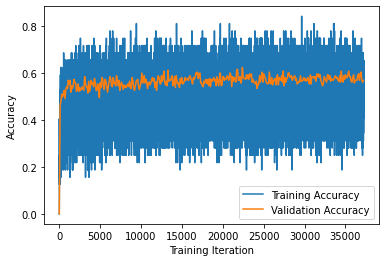

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.245 Validation Loss: 2.237 Accuracy: 0.023 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.244 Validation Loss: 2.237 Accuracy: 0.020 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.244 Validation Loss: 2.237 Accuracy: 0.016 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.241 Validation Loss: 2.237 Accuracy: 0.016 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.240 Validation Loss: 2.237 Accuracy: 0.016 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.236 Validation Loss: 2.237 Accuracy: 0.017 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.233 Validation Loss: 2.237 Accuracy: 0.018 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.233 Validation Loss: 2.237 Accuracy: 0.019 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.232 Validation Loss: 2.237 Accuracy: 0.016 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.231 Validation Loss: 2.237 Accuracy: 0.017 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.231 Validation Loss: 2.237 Accuracy: 0.019 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.229 Validation Loss: 2.237 Accuracy: 0.022 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.228 Validation Loss: 2.237 Accuracy: 0.027 Validation Accuracy: 0.018:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.228 Validation Loss: 2.237 Accuracy: 0.027 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 13 Loss: 2.228 Validation Loss: 2.237 Accuracy: 0.028 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 14 Loss: 2.227 Validation Loss: 2.237 Accuracy: 0.030 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 15 Loss: 2.225 Validation Loss: 2.237 Accuracy: 0.031 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 16 Loss: 2.224 Validation Loss: 2.237 Accuracy: 0.034 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 17 Loss: 2.223 Validation Loss: 2.237 Accuracy: 0.033 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 18 Loss: 2.223 Validation Loss: 2.237 Accuracy: 0.036 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 19 Loss: 2.222 Validation Loss: 2.237 Accuracy: 0.038 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 20 Loss: 2.219 Validation Loss: 2.237 Accuracy: 0.040 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 21 Loss: 2.217 Validation Loss: 2.237 Accuracy: 0.040 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 22 Loss: 2.215 Validation Loss: 2.237 Accuracy: 0.037 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 23 Loss: 2.214 Validation Loss: 2.237 Accuracy: 0.037 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 24 Loss: 2.212 Validation Loss: 2.237 Accuracy: 0.038 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 25 Loss: 2.212 Validation Loss: 2.237 Accuracy: 0.034 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 26 Loss: 2.211 Validation Loss: 2.237 Accuracy: 0.035 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 27 Loss: 2.210 Validation Loss: 2.237 Accuracy: 0.034 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 28 Loss: 2.209 Validation Loss: 2.237 Accuracy: 0.039 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 29 Loss: 2.208 Validation Loss: 2.237 Accuracy: 0.037 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 30 Loss: 2.206 Validation Loss: 2.237 Accuracy: 0.042 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 31 Loss: 2.205 Validation Loss: 2.237 Accuracy: 0.045 Validation Accuracy: 0.018:   1%|          | 13/1519 [00:00<00:11, 127.21it/s]

Epoch: 0 Iteration: 31 Loss: 2.205 Validation Loss: 2.237 Accuracy: 0.045 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 32 Loss: 2.204 Validation Loss: 2.237 Accuracy: 0.048 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 33 Loss: 2.202 Validation Loss: 2.237 Accuracy: 0.052 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 34 Loss: 2.201 Validation Loss: 2.237 Accuracy: 0.055 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 35 Loss: 2.200 Validation Loss: 2.237 Accuracy: 0.066 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 36 Loss: 2.199 Validation Loss: 2.237 Accuracy: 0.068 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 37 Loss: 2.197 Validation Loss: 2.237 Accuracy: 0.073 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 38 Loss: 2.196 Validation Loss: 2.237 Accuracy: 0.074 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 39 Loss: 2.195 Validation Loss: 2.237 Accuracy: 0.076 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 40 Loss: 2.194 Validation Loss: 2.237 Accuracy: 0.074 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 41 Loss: 2.194 Validation Loss: 2.237 Accuracy: 0.072 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 42 Loss: 2.192 Validation Loss: 2.237 Accuracy: 0.072 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 43 Loss: 2.190 Validation Loss: 2.237 Accuracy: 0.075 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 44 Loss: 2.189 Validation Loss: 2.237 Accuracy: 0.075 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 45 Loss: 2.187 Validation Loss: 2.237 Accuracy: 0.073 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 46 Loss: 2.186 Validation Loss: 2.237 Accuracy: 0.075 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 47 Loss: 2.184 Validation Loss: 2.237 Accuracy: 0.075 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 48 Loss: 2.182 Validation Loss: 2.237 Accuracy: 0.078 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 49 Loss: 2.180 Validation Loss: 2.237 Accuracy: 0.084 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 50 Loss: 2.179 Validation Loss: 2.237 Accuracy: 0.081 Validation Accuracy: 0.018:   2%|▏         | 32/1519 [00:00<00:09, 160.72it/s]

Epoch: 0 Iteration: 50 Loss: 2.179 Validation Loss: 2.237 Accuracy: 0.081 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 51 Loss: 2.177 Validation Loss: 2.237 Accuracy: 0.091 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 52 Loss: 2.176 Validation Loss: 2.237 Accuracy: 0.095 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 53 Loss: 2.175 Validation Loss: 2.237 Accuracy: 0.096 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 54 Loss: 2.173 Validation Loss: 2.237 Accuracy: 0.100 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 55 Loss: 2.172 Validation Loss: 2.237 Accuracy: 0.104 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 56 Loss: 2.171 Validation Loss: 2.237 Accuracy: 0.106 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 57 Loss: 2.169 Validation Loss: 2.237 Accuracy: 0.116 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 58 Loss: 2.168 Validation Loss: 2.237 Accuracy: 0.121 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 59 Loss: 2.167 Validation Loss: 2.237 Accuracy: 0.125 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 60 Loss: 2.165 Validation Loss: 2.237 Accuracy: 0.134 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 61 Loss: 2.163 Validation Loss: 2.237 Accuracy: 0.132 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 62 Loss: 2.162 Validation Loss: 2.237 Accuracy: 0.140 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 63 Loss: 2.161 Validation Loss: 2.237 Accuracy: 0.144 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 64 Loss: 2.159 Validation Loss: 2.237 Accuracy: 0.152 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 65 Loss: 2.158 Validation Loss: 2.237 Accuracy: 0.161 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 66 Loss: 2.156 Validation Loss: 2.237 Accuracy: 0.164 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 67 Loss: 2.155 Validation Loss: 2.237 Accuracy: 0.170 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 68 Loss: 2.153 Validation Loss: 2.237 Accuracy: 0.171 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 69 Loss: 2.153 Validation Loss: 2.237 Accuracy: 0.177 Validation Accuracy: 0.018:   3%|▎         | 51/1519 [00:00<00:08, 170.87it/s]

Epoch: 0 Iteration: 69 Loss: 2.153 Validation Loss: 2.237 Accuracy: 0.177 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 70 Loss: 2.151 Validation Loss: 2.237 Accuracy: 0.178 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 71 Loss: 2.149 Validation Loss: 2.237 Accuracy: 0.191 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 72 Loss: 2.147 Validation Loss: 2.237 Accuracy: 0.195 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 73 Loss: 2.147 Validation Loss: 2.237 Accuracy: 0.197 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 74 Loss: 2.144 Validation Loss: 2.237 Accuracy: 0.200 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 75 Loss: 2.143 Validation Loss: 2.237 Accuracy: 0.202 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 76 Loss: 2.141 Validation Loss: 2.237 Accuracy: 0.215 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 77 Loss: 2.140 Validation Loss: 2.237 Accuracy: 0.219 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 78 Loss: 2.138 Validation Loss: 2.237 Accuracy: 0.228 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 79 Loss: 2.137 Validation Loss: 2.237 Accuracy: 0.233 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 80 Loss: 2.136 Validation Loss: 2.237 Accuracy: 0.241 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 81 Loss: 2.134 Validation Loss: 2.237 Accuracy: 0.237 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 82 Loss: 2.134 Validation Loss: 2.237 Accuracy: 0.237 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 83 Loss: 2.132 Validation Loss: 2.237 Accuracy: 0.246 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 84 Loss: 2.131 Validation Loss: 2.237 Accuracy: 0.252 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 85 Loss: 2.130 Validation Loss: 2.237 Accuracy: 0.249 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 86 Loss: 2.129 Validation Loss: 2.237 Accuracy: 0.245 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 87 Loss: 2.127 Validation Loss: 2.237 Accuracy: 0.251 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 88 Loss: 2.126 Validation Loss: 2.237 Accuracy: 0.249 Validation Accuracy: 0.018:   5%|▍         | 70/1519 [00:00<00:08, 175.58it/s]

Epoch: 0 Iteration: 88 Loss: 2.126 Validation Loss: 2.237 Accuracy: 0.249 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 89 Loss: 2.125 Validation Loss: 2.237 Accuracy: 0.254 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 90 Loss: 2.123 Validation Loss: 2.237 Accuracy: 0.256 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 91 Loss: 2.122 Validation Loss: 2.237 Accuracy: 0.259 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 92 Loss: 2.121 Validation Loss: 2.237 Accuracy: 0.261 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 93 Loss: 2.119 Validation Loss: 2.237 Accuracy: 0.268 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 94 Loss: 2.119 Validation Loss: 2.237 Accuracy: 0.265 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 95 Loss: 2.118 Validation Loss: 2.237 Accuracy: 0.271 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 96 Loss: 2.117 Validation Loss: 2.237 Accuracy: 0.279 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 97 Loss: 2.116 Validation Loss: 2.237 Accuracy: 0.278 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 98 Loss: 2.115 Validation Loss: 2.237 Accuracy: 0.278 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 99 Loss: 2.113 Validation Loss: 2.237 Accuracy: 0.280 Validation Accuracy: 0.018:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 100 Loss: 2.112 Validation Loss: 2.090 Accuracy: 0.278 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 101 Loss: 2.111 Validation Loss: 2.090 Accuracy: 0.280 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 102 Loss: 2.109 Validation Loss: 2.090 Accuracy: 0.291 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 103 Loss: 2.108 Validation Loss: 2.090 Accuracy: 0.287 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 104 Loss: 2.107 Validation Loss: 2.090 Accuracy: 0.291 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 105 Loss: 2.104 Validation Loss: 2.090 Accuracy: 0.296 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 106 Loss: 2.103 Validation Loss: 2.090 Accuracy: 0.294 Validation Accuracy: 0.170:   6%|▌         | 89/1519 [00:00<00:08, 178.43it/s]

Epoch: 0 Iteration: 106 Loss: 2.103 Validation Loss: 2.090 Accuracy: 0.294 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 107 Loss: 2.102 Validation Loss: 2.090 Accuracy: 0.291 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 108 Loss: 2.100 Validation Loss: 2.090 Accuracy: 0.300 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 109 Loss: 2.099 Validation Loss: 2.090 Accuracy: 0.310 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 110 Loss: 2.099 Validation Loss: 2.090 Accuracy: 0.310 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 111 Loss: 2.096 Validation Loss: 2.090 Accuracy: 0.321 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 112 Loss: 2.094 Validation Loss: 2.090 Accuracy: 0.317 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 113 Loss: 2.093 Validation Loss: 2.090 Accuracy: 0.326 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 114 Loss: 2.091 Validation Loss: 2.090 Accuracy: 0.336 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 115 Loss: 2.090 Validation Loss: 2.090 Accuracy: 0.334 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 116 Loss: 2.089 Validation Loss: 2.090 Accuracy: 0.338 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 117 Loss: 2.086 Validation Loss: 2.090 Accuracy: 0.350 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 118 Loss: 2.085 Validation Loss: 2.090 Accuracy: 0.359 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 119 Loss: 2.084 Validation Loss: 2.090 Accuracy: 0.354 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 120 Loss: 2.082 Validation Loss: 2.090 Accuracy: 0.370 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 121 Loss: 2.081 Validation Loss: 2.090 Accuracy: 0.367 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 122 Loss: 2.079 Validation Loss: 2.090 Accuracy: 0.371 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 123 Loss: 2.079 Validation Loss: 2.090 Accuracy: 0.366 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 124 Loss: 2.077 Validation Loss: 2.090 Accuracy: 0.366 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 125 Loss: 2.076 Validation Loss: 2.090 Accuracy: 0.380 Validation Accuracy: 0.170:   7%|▋         | 107/1519 [00:00<00:07, 176.85it/s]

Epoch: 0 Iteration: 125 Loss: 2.076 Validation Loss: 2.090 Accuracy: 0.380 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 126 Loss: 2.074 Validation Loss: 2.090 Accuracy: 0.383 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 127 Loss: 2.073 Validation Loss: 2.090 Accuracy: 0.384 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 128 Loss: 2.072 Validation Loss: 2.090 Accuracy: 0.372 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 129 Loss: 2.071 Validation Loss: 2.090 Accuracy: 0.373 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 130 Loss: 2.069 Validation Loss: 2.090 Accuracy: 0.373 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 131 Loss: 2.070 Validation Loss: 2.090 Accuracy: 0.379 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 132 Loss: 2.069 Validation Loss: 2.090 Accuracy: 0.381 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 133 Loss: 2.067 Validation Loss: 2.090 Accuracy: 0.395 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 134 Loss: 2.065 Validation Loss: 2.090 Accuracy: 0.398 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 135 Loss: 2.064 Validation Loss: 2.090 Accuracy: 0.398 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 136 Loss: 2.063 Validation Loss: 2.090 Accuracy: 0.395 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 137 Loss: 2.062 Validation Loss: 2.090 Accuracy: 0.398 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 138 Loss: 2.060 Validation Loss: 2.090 Accuracy: 0.405 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 139 Loss: 2.058 Validation Loss: 2.090 Accuracy: 0.405 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 140 Loss: 2.058 Validation Loss: 2.090 Accuracy: 0.407 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 141 Loss: 2.055 Validation Loss: 2.090 Accuracy: 0.404 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 142 Loss: 2.053 Validation Loss: 2.090 Accuracy: 0.416 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 143 Loss: 2.050 Validation Loss: 2.090 Accuracy: 0.413 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 144 Loss: 2.049 Validation Loss: 2.090 Accuracy: 0.416 Validation Accuracy: 0.170:   8%|▊         | 126/1519 [00:00<00:07, 179.36it/s]

Epoch: 0 Iteration: 144 Loss: 2.049 Validation Loss: 2.090 Accuracy: 0.416 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 145 Loss: 2.047 Validation Loss: 2.090 Accuracy: 0.420 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 146 Loss: 2.045 Validation Loss: 2.090 Accuracy: 0.435 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 147 Loss: 2.044 Validation Loss: 2.090 Accuracy: 0.431 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 148 Loss: 2.043 Validation Loss: 2.090 Accuracy: 0.433 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 149 Loss: 2.040 Validation Loss: 2.090 Accuracy: 0.446 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 150 Loss: 2.038 Validation Loss: 2.090 Accuracy: 0.443 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 151 Loss: 2.035 Validation Loss: 2.090 Accuracy: 0.451 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 152 Loss: 2.033 Validation Loss: 2.090 Accuracy: 0.441 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 153 Loss: 2.032 Validation Loss: 2.090 Accuracy: 0.439 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 154 Loss: 2.030 Validation Loss: 2.090 Accuracy: 0.441 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 155 Loss: 2.029 Validation Loss: 2.090 Accuracy: 0.433 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 156 Loss: 2.026 Validation Loss: 2.090 Accuracy: 0.430 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 157 Loss: 2.024 Validation Loss: 2.090 Accuracy: 0.435 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 158 Loss: 2.023 Validation Loss: 2.090 Accuracy: 0.448 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 159 Loss: 2.022 Validation Loss: 2.090 Accuracy: 0.441 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 160 Loss: 2.019 Validation Loss: 2.090 Accuracy: 0.454 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 161 Loss: 2.017 Validation Loss: 2.090 Accuracy: 0.455 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 162 Loss: 2.016 Validation Loss: 2.090 Accuracy: 0.477 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 163 Loss: 2.015 Validation Loss: 2.090 Accuracy: 0.480 Validation Accuracy: 0.170:  10%|▉         | 145/1519 [00:00<00:07, 180.54it/s]

Epoch: 0 Iteration: 163 Loss: 2.015 Validation Loss: 2.090 Accuracy: 0.480 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 164 Loss: 2.014 Validation Loss: 2.090 Accuracy: 0.479 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 165 Loss: 2.015 Validation Loss: 2.090 Accuracy: 0.480 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 166 Loss: 2.014 Validation Loss: 2.090 Accuracy: 0.477 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 167 Loss: 2.014 Validation Loss: 2.090 Accuracy: 0.470 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 168 Loss: 2.012 Validation Loss: 2.090 Accuracy: 0.454 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 169 Loss: 2.012 Validation Loss: 2.090 Accuracy: 0.452 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 170 Loss: 2.011 Validation Loss: 2.090 Accuracy: 0.450 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 171 Loss: 2.009 Validation Loss: 2.090 Accuracy: 0.452 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 172 Loss: 2.009 Validation Loss: 2.090 Accuracy: 0.434 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 173 Loss: 2.008 Validation Loss: 2.090 Accuracy: 0.435 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 174 Loss: 2.007 Validation Loss: 2.090 Accuracy: 0.435 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 175 Loss: 2.005 Validation Loss: 2.090 Accuracy: 0.441 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:00<00:07, 181.35it/s]

Epoch: 0 Iteration: 176 Loss: 2.005 Validation Loss: 2.090 Accuracy: 0.441 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 177 Loss: 2.004 Validation Loss: 2.090 Accuracy: 0.448 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 178 Loss: 2.002 Validation Loss: 2.090 Accuracy: 0.463 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 179 Loss: 2.002 Validation Loss: 2.090 Accuracy: 0.465 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 180 Loss: 2.002 Validation Loss: 2.090 Accuracy: 0.457 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 181 Loss: 2.000 Validation Loss: 2.090 Accuracy: 0.455 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 182 Loss: 1.998 Validation Loss: 2.090 Accuracy: 0.462 Validation Accuracy: 0.170:  11%|█         | 164/1519 [00:01<00:07, 181.35it/s]

Epoch: 0 Iteration: 182 Loss: 1.998 Validation Loss: 2.090 Accuracy: 0.462 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 183 Loss: 1.996 Validation Loss: 2.090 Accuracy: 0.463 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 184 Loss: 1.994 Validation Loss: 2.090 Accuracy: 0.469 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 185 Loss: 1.992 Validation Loss: 2.090 Accuracy: 0.465 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 186 Loss: 1.990 Validation Loss: 2.090 Accuracy: 0.476 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 187 Loss: 1.987 Validation Loss: 2.090 Accuracy: 0.477 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 188 Loss: 1.985 Validation Loss: 2.090 Accuracy: 0.477 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 189 Loss: 1.983 Validation Loss: 2.090 Accuracy: 0.480 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 190 Loss: 1.981 Validation Loss: 2.090 Accuracy: 0.487 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 191 Loss: 1.979 Validation Loss: 2.090 Accuracy: 0.494 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 192 Loss: 1.976 Validation Loss: 2.090 Accuracy: 0.490 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 193 Loss: 1.976 Validation Loss: 2.090 Accuracy: 0.485 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 194 Loss: 1.976 Validation Loss: 2.090 Accuracy: 0.473 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 195 Loss: 1.974 Validation Loss: 2.090 Accuracy: 0.480 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 196 Loss: 1.972 Validation Loss: 2.090 Accuracy: 0.475 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 197 Loss: 1.971 Validation Loss: 2.090 Accuracy: 0.477 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 198 Loss: 1.971 Validation Loss: 2.090 Accuracy: 0.469 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 199 Loss: 1.968 Validation Loss: 2.090 Accuracy: 0.470 Validation Accuracy: 0.170:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 200 Loss: 1.966 Validation Loss: 1.934 Accuracy: 0.468 Validation Accuracy: 0.288:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 201 Loss: 1.964 Validation Loss: 1.934 Accuracy: 0.466 Validation Accuracy: 0.288:  12%|█▏        | 183/1519 [00:01<00:07, 181.77it/s]

Epoch: 0 Iteration: 201 Loss: 1.964 Validation Loss: 1.934 Accuracy: 0.466 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 202 Loss: 1.961 Validation Loss: 1.934 Accuracy: 0.484 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 203 Loss: 1.960 Validation Loss: 1.934 Accuracy: 0.487 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 204 Loss: 1.959 Validation Loss: 1.934 Accuracy: 0.493 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 205 Loss: 1.957 Validation Loss: 1.934 Accuracy: 0.494 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 206 Loss: 1.956 Validation Loss: 1.934 Accuracy: 0.498 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 207 Loss: 1.954 Validation Loss: 1.934 Accuracy: 0.501 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 208 Loss: 1.953 Validation Loss: 1.934 Accuracy: 0.516 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 209 Loss: 1.953 Validation Loss: 1.934 Accuracy: 0.513 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 210 Loss: 1.952 Validation Loss: 1.934 Accuracy: 0.516 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 211 Loss: 1.951 Validation Loss: 1.934 Accuracy: 0.514 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 212 Loss: 1.949 Validation Loss: 1.934 Accuracy: 0.508 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 213 Loss: 1.946 Validation Loss: 1.934 Accuracy: 0.516 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 214 Loss: 1.942 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 215 Loss: 1.942 Validation Loss: 1.934 Accuracy: 0.520 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 216 Loss: 1.941 Validation Loss: 1.934 Accuracy: 0.512 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 217 Loss: 1.938 Validation Loss: 1.934 Accuracy: 0.512 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 218 Loss: 1.936 Validation Loss: 1.934 Accuracy: 0.501 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 219 Loss: 1.935 Validation Loss: 1.934 Accuracy: 0.506 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 220 Loss: 1.932 Validation Loss: 1.934 Accuracy: 0.511 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 221 Loss: 1.931 Validation Loss: 1.934 Accuracy: 0.517 Validation Accuracy: 0.288:  13%|█▎        | 202/1519 [00:01<00:07, 182.15it/s]

Epoch: 0 Iteration: 221 Loss: 1.931 Validation Loss: 1.934 Accuracy: 0.517 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 222 Loss: 1.932 Validation Loss: 1.934 Accuracy: 0.509 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 223 Loss: 1.930 Validation Loss: 1.934 Accuracy: 0.504 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 224 Loss: 1.929 Validation Loss: 1.934 Accuracy: 0.509 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 225 Loss: 1.928 Validation Loss: 1.934 Accuracy: 0.512 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 226 Loss: 1.927 Validation Loss: 1.934 Accuracy: 0.518 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 227 Loss: 1.925 Validation Loss: 1.934 Accuracy: 0.519 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 228 Loss: 1.924 Validation Loss: 1.934 Accuracy: 0.520 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 229 Loss: 1.921 Validation Loss: 1.934 Accuracy: 0.527 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 230 Loss: 1.919 Validation Loss: 1.934 Accuracy: 0.525 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 231 Loss: 1.917 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 232 Loss: 1.915 Validation Loss: 1.934 Accuracy: 0.528 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 233 Loss: 1.914 Validation Loss: 1.934 Accuracy: 0.527 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 234 Loss: 1.913 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 235 Loss: 1.909 Validation Loss: 1.934 Accuracy: 0.526 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 236 Loss: 1.905 Validation Loss: 1.934 Accuracy: 0.534 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 237 Loss: 1.906 Validation Loss: 1.934 Accuracy: 0.527 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 238 Loss: 1.903 Validation Loss: 1.934 Accuracy: 0.526 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 239 Loss: 1.902 Validation Loss: 1.934 Accuracy: 0.522 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 240 Loss: 1.901 Validation Loss: 1.934 Accuracy: 0.512 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 241 Loss: 1.901 Validation Loss: 1.934 Accuracy: 0.502 Validation Accuracy: 0.288:  15%|█▍        | 222/1519 [00:01<00:06, 185.94it/s]

Epoch: 0 Iteration: 241 Loss: 1.901 Validation Loss: 1.934 Accuracy: 0.502 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 242 Loss: 1.898 Validation Loss: 1.934 Accuracy: 0.496 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 243 Loss: 1.897 Validation Loss: 1.934 Accuracy: 0.505 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 244 Loss: 1.894 Validation Loss: 1.934 Accuracy: 0.508 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 245 Loss: 1.890 Validation Loss: 1.934 Accuracy: 0.519 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 246 Loss: 1.888 Validation Loss: 1.934 Accuracy: 0.510 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 247 Loss: 1.887 Validation Loss: 1.934 Accuracy: 0.512 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 248 Loss: 1.885 Validation Loss: 1.934 Accuracy: 0.517 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 249 Loss: 1.883 Validation Loss: 1.934 Accuracy: 0.519 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 250 Loss: 1.881 Validation Loss: 1.934 Accuracy: 0.529 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 251 Loss: 1.881 Validation Loss: 1.934 Accuracy: 0.535 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 252 Loss: 1.879 Validation Loss: 1.934 Accuracy: 0.542 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 253 Loss: 1.878 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 254 Loss: 1.878 Validation Loss: 1.934 Accuracy: 0.514 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 255 Loss: 1.878 Validation Loss: 1.934 Accuracy: 0.502 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 256 Loss: 1.879 Validation Loss: 1.934 Accuracy: 0.502 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 257 Loss: 1.875 Validation Loss: 1.934 Accuracy: 0.514 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 258 Loss: 1.873 Validation Loss: 1.934 Accuracy: 0.518 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 259 Loss: 1.871 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 260 Loss: 1.868 Validation Loss: 1.934 Accuracy: 0.522 Validation Accuracy: 0.288:  16%|█▌        | 242/1519 [00:01<00:06, 188.47it/s]

Epoch: 0 Iteration: 260 Loss: 1.868 Validation Loss: 1.934 Accuracy: 0.522 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 261 Loss: 1.866 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 262 Loss: 1.866 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 263 Loss: 1.864 Validation Loss: 1.934 Accuracy: 0.541 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 264 Loss: 1.863 Validation Loss: 1.934 Accuracy: 0.556 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 265 Loss: 1.864 Validation Loss: 1.934 Accuracy: 0.560 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 266 Loss: 1.863 Validation Loss: 1.934 Accuracy: 0.557 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 267 Loss: 1.859 Validation Loss: 1.934 Accuracy: 0.548 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 268 Loss: 1.858 Validation Loss: 1.934 Accuracy: 0.539 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 269 Loss: 1.858 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 270 Loss: 1.856 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 271 Loss: 1.854 Validation Loss: 1.934 Accuracy: 0.536 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 272 Loss: 1.854 Validation Loss: 1.934 Accuracy: 0.531 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 273 Loss: 1.852 Validation Loss: 1.934 Accuracy: 0.527 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 274 Loss: 1.850 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 275 Loss: 1.847 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 276 Loss: 1.845 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 277 Loss: 1.843 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 278 Loss: 1.842 Validation Loss: 1.934 Accuracy: 0.534 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 279 Loss: 1.841 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  17%|█▋        | 261/1519 [00:01<00:06, 187.86it/s]

Epoch: 0 Iteration: 279 Loss: 1.841 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 280 Loss: 1.841 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 281 Loss: 1.838 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 282 Loss: 1.837 Validation Loss: 1.934 Accuracy: 0.530 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 283 Loss: 1.836 Validation Loss: 1.934 Accuracy: 0.534 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 284 Loss: 1.834 Validation Loss: 1.934 Accuracy: 0.527 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 285 Loss: 1.833 Validation Loss: 1.934 Accuracy: 0.525 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 286 Loss: 1.831 Validation Loss: 1.934 Accuracy: 0.534 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 287 Loss: 1.829 Validation Loss: 1.934 Accuracy: 0.533 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 288 Loss: 1.827 Validation Loss: 1.934 Accuracy: 0.537 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 289 Loss: 1.825 Validation Loss: 1.934 Accuracy: 0.546 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 290 Loss: 1.825 Validation Loss: 1.934 Accuracy: 0.548 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 291 Loss: 1.823 Validation Loss: 1.934 Accuracy: 0.554 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 292 Loss: 1.820 Validation Loss: 1.934 Accuracy: 0.554 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 293 Loss: 1.819 Validation Loss: 1.934 Accuracy: 0.541 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 294 Loss: 1.818 Validation Loss: 1.934 Accuracy: 0.538 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 295 Loss: 1.818 Validation Loss: 1.934 Accuracy: 0.534 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 296 Loss: 1.818 Validation Loss: 1.934 Accuracy: 0.523 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 297 Loss: 1.815 Validation Loss: 1.934 Accuracy: 0.529 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 298 Loss: 1.816 Validation Loss: 1.934 Accuracy: 0.524 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 299 Loss: 1.815 Validation Loss: 1.934 Accuracy: 0.521 Validation Accuracy: 0.288:  18%|█▊        | 280/1519 [00:01<00:06, 183.96it/s]

Epoch: 0 Iteration: 299 Loss: 1.815 Validation Loss: 1.934 Accuracy: 0.521 Validation Accuracy: 0.288:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 300 Loss: 1.813 Validation Loss: 1.771 Accuracy: 0.516 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 301 Loss: 1.812 Validation Loss: 1.771 Accuracy: 0.513 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 302 Loss: 1.809 Validation Loss: 1.771 Accuracy: 0.512 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 303 Loss: 1.806 Validation Loss: 1.771 Accuracy: 0.526 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 304 Loss: 1.803 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 305 Loss: 1.801 Validation Loss: 1.771 Accuracy: 0.548 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 306 Loss: 1.800 Validation Loss: 1.771 Accuracy: 0.552 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 307 Loss: 1.801 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 308 Loss: 1.801 Validation Loss: 1.771 Accuracy: 0.546 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 309 Loss: 1.798 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 310 Loss: 1.797 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 311 Loss: 1.798 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 312 Loss: 1.797 Validation Loss: 1.771 Accuracy: 0.543 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 313 Loss: 1.794 Validation Loss: 1.771 Accuracy: 0.539 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 314 Loss: 1.793 Validation Loss: 1.771 Accuracy: 0.526 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 315 Loss: 1.792 Validation Loss: 1.771 Accuracy: 0.524 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 316 Loss: 1.790 Validation Loss: 1.771 Accuracy: 0.527 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 317 Loss: 1.789 Validation Loss: 1.771 Accuracy: 0.533 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 318 Loss: 1.789 Validation Loss: 1.771 Accuracy: 0.528 Validation Accuracy: 0.361:  20%|█▉        | 300/1519 [00:01<00:06, 186.61it/s]

Epoch: 0 Iteration: 318 Loss: 1.789 Validation Loss: 1.771 Accuracy: 0.528 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 319 Loss: 1.787 Validation Loss: 1.771 Accuracy: 0.537 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 320 Loss: 1.784 Validation Loss: 1.771 Accuracy: 0.546 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 321 Loss: 1.784 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 322 Loss: 1.783 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 323 Loss: 1.782 Validation Loss: 1.771 Accuracy: 0.543 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 324 Loss: 1.783 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 325 Loss: 1.781 Validation Loss: 1.771 Accuracy: 0.547 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 326 Loss: 1.780 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 327 Loss: 1.779 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 328 Loss: 1.778 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 329 Loss: 1.779 Validation Loss: 1.771 Accuracy: 0.530 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 330 Loss: 1.778 Validation Loss: 1.771 Accuracy: 0.519 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 331 Loss: 1.774 Validation Loss: 1.771 Accuracy: 0.523 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 332 Loss: 1.771 Validation Loss: 1.771 Accuracy: 0.531 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 333 Loss: 1.770 Validation Loss: 1.771 Accuracy: 0.534 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 334 Loss: 1.768 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 335 Loss: 1.762 Validation Loss: 1.771 Accuracy: 0.551 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 336 Loss: 1.760 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 337 Loss: 1.761 Validation Loss: 1.771 Accuracy: 0.549 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 338 Loss: 1.758 Validation Loss: 1.771 Accuracy: 0.552 Validation Accuracy: 0.361:  21%|██        | 319/1519 [00:01<00:06, 184.95it/s]

Epoch: 0 Iteration: 338 Loss: 1.758 Validation Loss: 1.771 Accuracy: 0.552 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 339 Loss: 1.755 Validation Loss: 1.771 Accuracy: 0.565 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 340 Loss: 1.754 Validation Loss: 1.771 Accuracy: 0.569 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 341 Loss: 1.753 Validation Loss: 1.771 Accuracy: 0.567 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 342 Loss: 1.751 Validation Loss: 1.771 Accuracy: 0.562 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 343 Loss: 1.751 Validation Loss: 1.771 Accuracy: 0.560 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 344 Loss: 1.748 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 345 Loss: 1.745 Validation Loss: 1.771 Accuracy: 0.553 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 346 Loss: 1.744 Validation Loss: 1.771 Accuracy: 0.546 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 347 Loss: 1.743 Validation Loss: 1.771 Accuracy: 0.548 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 348 Loss: 1.737 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 349 Loss: 1.735 Validation Loss: 1.771 Accuracy: 0.550 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 350 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.548 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 351 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.547 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 352 Loss: 1.732 Validation Loss: 1.771 Accuracy: 0.551 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 353 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.550 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 354 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 355 Loss: 1.730 Validation Loss: 1.771 Accuracy: 0.540 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 356 Loss: 1.729 Validation Loss: 1.771 Accuracy: 0.543 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 357 Loss: 1.728 Validation Loss: 1.771 Accuracy: 0.548 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 358 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.551 Validation Accuracy: 0.361:  22%|██▏       | 339/1519 [00:01<00:06, 187.09it/s]

Epoch: 0 Iteration: 358 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.551 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 359 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.549 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 360 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 361 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.562 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 362 Loss: 1.726 Validation Loss: 1.771 Accuracy: 0.554 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 363 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.552 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:01<00:06, 188.59it/s]

Epoch: 0 Iteration: 364 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 365 Loss: 1.725 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 366 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.559 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 367 Loss: 1.720 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 368 Loss: 1.724 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 369 Loss: 1.722 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 370 Loss: 1.721 Validation Loss: 1.771 Accuracy: 0.534 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 371 Loss: 1.720 Validation Loss: 1.771 Accuracy: 0.527 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 372 Loss: 1.718 Validation Loss: 1.771 Accuracy: 0.537 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 373 Loss: 1.720 Validation Loss: 1.771 Accuracy: 0.538 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 374 Loss: 1.717 Validation Loss: 1.771 Accuracy: 0.536 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 375 Loss: 1.715 Validation Loss: 1.771 Accuracy: 0.539 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 376 Loss: 1.714 Validation Loss: 1.771 Accuracy: 0.535 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 377 Loss: 1.710 Validation Loss: 1.771 Accuracy: 0.546 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 378 Loss: 1.711 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  24%|██▎       | 359/1519 [00:02<00:06, 188.59it/s]

Epoch: 0 Iteration: 378 Loss: 1.711 Validation Loss: 1.771 Accuracy: 0.544 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 379 Loss: 1.709 Validation Loss: 1.771 Accuracy: 0.538 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 380 Loss: 1.707 Validation Loss: 1.771 Accuracy: 0.542 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 381 Loss: 1.704 Validation Loss: 1.771 Accuracy: 0.549 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 382 Loss: 1.699 Validation Loss: 1.771 Accuracy: 0.545 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 383 Loss: 1.698 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 384 Loss: 1.696 Validation Loss: 1.771 Accuracy: 0.543 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 385 Loss: 1.692 Validation Loss: 1.771 Accuracy: 0.541 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 386 Loss: 1.694 Validation Loss: 1.771 Accuracy: 0.546 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 387 Loss: 1.692 Validation Loss: 1.771 Accuracy: 0.540 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 388 Loss: 1.686 Validation Loss: 1.771 Accuracy: 0.555 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 389 Loss: 1.684 Validation Loss: 1.771 Accuracy: 0.564 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 390 Loss: 1.682 Validation Loss: 1.771 Accuracy: 0.572 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 391 Loss: 1.680 Validation Loss: 1.771 Accuracy: 0.565 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 392 Loss: 1.678 Validation Loss: 1.771 Accuracy: 0.565 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 393 Loss: 1.673 Validation Loss: 1.771 Accuracy: 0.574 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 394 Loss: 1.671 Validation Loss: 1.771 Accuracy: 0.579 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 395 Loss: 1.670 Validation Loss: 1.771 Accuracy: 0.578 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 396 Loss: 1.667 Validation Loss: 1.771 Accuracy: 0.583 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 397 Loss: 1.666 Validation Loss: 1.771 Accuracy: 0.582 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 398 Loss: 1.661 Validation Loss: 1.771 Accuracy: 0.578 Validation Accuracy: 0.361:  25%|██▍       | 379/1519 [00:02<00:06, 189.95it/s]

Epoch: 0 Iteration: 398 Loss: 1.661 Validation Loss: 1.771 Accuracy: 0.578 Validation Accuracy: 0.361:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 399 Loss: 1.662 Validation Loss: 1.771 Accuracy: 0.576 Validation Accuracy: 0.361:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 400 Loss: 1.660 Validation Loss: 1.619 Accuracy: 0.577 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 401 Loss: 1.659 Validation Loss: 1.619 Accuracy: 0.584 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 402 Loss: 1.658 Validation Loss: 1.619 Accuracy: 0.591 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 403 Loss: 1.656 Validation Loss: 1.619 Accuracy: 0.579 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 404 Loss: 1.657 Validation Loss: 1.619 Accuracy: 0.573 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 405 Loss: 1.659 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 406 Loss: 1.657 Validation Loss: 1.619 Accuracy: 0.562 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 407 Loss: 1.656 Validation Loss: 1.619 Accuracy: 0.557 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 408 Loss: 1.656 Validation Loss: 1.619 Accuracy: 0.555 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 409 Loss: 1.655 Validation Loss: 1.619 Accuracy: 0.552 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 410 Loss: 1.655 Validation Loss: 1.619 Accuracy: 0.547 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 411 Loss: 1.655 Validation Loss: 1.619 Accuracy: 0.536 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 412 Loss: 1.656 Validation Loss: 1.619 Accuracy: 0.528 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 413 Loss: 1.654 Validation Loss: 1.619 Accuracy: 0.543 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 414 Loss: 1.654 Validation Loss: 1.619 Accuracy: 0.550 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 415 Loss: 1.651 Validation Loss: 1.619 Accuracy: 0.557 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 416 Loss: 1.652 Validation Loss: 1.619 Accuracy: 0.548 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 417 Loss: 1.651 Validation Loss: 1.619 Accuracy: 0.554 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 418 Loss: 1.651 Validation Loss: 1.619 Accuracy: 0.553 Validation Accuracy: 0.409:  26%|██▋       | 399/1519 [00:02<00:05, 190.78it/s]

Epoch: 0 Iteration: 418 Loss: 1.651 Validation Loss: 1.619 Accuracy: 0.553 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 419 Loss: 1.648 Validation Loss: 1.619 Accuracy: 0.559 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 420 Loss: 1.645 Validation Loss: 1.619 Accuracy: 0.564 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 421 Loss: 1.645 Validation Loss: 1.619 Accuracy: 0.558 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 422 Loss: 1.644 Validation Loss: 1.619 Accuracy: 0.567 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 423 Loss: 1.641 Validation Loss: 1.619 Accuracy: 0.565 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 424 Loss: 1.639 Validation Loss: 1.619 Accuracy: 0.559 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 425 Loss: 1.638 Validation Loss: 1.619 Accuracy: 0.555 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 426 Loss: 1.638 Validation Loss: 1.619 Accuracy: 0.560 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 427 Loss: 1.638 Validation Loss: 1.619 Accuracy: 0.554 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 428 Loss: 1.638 Validation Loss: 1.619 Accuracy: 0.547 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 429 Loss: 1.636 Validation Loss: 1.619 Accuracy: 0.537 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 430 Loss: 1.636 Validation Loss: 1.619 Accuracy: 0.532 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 431 Loss: 1.633 Validation Loss: 1.619 Accuracy: 0.552 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 432 Loss: 1.628 Validation Loss: 1.619 Accuracy: 0.550 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 433 Loss: 1.629 Validation Loss: 1.619 Accuracy: 0.547 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 434 Loss: 1.625 Validation Loss: 1.619 Accuracy: 0.554 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 435 Loss: 1.627 Validation Loss: 1.619 Accuracy: 0.556 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 436 Loss: 1.622 Validation Loss: 1.619 Accuracy: 0.561 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 437 Loss: 1.623 Validation Loss: 1.619 Accuracy: 0.567 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 438 Loss: 1.620 Validation Loss: 1.619 Accuracy: 0.580 Validation Accuracy: 0.409:  28%|██▊       | 419/1519 [00:02<00:05, 187.93it/s]

Epoch: 0 Iteration: 438 Loss: 1.620 Validation Loss: 1.619 Accuracy: 0.580 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 439 Loss: 1.619 Validation Loss: 1.619 Accuracy: 0.594 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 440 Loss: 1.620 Validation Loss: 1.619 Accuracy: 0.596 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 441 Loss: 1.619 Validation Loss: 1.619 Accuracy: 0.584 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 442 Loss: 1.617 Validation Loss: 1.619 Accuracy: 0.588 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 443 Loss: 1.613 Validation Loss: 1.619 Accuracy: 0.591 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 444 Loss: 1.612 Validation Loss: 1.619 Accuracy: 0.586 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 445 Loss: 1.608 Validation Loss: 1.619 Accuracy: 0.586 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 446 Loss: 1.604 Validation Loss: 1.619 Accuracy: 0.584 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 447 Loss: 1.603 Validation Loss: 1.619 Accuracy: 0.580 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 448 Loss: 1.604 Validation Loss: 1.619 Accuracy: 0.569 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 449 Loss: 1.600 Validation Loss: 1.619 Accuracy: 0.560 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 450 Loss: 1.599 Validation Loss: 1.619 Accuracy: 0.549 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 451 Loss: 1.600 Validation Loss: 1.619 Accuracy: 0.554 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 452 Loss: 1.600 Validation Loss: 1.619 Accuracy: 0.550 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 453 Loss: 1.599 Validation Loss: 1.619 Accuracy: 0.545 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 454 Loss: 1.600 Validation Loss: 1.619 Accuracy: 0.548 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 455 Loss: 1.597 Validation Loss: 1.619 Accuracy: 0.548 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 456 Loss: 1.596 Validation Loss: 1.619 Accuracy: 0.553 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 457 Loss: 1.595 Validation Loss: 1.619 Accuracy: 0.555 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 458 Loss: 1.594 Validation Loss: 1.619 Accuracy: 0.561 Validation Accuracy: 0.409:  29%|██▉       | 439/1519 [00:02<00:05, 189.55it/s]

Epoch: 0 Iteration: 458 Loss: 1.594 Validation Loss: 1.619 Accuracy: 0.561 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 459 Loss: 1.594 Validation Loss: 1.619 Accuracy: 0.567 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 460 Loss: 1.594 Validation Loss: 1.619 Accuracy: 0.571 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 461 Loss: 1.590 Validation Loss: 1.619 Accuracy: 0.572 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 462 Loss: 1.590 Validation Loss: 1.619 Accuracy: 0.565 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 463 Loss: 1.592 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 464 Loss: 1.590 Validation Loss: 1.619 Accuracy: 0.555 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 465 Loss: 1.590 Validation Loss: 1.619 Accuracy: 0.554 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 466 Loss: 1.588 Validation Loss: 1.619 Accuracy: 0.544 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 467 Loss: 1.583 Validation Loss: 1.619 Accuracy: 0.544 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 468 Loss: 1.580 Validation Loss: 1.619 Accuracy: 0.546 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 469 Loss: 1.579 Validation Loss: 1.619 Accuracy: 0.551 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 470 Loss: 1.576 Validation Loss: 1.619 Accuracy: 0.552 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 471 Loss: 1.573 Validation Loss: 1.619 Accuracy: 0.552 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 472 Loss: 1.567 Validation Loss: 1.619 Accuracy: 0.563 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 473 Loss: 1.566 Validation Loss: 1.619 Accuracy: 0.561 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 474 Loss: 1.568 Validation Loss: 1.619 Accuracy: 0.562 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 475 Loss: 1.568 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 476 Loss: 1.570 Validation Loss: 1.619 Accuracy: 0.572 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 477 Loss: 1.567 Validation Loss: 1.619 Accuracy: 0.574 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 478 Loss: 1.566 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  30%|███       | 459/1519 [00:02<00:05, 190.48it/s]

Epoch: 0 Iteration: 478 Loss: 1.566 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 479 Loss: 1.565 Validation Loss: 1.619 Accuracy: 0.559 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 480 Loss: 1.562 Validation Loss: 1.619 Accuracy: 0.568 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 481 Loss: 1.565 Validation Loss: 1.619 Accuracy: 0.564 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 482 Loss: 1.565 Validation Loss: 1.619 Accuracy: 0.552 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 483 Loss: 1.563 Validation Loss: 1.619 Accuracy: 0.558 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 484 Loss: 1.558 Validation Loss: 1.619 Accuracy: 0.570 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 485 Loss: 1.558 Validation Loss: 1.619 Accuracy: 0.566 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 486 Loss: 1.558 Validation Loss: 1.619 Accuracy: 0.570 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 487 Loss: 1.559 Validation Loss: 1.619 Accuracy: 0.569 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 488 Loss: 1.555 Validation Loss: 1.619 Accuracy: 0.577 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 489 Loss: 1.553 Validation Loss: 1.619 Accuracy: 0.577 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 490 Loss: 1.555 Validation Loss: 1.619 Accuracy: 0.565 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 491 Loss: 1.551 Validation Loss: 1.619 Accuracy: 0.574 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 492 Loss: 1.554 Validation Loss: 1.619 Accuracy: 0.580 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 493 Loss: 1.553 Validation Loss: 1.619 Accuracy: 0.582 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 494 Loss: 1.548 Validation Loss: 1.619 Accuracy: 0.580 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 495 Loss: 1.544 Validation Loss: 1.619 Accuracy: 0.588 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 496 Loss: 1.543 Validation Loss: 1.619 Accuracy: 0.587 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 497 Loss: 1.543 Validation Loss: 1.619 Accuracy: 0.583 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 498 Loss: 1.545 Validation Loss: 1.619 Accuracy: 0.570 Validation Accuracy: 0.409:  32%|███▏      | 479/1519 [00:02<00:05, 191.33it/s]

Epoch: 0 Iteration: 498 Loss: 1.545 Validation Loss: 1.619 Accuracy: 0.570 Validation Accuracy: 0.409:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 499 Loss: 1.545 Validation Loss: 1.619 Accuracy: 0.573 Validation Accuracy: 0.409:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 500 Loss: 1.545 Validation Loss: 1.482 Accuracy: 0.577 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 501 Loss: 1.542 Validation Loss: 1.482 Accuracy: 0.563 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 502 Loss: 1.540 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 503 Loss: 1.541 Validation Loss: 1.482 Accuracy: 0.562 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 504 Loss: 1.541 Validation Loss: 1.482 Accuracy: 0.569 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 505 Loss: 1.537 Validation Loss: 1.482 Accuracy: 0.572 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 506 Loss: 1.533 Validation Loss: 1.482 Accuracy: 0.570 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 507 Loss: 1.530 Validation Loss: 1.482 Accuracy: 0.580 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 508 Loss: 1.533 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 509 Loss: 1.534 Validation Loss: 1.482 Accuracy: 0.579 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 510 Loss: 1.531 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 511 Loss: 1.532 Validation Loss: 1.482 Accuracy: 0.588 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 512 Loss: 1.532 Validation Loss: 1.482 Accuracy: 0.583 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 513 Loss: 1.530 Validation Loss: 1.482 Accuracy: 0.588 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 514 Loss: 1.529 Validation Loss: 1.482 Accuracy: 0.581 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 515 Loss: 1.529 Validation Loss: 1.482 Accuracy: 0.577 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 516 Loss: 1.530 Validation Loss: 1.482 Accuracy: 0.566 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 517 Loss: 1.528 Validation Loss: 1.482 Accuracy: 0.557 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 518 Loss: 1.524 Validation Loss: 1.482 Accuracy: 0.563 Validation Accuracy: 0.445:  33%|███▎      | 499/1519 [00:02<00:05, 191.88it/s]

Epoch: 0 Iteration: 518 Loss: 1.524 Validation Loss: 1.482 Accuracy: 0.563 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 519 Loss: 1.520 Validation Loss: 1.482 Accuracy: 0.572 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 520 Loss: 1.520 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 521 Loss: 1.520 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 522 Loss: 1.517 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 523 Loss: 1.517 Validation Loss: 1.482 Accuracy: 0.569 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 524 Loss: 1.516 Validation Loss: 1.482 Accuracy: 0.564 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 525 Loss: 1.515 Validation Loss: 1.482 Accuracy: 0.563 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 526 Loss: 1.516 Validation Loss: 1.482 Accuracy: 0.572 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 527 Loss: 1.517 Validation Loss: 1.482 Accuracy: 0.578 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 528 Loss: 1.512 Validation Loss: 1.482 Accuracy: 0.582 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 529 Loss: 1.509 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 530 Loss: 1.507 Validation Loss: 1.482 Accuracy: 0.589 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 531 Loss: 1.507 Validation Loss: 1.482 Accuracy: 0.591 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 532 Loss: 1.503 Validation Loss: 1.482 Accuracy: 0.598 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 533 Loss: 1.504 Validation Loss: 1.482 Accuracy: 0.598 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 534 Loss: 1.502 Validation Loss: 1.482 Accuracy: 0.601 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 535 Loss: 1.505 Validation Loss: 1.482 Accuracy: 0.594 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 536 Loss: 1.504 Validation Loss: 1.482 Accuracy: 0.596 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 537 Loss: 1.502 Validation Loss: 1.482 Accuracy: 0.597 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 538 Loss: 1.500 Validation Loss: 1.482 Accuracy: 0.596 Validation Accuracy: 0.445:  34%|███▍      | 519/1519 [00:02<00:05, 189.08it/s]

Epoch: 0 Iteration: 538 Loss: 1.500 Validation Loss: 1.482 Accuracy: 0.596 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 539 Loss: 1.504 Validation Loss: 1.482 Accuracy: 0.580 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 540 Loss: 1.499 Validation Loss: 1.482 Accuracy: 0.572 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 541 Loss: 1.497 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 542 Loss: 1.496 Validation Loss: 1.482 Accuracy: 0.566 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 543 Loss: 1.491 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 544 Loss: 1.490 Validation Loss: 1.482 Accuracy: 0.574 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 545 Loss: 1.491 Validation Loss: 1.482 Accuracy: 0.580 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 546 Loss: 1.491 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 547 Loss: 1.491 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 548 Loss: 1.490 Validation Loss: 1.482 Accuracy: 0.583 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 549 Loss: 1.490 Validation Loss: 1.482 Accuracy: 0.591 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 550 Loss: 1.488 Validation Loss: 1.482 Accuracy: 0.602 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 551 Loss: 1.485 Validation Loss: 1.482 Accuracy: 0.608 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 552 Loss: 1.486 Validation Loss: 1.482 Accuracy: 0.612 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 553 Loss: 1.481 Validation Loss: 1.482 Accuracy: 0.609 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 554 Loss: 1.481 Validation Loss: 1.482 Accuracy: 0.604 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:02<00:05, 190.25it/s]

Epoch: 0 Iteration: 555 Loss: 1.475 Validation Loss: 1.482 Accuracy: 0.606 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:03<00:05, 190.25it/s]

Epoch: 0 Iteration: 556 Loss: 1.471 Validation Loss: 1.482 Accuracy: 0.607 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:03<00:05, 190.25it/s]

Epoch: 0 Iteration: 557 Loss: 1.471 Validation Loss: 1.482 Accuracy: 0.603 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:03<00:05, 190.25it/s]

Epoch: 0 Iteration: 558 Loss: 1.469 Validation Loss: 1.482 Accuracy: 0.599 Validation Accuracy: 0.445:  35%|███▌      | 539/1519 [00:03<00:05, 190.25it/s]

Epoch: 0 Iteration: 558 Loss: 1.469 Validation Loss: 1.482 Accuracy: 0.599 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 559 Loss: 1.464 Validation Loss: 1.482 Accuracy: 0.609 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 560 Loss: 1.467 Validation Loss: 1.482 Accuracy: 0.597 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 561 Loss: 1.467 Validation Loss: 1.482 Accuracy: 0.594 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 562 Loss: 1.468 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 563 Loss: 1.469 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 564 Loss: 1.467 Validation Loss: 1.482 Accuracy: 0.589 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 565 Loss: 1.466 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 566 Loss: 1.466 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 567 Loss: 1.462 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 568 Loss: 1.465 Validation Loss: 1.482 Accuracy: 0.567 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 569 Loss: 1.463 Validation Loss: 1.482 Accuracy: 0.559 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 570 Loss: 1.461 Validation Loss: 1.482 Accuracy: 0.566 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 571 Loss: 1.462 Validation Loss: 1.482 Accuracy: 0.568 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 572 Loss: 1.465 Validation Loss: 1.482 Accuracy: 0.565 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 573 Loss: 1.464 Validation Loss: 1.482 Accuracy: 0.571 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 574 Loss: 1.461 Validation Loss: 1.482 Accuracy: 0.579 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 575 Loss: 1.459 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 576 Loss: 1.459 Validation Loss: 1.482 Accuracy: 0.594 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 577 Loss: 1.457 Validation Loss: 1.482 Accuracy: 0.590 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 578 Loss: 1.458 Validation Loss: 1.482 Accuracy: 0.592 Validation Accuracy: 0.445:  37%|███▋      | 559/1519 [00:03<00:05, 191.02it/s]

Epoch: 0 Iteration: 578 Loss: 1.458 Validation Loss: 1.482 Accuracy: 0.592 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 579 Loss: 1.459 Validation Loss: 1.482 Accuracy: 0.595 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 580 Loss: 1.456 Validation Loss: 1.482 Accuracy: 0.591 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 581 Loss: 1.455 Validation Loss: 1.482 Accuracy: 0.584 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 582 Loss: 1.453 Validation Loss: 1.482 Accuracy: 0.592 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 583 Loss: 1.453 Validation Loss: 1.482 Accuracy: 0.585 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 584 Loss: 1.451 Validation Loss: 1.482 Accuracy: 0.581 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 585 Loss: 1.451 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 586 Loss: 1.451 Validation Loss: 1.482 Accuracy: 0.558 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 587 Loss: 1.452 Validation Loss: 1.482 Accuracy: 0.568 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 588 Loss: 1.448 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 589 Loss: 1.447 Validation Loss: 1.482 Accuracy: 0.564 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 590 Loss: 1.448 Validation Loss: 1.482 Accuracy: 0.569 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 591 Loss: 1.448 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 592 Loss: 1.443 Validation Loss: 1.482 Accuracy: 0.572 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 593 Loss: 1.446 Validation Loss: 1.482 Accuracy: 0.573 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 594 Loss: 1.445 Validation Loss: 1.482 Accuracy: 0.566 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 595 Loss: 1.444 Validation Loss: 1.482 Accuracy: 0.581 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 596 Loss: 1.447 Validation Loss: 1.482 Accuracy: 0.591 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 597 Loss: 1.445 Validation Loss: 1.482 Accuracy: 0.585 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 598 Loss: 1.444 Validation Loss: 1.482 Accuracy: 0.588 Validation Accuracy: 0.445:  38%|███▊      | 579/1519 [00:03<00:04, 191.63it/s]

Epoch: 0 Iteration: 598 Loss: 1.444 Validation Loss: 1.482 Accuracy: 0.588 Validation Accuracy: 0.445:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 599 Loss: 1.443 Validation Loss: 1.482 Accuracy: 0.594 Validation Accuracy: 0.445:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 600 Loss: 1.443 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 601 Loss: 1.438 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 602 Loss: 1.435 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 603 Loss: 1.431 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 604 Loss: 1.433 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 605 Loss: 1.431 Validation Loss: 1.367 Accuracy: 0.579 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 606 Loss: 1.426 Validation Loss: 1.367 Accuracy: 0.582 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 607 Loss: 1.423 Validation Loss: 1.367 Accuracy: 0.582 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 608 Loss: 1.426 Validation Loss: 1.367 Accuracy: 0.577 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 609 Loss: 1.425 Validation Loss: 1.367 Accuracy: 0.580 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 610 Loss: 1.423 Validation Loss: 1.367 Accuracy: 0.582 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 611 Loss: 1.421 Validation Loss: 1.367 Accuracy: 0.583 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 612 Loss: 1.420 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 613 Loss: 1.414 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 614 Loss: 1.414 Validation Loss: 1.367 Accuracy: 0.599 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 615 Loss: 1.415 Validation Loss: 1.367 Accuracy: 0.601 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 616 Loss: 1.414 Validation Loss: 1.367 Accuracy: 0.599 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 617 Loss: 1.413 Validation Loss: 1.367 Accuracy: 0.599 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 618 Loss: 1.413 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  39%|███▉      | 599/1519 [00:03<00:04, 192.09it/s]

Epoch: 0 Iteration: 618 Loss: 1.413 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 619 Loss: 1.411 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 620 Loss: 1.408 Validation Loss: 1.367 Accuracy: 0.592 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 621 Loss: 1.406 Validation Loss: 1.367 Accuracy: 0.600 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 622 Loss: 1.406 Validation Loss: 1.367 Accuracy: 0.597 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 623 Loss: 1.408 Validation Loss: 1.367 Accuracy: 0.592 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 624 Loss: 1.407 Validation Loss: 1.367 Accuracy: 0.590 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 625 Loss: 1.404 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 626 Loss: 1.407 Validation Loss: 1.367 Accuracy: 0.589 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 627 Loss: 1.408 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 628 Loss: 1.406 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 629 Loss: 1.408 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 630 Loss: 1.407 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 631 Loss: 1.406 Validation Loss: 1.367 Accuracy: 0.587 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 632 Loss: 1.403 Validation Loss: 1.367 Accuracy: 0.590 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 633 Loss: 1.404 Validation Loss: 1.367 Accuracy: 0.596 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 634 Loss: 1.402 Validation Loss: 1.367 Accuracy: 0.601 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 635 Loss: 1.399 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 636 Loss: 1.396 Validation Loss: 1.367 Accuracy: 0.606 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 637 Loss: 1.396 Validation Loss: 1.367 Accuracy: 0.596 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 638 Loss: 1.394 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  41%|████      | 619/1519 [00:03<00:04, 189.27it/s]

Epoch: 0 Iteration: 638 Loss: 1.394 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 639 Loss: 1.393 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 640 Loss: 1.393 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 641 Loss: 1.395 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 642 Loss: 1.396 Validation Loss: 1.367 Accuracy: 0.601 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 643 Loss: 1.394 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 644 Loss: 1.393 Validation Loss: 1.367 Accuracy: 0.583 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 645 Loss: 1.394 Validation Loss: 1.367 Accuracy: 0.584 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 646 Loss: 1.387 Validation Loss: 1.367 Accuracy: 0.583 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 647 Loss: 1.382 Validation Loss: 1.367 Accuracy: 0.596 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 648 Loss: 1.382 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 649 Loss: 1.381 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 650 Loss: 1.379 Validation Loss: 1.367 Accuracy: 0.603 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 651 Loss: 1.377 Validation Loss: 1.367 Accuracy: 0.600 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 652 Loss: 1.380 Validation Loss: 1.367 Accuracy: 0.596 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 653 Loss: 1.380 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 654 Loss: 1.380 Validation Loss: 1.367 Accuracy: 0.609 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 655 Loss: 1.379 Validation Loss: 1.367 Accuracy: 0.611 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 656 Loss: 1.377 Validation Loss: 1.367 Accuracy: 0.615 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 657 Loss: 1.374 Validation Loss: 1.367 Accuracy: 0.608 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 658 Loss: 1.373 Validation Loss: 1.367 Accuracy: 0.607 Validation Accuracy: 0.472:  42%|████▏     | 639/1519 [00:03<00:04, 190.08it/s]

Epoch: 0 Iteration: 658 Loss: 1.373 Validation Loss: 1.367 Accuracy: 0.607 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 659 Loss: 1.371 Validation Loss: 1.367 Accuracy: 0.609 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 660 Loss: 1.368 Validation Loss: 1.367 Accuracy: 0.611 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 661 Loss: 1.364 Validation Loss: 1.367 Accuracy: 0.613 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 662 Loss: 1.363 Validation Loss: 1.367 Accuracy: 0.615 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 663 Loss: 1.363 Validation Loss: 1.367 Accuracy: 0.606 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 664 Loss: 1.360 Validation Loss: 1.367 Accuracy: 0.605 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 665 Loss: 1.357 Validation Loss: 1.367 Accuracy: 0.600 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 666 Loss: 1.361 Validation Loss: 1.367 Accuracy: 0.597 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 667 Loss: 1.364 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 668 Loss: 1.362 Validation Loss: 1.367 Accuracy: 0.589 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 669 Loss: 1.357 Validation Loss: 1.367 Accuracy: 0.588 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 670 Loss: 1.361 Validation Loss: 1.367 Accuracy: 0.580 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 671 Loss: 1.361 Validation Loss: 1.367 Accuracy: 0.584 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 672 Loss: 1.357 Validation Loss: 1.367 Accuracy: 0.584 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 673 Loss: 1.357 Validation Loss: 1.367 Accuracy: 0.590 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 674 Loss: 1.355 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 675 Loss: 1.355 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 676 Loss: 1.352 Validation Loss: 1.367 Accuracy: 0.599 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 677 Loss: 1.354 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  43%|████▎     | 659/1519 [00:03<00:04, 188.15it/s]

Epoch: 0 Iteration: 677 Loss: 1.354 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 678 Loss: 1.352 Validation Loss: 1.367 Accuracy: 0.605 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 679 Loss: 1.349 Validation Loss: 1.367 Accuracy: 0.613 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 680 Loss: 1.352 Validation Loss: 1.367 Accuracy: 0.618 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 681 Loss: 1.354 Validation Loss: 1.367 Accuracy: 0.611 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 682 Loss: 1.353 Validation Loss: 1.367 Accuracy: 0.606 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 683 Loss: 1.351 Validation Loss: 1.367 Accuracy: 0.611 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 684 Loss: 1.348 Validation Loss: 1.367 Accuracy: 0.608 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 685 Loss: 1.347 Validation Loss: 1.367 Accuracy: 0.606 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 686 Loss: 1.342 Validation Loss: 1.367 Accuracy: 0.604 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 687 Loss: 1.339 Validation Loss: 1.367 Accuracy: 0.610 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 688 Loss: 1.338 Validation Loss: 1.367 Accuracy: 0.605 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 689 Loss: 1.341 Validation Loss: 1.367 Accuracy: 0.595 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 690 Loss: 1.338 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 691 Loss: 1.339 Validation Loss: 1.367 Accuracy: 0.593 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 692 Loss: 1.340 Validation Loss: 1.367 Accuracy: 0.594 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 693 Loss: 1.338 Validation Loss: 1.367 Accuracy: 0.592 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 694 Loss: 1.336 Validation Loss: 1.367 Accuracy: 0.591 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 695 Loss: 1.336 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 696 Loss: 1.337 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  45%|████▍     | 678/1519 [00:03<00:04, 183.99it/s]

Epoch: 0 Iteration: 696 Loss: 1.337 Validation Loss: 1.367 Accuracy: 0.598 Validation Accuracy: 0.472:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 697 Loss: 1.332 Validation Loss: 1.367 Accuracy: 0.601 Validation Accuracy: 0.472:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 698 Loss: 1.332 Validation Loss: 1.367 Accuracy: 0.602 Validation Accuracy: 0.472:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 699 Loss: 1.332 Validation Loss: 1.367 Accuracy: 0.606 Validation Accuracy: 0.472:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 700 Loss: 1.330 Validation Loss: 1.271 Accuracy: 0.607 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 701 Loss: 1.327 Validation Loss: 1.271 Accuracy: 0.612 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 702 Loss: 1.326 Validation Loss: 1.271 Accuracy: 0.619 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 703 Loss: 1.325 Validation Loss: 1.271 Accuracy: 0.616 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 704 Loss: 1.328 Validation Loss: 1.271 Accuracy: 0.616 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 705 Loss: 1.330 Validation Loss: 1.271 Accuracy: 0.616 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 706 Loss: 1.333 Validation Loss: 1.271 Accuracy: 0.614 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 707 Loss: 1.331 Validation Loss: 1.271 Accuracy: 0.614 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 708 Loss: 1.329 Validation Loss: 1.271 Accuracy: 0.624 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 709 Loss: 1.323 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 710 Loss: 1.324 Validation Loss: 1.271 Accuracy: 0.625 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 711 Loss: 1.317 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 712 Loss: 1.314 Validation Loss: 1.271 Accuracy: 0.615 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 713 Loss: 1.314 Validation Loss: 1.271 Accuracy: 0.619 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 714 Loss: 1.317 Validation Loss: 1.271 Accuracy: 0.611 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 715 Loss: 1.316 Validation Loss: 1.271 Accuracy: 0.607 Validation Accuracy: 0.495:  46%|████▌     | 697/1519 [00:03<00:04, 183.23it/s]

Epoch: 0 Iteration: 715 Loss: 1.316 Validation Loss: 1.271 Accuracy: 0.607 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 716 Loss: 1.315 Validation Loss: 1.271 Accuracy: 0.608 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 717 Loss: 1.314 Validation Loss: 1.271 Accuracy: 0.612 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 718 Loss: 1.314 Validation Loss: 1.271 Accuracy: 0.602 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 719 Loss: 1.312 Validation Loss: 1.271 Accuracy: 0.601 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 720 Loss: 1.311 Validation Loss: 1.271 Accuracy: 0.602 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 721 Loss: 1.307 Validation Loss: 1.271 Accuracy: 0.616 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 722 Loss: 1.308 Validation Loss: 1.271 Accuracy: 0.627 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 723 Loss: 1.308 Validation Loss: 1.271 Accuracy: 0.620 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 724 Loss: 1.310 Validation Loss: 1.271 Accuracy: 0.626 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 725 Loss: 1.308 Validation Loss: 1.271 Accuracy: 0.628 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 726 Loss: 1.305 Validation Loss: 1.271 Accuracy: 0.626 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 727 Loss: 1.306 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 728 Loss: 1.305 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 729 Loss: 1.308 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 730 Loss: 1.301 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 731 Loss: 1.304 Validation Loss: 1.271 Accuracy: 0.613 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 732 Loss: 1.303 Validation Loss: 1.271 Accuracy: 0.617 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 733 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.627 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 734 Loss: 1.298 Validation Loss: 1.271 Accuracy: 0.635 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 735 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.634 Validation Accuracy: 0.495:  47%|████▋     | 716/1519 [00:03<00:04, 181.53it/s]

Epoch: 0 Iteration: 735 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.634 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:03<00:04, 184.10it/s]

Epoch: 0 Iteration: 736 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.634 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:03<00:04, 184.10it/s]

Epoch: 0 Iteration: 737 Loss: 1.299 Validation Loss: 1.271 Accuracy: 0.633 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:03<00:04, 184.10it/s]

Epoch: 0 Iteration: 738 Loss: 1.299 Validation Loss: 1.271 Accuracy: 0.629 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:03<00:04, 184.10it/s]

Epoch: 0 Iteration: 739 Loss: 1.302 Validation Loss: 1.271 Accuracy: 0.621 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:03<00:04, 184.10it/s]

Epoch: 0 Iteration: 740 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.616 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 741 Loss: 1.300 Validation Loss: 1.271 Accuracy: 0.627 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 742 Loss: 1.296 Validation Loss: 1.271 Accuracy: 0.626 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 743 Loss: 1.292 Validation Loss: 1.271 Accuracy: 0.620 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 744 Loss: 1.287 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 745 Loss: 1.286 Validation Loss: 1.271 Accuracy: 0.624 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 746 Loss: 1.283 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 747 Loss: 1.280 Validation Loss: 1.271 Accuracy: 0.629 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 748 Loss: 1.279 Validation Loss: 1.271 Accuracy: 0.640 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 749 Loss: 1.277 Validation Loss: 1.271 Accuracy: 0.645 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 750 Loss: 1.279 Validation Loss: 1.271 Accuracy: 0.645 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 751 Loss: 1.276 Validation Loss: 1.271 Accuracy: 0.646 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 752 Loss: 1.273 Validation Loss: 1.271 Accuracy: 0.641 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 753 Loss: 1.276 Validation Loss: 1.271 Accuracy: 0.637 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 754 Loss: 1.273 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  48%|████▊     | 736/1519 [00:04<00:04, 184.10it/s]

Epoch: 0 Iteration: 754 Loss: 1.273 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 755 Loss: 1.271 Validation Loss: 1.271 Accuracy: 0.626 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 756 Loss: 1.267 Validation Loss: 1.271 Accuracy: 0.628 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 757 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.624 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 758 Loss: 1.266 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 759 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.624 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 760 Loss: 1.262 Validation Loss: 1.271 Accuracy: 0.624 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 761 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.620 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 762 Loss: 1.265 Validation Loss: 1.271 Accuracy: 0.622 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 763 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.631 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 764 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.627 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 765 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 766 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.614 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 767 Loss: 1.268 Validation Loss: 1.271 Accuracy: 0.619 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 768 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.618 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 769 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.609 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 770 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.606 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 771 Loss: 1.271 Validation Loss: 1.271 Accuracy: 0.602 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 772 Loss: 1.273 Validation Loss: 1.271 Accuracy: 0.598 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 773 Loss: 1.271 Validation Loss: 1.271 Accuracy: 0.600 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 774 Loss: 1.272 Validation Loss: 1.271 Accuracy: 0.603 Validation Accuracy: 0.495:  50%|████▉     | 755/1519 [00:04<00:04, 185.26it/s]

Epoch: 0 Iteration: 774 Loss: 1.272 Validation Loss: 1.271 Accuracy: 0.603 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 775 Loss: 1.272 Validation Loss: 1.271 Accuracy: 0.607 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 776 Loss: 1.275 Validation Loss: 1.271 Accuracy: 0.610 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 777 Loss: 1.273 Validation Loss: 1.271 Accuracy: 0.606 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 778 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.610 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 779 Loss: 1.268 Validation Loss: 1.271 Accuracy: 0.625 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 780 Loss: 1.266 Validation Loss: 1.271 Accuracy: 0.630 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 781 Loss: 1.268 Validation Loss: 1.271 Accuracy: 0.628 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 782 Loss: 1.267 Validation Loss: 1.271 Accuracy: 0.629 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 783 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.623 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 784 Loss: 1.268 Validation Loss: 1.271 Accuracy: 0.620 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 785 Loss: 1.268 Validation Loss: 1.271 Accuracy: 0.614 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 786 Loss: 1.265 Validation Loss: 1.271 Accuracy: 0.613 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 787 Loss: 1.267 Validation Loss: 1.271 Accuracy: 0.613 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 788 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.601 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 789 Loss: 1.271 Validation Loss: 1.271 Accuracy: 0.589 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 790 Loss: 1.271 Validation Loss: 1.271 Accuracy: 0.586 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 791 Loss: 1.269 Validation Loss: 1.271 Accuracy: 0.595 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 792 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.586 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 793 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.589 Validation Accuracy: 0.495:  51%|█████     | 775/1519 [00:04<00:03, 186.71it/s]

Epoch: 0 Iteration: 793 Loss: 1.270 Validation Loss: 1.271 Accuracy: 0.589 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 794 Loss: 1.266 Validation Loss: 1.271 Accuracy: 0.598 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 795 Loss: 1.266 Validation Loss: 1.271 Accuracy: 0.604 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 796 Loss: 1.266 Validation Loss: 1.271 Accuracy: 0.607 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 797 Loss: 1.263 Validation Loss: 1.271 Accuracy: 0.609 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 798 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.620 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 799 Loss: 1.264 Validation Loss: 1.271 Accuracy: 0.621 Validation Accuracy: 0.495:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 800 Loss: 1.267 Validation Loss: 1.188 Accuracy: 0.616 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 801 Loss: 1.264 Validation Loss: 1.188 Accuracy: 0.609 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 802 Loss: 1.262 Validation Loss: 1.188 Accuracy: 0.615 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 803 Loss: 1.262 Validation Loss: 1.188 Accuracy: 0.609 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 804 Loss: 1.261 Validation Loss: 1.188 Accuracy: 0.604 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 805 Loss: 1.259 Validation Loss: 1.188 Accuracy: 0.605 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 806 Loss: 1.259 Validation Loss: 1.188 Accuracy: 0.597 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 807 Loss: 1.257 Validation Loss: 1.188 Accuracy: 0.594 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 808 Loss: 1.253 Validation Loss: 1.188 Accuracy: 0.594 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 809 Loss: 1.249 Validation Loss: 1.188 Accuracy: 0.597 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 810 Loss: 1.252 Validation Loss: 1.188 Accuracy: 0.602 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 811 Loss: 1.254 Validation Loss: 1.188 Accuracy: 0.603 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 812 Loss: 1.250 Validation Loss: 1.188 Accuracy: 0.602 Validation Accuracy: 0.516:  52%|█████▏    | 794/1519 [00:04<00:03, 187.18it/s]

Epoch: 0 Iteration: 812 Loss: 1.250 Validation Loss: 1.188 Accuracy: 0.602 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 813 Loss: 1.247 Validation Loss: 1.188 Accuracy: 0.605 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 814 Loss: 1.250 Validation Loss: 1.188 Accuracy: 0.607 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 815 Loss: 1.249 Validation Loss: 1.188 Accuracy: 0.609 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 816 Loss: 1.245 Validation Loss: 1.188 Accuracy: 0.619 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 817 Loss: 1.245 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 818 Loss: 1.247 Validation Loss: 1.188 Accuracy: 0.632 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 819 Loss: 1.245 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 820 Loss: 1.242 Validation Loss: 1.188 Accuracy: 0.625 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 821 Loss: 1.239 Validation Loss: 1.188 Accuracy: 0.629 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 822 Loss: 1.239 Validation Loss: 1.188 Accuracy: 0.636 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 823 Loss: 1.238 Validation Loss: 1.188 Accuracy: 0.639 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 824 Loss: 1.240 Validation Loss: 1.188 Accuracy: 0.629 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 825 Loss: 1.241 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 826 Loss: 1.235 Validation Loss: 1.188 Accuracy: 0.636 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 827 Loss: 1.237 Validation Loss: 1.188 Accuracy: 0.625 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 828 Loss: 1.234 Validation Loss: 1.188 Accuracy: 0.626 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 829 Loss: 1.232 Validation Loss: 1.188 Accuracy: 0.637 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 830 Loss: 1.224 Validation Loss: 1.188 Accuracy: 0.644 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 831 Loss: 1.221 Validation Loss: 1.188 Accuracy: 0.648 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 832 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.643 Validation Accuracy: 0.516:  54%|█████▎    | 813/1519 [00:04<00:03, 184.67it/s]

Epoch: 0 Iteration: 832 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.643 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 833 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.634 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 834 Loss: 1.225 Validation Loss: 1.188 Accuracy: 0.645 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 835 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.636 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 836 Loss: 1.227 Validation Loss: 1.188 Accuracy: 0.618 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 837 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.624 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 838 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.620 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 839 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.613 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 840 Loss: 1.229 Validation Loss: 1.188 Accuracy: 0.595 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 841 Loss: 1.229 Validation Loss: 1.188 Accuracy: 0.588 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 842 Loss: 1.230 Validation Loss: 1.188 Accuracy: 0.595 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 843 Loss: 1.230 Validation Loss: 1.188 Accuracy: 0.599 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 844 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.597 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 845 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.604 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 846 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.614 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 847 Loss: 1.224 Validation Loss: 1.188 Accuracy: 0.611 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 848 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.610 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 849 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.616 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 850 Loss: 1.227 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 851 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  55%|█████▍    | 833/1519 [00:04<00:03, 186.22it/s]

Epoch: 0 Iteration: 851 Loss: 1.226 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 852 Loss: 1.223 Validation Loss: 1.188 Accuracy: 0.619 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 853 Loss: 1.219 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 854 Loss: 1.215 Validation Loss: 1.188 Accuracy: 0.629 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 855 Loss: 1.211 Validation Loss: 1.188 Accuracy: 0.636 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 856 Loss: 1.206 Validation Loss: 1.188 Accuracy: 0.637 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 857 Loss: 1.206 Validation Loss: 1.188 Accuracy: 0.640 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 858 Loss: 1.204 Validation Loss: 1.188 Accuracy: 0.643 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 859 Loss: 1.206 Validation Loss: 1.188 Accuracy: 0.634 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 860 Loss: 1.202 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 861 Loss: 1.199 Validation Loss: 1.188 Accuracy: 0.629 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 862 Loss: 1.197 Validation Loss: 1.188 Accuracy: 0.641 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 863 Loss: 1.197 Validation Loss: 1.188 Accuracy: 0.635 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 864 Loss: 1.196 Validation Loss: 1.188 Accuracy: 0.635 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 865 Loss: 1.196 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 866 Loss: 1.194 Validation Loss: 1.188 Accuracy: 0.630 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 867 Loss: 1.195 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 868 Loss: 1.192 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 869 Loss: 1.193 Validation Loss: 1.188 Accuracy: 0.639 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 870 Loss: 1.192 Validation Loss: 1.188 Accuracy: 0.645 Validation Accuracy: 0.516:  56%|█████▌    | 852/1519 [00:04<00:03, 186.69it/s]

Epoch: 0 Iteration: 870 Loss: 1.192 Validation Loss: 1.188 Accuracy: 0.645 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 871 Loss: 1.194 Validation Loss: 1.188 Accuracy: 0.648 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 872 Loss: 1.194 Validation Loss: 1.188 Accuracy: 0.648 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 873 Loss: 1.194 Validation Loss: 1.188 Accuracy: 0.643 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 874 Loss: 1.195 Validation Loss: 1.188 Accuracy: 0.636 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 875 Loss: 1.194 Validation Loss: 1.188 Accuracy: 0.637 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 876 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 877 Loss: 1.201 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 878 Loss: 1.204 Validation Loss: 1.188 Accuracy: 0.624 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 879 Loss: 1.204 Validation Loss: 1.188 Accuracy: 0.610 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 880 Loss: 1.206 Validation Loss: 1.188 Accuracy: 0.612 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 881 Loss: 1.207 Validation Loss: 1.188 Accuracy: 0.616 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 882 Loss: 1.207 Validation Loss: 1.188 Accuracy: 0.609 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 883 Loss: 1.201 Validation Loss: 1.188 Accuracy: 0.620 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 884 Loss: 1.199 Validation Loss: 1.188 Accuracy: 0.625 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 885 Loss: 1.197 Validation Loss: 1.188 Accuracy: 0.619 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 886 Loss: 1.200 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 887 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.631 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 888 Loss: 1.203 Validation Loss: 1.188 Accuracy: 0.633 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 889 Loss: 1.203 Validation Loss: 1.188 Accuracy: 0.637 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 890 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.640 Validation Accuracy: 0.516:  57%|█████▋    | 871/1519 [00:04<00:03, 186.93it/s]

Epoch: 0 Iteration: 890 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.640 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 891 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.627 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 892 Loss: 1.197 Validation Loss: 1.188 Accuracy: 0.634 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 893 Loss: 1.198 Validation Loss: 1.188 Accuracy: 0.622 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 894 Loss: 1.199 Validation Loss: 1.188 Accuracy: 0.620 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 895 Loss: 1.201 Validation Loss: 1.188 Accuracy: 0.625 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 896 Loss: 1.200 Validation Loss: 1.188 Accuracy: 0.624 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 897 Loss: 1.199 Validation Loss: 1.188 Accuracy: 0.613 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 898 Loss: 1.200 Validation Loss: 1.188 Accuracy: 0.614 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 899 Loss: 1.196 Validation Loss: 1.188 Accuracy: 0.617 Validation Accuracy: 0.516:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 900 Loss: 1.192 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 901 Loss: 1.193 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 902 Loss: 1.191 Validation Loss: 1.120 Accuracy: 0.611 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 903 Loss: 1.191 Validation Loss: 1.120 Accuracy: 0.621 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 904 Loss: 1.192 Validation Loss: 1.120 Accuracy: 0.624 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 905 Loss: 1.190 Validation Loss: 1.120 Accuracy: 0.625 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 906 Loss: 1.194 Validation Loss: 1.120 Accuracy: 0.621 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 907 Loss: 1.193 Validation Loss: 1.120 Accuracy: 0.630 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 908 Loss: 1.185 Validation Loss: 1.120 Accuracy: 0.630 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 909 Loss: 1.186 Validation Loss: 1.120 Accuracy: 0.628 Validation Accuracy: 0.533:  59%|█████▊    | 891/1519 [00:04<00:03, 187.92it/s]

Epoch: 0 Iteration: 909 Loss: 1.186 Validation Loss: 1.120 Accuracy: 0.628 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 910 Loss: 1.187 Validation Loss: 1.120 Accuracy: 0.629 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 911 Loss: 1.187 Validation Loss: 1.120 Accuracy: 0.633 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 912 Loss: 1.184 Validation Loss: 1.120 Accuracy: 0.637 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 913 Loss: 1.185 Validation Loss: 1.120 Accuracy: 0.636 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 914 Loss: 1.183 Validation Loss: 1.120 Accuracy: 0.640 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 915 Loss: 1.179 Validation Loss: 1.120 Accuracy: 0.640 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 916 Loss: 1.176 Validation Loss: 1.120 Accuracy: 0.647 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 917 Loss: 1.173 Validation Loss: 1.120 Accuracy: 0.647 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 918 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.637 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 919 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.634 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 920 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.632 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 921 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.633 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 922 Loss: 1.174 Validation Loss: 1.120 Accuracy: 0.631 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 923 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.624 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 924 Loss: 1.173 Validation Loss: 1.120 Accuracy: 0.624 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 925 Loss: 1.173 Validation Loss: 1.120 Accuracy: 0.618 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 926 Loss: 1.173 Validation Loss: 1.120 Accuracy: 0.606 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:04<00:03, 185.00it/s]

Epoch: 0 Iteration: 927 Loss: 1.173 Validation Loss: 1.120 Accuracy: 0.605 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:05<00:03, 185.00it/s]

Epoch: 0 Iteration: 928 Loss: 1.178 Validation Loss: 1.120 Accuracy: 0.608 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:05<00:03, 185.00it/s]

Epoch: 0 Iteration: 929 Loss: 1.177 Validation Loss: 1.120 Accuracy: 0.611 Validation Accuracy: 0.533:  60%|█████▉    | 910/1519 [00:05<00:03, 185.00it/s]

Epoch: 0 Iteration: 929 Loss: 1.177 Validation Loss: 1.120 Accuracy: 0.611 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 930 Loss: 1.182 Validation Loss: 1.120 Accuracy: 0.600 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 931 Loss: 1.180 Validation Loss: 1.120 Accuracy: 0.603 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 932 Loss: 1.181 Validation Loss: 1.120 Accuracy: 0.602 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 933 Loss: 1.181 Validation Loss: 1.120 Accuracy: 0.602 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 934 Loss: 1.178 Validation Loss: 1.120 Accuracy: 0.603 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 935 Loss: 1.182 Validation Loss: 1.120 Accuracy: 0.605 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 936 Loss: 1.182 Validation Loss: 1.120 Accuracy: 0.610 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 937 Loss: 1.181 Validation Loss: 1.120 Accuracy: 0.610 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 938 Loss: 1.176 Validation Loss: 1.120 Accuracy: 0.622 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 939 Loss: 1.177 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 940 Loss: 1.176 Validation Loss: 1.120 Accuracy: 0.621 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 941 Loss: 1.176 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 942 Loss: 1.175 Validation Loss: 1.120 Accuracy: 0.626 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 943 Loss: 1.172 Validation Loss: 1.120 Accuracy: 0.635 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 944 Loss: 1.172 Validation Loss: 1.120 Accuracy: 0.631 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 945 Loss: 1.176 Validation Loss: 1.120 Accuracy: 0.628 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 946 Loss: 1.172 Validation Loss: 1.120 Accuracy: 0.631 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 947 Loss: 1.170 Validation Loss: 1.120 Accuracy: 0.634 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 948 Loss: 1.165 Validation Loss: 1.120 Accuracy: 0.634 Validation Accuracy: 0.533:  61%|██████    | 930/1519 [00:05<00:03, 186.52it/s]

Epoch: 0 Iteration: 948 Loss: 1.165 Validation Loss: 1.120 Accuracy: 0.634 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 949 Loss: 1.164 Validation Loss: 1.120 Accuracy: 0.637 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 950 Loss: 1.158 Validation Loss: 1.120 Accuracy: 0.648 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 951 Loss: 1.161 Validation Loss: 1.120 Accuracy: 0.645 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 952 Loss: 1.159 Validation Loss: 1.120 Accuracy: 0.638 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 953 Loss: 1.158 Validation Loss: 1.120 Accuracy: 0.630 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 954 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.633 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 955 Loss: 1.161 Validation Loss: 1.120 Accuracy: 0.637 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 956 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.639 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 957 Loss: 1.161 Validation Loss: 1.120 Accuracy: 0.635 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 958 Loss: 1.159 Validation Loss: 1.120 Accuracy: 0.640 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 959 Loss: 1.159 Validation Loss: 1.120 Accuracy: 0.641 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 960 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.626 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 961 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.627 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 962 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.630 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 963 Loss: 1.165 Validation Loss: 1.120 Accuracy: 0.632 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 964 Loss: 1.164 Validation Loss: 1.120 Accuracy: 0.627 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 965 Loss: 1.162 Validation Loss: 1.120 Accuracy: 0.628 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 966 Loss: 1.162 Validation Loss: 1.120 Accuracy: 0.615 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 967 Loss: 1.163 Validation Loss: 1.120 Accuracy: 0.617 Validation Accuracy: 0.533:  62%|██████▏   | 949/1519 [00:05<00:03, 185.33it/s]

Epoch: 0 Iteration: 967 Loss: 1.163 Validation Loss: 1.120 Accuracy: 0.617 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 968 Loss: 1.166 Validation Loss: 1.120 Accuracy: 0.608 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 969 Loss: 1.168 Validation Loss: 1.120 Accuracy: 0.608 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 970 Loss: 1.169 Validation Loss: 1.120 Accuracy: 0.617 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 971 Loss: 1.167 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 972 Loss: 1.165 Validation Loss: 1.120 Accuracy: 0.617 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 973 Loss: 1.162 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 974 Loss: 1.163 Validation Loss: 1.120 Accuracy: 0.614 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 975 Loss: 1.163 Validation Loss: 1.120 Accuracy: 0.611 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 976 Loss: 1.162 Validation Loss: 1.120 Accuracy: 0.623 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 977 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.623 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 978 Loss: 1.164 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 979 Loss: 1.162 Validation Loss: 1.120 Accuracy: 0.615 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 980 Loss: 1.161 Validation Loss: 1.120 Accuracy: 0.616 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 981 Loss: 1.161 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 982 Loss: 1.163 Validation Loss: 1.120 Accuracy: 0.614 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 983 Loss: 1.157 Validation Loss: 1.120 Accuracy: 0.621 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 984 Loss: 1.160 Validation Loss: 1.120 Accuracy: 0.613 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 985 Loss: 1.158 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 986 Loss: 1.153 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  64%|██████▎   | 968/1519 [00:05<00:03, 183.20it/s]

Epoch: 0 Iteration: 986 Loss: 1.153 Validation Loss: 1.120 Accuracy: 0.620 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 987 Loss: 1.152 Validation Loss: 1.120 Accuracy: 0.623 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 988 Loss: 1.150 Validation Loss: 1.120 Accuracy: 0.629 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 989 Loss: 1.148 Validation Loss: 1.120 Accuracy: 0.639 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 990 Loss: 1.148 Validation Loss: 1.120 Accuracy: 0.636 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 991 Loss: 1.146 Validation Loss: 1.120 Accuracy: 0.641 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 992 Loss: 1.150 Validation Loss: 1.120 Accuracy: 0.645 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 993 Loss: 1.150 Validation Loss: 1.120 Accuracy: 0.636 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 994 Loss: 1.147 Validation Loss: 1.120 Accuracy: 0.653 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 995 Loss: 1.142 Validation Loss: 1.120 Accuracy: 0.656 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 996 Loss: 1.142 Validation Loss: 1.120 Accuracy: 0.655 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 997 Loss: 1.139 Validation Loss: 1.120 Accuracy: 0.657 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 998 Loss: 1.137 Validation Loss: 1.120 Accuracy: 0.655 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 999 Loss: 1.136 Validation Loss: 1.120 Accuracy: 0.648 Validation Accuracy: 0.533:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1000 Loss: 1.134 Validation Loss: 1.065 Accuracy: 0.649 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1001 Loss: 1.129 Validation Loss: 1.065 Accuracy: 0.651 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1002 Loss: 1.127 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1003 Loss: 1.132 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1004 Loss: 1.131 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1005 Loss: 1.132 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  65%|██████▍   | 987/1519 [00:05<00:02, 181.89it/s]

Epoch: 0 Iteration: 1005 Loss: 1.132 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1006 Loss: 1.131 Validation Loss: 1.065 Accuracy: 0.648 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1007 Loss: 1.133 Validation Loss: 1.065 Accuracy: 0.642 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1008 Loss: 1.130 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1009 Loss: 1.128 Validation Loss: 1.065 Accuracy: 0.651 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1010 Loss: 1.124 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1011 Loss: 1.123 Validation Loss: 1.065 Accuracy: 0.660 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1012 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1013 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.662 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1014 Loss: 1.118 Validation Loss: 1.065 Accuracy: 0.665 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1015 Loss: 1.122 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1016 Loss: 1.124 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1017 Loss: 1.123 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1018 Loss: 1.119 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1019 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.663 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1020 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1021 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1022 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.643 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1023 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.648 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1024 Loss: 1.110 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  66%|██████▌   | 1006/1519 [00:05<00:02, 177.87it/s]

Epoch: 0 Iteration: 1024 Loss: 1.110 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1025 Loss: 1.110 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1026 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1027 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.661 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1028 Loss: 1.112 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1029 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.657 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1030 Loss: 1.114 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1031 Loss: 1.113 Validation Loss: 1.065 Accuracy: 0.662 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1032 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1033 Loss: 1.114 Validation Loss: 1.065 Accuracy: 0.656 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1034 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.656 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1035 Loss: 1.107 Validation Loss: 1.065 Accuracy: 0.662 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1036 Loss: 1.107 Validation Loss: 1.065 Accuracy: 0.656 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1037 Loss: 1.110 Validation Loss: 1.065 Accuracy: 0.654 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1038 Loss: 1.113 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1039 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.650 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1040 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.657 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1041 Loss: 1.117 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1042 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.654 Validation Accuracy: 0.600:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.82it/s]

Epoch: 0 Iteration: 1042 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.654 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1043 Loss: 1.120 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1044 Loss: 1.115 Validation Loss: 1.065 Accuracy: 0.644 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1045 Loss: 1.113 Validation Loss: 1.065 Accuracy: 0.635 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1046 Loss: 1.113 Validation Loss: 1.065 Accuracy: 0.641 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1047 Loss: 1.112 Validation Loss: 1.065 Accuracy: 0.641 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1048 Loss: 1.111 Validation Loss: 1.065 Accuracy: 0.651 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1049 Loss: 1.110 Validation Loss: 1.065 Accuracy: 0.644 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1050 Loss: 1.104 Validation Loss: 1.065 Accuracy: 0.646 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1051 Loss: 1.103 Validation Loss: 1.065 Accuracy: 0.645 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1052 Loss: 1.101 Validation Loss: 1.065 Accuracy: 0.648 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1053 Loss: 1.102 Validation Loss: 1.065 Accuracy: 0.654 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1054 Loss: 1.102 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1055 Loss: 1.104 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1056 Loss: 1.100 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1057 Loss: 1.101 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1058 Loss: 1.100 Validation Loss: 1.065 Accuracy: 0.650 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1059 Loss: 1.098 Validation Loss: 1.065 Accuracy: 0.645 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1060 Loss: 1.098 Validation Loss: 1.065 Accuracy: 0.642 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1061 Loss: 1.101 Validation Loss: 1.065 Accuracy: 0.637 Validation Accuracy: 0.600:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.66it/s]

Epoch: 0 Iteration: 1061 Loss: 1.101 Validation Loss: 1.065 Accuracy: 0.637 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1062 Loss: 1.100 Validation Loss: 1.065 Accuracy: 0.637 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1063 Loss: 1.093 Validation Loss: 1.065 Accuracy: 0.643 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1064 Loss: 1.094 Validation Loss: 1.065 Accuracy: 0.640 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1065 Loss: 1.091 Validation Loss: 1.065 Accuracy: 0.652 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1066 Loss: 1.092 Validation Loss: 1.065 Accuracy: 0.647 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1067 Loss: 1.088 Validation Loss: 1.065 Accuracy: 0.659 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1068 Loss: 1.093 Validation Loss: 1.065 Accuracy: 0.655 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1069 Loss: 1.091 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1070 Loss: 1.095 Validation Loss: 1.065 Accuracy: 0.664 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1071 Loss: 1.097 Validation Loss: 1.065 Accuracy: 0.669 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1072 Loss: 1.102 Validation Loss: 1.065 Accuracy: 0.658 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1073 Loss: 1.101 Validation Loss: 1.065 Accuracy: 0.651 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1074 Loss: 1.100 Validation Loss: 1.065 Accuracy: 0.647 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1075 Loss: 1.094 Validation Loss: 1.065 Accuracy: 0.640 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1076 Loss: 1.090 Validation Loss: 1.065 Accuracy: 0.642 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1077 Loss: 1.087 Validation Loss: 1.065 Accuracy: 0.638 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1078 Loss: 1.086 Validation Loss: 1.065 Accuracy: 0.635 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1079 Loss: 1.083 Validation Loss: 1.065 Accuracy: 0.640 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1080 Loss: 1.085 Validation Loss: 1.065 Accuracy: 0.637 Validation Accuracy: 0.600:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.12it/s]

Epoch: 0 Iteration: 1080 Loss: 1.085 Validation Loss: 1.065 Accuracy: 0.637 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1081 Loss: 1.082 Validation Loss: 1.065 Accuracy: 0.641 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1082 Loss: 1.081 Validation Loss: 1.065 Accuracy: 0.654 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1083 Loss: 1.083 Validation Loss: 1.065 Accuracy: 0.660 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1084 Loss: 1.081 Validation Loss: 1.065 Accuracy: 0.666 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1085 Loss: 1.083 Validation Loss: 1.065 Accuracy: 0.667 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1086 Loss: 1.082 Validation Loss: 1.065 Accuracy: 0.673 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1087 Loss: 1.088 Validation Loss: 1.065 Accuracy: 0.662 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1088 Loss: 1.086 Validation Loss: 1.065 Accuracy: 0.673 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1089 Loss: 1.085 Validation Loss: 1.065 Accuracy: 0.669 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1090 Loss: 1.083 Validation Loss: 1.065 Accuracy: 0.670 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1091 Loss: 1.078 Validation Loss: 1.065 Accuracy: 0.667 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1092 Loss: 1.073 Validation Loss: 1.065 Accuracy: 0.658 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1093 Loss: 1.075 Validation Loss: 1.065 Accuracy: 0.651 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1094 Loss: 1.077 Validation Loss: 1.065 Accuracy: 0.644 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1095 Loss: 1.080 Validation Loss: 1.065 Accuracy: 0.641 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1096 Loss: 1.082 Validation Loss: 1.065 Accuracy: 0.635 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1097 Loss: 1.081 Validation Loss: 1.065 Accuracy: 0.643 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1098 Loss: 1.079 Validation Loss: 1.065 Accuracy: 0.641 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1099 Loss: 1.084 Validation Loss: 1.065 Accuracy: 0.632 Validation Accuracy: 0.600:  71%|███████   | 1081/1519 [00:05<00:02, 181.19it/s]

Epoch: 0 Iteration: 1099 Loss: 1.084 Validation Loss: 1.065 Accuracy: 0.632 Validation Accuracy: 0.600:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1100 Loss: 1.080 Validation Loss: 1.013 Accuracy: 0.632 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1101 Loss: 1.075 Validation Loss: 1.013 Accuracy: 0.635 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1102 Loss: 1.075 Validation Loss: 1.013 Accuracy: 0.641 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1103 Loss: 1.078 Validation Loss: 1.013 Accuracy: 0.643 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1104 Loss: 1.079 Validation Loss: 1.013 Accuracy: 0.647 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1105 Loss: 1.077 Validation Loss: 1.013 Accuracy: 0.651 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:05<00:02, 182.87it/s]

Epoch: 0 Iteration: 1106 Loss: 1.080 Validation Loss: 1.013 Accuracy: 0.644 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1107 Loss: 1.076 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1108 Loss: 1.076 Validation Loss: 1.013 Accuracy: 0.643 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1109 Loss: 1.081 Validation Loss: 1.013 Accuracy: 0.647 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1110 Loss: 1.079 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1111 Loss: 1.082 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1112 Loss: 1.078 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1113 Loss: 1.074 Validation Loss: 1.013 Accuracy: 0.660 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1114 Loss: 1.076 Validation Loss: 1.013 Accuracy: 0.654 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1115 Loss: 1.074 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1116 Loss: 1.073 Validation Loss: 1.013 Accuracy: 0.662 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1117 Loss: 1.070 Validation Loss: 1.013 Accuracy: 0.666 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1118 Loss: 1.074 Validation Loss: 1.013 Accuracy: 0.664 Validation Accuracy: 0.637:  72%|███████▏  | 1100/1519 [00:06<00:02, 182.87it/s]

Epoch: 0 Iteration: 1118 Loss: 1.074 Validation Loss: 1.013 Accuracy: 0.664 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1119 Loss: 1.072 Validation Loss: 1.013 Accuracy: 0.657 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1120 Loss: 1.075 Validation Loss: 1.013 Accuracy: 0.646 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1121 Loss: 1.076 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1122 Loss: 1.076 Validation Loss: 1.013 Accuracy: 0.642 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1123 Loss: 1.072 Validation Loss: 1.013 Accuracy: 0.635 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1124 Loss: 1.071 Validation Loss: 1.013 Accuracy: 0.641 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1125 Loss: 1.072 Validation Loss: 1.013 Accuracy: 0.643 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1126 Loss: 1.069 Validation Loss: 1.013 Accuracy: 0.640 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1127 Loss: 1.064 Validation Loss: 1.013 Accuracy: 0.639 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1128 Loss: 1.060 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1129 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1130 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1131 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.662 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1132 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1133 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.660 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1134 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.663 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1135 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.661 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1136 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.660 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1137 Loss: 1.063 Validation Loss: 1.013 Accuracy: 0.656 Validation Accuracy: 0.637:  74%|███████▎  | 1119/1519 [00:06<00:02, 180.62it/s]

Epoch: 0 Iteration: 1137 Loss: 1.063 Validation Loss: 1.013 Accuracy: 0.656 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1138 Loss: 1.060 Validation Loss: 1.013 Accuracy: 0.650 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1139 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.652 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1140 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.652 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1141 Loss: 1.063 Validation Loss: 1.013 Accuracy: 0.639 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1142 Loss: 1.063 Validation Loss: 1.013 Accuracy: 0.641 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1143 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1144 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.638 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1145 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.637 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1146 Loss: 1.060 Validation Loss: 1.013 Accuracy: 0.644 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1147 Loss: 1.060 Validation Loss: 1.013 Accuracy: 0.644 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1148 Loss: 1.063 Validation Loss: 1.013 Accuracy: 0.647 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1149 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.646 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1150 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.651 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1151 Loss: 1.065 Validation Loss: 1.013 Accuracy: 0.663 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1152 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.665 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1153 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.659 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1154 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.666 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1155 Loss: 1.065 Validation Loss: 1.013 Accuracy: 0.663 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1156 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.664 Validation Accuracy: 0.637:  75%|███████▍  | 1138/1519 [00:06<00:02, 182.38it/s]

Epoch: 0 Iteration: 1156 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.664 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1157 Loss: 1.060 Validation Loss: 1.013 Accuracy: 0.670 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1158 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.666 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1159 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.666 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1160 Loss: 1.062 Validation Loss: 1.013 Accuracy: 0.663 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1161 Loss: 1.054 Validation Loss: 1.013 Accuracy: 0.661 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1162 Loss: 1.054 Validation Loss: 1.013 Accuracy: 0.660 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1163 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.659 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1164 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.656 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1165 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.662 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1166 Loss: 1.052 Validation Loss: 1.013 Accuracy: 0.662 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1167 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1168 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1169 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1170 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.654 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1171 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.647 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1172 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.652 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1173 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.656 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1174 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1175 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.651 Validation Accuracy: 0.637:  76%|███████▌  | 1157/1519 [00:06<00:01, 183.79it/s]

Epoch: 0 Iteration: 1175 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.651 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1176 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.649 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1177 Loss: 1.059 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1178 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.656 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1179 Loss: 1.054 Validation Loss: 1.013 Accuracy: 0.659 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1180 Loss: 1.052 Validation Loss: 1.013 Accuracy: 0.652 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1181 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1182 Loss: 1.054 Validation Loss: 1.013 Accuracy: 0.652 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1183 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1184 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.648 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1185 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1186 Loss: 1.061 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1187 Loss: 1.053 Validation Loss: 1.013 Accuracy: 0.651 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1188 Loss: 1.055 Validation Loss: 1.013 Accuracy: 0.643 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1189 Loss: 1.054 Validation Loss: 1.013 Accuracy: 0.641 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1190 Loss: 1.057 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1191 Loss: 1.056 Validation Loss: 1.013 Accuracy: 0.645 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1192 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.646 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1193 Loss: 1.058 Validation Loss: 1.013 Accuracy: 0.649 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1194 Loss: 1.052 Validation Loss: 1.013 Accuracy: 0.654 Validation Accuracy: 0.637:  77%|███████▋  | 1176/1519 [00:06<00:01, 184.61it/s]

Epoch: 0 Iteration: 1194 Loss: 1.052 Validation Loss: 1.013 Accuracy: 0.654 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1195 Loss: 1.051 Validation Loss: 1.013 Accuracy: 0.658 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1196 Loss: 1.047 Validation Loss: 1.013 Accuracy: 0.659 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1197 Loss: 1.045 Validation Loss: 1.013 Accuracy: 0.653 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1198 Loss: 1.047 Validation Loss: 1.013 Accuracy: 0.655 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1199 Loss: 1.047 Validation Loss: 1.013 Accuracy: 0.654 Validation Accuracy: 0.637:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1200 Loss: 1.046 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1201 Loss: 1.047 Validation Loss: 0.971 Accuracy: 0.653 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1202 Loss: 1.049 Validation Loss: 0.971 Accuracy: 0.645 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1203 Loss: 1.046 Validation Loss: 0.971 Accuracy: 0.639 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1204 Loss: 1.040 Validation Loss: 0.971 Accuracy: 0.639 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1205 Loss: 1.038 Validation Loss: 0.971 Accuracy: 0.637 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1206 Loss: 1.037 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1207 Loss: 1.039 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1208 Loss: 1.040 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1209 Loss: 1.039 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1210 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.645 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1211 Loss: 1.033 Validation Loss: 0.971 Accuracy: 0.644 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1212 Loss: 1.030 Validation Loss: 0.971 Accuracy: 0.658 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1213 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.658 Validation Accuracy: 0.655:  79%|███████▊  | 1195/1519 [00:06<00:01, 185.16it/s]

Epoch: 0 Iteration: 1213 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.658 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1214 Loss: 1.031 Validation Loss: 0.971 Accuracy: 0.656 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1215 Loss: 1.033 Validation Loss: 0.971 Accuracy: 0.663 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1216 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.666 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1217 Loss: 1.038 Validation Loss: 0.971 Accuracy: 0.662 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1218 Loss: 1.035 Validation Loss: 0.971 Accuracy: 0.670 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1219 Loss: 1.035 Validation Loss: 0.971 Accuracy: 0.674 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1220 Loss: 1.036 Validation Loss: 0.971 Accuracy: 0.662 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1221 Loss: 1.037 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1222 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1223 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.659 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1224 Loss: 1.037 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1225 Loss: 1.035 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1226 Loss: 1.031 Validation Loss: 0.971 Accuracy: 0.659 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1227 Loss: 1.035 Validation Loss: 0.971 Accuracy: 0.658 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1228 Loss: 1.030 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1229 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1230 Loss: 1.036 Validation Loss: 0.971 Accuracy: 0.661 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1231 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.679 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1232 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.655:  80%|███████▉  | 1214/1519 [00:06<00:01, 181.90it/s]

Epoch: 0 Iteration: 1232 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1233 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.671 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1234 Loss: 1.030 Validation Loss: 0.971 Accuracy: 0.674 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1235 Loss: 1.030 Validation Loss: 0.971 Accuracy: 0.667 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1236 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.666 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1237 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.673 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1238 Loss: 1.023 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1239 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.681 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1240 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.666 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1241 Loss: 1.018 Validation Loss: 0.971 Accuracy: 0.668 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1242 Loss: 1.020 Validation Loss: 0.971 Accuracy: 0.660 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1243 Loss: 1.018 Validation Loss: 0.971 Accuracy: 0.663 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1244 Loss: 1.021 Validation Loss: 0.971 Accuracy: 0.657 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1245 Loss: 1.025 Validation Loss: 0.971 Accuracy: 0.659 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1246 Loss: 1.031 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1247 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1248 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.650 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1249 Loss: 1.018 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1250 Loss: 1.018 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1251 Loss: 1.017 Validation Loss: 0.971 Accuracy: 0.650 Validation Accuracy: 0.655:  81%|████████  | 1233/1519 [00:06<00:01, 182.34it/s]

Epoch: 0 Iteration: 1251 Loss: 1.017 Validation Loss: 0.971 Accuracy: 0.650 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1252 Loss: 1.021 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1253 Loss: 1.022 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1254 Loss: 1.023 Validation Loss: 0.971 Accuracy: 0.656 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1255 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.654 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1256 Loss: 1.026 Validation Loss: 0.971 Accuracy: 0.650 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1257 Loss: 1.032 Validation Loss: 0.971 Accuracy: 0.641 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1258 Loss: 1.036 Validation Loss: 0.971 Accuracy: 0.636 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1259 Loss: 1.039 Validation Loss: 0.971 Accuracy: 0.630 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1260 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.632 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1261 Loss: 1.033 Validation Loss: 0.971 Accuracy: 0.640 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1262 Loss: 1.033 Validation Loss: 0.971 Accuracy: 0.641 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1263 Loss: 1.034 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1264 Loss: 1.031 Validation Loss: 0.971 Accuracy: 0.645 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1265 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.649 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1266 Loss: 1.022 Validation Loss: 0.971 Accuracy: 0.660 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1267 Loss: 1.017 Validation Loss: 0.971 Accuracy: 0.677 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1268 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.678 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1269 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.686 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1270 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.676 Validation Accuracy: 0.655:  82%|████████▏ | 1252/1519 [00:06<00:01, 182.75it/s]

Epoch: 0 Iteration: 1270 Loss: 1.028 Validation Loss: 0.971 Accuracy: 0.676 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1271 Loss: 1.026 Validation Loss: 0.971 Accuracy: 0.674 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1272 Loss: 1.026 Validation Loss: 0.971 Accuracy: 0.675 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1273 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.673 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1274 Loss: 1.018 Validation Loss: 0.971 Accuracy: 0.682 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1275 Loss: 1.015 Validation Loss: 0.971 Accuracy: 0.679 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1276 Loss: 1.016 Validation Loss: 0.971 Accuracy: 0.668 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1277 Loss: 1.009 Validation Loss: 0.971 Accuracy: 0.660 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1278 Loss: 1.005 Validation Loss: 0.971 Accuracy: 0.666 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1279 Loss: 1.001 Validation Loss: 0.971 Accuracy: 0.662 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1280 Loss: 1.004 Validation Loss: 0.971 Accuracy: 0.666 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1281 Loss: 1.008 Validation Loss: 0.971 Accuracy: 0.662 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1282 Loss: 1.006 Validation Loss: 0.971 Accuracy: 0.662 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1283 Loss: 1.009 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1284 Loss: 1.008 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1285 Loss: 1.012 Validation Loss: 0.971 Accuracy: 0.645 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1286 Loss: 1.012 Validation Loss: 0.971 Accuracy: 0.655 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1287 Loss: 1.016 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1288 Loss: 1.014 Validation Loss: 0.971 Accuracy: 0.645 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1289 Loss: 1.014 Validation Loss: 0.971 Accuracy: 0.647 Validation Accuracy: 0.655:  84%|████████▎ | 1271/1519 [00:06<00:01, 182.86it/s]

Epoch: 0 Iteration: 1289 Loss: 1.014 Validation Loss: 0.971 Accuracy: 0.647 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:06<00:01, 183.11it/s]

Epoch: 0 Iteration: 1290 Loss: 1.010 Validation Loss: 0.971 Accuracy: 0.652 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1291 Loss: 1.014 Validation Loss: 0.971 Accuracy: 0.648 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1292 Loss: 1.017 Validation Loss: 0.971 Accuracy: 0.642 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1293 Loss: 1.016 Validation Loss: 0.971 Accuracy: 0.641 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1294 Loss: 1.021 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1295 Loss: 1.023 Validation Loss: 0.971 Accuracy: 0.633 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1296 Loss: 1.024 Validation Loss: 0.971 Accuracy: 0.625 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1297 Loss: 1.026 Validation Loss: 0.971 Accuracy: 0.628 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1298 Loss: 1.025 Validation Loss: 0.971 Accuracy: 0.634 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1299 Loss: 1.022 Validation Loss: 0.971 Accuracy: 0.637 Validation Accuracy: 0.655:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1300 Loss: 1.018 Validation Loss: 0.937 Accuracy: 0.641 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1301 Loss: 1.014 Validation Loss: 0.937 Accuracy: 0.648 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1302 Loss: 1.011 Validation Loss: 0.937 Accuracy: 0.659 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1303 Loss: 1.008 Validation Loss: 0.937 Accuracy: 0.664 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1304 Loss: 1.008 Validation Loss: 0.937 Accuracy: 0.664 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1305 Loss: 1.003 Validation Loss: 0.937 Accuracy: 0.679 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1306 Loss: 1.010 Validation Loss: 0.937 Accuracy: 0.673 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1307 Loss: 1.014 Validation Loss: 0.937 Accuracy: 0.671 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1308 Loss: 1.013 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  85%|████████▍ | 1290/1519 [00:07<00:01, 183.11it/s]

Epoch: 0 Iteration: 1308 Loss: 1.013 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1309 Loss: 1.013 Validation Loss: 0.937 Accuracy: 0.663 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1310 Loss: 1.013 Validation Loss: 0.937 Accuracy: 0.653 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1311 Loss: 1.014 Validation Loss: 0.937 Accuracy: 0.642 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1312 Loss: 1.007 Validation Loss: 0.937 Accuracy: 0.637 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1313 Loss: 1.011 Validation Loss: 0.937 Accuracy: 0.629 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1314 Loss: 1.012 Validation Loss: 0.937 Accuracy: 0.629 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1315 Loss: 1.009 Validation Loss: 0.937 Accuracy: 0.623 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1316 Loss: 1.012 Validation Loss: 0.937 Accuracy: 0.622 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1317 Loss: 1.011 Validation Loss: 0.937 Accuracy: 0.624 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1318 Loss: 1.010 Validation Loss: 0.937 Accuracy: 0.630 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1319 Loss: 1.012 Validation Loss: 0.937 Accuracy: 0.638 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1320 Loss: 1.016 Validation Loss: 0.937 Accuracy: 0.640 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1321 Loss: 1.017 Validation Loss: 0.937 Accuracy: 0.647 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1322 Loss: 1.019 Validation Loss: 0.937 Accuracy: 0.654 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1323 Loss: 1.021 Validation Loss: 0.937 Accuracy: 0.662 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1324 Loss: 1.019 Validation Loss: 0.937 Accuracy: 0.670 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1325 Loss: 1.020 Validation Loss: 0.937 Accuracy: 0.672 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1326 Loss: 1.018 Validation Loss: 0.937 Accuracy: 0.679 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1327 Loss: 1.011 Validation Loss: 0.937 Accuracy: 0.680 Validation Accuracy: 0.668:  86%|████████▌ | 1309/1519 [00:07<00:01, 180.27it/s]

Epoch: 0 Iteration: 1327 Loss: 1.011 Validation Loss: 0.937 Accuracy: 0.680 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1328 Loss: 1.012 Validation Loss: 0.937 Accuracy: 0.673 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1329 Loss: 1.012 Validation Loss: 0.937 Accuracy: 0.666 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1330 Loss: 1.007 Validation Loss: 0.937 Accuracy: 0.674 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1331 Loss: 1.007 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1332 Loss: 1.007 Validation Loss: 0.937 Accuracy: 0.657 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1333 Loss: 1.001 Validation Loss: 0.937 Accuracy: 0.664 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1334 Loss: 1.000 Validation Loss: 0.937 Accuracy: 0.662 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1335 Loss: 1.000 Validation Loss: 0.937 Accuracy: 0.660 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1336 Loss: 0.998 Validation Loss: 0.937 Accuracy: 0.655 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1337 Loss: 0.996 Validation Loss: 0.937 Accuracy: 0.655 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1338 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.657 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1339 Loss: 1.001 Validation Loss: 0.937 Accuracy: 0.652 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1340 Loss: 1.002 Validation Loss: 0.937 Accuracy: 0.642 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1341 Loss: 1.003 Validation Loss: 0.937 Accuracy: 0.646 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1342 Loss: 1.004 Validation Loss: 0.937 Accuracy: 0.649 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1343 Loss: 1.000 Validation Loss: 0.937 Accuracy: 0.643 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1344 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.646 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1345 Loss: 0.996 Validation Loss: 0.937 Accuracy: 0.648 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1346 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.648 Validation Accuracy: 0.668:  87%|████████▋ | 1328/1519 [00:07<00:01, 181.24it/s]

Epoch: 0 Iteration: 1346 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.648 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1347 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.649 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1348 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.653 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1349 Loss: 0.994 Validation Loss: 0.937 Accuracy: 0.660 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1350 Loss: 0.996 Validation Loss: 0.937 Accuracy: 0.666 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1351 Loss: 0.992 Validation Loss: 0.937 Accuracy: 0.671 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1352 Loss: 0.994 Validation Loss: 0.937 Accuracy: 0.670 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1353 Loss: 0.996 Validation Loss: 0.937 Accuracy: 0.662 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1354 Loss: 0.996 Validation Loss: 0.937 Accuracy: 0.661 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1355 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.651 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1356 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.653 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1357 Loss: 1.002 Validation Loss: 0.937 Accuracy: 0.644 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1358 Loss: 1.001 Validation Loss: 0.937 Accuracy: 0.637 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1359 Loss: 0.998 Validation Loss: 0.937 Accuracy: 0.636 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1360 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.633 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1361 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.630 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1362 Loss: 0.998 Validation Loss: 0.937 Accuracy: 0.629 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1363 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.635 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1364 Loss: 0.998 Validation Loss: 0.937 Accuracy: 0.644 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1365 Loss: 0.995 Validation Loss: 0.937 Accuracy: 0.658 Validation Accuracy: 0.668:  89%|████████▊ | 1347/1519 [00:07<00:00, 181.77it/s]

Epoch: 0 Iteration: 1365 Loss: 0.995 Validation Loss: 0.937 Accuracy: 0.658 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1366 Loss: 0.989 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1367 Loss: 0.990 Validation Loss: 0.937 Accuracy: 0.674 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1368 Loss: 0.994 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1369 Loss: 0.993 Validation Loss: 0.937 Accuracy: 0.670 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1370 Loss: 0.999 Validation Loss: 0.937 Accuracy: 0.677 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1371 Loss: 1.001 Validation Loss: 0.937 Accuracy: 0.680 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1372 Loss: 1.000 Validation Loss: 0.937 Accuracy: 0.684 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1373 Loss: 1.005 Validation Loss: 0.937 Accuracy: 0.676 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1374 Loss: 1.006 Validation Loss: 0.937 Accuracy: 0.659 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1375 Loss: 1.005 Validation Loss: 0.937 Accuracy: 0.649 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1376 Loss: 1.001 Validation Loss: 0.937 Accuracy: 0.646 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1377 Loss: 0.997 Validation Loss: 0.937 Accuracy: 0.650 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1378 Loss: 0.992 Validation Loss: 0.937 Accuracy: 0.664 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1379 Loss: 0.988 Validation Loss: 0.937 Accuracy: 0.673 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1380 Loss: 0.986 Validation Loss: 0.937 Accuracy: 0.663 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1381 Loss: 0.984 Validation Loss: 0.937 Accuracy: 0.660 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1382 Loss: 0.979 Validation Loss: 0.937 Accuracy: 0.666 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1383 Loss: 0.979 Validation Loss: 0.937 Accuracy: 0.673 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1384 Loss: 0.980 Validation Loss: 0.937 Accuracy: 0.687 Validation Accuracy: 0.668:  90%|████████▉ | 1366/1519 [00:07<00:00, 182.29it/s]

Epoch: 0 Iteration: 1384 Loss: 0.980 Validation Loss: 0.937 Accuracy: 0.687 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1385 Loss: 0.982 Validation Loss: 0.937 Accuracy: 0.688 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1386 Loss: 0.981 Validation Loss: 0.937 Accuracy: 0.688 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1387 Loss: 0.981 Validation Loss: 0.937 Accuracy: 0.689 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1388 Loss: 0.978 Validation Loss: 0.937 Accuracy: 0.688 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1389 Loss: 0.982 Validation Loss: 0.937 Accuracy: 0.675 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1390 Loss: 0.973 Validation Loss: 0.937 Accuracy: 0.687 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1391 Loss: 0.969 Validation Loss: 0.937 Accuracy: 0.687 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1392 Loss: 0.969 Validation Loss: 0.937 Accuracy: 0.680 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1393 Loss: 0.966 Validation Loss: 0.937 Accuracy: 0.674 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1394 Loss: 0.963 Validation Loss: 0.937 Accuracy: 0.669 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1395 Loss: 0.960 Validation Loss: 0.937 Accuracy: 0.670 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1396 Loss: 0.964 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1397 Loss: 0.961 Validation Loss: 0.937 Accuracy: 0.673 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1398 Loss: 0.967 Validation Loss: 0.937 Accuracy: 0.670 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1399 Loss: 0.974 Validation Loss: 0.937 Accuracy: 0.668 Validation Accuracy: 0.668:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1400 Loss: 0.974 Validation Loss: 0.908 Accuracy: 0.659 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1401 Loss: 0.983 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1402 Loss: 0.990 Validation Loss: 0.908 Accuracy: 0.647 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1403 Loss: 0.989 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  91%|█████████ | 1385/1519 [00:07<00:00, 182.63it/s]

Epoch: 0 Iteration: 1403 Loss: 0.989 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1404 Loss: 0.990 Validation Loss: 0.908 Accuracy: 0.660 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1405 Loss: 0.991 Validation Loss: 0.908 Accuracy: 0.658 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1406 Loss: 0.991 Validation Loss: 0.908 Accuracy: 0.663 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1407 Loss: 0.990 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1408 Loss: 0.991 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1409 Loss: 0.986 Validation Loss: 0.908 Accuracy: 0.658 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1410 Loss: 0.989 Validation Loss: 0.908 Accuracy: 0.662 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1411 Loss: 0.996 Validation Loss: 0.908 Accuracy: 0.668 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1412 Loss: 0.997 Validation Loss: 0.908 Accuracy: 0.663 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1413 Loss: 0.996 Validation Loss: 0.908 Accuracy: 0.659 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1414 Loss: 0.996 Validation Loss: 0.908 Accuracy: 0.652 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1415 Loss: 1.000 Validation Loss: 0.908 Accuracy: 0.652 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1416 Loss: 0.997 Validation Loss: 0.908 Accuracy: 0.648 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1417 Loss: 1.000 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1418 Loss: 1.002 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1419 Loss: 0.995 Validation Loss: 0.908 Accuracy: 0.650 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1420 Loss: 0.995 Validation Loss: 0.908 Accuracy: 0.642 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1421 Loss: 0.990 Validation Loss: 0.908 Accuracy: 0.639 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1422 Loss: 0.985 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  92%|█████████▏| 1404/1519 [00:07<00:00, 179.87it/s]

Epoch: 0 Iteration: 1422 Loss: 0.985 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1423 Loss: 0.984 Validation Loss: 0.908 Accuracy: 0.649 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1424 Loss: 0.987 Validation Loss: 0.908 Accuracy: 0.648 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1425 Loss: 0.990 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1426 Loss: 0.995 Validation Loss: 0.908 Accuracy: 0.637 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1427 Loss: 0.993 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1428 Loss: 0.987 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1429 Loss: 0.992 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1430 Loss: 0.991 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1431 Loss: 0.988 Validation Loss: 0.908 Accuracy: 0.659 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1432 Loss: 0.986 Validation Loss: 0.908 Accuracy: 0.657 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1433 Loss: 0.988 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1434 Loss: 0.992 Validation Loss: 0.908 Accuracy: 0.660 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1435 Loss: 0.988 Validation Loss: 0.908 Accuracy: 0.666 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1436 Loss: 0.983 Validation Loss: 0.908 Accuracy: 0.680 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1437 Loss: 0.978 Validation Loss: 0.908 Accuracy: 0.684 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1438 Loss: 0.974 Validation Loss: 0.908 Accuracy: 0.685 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1439 Loss: 0.981 Validation Loss: 0.908 Accuracy: 0.677 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1440 Loss: 0.978 Validation Loss: 0.908 Accuracy: 0.670 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1441 Loss: 0.978 Validation Loss: 0.908 Accuracy: 0.658 Validation Accuracy: 0.678:  94%|█████████▎| 1423/1519 [00:07<00:00, 180.20it/s]

Epoch: 0 Iteration: 1441 Loss: 0.978 Validation Loss: 0.908 Accuracy: 0.658 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1442 Loss: 0.976 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1443 Loss: 0.979 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1444 Loss: 0.979 Validation Loss: 0.908 Accuracy: 0.649 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1445 Loss: 0.973 Validation Loss: 0.908 Accuracy: 0.650 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1446 Loss: 0.972 Validation Loss: 0.908 Accuracy: 0.639 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1447 Loss: 0.969 Validation Loss: 0.908 Accuracy: 0.634 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1448 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.636 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1449 Loss: 0.967 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1450 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.643 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1451 Loss: 0.970 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1452 Loss: 0.972 Validation Loss: 0.908 Accuracy: 0.650 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1453 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.654 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1454 Loss: 0.963 Validation Loss: 0.908 Accuracy: 0.664 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1455 Loss: 0.963 Validation Loss: 0.908 Accuracy: 0.657 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1456 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.661 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1457 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.653 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1458 Loss: 0.969 Validation Loss: 0.908 Accuracy: 0.655 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1459 Loss: 0.965 Validation Loss: 0.908 Accuracy: 0.650 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1460 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.648 Validation Accuracy: 0.678:  95%|█████████▍| 1442/1519 [00:07<00:00, 180.95it/s]

Epoch: 0 Iteration: 1460 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.648 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1461 Loss: 0.966 Validation Loss: 0.908 Accuracy: 0.644 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1462 Loss: 0.970 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1463 Loss: 0.966 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1464 Loss: 0.967 Validation Loss: 0.908 Accuracy: 0.631 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1465 Loss: 0.970 Validation Loss: 0.908 Accuracy: 0.636 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1466 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.627 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1467 Loss: 0.976 Validation Loss: 0.908 Accuracy: 0.634 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1468 Loss: 0.975 Validation Loss: 0.908 Accuracy: 0.634 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1469 Loss: 0.978 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1470 Loss: 0.977 Validation Loss: 0.908 Accuracy: 0.642 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1471 Loss: 0.974 Validation Loss: 0.908 Accuracy: 0.652 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:07<00:00, 182.36it/s]

Epoch: 0 Iteration: 1472 Loss: 0.974 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1473 Loss: 0.975 Validation Loss: 0.908 Accuracy: 0.642 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1474 Loss: 0.975 Validation Loss: 0.908 Accuracy: 0.652 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1475 Loss: 0.972 Validation Loss: 0.908 Accuracy: 0.656 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1476 Loss: 0.974 Validation Loss: 0.908 Accuracy: 0.661 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1477 Loss: 0.972 Validation Loss: 0.908 Accuracy: 0.667 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1478 Loss: 0.972 Validation Loss: 0.908 Accuracy: 0.668 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1479 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.665 Validation Accuracy: 0.678:  96%|█████████▌| 1461/1519 [00:08<00:00, 182.36it/s]

Epoch: 0 Iteration: 1479 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.665 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1480 Loss: 0.971 Validation Loss: 0.908 Accuracy: 0.666 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1481 Loss: 0.973 Validation Loss: 0.908 Accuracy: 0.658 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1482 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.672 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1483 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.670 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1484 Loss: 0.964 Validation Loss: 0.908 Accuracy: 0.667 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1485 Loss: 0.964 Validation Loss: 0.908 Accuracy: 0.656 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1486 Loss: 0.962 Validation Loss: 0.908 Accuracy: 0.657 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1487 Loss: 0.961 Validation Loss: 0.908 Accuracy: 0.651 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1488 Loss: 0.961 Validation Loss: 0.908 Accuracy: 0.646 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1489 Loss: 0.962 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1490 Loss: 0.964 Validation Loss: 0.908 Accuracy: 0.642 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1491 Loss: 0.965 Validation Loss: 0.908 Accuracy: 0.645 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1492 Loss: 0.965 Validation Loss: 0.908 Accuracy: 0.634 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1493 Loss: 0.968 Validation Loss: 0.908 Accuracy: 0.637 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1494 Loss: 0.970 Validation Loss: 0.908 Accuracy: 0.640 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1495 Loss: 0.973 Validation Loss: 0.908 Accuracy: 0.644 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1496 Loss: 0.973 Validation Loss: 0.908 Accuracy: 0.641 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1497 Loss: 0.980 Validation Loss: 0.908 Accuracy: 0.634 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1498 Loss: 0.983 Validation Loss: 0.908 Accuracy: 0.635 Validation Accuracy: 0.678:  97%|█████████▋| 1480/1519 [00:08<00:00, 183.70it/s]

Epoch: 0 Iteration: 1498 Loss: 0.983 Validation Loss: 0.908 Accuracy: 0.635 Validation Accuracy: 0.678:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1499 Loss: 0.986 Validation Loss: 0.908 Accuracy: 0.638 Validation Accuracy: 0.678:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1500 Loss: 0.985 Validation Loss: 0.884 Accuracy: 0.641 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1501 Loss: 0.986 Validation Loss: 0.884 Accuracy: 0.641 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1502 Loss: 0.991 Validation Loss: 0.884 Accuracy: 0.639 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1503 Loss: 0.992 Validation Loss: 0.884 Accuracy: 0.642 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1504 Loss: 0.993 Validation Loss: 0.884 Accuracy: 0.640 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1505 Loss: 0.992 Validation Loss: 0.884 Accuracy: 0.642 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1506 Loss: 0.990 Validation Loss: 0.884 Accuracy: 0.654 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1507 Loss: 0.985 Validation Loss: 0.884 Accuracy: 0.662 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1508 Loss: 0.984 Validation Loss: 0.884 Accuracy: 0.665 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1509 Loss: 0.978 Validation Loss: 0.884 Accuracy: 0.673 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1510 Loss: 0.976 Validation Loss: 0.884 Accuracy: 0.677 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1511 Loss: 0.973 Validation Loss: 0.884 Accuracy: 0.682 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1512 Loss: 0.973 Validation Loss: 0.884 Accuracy: 0.683 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1513 Loss: 0.969 Validation Loss: 0.884 Accuracy: 0.682 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1514 Loss: 0.970 Validation Loss: 0.884 Accuracy: 0.679 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1515 Loss: 0.971 Validation Loss: 0.884 Accuracy: 0.675 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1516 Loss: 0.968 Validation Loss: 0.884 Accuracy: 0.668 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1517 Loss: 0.958 Validation Loss: 0.884 Accuracy: 0.667 Validation Accuracy: 0.687:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.89it/s]

Epoch: 0 Iteration: 1517 Loss: 0.958 Validation Loss: 0.884 Accuracy: 0.667 Validation Accuracy: 0.687: 100%|█████████▉| 1518/1519 [00:08<00:00, 182.39it/s]

Epoch: 0 Iteration: 1518 Loss: 0.959 Validation Loss: 0.884 Accuracy: 0.665 Validation Accuracy: 0.687: 100%|█████████▉| 1518/1519 [00:08<00:00, 182.39it/s]

Epoch: 0 Iteration: 1518 Loss: 0.959 Validation Loss: 0.884 Accuracy: 0.665 Validation Accuracy: 0.687: 100%|██████████| 1519/1519 [00:08<00:00, 183.98it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.951 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.664 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.667 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.946 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.680 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.683 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.942 Validation Loss: 0.879 Accuracy: 0.678 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.677 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.948 Validation Loss: 0.879 Accuracy: 0.677 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.952 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.949 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.952 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.949 Validation Loss: 0.879 Accuracy: 0.662 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.950 Validation Loss: 0.879 Accuracy: 0.659 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.648 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.946 Validation Loss: 0.879 Accuracy: 0.649 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.945 Validation Loss: 0.879 Accuracy: 0.657 Validation Accuracy: 0.694:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.945 Validation Loss: 0.879 Accuracy: 0.657 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 18 Loss: 0.950 Validation Loss: 0.879 Accuracy: 0.653 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 19 Loss: 0.949 Validation Loss: 0.879 Accuracy: 0.648 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 20 Loss: 0.952 Validation Loss: 0.879 Accuracy: 0.641 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 21 Loss: 0.952 Validation Loss: 0.879 Accuracy: 0.645 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 22 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 23 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 24 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.660 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 25 Loss: 0.949 Validation Loss: 0.879 Accuracy: 0.667 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 26 Loss: 0.948 Validation Loss: 0.879 Accuracy: 0.662 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 27 Loss: 0.946 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 28 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.661 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 29 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.659 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 30 Loss: 0.951 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 31 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.664 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 32 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.653 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 33 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.658 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 34 Loss: 0.962 Validation Loss: 0.879 Accuracy: 0.649 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 35 Loss: 0.965 Validation Loss: 0.879 Accuracy: 0.637 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 36 Loss: 0.966 Validation Loss: 0.879 Accuracy: 0.636 Validation Accuracy: 0.694:   1%|          | 18/1519 [00:00<00:08, 174.81it/s]

Epoch: 1 Iteration: 36 Loss: 0.966 Validation Loss: 0.879 Accuracy: 0.636 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 37 Loss: 0.966 Validation Loss: 0.879 Accuracy: 0.632 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 38 Loss: 0.961 Validation Loss: 0.879 Accuracy: 0.645 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 39 Loss: 0.957 Validation Loss: 0.879 Accuracy: 0.654 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 40 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.651 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 41 Loss: 0.957 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 42 Loss: 0.961 Validation Loss: 0.879 Accuracy: 0.653 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 43 Loss: 0.961 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 44 Loss: 0.961 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 45 Loss: 0.960 Validation Loss: 0.879 Accuracy: 0.667 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 46 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 47 Loss: 0.960 Validation Loss: 0.879 Accuracy: 0.672 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 48 Loss: 0.956 Validation Loss: 0.879 Accuracy: 0.664 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 49 Loss: 0.950 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 50 Loss: 0.953 Validation Loss: 0.879 Accuracy: 0.665 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 51 Loss: 0.956 Validation Loss: 0.879 Accuracy: 0.660 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 52 Loss: 0.950 Validation Loss: 0.879 Accuracy: 0.661 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 53 Loss: 0.949 Validation Loss: 0.879 Accuracy: 0.658 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 54 Loss: 0.945 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 55 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.656 Validation Accuracy: 0.694:   2%|▏         | 37/1519 [00:00<00:08, 180.31it/s]

Epoch: 1 Iteration: 55 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.656 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 56 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.642 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 57 Loss: 0.945 Validation Loss: 0.879 Accuracy: 0.644 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 58 Loss: 0.952 Validation Loss: 0.879 Accuracy: 0.638 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 59 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.643 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 60 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.645 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 61 Loss: 0.960 Validation Loss: 0.879 Accuracy: 0.644 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 62 Loss: 0.959 Validation Loss: 0.879 Accuracy: 0.644 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 63 Loss: 0.957 Validation Loss: 0.879 Accuracy: 0.648 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 64 Loss: 0.956 Validation Loss: 0.879 Accuracy: 0.648 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 65 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.652 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 66 Loss: 0.956 Validation Loss: 0.879 Accuracy: 0.672 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 67 Loss: 0.955 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 68 Loss: 0.956 Validation Loss: 0.879 Accuracy: 0.677 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 69 Loss: 0.958 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 70 Loss: 0.959 Validation Loss: 0.879 Accuracy: 0.670 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 71 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.674 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 72 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 73 Loss: 0.953 Validation Loss: 0.879 Accuracy: 0.678 Validation Accuracy: 0.694:   4%|▎         | 56/1519 [00:00<00:08, 179.27it/s]

Epoch: 1 Iteration: 73 Loss: 0.953 Validation Loss: 0.879 Accuracy: 0.678 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 74 Loss: 0.955 Validation Loss: 0.879 Accuracy: 0.669 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 75 Loss: 0.954 Validation Loss: 0.879 Accuracy: 0.670 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 76 Loss: 0.946 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 77 Loss: 0.951 Validation Loss: 0.879 Accuracy: 0.659 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 78 Loss: 0.947 Validation Loss: 0.879 Accuracy: 0.663 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 79 Loss: 0.945 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 80 Loss: 0.941 Validation Loss: 0.879 Accuracy: 0.669 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 81 Loss: 0.938 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 82 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.666 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 83 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.659 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 84 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 85 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 86 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.676 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 87 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.684 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 88 Loss: 0.941 Validation Loss: 0.879 Accuracy: 0.682 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 89 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.671 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 90 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.667 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 91 Loss: 0.942 Validation Loss: 0.879 Accuracy: 0.672 Validation Accuracy: 0.694:   5%|▍         | 74/1519 [00:00<00:08, 179.36it/s]

Epoch: 1 Iteration: 91 Loss: 0.942 Validation Loss: 0.879 Accuracy: 0.672 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 92 Loss: 0.940 Validation Loss: 0.879 Accuracy: 0.673 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 93 Loss: 0.943 Validation Loss: 0.879 Accuracy: 0.670 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 94 Loss: 0.938 Validation Loss: 0.879 Accuracy: 0.664 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 95 Loss: 0.938 Validation Loss: 0.879 Accuracy: 0.662 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 96 Loss: 0.938 Validation Loss: 0.879 Accuracy: 0.654 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 97 Loss: 0.936 Validation Loss: 0.879 Accuracy: 0.650 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 98 Loss: 0.936 Validation Loss: 0.879 Accuracy: 0.641 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 99 Loss: 0.936 Validation Loss: 0.879 Accuracy: 0.649 Validation Accuracy: 0.694:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 100 Loss: 0.936 Validation Loss: 0.857 Accuracy: 0.658 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 101 Loss: 0.932 Validation Loss: 0.857 Accuracy: 0.661 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 102 Loss: 0.928 Validation Loss: 0.857 Accuracy: 0.657 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 103 Loss: 0.927 Validation Loss: 0.857 Accuracy: 0.655 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 104 Loss: 0.925 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 105 Loss: 0.929 Validation Loss: 0.857 Accuracy: 0.652 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 106 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.649 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 107 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.652 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 108 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 109 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.658 Validation Accuracy: 0.699:   6%|▌         | 92/1519 [00:00<00:07, 179.23it/s]

Epoch: 1 Iteration: 109 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.658 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 110 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.645 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 111 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 112 Loss: 0.935 Validation Loss: 0.857 Accuracy: 0.637 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 113 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.641 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 114 Loss: 0.932 Validation Loss: 0.857 Accuracy: 0.634 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 115 Loss: 0.933 Validation Loss: 0.857 Accuracy: 0.632 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 116 Loss: 0.940 Validation Loss: 0.857 Accuracy: 0.628 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 117 Loss: 0.933 Validation Loss: 0.857 Accuracy: 0.633 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 118 Loss: 0.935 Validation Loss: 0.857 Accuracy: 0.630 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 119 Loss: 0.932 Validation Loss: 0.857 Accuracy: 0.638 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 120 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.650 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 121 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.646 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 122 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.658 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 123 Loss: 0.934 Validation Loss: 0.857 Accuracy: 0.654 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 124 Loss: 0.937 Validation Loss: 0.857 Accuracy: 0.662 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 125 Loss: 0.930 Validation Loss: 0.857 Accuracy: 0.673 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 126 Loss: 0.925 Validation Loss: 0.857 Accuracy: 0.686 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 127 Loss: 0.929 Validation Loss: 0.857 Accuracy: 0.675 Validation Accuracy: 0.699:   7%|▋         | 110/1519 [00:00<00:08, 175.76it/s]

Epoch: 1 Iteration: 127 Loss: 0.929 Validation Loss: 0.857 Accuracy: 0.675 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 128 Loss: 0.929 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 129 Loss: 0.923 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 130 Loss: 0.921 Validation Loss: 0.857 Accuracy: 0.673 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 131 Loss: 0.922 Validation Loss: 0.857 Accuracy: 0.674 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 132 Loss: 0.918 Validation Loss: 0.857 Accuracy: 0.674 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 133 Loss: 0.919 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 134 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.680 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 135 Loss: 0.911 Validation Loss: 0.857 Accuracy: 0.681 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 136 Loss: 0.904 Validation Loss: 0.857 Accuracy: 0.677 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 137 Loss: 0.913 Validation Loss: 0.857 Accuracy: 0.677 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 138 Loss: 0.908 Validation Loss: 0.857 Accuracy: 0.677 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 139 Loss: 0.912 Validation Loss: 0.857 Accuracy: 0.673 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 140 Loss: 0.915 Validation Loss: 0.857 Accuracy: 0.672 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 141 Loss: 0.917 Validation Loss: 0.857 Accuracy: 0.671 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 142 Loss: 0.913 Validation Loss: 0.857 Accuracy: 0.671 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 143 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.660 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 144 Loss: 0.915 Validation Loss: 0.857 Accuracy: 0.653 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 145 Loss: 0.919 Validation Loss: 0.857 Accuracy: 0.648 Validation Accuracy: 0.699:   8%|▊         | 128/1519 [00:00<00:07, 176.79it/s]

Epoch: 1 Iteration: 145 Loss: 0.919 Validation Loss: 0.857 Accuracy: 0.648 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 146 Loss: 0.923 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 147 Loss: 0.917 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 148 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.662 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 149 Loss: 0.918 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 150 Loss: 0.919 Validation Loss: 0.857 Accuracy: 0.661 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 151 Loss: 0.915 Validation Loss: 0.857 Accuracy: 0.666 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 152 Loss: 0.912 Validation Loss: 0.857 Accuracy: 0.672 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 153 Loss: 0.912 Validation Loss: 0.857 Accuracy: 0.681 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 154 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.690 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 155 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 156 Loss: 0.914 Validation Loss: 0.857 Accuracy: 0.694 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 157 Loss: 0.915 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 158 Loss: 0.922 Validation Loss: 0.857 Accuracy: 0.667 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 159 Loss: 0.920 Validation Loss: 0.857 Accuracy: 0.673 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 160 Loss: 0.915 Validation Loss: 0.857 Accuracy: 0.676 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 161 Loss: 0.918 Validation Loss: 0.857 Accuracy: 0.665 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 162 Loss: 0.918 Validation Loss: 0.857 Accuracy: 0.662 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 163 Loss: 0.916 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  10%|▉         | 146/1519 [00:00<00:07, 177.47it/s]

Epoch: 1 Iteration: 163 Loss: 0.916 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 164 Loss: 0.921 Validation Loss: 0.857 Accuracy: 0.648 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 165 Loss: 0.923 Validation Loss: 0.857 Accuracy: 0.645 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 166 Loss: 0.921 Validation Loss: 0.857 Accuracy: 0.634 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 167 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.637 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 168 Loss: 0.924 Validation Loss: 0.857 Accuracy: 0.652 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 169 Loss: 0.925 Validation Loss: 0.857 Accuracy: 0.645 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 170 Loss: 0.923 Validation Loss: 0.857 Accuracy: 0.645 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 171 Loss: 0.930 Validation Loss: 0.857 Accuracy: 0.650 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 172 Loss: 0.928 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 173 Loss: 0.933 Validation Loss: 0.857 Accuracy: 0.646 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 174 Loss: 0.939 Validation Loss: 0.857 Accuracy: 0.649 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 175 Loss: 0.941 Validation Loss: 0.857 Accuracy: 0.652 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 176 Loss: 0.947 Validation Loss: 0.857 Accuracy: 0.652 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:00<00:07, 177.85it/s]

Epoch: 1 Iteration: 177 Loss: 0.940 Validation Loss: 0.857 Accuracy: 0.655 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:01<00:07, 177.85it/s]

Epoch: 1 Iteration: 178 Loss: 0.938 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:01<00:07, 177.85it/s]

Epoch: 1 Iteration: 179 Loss: 0.943 Validation Loss: 0.857 Accuracy: 0.643 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:01<00:07, 177.85it/s]

Epoch: 1 Iteration: 180 Loss: 0.946 Validation Loss: 0.857 Accuracy: 0.643 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:01<00:07, 177.85it/s]

Epoch: 1 Iteration: 181 Loss: 0.941 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:  11%|█         | 164/1519 [00:01<00:07, 177.85it/s]

Epoch: 1 Iteration: 181 Loss: 0.941 Validation Loss: 0.857 Accuracy: 0.647 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 182 Loss: 0.945 Validation Loss: 0.857 Accuracy: 0.646 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 183 Loss: 0.942 Validation Loss: 0.857 Accuracy: 0.650 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 184 Loss: 0.936 Validation Loss: 0.857 Accuracy: 0.655 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 185 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 186 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.672 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 187 Loss: 0.924 Validation Loss: 0.857 Accuracy: 0.683 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 188 Loss: 0.931 Validation Loss: 0.857 Accuracy: 0.682 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 189 Loss: 0.925 Validation Loss: 0.857 Accuracy: 0.691 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 190 Loss: 0.929 Validation Loss: 0.857 Accuracy: 0.684 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 191 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.683 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 192 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.685 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 193 Loss: 0.926 Validation Loss: 0.857 Accuracy: 0.676 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 194 Loss: 0.922 Validation Loss: 0.857 Accuracy: 0.670 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 195 Loss: 0.921 Validation Loss: 0.857 Accuracy: 0.664 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 196 Loss: 0.913 Validation Loss: 0.857 Accuracy: 0.664 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 197 Loss: 0.912 Validation Loss: 0.857 Accuracy: 0.658 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 198 Loss: 0.912 Validation Loss: 0.857 Accuracy: 0.659 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 199 Loss: 0.906 Validation Loss: 0.857 Accuracy: 0.653 Validation Accuracy: 0.699:  12%|█▏        | 182/1519 [00:01<00:07, 176.93it/s]

Epoch: 1 Iteration: 199 Loss: 0.906 Validation Loss: 0.857 Accuracy: 0.653 Validation Accuracy: 0.699:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 200 Loss: 0.906 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 201 Loss: 0.908 Validation Loss: 0.840 Accuracy: 0.654 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 202 Loss: 0.907 Validation Loss: 0.840 Accuracy: 0.653 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 203 Loss: 0.909 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 204 Loss: 0.912 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 205 Loss: 0.917 Validation Loss: 0.840 Accuracy: 0.658 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 206 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 207 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.640 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 208 Loss: 0.921 Validation Loss: 0.840 Accuracy: 0.642 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 209 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.641 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 210 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.644 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 211 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 212 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 213 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.639 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 214 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 215 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.646 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 216 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 217 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.654 Validation Accuracy: 0.702:  13%|█▎        | 200/1519 [00:01<00:07, 177.18it/s]

Epoch: 1 Iteration: 217 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.654 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 218 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 219 Loss: 0.930 Validation Loss: 0.840 Accuracy: 0.653 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 220 Loss: 0.931 Validation Loss: 0.840 Accuracy: 0.654 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 221 Loss: 0.931 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 222 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.659 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 223 Loss: 0.920 Validation Loss: 0.840 Accuracy: 0.671 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 224 Loss: 0.918 Validation Loss: 0.840 Accuracy: 0.668 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 225 Loss: 0.917 Validation Loss: 0.840 Accuracy: 0.663 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 226 Loss: 0.912 Validation Loss: 0.840 Accuracy: 0.673 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 227 Loss: 0.908 Validation Loss: 0.840 Accuracy: 0.667 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 228 Loss: 0.915 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 229 Loss: 0.912 Validation Loss: 0.840 Accuracy: 0.670 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 230 Loss: 0.911 Validation Loss: 0.840 Accuracy: 0.664 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 231 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 232 Loss: 0.919 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 233 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.649 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 234 Loss: 0.910 Validation Loss: 0.840 Accuracy: 0.656 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 235 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.702:  14%|█▍        | 218/1519 [00:01<00:07, 174.72it/s]

Epoch: 1 Iteration: 235 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 236 Loss: 0.916 Validation Loss: 0.840 Accuracy: 0.650 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 237 Loss: 0.914 Validation Loss: 0.840 Accuracy: 0.652 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 238 Loss: 0.917 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 239 Loss: 0.918 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 240 Loss: 0.918 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 241 Loss: 0.915 Validation Loss: 0.840 Accuracy: 0.652 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 242 Loss: 0.919 Validation Loss: 0.840 Accuracy: 0.659 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 243 Loss: 0.923 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 244 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 245 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 246 Loss: 0.925 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 247 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.643 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 248 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.637 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 249 Loss: 0.930 Validation Loss: 0.840 Accuracy: 0.644 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 250 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 251 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.650 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 252 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.644 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 253 Loss: 0.930 Validation Loss: 0.840 Accuracy: 0.641 Validation Accuracy: 0.702:  16%|█▌        | 236/1519 [00:01<00:07, 173.73it/s]

Epoch: 1 Iteration: 253 Loss: 0.930 Validation Loss: 0.840 Accuracy: 0.641 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 254 Loss: 0.936 Validation Loss: 0.840 Accuracy: 0.641 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 255 Loss: 0.932 Validation Loss: 0.840 Accuracy: 0.650 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 256 Loss: 0.930 Validation Loss: 0.840 Accuracy: 0.649 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 257 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.661 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 258 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 259 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.664 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 260 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.655 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 261 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.653 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 262 Loss: 0.932 Validation Loss: 0.840 Accuracy: 0.650 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 263 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.650 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 264 Loss: 0.931 Validation Loss: 0.840 Accuracy: 0.646 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 265 Loss: 0.931 Validation Loss: 0.840 Accuracy: 0.637 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 266 Loss: 0.933 Validation Loss: 0.840 Accuracy: 0.634 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 267 Loss: 0.932 Validation Loss: 0.840 Accuracy: 0.620 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 268 Loss: 0.933 Validation Loss: 0.840 Accuracy: 0.621 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 269 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.623 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 270 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.630 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 271 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.629 Validation Accuracy: 0.702:  17%|█▋        | 254/1519 [00:01<00:07, 174.49it/s]

Epoch: 1 Iteration: 271 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.629 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 272 Loss: 0.920 Validation Loss: 0.840 Accuracy: 0.637 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 273 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.631 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 274 Loss: 0.923 Validation Loss: 0.840 Accuracy: 0.639 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 275 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.645 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 276 Loss: 0.924 Validation Loss: 0.840 Accuracy: 0.648 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 277 Loss: 0.928 Validation Loss: 0.840 Accuracy: 0.652 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 278 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 279 Loss: 0.929 Validation Loss: 0.840 Accuracy: 0.656 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 280 Loss: 0.926 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 281 Loss: 0.923 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 282 Loss: 0.925 Validation Loss: 0.840 Accuracy: 0.654 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 283 Loss: 0.921 Validation Loss: 0.840 Accuracy: 0.668 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 284 Loss: 0.927 Validation Loss: 0.840 Accuracy: 0.659 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 285 Loss: 0.922 Validation Loss: 0.840 Accuracy: 0.666 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 286 Loss: 0.915 Validation Loss: 0.840 Accuracy: 0.672 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 287 Loss: 0.916 Validation Loss: 0.840 Accuracy: 0.672 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 288 Loss: 0.912 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 289 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.672 Validation Accuracy: 0.702:  18%|█▊        | 272/1519 [00:01<00:07, 174.62it/s]

Epoch: 1 Iteration: 289 Loss: 0.913 Validation Loss: 0.840 Accuracy: 0.672 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 290 Loss: 0.912 Validation Loss: 0.840 Accuracy: 0.670 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 291 Loss: 0.911 Validation Loss: 0.840 Accuracy: 0.673 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 292 Loss: 0.908 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 293 Loss: 0.900 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 294 Loss: 0.902 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 295 Loss: 0.902 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 296 Loss: 0.898 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 297 Loss: 0.902 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 298 Loss: 0.898 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 299 Loss: 0.895 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.702:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 300 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.679 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 301 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.667 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 302 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 303 Loss: 0.909 Validation Loss: 0.824 Accuracy: 0.654 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 304 Loss: 0.906 Validation Loss: 0.824 Accuracy: 0.653 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 305 Loss: 0.905 Validation Loss: 0.824 Accuracy: 0.645 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 306 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.648 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 307 Loss: 0.903 Validation Loss: 0.824 Accuracy: 0.650 Validation Accuracy: 0.704:  19%|█▉        | 290/1519 [00:01<00:07, 174.11it/s]

Epoch: 1 Iteration: 307 Loss: 0.903 Validation Loss: 0.824 Accuracy: 0.650 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 308 Loss: 0.903 Validation Loss: 0.824 Accuracy: 0.650 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 309 Loss: 0.898 Validation Loss: 0.824 Accuracy: 0.655 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 310 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.664 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 311 Loss: 0.900 Validation Loss: 0.824 Accuracy: 0.671 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 312 Loss: 0.905 Validation Loss: 0.824 Accuracy: 0.675 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 313 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.669 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 314 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 315 Loss: 0.908 Validation Loss: 0.824 Accuracy: 0.679 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 316 Loss: 0.912 Validation Loss: 0.824 Accuracy: 0.676 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 317 Loss: 0.906 Validation Loss: 0.824 Accuracy: 0.682 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 318 Loss: 0.909 Validation Loss: 0.824 Accuracy: 0.675 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 319 Loss: 0.908 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 320 Loss: 0.903 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 321 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.676 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 322 Loss: 0.888 Validation Loss: 0.824 Accuracy: 0.676 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 323 Loss: 0.892 Validation Loss: 0.824 Accuracy: 0.675 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 324 Loss: 0.890 Validation Loss: 0.824 Accuracy: 0.671 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 325 Loss: 0.889 Validation Loss: 0.824 Accuracy: 0.669 Validation Accuracy: 0.704:  20%|██        | 308/1519 [00:01<00:07, 171.33it/s]

Epoch: 1 Iteration: 325 Loss: 0.889 Validation Loss: 0.824 Accuracy: 0.669 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 326 Loss: 0.888 Validation Loss: 0.824 Accuracy: 0.668 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 327 Loss: 0.888 Validation Loss: 0.824 Accuracy: 0.661 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 328 Loss: 0.892 Validation Loss: 0.824 Accuracy: 0.661 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 329 Loss: 0.898 Validation Loss: 0.824 Accuracy: 0.658 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 330 Loss: 0.897 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 331 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.649 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 332 Loss: 0.895 Validation Loss: 0.824 Accuracy: 0.652 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 333 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.656 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 334 Loss: 0.891 Validation Loss: 0.824 Accuracy: 0.662 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 335 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.656 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 336 Loss: 0.893 Validation Loss: 0.824 Accuracy: 0.657 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 337 Loss: 0.891 Validation Loss: 0.824 Accuracy: 0.666 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 338 Loss: 0.882 Validation Loss: 0.824 Accuracy: 0.680 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 339 Loss: 0.883 Validation Loss: 0.824 Accuracy: 0.680 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 340 Loss: 0.890 Validation Loss: 0.824 Accuracy: 0.674 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 341 Loss: 0.896 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 342 Loss: 0.895 Validation Loss: 0.824 Accuracy: 0.672 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 343 Loss: 0.891 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  21%|██▏       | 326/1519 [00:01<00:06, 173.54it/s]

Epoch: 1 Iteration: 343 Loss: 0.891 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 344 Loss: 0.887 Validation Loss: 0.824 Accuracy: 0.668 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 345 Loss: 0.890 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 346 Loss: 0.893 Validation Loss: 0.824 Accuracy: 0.666 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 347 Loss: 0.895 Validation Loss: 0.824 Accuracy: 0.666 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 348 Loss: 0.892 Validation Loss: 0.824 Accuracy: 0.654 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 349 Loss: 0.891 Validation Loss: 0.824 Accuracy: 0.657 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:01<00:06, 172.83it/s]

Epoch: 1 Iteration: 350 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 351 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.662 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 352 Loss: 0.894 Validation Loss: 0.824 Accuracy: 0.667 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 353 Loss: 0.897 Validation Loss: 0.824 Accuracy: 0.664 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 354 Loss: 0.895 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 355 Loss: 0.890 Validation Loss: 0.824 Accuracy: 0.666 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 356 Loss: 0.890 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 357 Loss: 0.895 Validation Loss: 0.824 Accuracy: 0.665 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 358 Loss: 0.905 Validation Loss: 0.824 Accuracy: 0.662 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 359 Loss: 0.905 Validation Loss: 0.824 Accuracy: 0.660 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 360 Loss: 0.898 Validation Loss: 0.824 Accuracy: 0.666 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 361 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  23%|██▎       | 344/1519 [00:02<00:06, 172.83it/s]

Epoch: 1 Iteration: 361 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 362 Loss: 0.901 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 363 Loss: 0.899 Validation Loss: 0.824 Accuracy: 0.660 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 364 Loss: 0.903 Validation Loss: 0.824 Accuracy: 0.661 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 365 Loss: 0.909 Validation Loss: 0.824 Accuracy: 0.645 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 366 Loss: 0.907 Validation Loss: 0.824 Accuracy: 0.642 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 367 Loss: 0.905 Validation Loss: 0.824 Accuracy: 0.645 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 368 Loss: 0.911 Validation Loss: 0.824 Accuracy: 0.634 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 369 Loss: 0.911 Validation Loss: 0.824 Accuracy: 0.632 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 370 Loss: 0.908 Validation Loss: 0.824 Accuracy: 0.634 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 371 Loss: 0.904 Validation Loss: 0.824 Accuracy: 0.633 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 372 Loss: 0.914 Validation Loss: 0.824 Accuracy: 0.627 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 373 Loss: 0.906 Validation Loss: 0.824 Accuracy: 0.637 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 374 Loss: 0.908 Validation Loss: 0.824 Accuracy: 0.638 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 375 Loss: 0.910 Validation Loss: 0.824 Accuracy: 0.651 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 376 Loss: 0.906 Validation Loss: 0.824 Accuracy: 0.655 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 377 Loss: 0.902 Validation Loss: 0.824 Accuracy: 0.661 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 378 Loss: 0.900 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  24%|██▍       | 362/1519 [00:02<00:06, 169.46it/s]

Epoch: 1 Iteration: 378 Loss: 0.900 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 379 Loss: 0.900 Validation Loss: 0.824 Accuracy: 0.677 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 380 Loss: 0.902 Validation Loss: 0.824 Accuracy: 0.673 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 381 Loss: 0.897 Validation Loss: 0.824 Accuracy: 0.676 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 382 Loss: 0.893 Validation Loss: 0.824 Accuracy: 0.688 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 383 Loss: 0.893 Validation Loss: 0.824 Accuracy: 0.685 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 384 Loss: 0.898 Validation Loss: 0.824 Accuracy: 0.678 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 385 Loss: 0.889 Validation Loss: 0.824 Accuracy: 0.681 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 386 Loss: 0.893 Validation Loss: 0.824 Accuracy: 0.671 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 387 Loss: 0.889 Validation Loss: 0.824 Accuracy: 0.675 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 388 Loss: 0.881 Validation Loss: 0.824 Accuracy: 0.677 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 389 Loss: 0.880 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 390 Loss: 0.879 Validation Loss: 0.824 Accuracy: 0.670 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 391 Loss: 0.886 Validation Loss: 0.824 Accuracy: 0.660 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 392 Loss: 0.883 Validation Loss: 0.824 Accuracy: 0.651 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 393 Loss: 0.885 Validation Loss: 0.824 Accuracy: 0.651 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 394 Loss: 0.886 Validation Loss: 0.824 Accuracy: 0.657 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 395 Loss: 0.883 Validation Loss: 0.824 Accuracy: 0.657 Validation Accuracy: 0.704:  25%|██▍       | 379/1519 [00:02<00:06, 164.89it/s]

Epoch: 1 Iteration: 395 Loss: 0.883 Validation Loss: 0.824 Accuracy: 0.657 Validation Accuracy: 0.704:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 396 Loss: 0.886 Validation Loss: 0.824 Accuracy: 0.664 Validation Accuracy: 0.704:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 397 Loss: 0.885 Validation Loss: 0.824 Accuracy: 0.658 Validation Accuracy: 0.704:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 398 Loss: 0.885 Validation Loss: 0.824 Accuracy: 0.659 Validation Accuracy: 0.704:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 399 Loss: 0.887 Validation Loss: 0.824 Accuracy: 0.662 Validation Accuracy: 0.704:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 400 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.652 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 401 Loss: 0.894 Validation Loss: 0.813 Accuracy: 0.656 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 402 Loss: 0.898 Validation Loss: 0.813 Accuracy: 0.660 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 403 Loss: 0.901 Validation Loss: 0.813 Accuracy: 0.658 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 404 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.663 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 405 Loss: 0.893 Validation Loss: 0.813 Accuracy: 0.657 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 406 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.655 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 407 Loss: 0.897 Validation Loss: 0.813 Accuracy: 0.645 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 408 Loss: 0.899 Validation Loss: 0.813 Accuracy: 0.640 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 409 Loss: 0.898 Validation Loss: 0.813 Accuracy: 0.643 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 410 Loss: 0.899 Validation Loss: 0.813 Accuracy: 0.651 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 411 Loss: 0.892 Validation Loss: 0.813 Accuracy: 0.660 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 412 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.664 Validation Accuracy: 0.706:  26%|██▌       | 396/1519 [00:02<00:06, 165.57it/s]

Epoch: 1 Iteration: 412 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.664 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 413 Loss: 0.894 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 414 Loss: 0.895 Validation Loss: 0.813 Accuracy: 0.653 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 415 Loss: 0.901 Validation Loss: 0.813 Accuracy: 0.655 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 416 Loss: 0.901 Validation Loss: 0.813 Accuracy: 0.655 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 417 Loss: 0.905 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 418 Loss: 0.905 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 419 Loss: 0.908 Validation Loss: 0.813 Accuracy: 0.652 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 420 Loss: 0.902 Validation Loss: 0.813 Accuracy: 0.650 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 421 Loss: 0.901 Validation Loss: 0.813 Accuracy: 0.639 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 422 Loss: 0.896 Validation Loss: 0.813 Accuracy: 0.644 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 423 Loss: 0.892 Validation Loss: 0.813 Accuracy: 0.651 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 424 Loss: 0.893 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 425 Loss: 0.887 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 426 Loss: 0.891 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 427 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 428 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 429 Loss: 0.887 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 430 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.706:  27%|██▋       | 413/1519 [00:02<00:06, 166.41it/s]

Epoch: 1 Iteration: 430 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 431 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 432 Loss: 0.887 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 433 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 434 Loss: 0.879 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 435 Loss: 0.872 Validation Loss: 0.813 Accuracy: 0.676 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 436 Loss: 0.874 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 437 Loss: 0.873 Validation Loss: 0.813 Accuracy: 0.671 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 438 Loss: 0.873 Validation Loss: 0.813 Accuracy: 0.667 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 439 Loss: 0.871 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 440 Loss: 0.871 Validation Loss: 0.813 Accuracy: 0.669 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 441 Loss: 0.871 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 442 Loss: 0.869 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 443 Loss: 0.876 Validation Loss: 0.813 Accuracy: 0.657 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 444 Loss: 0.880 Validation Loss: 0.813 Accuracy: 0.654 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 445 Loss: 0.878 Validation Loss: 0.813 Accuracy: 0.653 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 446 Loss: 0.875 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 447 Loss: 0.874 Validation Loss: 0.813 Accuracy: 0.664 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 448 Loss: 0.879 Validation Loss: 0.813 Accuracy: 0.658 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 449 Loss: 0.877 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  28%|██▊       | 431/1519 [00:02<00:06, 169.70it/s]

Epoch: 1 Iteration: 449 Loss: 0.877 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 450 Loss: 0.882 Validation Loss: 0.813 Accuracy: 0.651 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 451 Loss: 0.882 Validation Loss: 0.813 Accuracy: 0.658 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 452 Loss: 0.881 Validation Loss: 0.813 Accuracy: 0.652 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 453 Loss: 0.880 Validation Loss: 0.813 Accuracy: 0.660 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 454 Loss: 0.885 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 455 Loss: 0.890 Validation Loss: 0.813 Accuracy: 0.650 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 456 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.650 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 457 Loss: 0.887 Validation Loss: 0.813 Accuracy: 0.651 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 458 Loss: 0.884 Validation Loss: 0.813 Accuracy: 0.660 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 459 Loss: 0.880 Validation Loss: 0.813 Accuracy: 0.656 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 460 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.663 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 461 Loss: 0.884 Validation Loss: 0.813 Accuracy: 0.656 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 462 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 463 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 464 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.663 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 465 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.672 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 466 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.675 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 467 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.672 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 468 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.706:  30%|██▉       | 450/1519 [00:02<00:06, 173.65it/s]

Epoch: 1 Iteration: 468 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 469 Loss: 0.890 Validation Loss: 0.813 Accuracy: 0.670 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 470 Loss: 0.882 Validation Loss: 0.813 Accuracy: 0.674 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 471 Loss: 0.883 Validation Loss: 0.813 Accuracy: 0.679 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 472 Loss: 0.886 Validation Loss: 0.813 Accuracy: 0.673 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 473 Loss: 0.888 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 474 Loss: 0.896 Validation Loss: 0.813 Accuracy: 0.657 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 475 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 476 Loss: 0.898 Validation Loss: 0.813 Accuracy: 0.646 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 477 Loss: 0.904 Validation Loss: 0.813 Accuracy: 0.636 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 478 Loss: 0.906 Validation Loss: 0.813 Accuracy: 0.630 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 479 Loss: 0.913 Validation Loss: 0.813 Accuracy: 0.629 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 480 Loss: 0.910 Validation Loss: 0.813 Accuracy: 0.627 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 481 Loss: 0.905 Validation Loss: 0.813 Accuracy: 0.624 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 482 Loss: 0.907 Validation Loss: 0.813 Accuracy: 0.628 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 483 Loss: 0.908 Validation Loss: 0.813 Accuracy: 0.633 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 484 Loss: 0.908 Validation Loss: 0.813 Accuracy: 0.637 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 485 Loss: 0.906 Validation Loss: 0.813 Accuracy: 0.634 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 486 Loss: 0.909 Validation Loss: 0.813 Accuracy: 0.638 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 487 Loss: 0.910 Validation Loss: 0.813 Accuracy: 0.646 Validation Accuracy: 0.706:  31%|███       | 469/1519 [00:02<00:05, 176.52it/s]

Epoch: 1 Iteration: 487 Loss: 0.910 Validation Loss: 0.813 Accuracy: 0.646 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 488 Loss: 0.911 Validation Loss: 0.813 Accuracy: 0.647 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 489 Loss: 0.902 Validation Loss: 0.813 Accuracy: 0.656 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 490 Loss: 0.900 Validation Loss: 0.813 Accuracy: 0.658 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 491 Loss: 0.906 Validation Loss: 0.813 Accuracy: 0.653 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 492 Loss: 0.906 Validation Loss: 0.813 Accuracy: 0.647 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 493 Loss: 0.905 Validation Loss: 0.813 Accuracy: 0.646 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 494 Loss: 0.893 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 495 Loss: 0.895 Validation Loss: 0.813 Accuracy: 0.659 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 496 Loss: 0.889 Validation Loss: 0.813 Accuracy: 0.662 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 497 Loss: 0.881 Validation Loss: 0.813 Accuracy: 0.666 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 498 Loss: 0.878 Validation Loss: 0.813 Accuracy: 0.664 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 499 Loss: 0.869 Validation Loss: 0.813 Accuracy: 0.663 Validation Accuracy: 0.706:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 500 Loss: 0.873 Validation Loss: 0.802 Accuracy: 0.659 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 501 Loss: 0.875 Validation Loss: 0.802 Accuracy: 0.661 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 502 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.662 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 503 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.662 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 504 Loss: 0.879 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 505 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.646 Validation Accuracy: 0.708:  32%|███▏      | 488/1519 [00:02<00:05, 178.67it/s]

Epoch: 1 Iteration: 505 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.646 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 506 Loss: 0.877 Validation Loss: 0.802 Accuracy: 0.652 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 507 Loss: 0.875 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 508 Loss: 0.874 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 509 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.647 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 510 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 511 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.651 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 512 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.659 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 513 Loss: 0.877 Validation Loss: 0.802 Accuracy: 0.652 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 514 Loss: 0.881 Validation Loss: 0.802 Accuracy: 0.660 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 515 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.655 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 516 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.653 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 517 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.652 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 518 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 519 Loss: 0.893 Validation Loss: 0.802 Accuracy: 0.652 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 520 Loss: 0.890 Validation Loss: 0.802 Accuracy: 0.656 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 521 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.651 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 522 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.648 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 523 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.647 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:02<00:05, 176.69it/s]

Epoch: 1 Iteration: 524 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.646 Validation Accuracy: 0.708:  33%|███▎      | 506/1519 [00:03<00:05, 176.69it/s]

Epoch: 1 Iteration: 524 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.646 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 525 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.658 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 526 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.652 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 527 Loss: 0.894 Validation Loss: 0.802 Accuracy: 0.654 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 528 Loss: 0.896 Validation Loss: 0.802 Accuracy: 0.665 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 529 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.660 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 530 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.661 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 531 Loss: 0.892 Validation Loss: 0.802 Accuracy: 0.659 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 532 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 533 Loss: 0.891 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 534 Loss: 0.890 Validation Loss: 0.802 Accuracy: 0.671 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 535 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.663 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 536 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.663 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 537 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.661 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 538 Loss: 0.886 Validation Loss: 0.802 Accuracy: 0.656 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 539 Loss: 0.886 Validation Loss: 0.802 Accuracy: 0.655 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 540 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.656 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 541 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 542 Loss: 0.886 Validation Loss: 0.802 Accuracy: 0.657 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 543 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.658 Validation Accuracy: 0.708:  35%|███▍      | 525/1519 [00:03<00:05, 178.35it/s]

Epoch: 1 Iteration: 543 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.658 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 544 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 545 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 546 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.671 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 547 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 548 Loss: 0.879 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 549 Loss: 0.872 Validation Loss: 0.802 Accuracy: 0.680 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 550 Loss: 0.871 Validation Loss: 0.802 Accuracy: 0.683 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 551 Loss: 0.867 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 552 Loss: 0.872 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 553 Loss: 0.871 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 554 Loss: 0.873 Validation Loss: 0.802 Accuracy: 0.668 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 555 Loss: 0.879 Validation Loss: 0.802 Accuracy: 0.664 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 556 Loss: 0.876 Validation Loss: 0.802 Accuracy: 0.665 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 557 Loss: 0.877 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 558 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.662 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 559 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.649 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 560 Loss: 0.884 Validation Loss: 0.802 Accuracy: 0.641 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 561 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.644 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 562 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.645 Validation Accuracy: 0.708:  36%|███▌      | 544/1519 [00:03<00:05, 179.29it/s]

Epoch: 1 Iteration: 562 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.645 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 563 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.649 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 564 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.650 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 565 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.660 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 566 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.661 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 567 Loss: 0.872 Validation Loss: 0.802 Accuracy: 0.665 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 568 Loss: 0.872 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 569 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.673 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 570 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 571 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 572 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.672 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 573 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 574 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.668 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 575 Loss: 0.889 Validation Loss: 0.802 Accuracy: 0.659 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 576 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.663 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 577 Loss: 0.887 Validation Loss: 0.802 Accuracy: 0.659 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 578 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.660 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 579 Loss: 0.874 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 580 Loss: 0.874 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 581 Loss: 0.876 Validation Loss: 0.802 Accuracy: 0.676 Validation Accuracy: 0.708:  37%|███▋      | 563/1519 [00:03<00:05, 180.28it/s]

Epoch: 1 Iteration: 581 Loss: 0.876 Validation Loss: 0.802 Accuracy: 0.676 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 582 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.675 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 583 Loss: 0.879 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 584 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.674 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 585 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 586 Loss: 0.886 Validation Loss: 0.802 Accuracy: 0.674 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 587 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 588 Loss: 0.885 Validation Loss: 0.802 Accuracy: 0.677 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 589 Loss: 0.880 Validation Loss: 0.802 Accuracy: 0.674 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 590 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.669 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 591 Loss: 0.879 Validation Loss: 0.802 Accuracy: 0.670 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 592 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 593 Loss: 0.875 Validation Loss: 0.802 Accuracy: 0.666 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 594 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.662 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 595 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.662 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 596 Loss: 0.883 Validation Loss: 0.802 Accuracy: 0.656 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 597 Loss: 0.878 Validation Loss: 0.802 Accuracy: 0.658 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 598 Loss: 0.882 Validation Loss: 0.802 Accuracy: 0.649 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 599 Loss: 0.888 Validation Loss: 0.802 Accuracy: 0.643 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 600 Loss: 0.883 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  38%|███▊      | 582/1519 [00:03<00:05, 181.46it/s]

Epoch: 1 Iteration: 600 Loss: 0.883 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 601 Loss: 0.877 Validation Loss: 0.791 Accuracy: 0.659 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 602 Loss: 0.876 Validation Loss: 0.791 Accuracy: 0.666 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 603 Loss: 0.877 Validation Loss: 0.791 Accuracy: 0.664 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 604 Loss: 0.879 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 605 Loss: 0.878 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 606 Loss: 0.878 Validation Loss: 0.791 Accuracy: 0.683 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 607 Loss: 0.878 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 608 Loss: 0.885 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 609 Loss: 0.886 Validation Loss: 0.791 Accuracy: 0.675 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 610 Loss: 0.883 Validation Loss: 0.791 Accuracy: 0.664 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 611 Loss: 0.884 Validation Loss: 0.791 Accuracy: 0.655 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 612 Loss: 0.881 Validation Loss: 0.791 Accuracy: 0.651 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 613 Loss: 0.883 Validation Loss: 0.791 Accuracy: 0.656 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 614 Loss: 0.873 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 615 Loss: 0.871 Validation Loss: 0.791 Accuracy: 0.659 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 616 Loss: 0.871 Validation Loss: 0.791 Accuracy: 0.650 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 617 Loss: 0.872 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 618 Loss: 0.869 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  40%|███▉      | 601/1519 [00:03<00:05, 178.68it/s]

Epoch: 1 Iteration: 618 Loss: 0.869 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 619 Loss: 0.868 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 620 Loss: 0.871 Validation Loss: 0.791 Accuracy: 0.663 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 621 Loss: 0.867 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 622 Loss: 0.871 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 623 Loss: 0.872 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 624 Loss: 0.869 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 625 Loss: 0.870 Validation Loss: 0.791 Accuracy: 0.668 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 626 Loss: 0.872 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 627 Loss: 0.879 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 628 Loss: 0.876 Validation Loss: 0.791 Accuracy: 0.667 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 629 Loss: 0.880 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 630 Loss: 0.883 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 631 Loss: 0.878 Validation Loss: 0.791 Accuracy: 0.658 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 632 Loss: 0.881 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 633 Loss: 0.884 Validation Loss: 0.791 Accuracy: 0.657 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 634 Loss: 0.886 Validation Loss: 0.791 Accuracy: 0.651 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 635 Loss: 0.889 Validation Loss: 0.791 Accuracy: 0.650 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 636 Loss: 0.888 Validation Loss: 0.791 Accuracy: 0.648 Validation Accuracy: 0.708:  41%|████      | 619/1519 [00:03<00:05, 178.62it/s]

Epoch: 1 Iteration: 636 Loss: 0.888 Validation Loss: 0.791 Accuracy: 0.648 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 637 Loss: 0.890 Validation Loss: 0.791 Accuracy: 0.652 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 638 Loss: 0.888 Validation Loss: 0.791 Accuracy: 0.655 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 639 Loss: 0.884 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 640 Loss: 0.884 Validation Loss: 0.791 Accuracy: 0.658 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 641 Loss: 0.888 Validation Loss: 0.791 Accuracy: 0.654 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 642 Loss: 0.881 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 643 Loss: 0.878 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 644 Loss: 0.876 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 645 Loss: 0.873 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 646 Loss: 0.867 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 647 Loss: 0.860 Validation Loss: 0.791 Accuracy: 0.688 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 648 Loss: 0.851 Validation Loss: 0.791 Accuracy: 0.691 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 649 Loss: 0.851 Validation Loss: 0.791 Accuracy: 0.680 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 650 Loss: 0.849 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 651 Loss: 0.852 Validation Loss: 0.791 Accuracy: 0.684 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 652 Loss: 0.847 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 653 Loss: 0.847 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 654 Loss: 0.848 Validation Loss: 0.791 Accuracy: 0.666 Validation Accuracy: 0.708:  42%|████▏     | 637/1519 [00:03<00:04, 177.52it/s]

Epoch: 1 Iteration: 654 Loss: 0.848 Validation Loss: 0.791 Accuracy: 0.666 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 655 Loss: 0.845 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 656 Loss: 0.840 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 657 Loss: 0.835 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 658 Loss: 0.840 Validation Loss: 0.791 Accuracy: 0.661 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 659 Loss: 0.842 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 660 Loss: 0.844 Validation Loss: 0.791 Accuracy: 0.668 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 661 Loss: 0.845 Validation Loss: 0.791 Accuracy: 0.668 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 662 Loss: 0.847 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 663 Loss: 0.847 Validation Loss: 0.791 Accuracy: 0.677 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 664 Loss: 0.853 Validation Loss: 0.791 Accuracy: 0.674 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 665 Loss: 0.854 Validation Loss: 0.791 Accuracy: 0.668 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 666 Loss: 0.858 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 667 Loss: 0.857 Validation Loss: 0.791 Accuracy: 0.666 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 668 Loss: 0.860 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 669 Loss: 0.857 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 670 Loss: 0.853 Validation Loss: 0.791 Accuracy: 0.681 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 671 Loss: 0.859 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 672 Loss: 0.859 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.708:  43%|████▎     | 655/1519 [00:03<00:04, 178.03it/s]

Epoch: 1 Iteration: 672 Loss: 0.859 Validation Loss: 0.791 Accuracy: 0.669 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 673 Loss: 0.854 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 674 Loss: 0.855 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 675 Loss: 0.858 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 676 Loss: 0.861 Validation Loss: 0.791 Accuracy: 0.666 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 677 Loss: 0.860 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 678 Loss: 0.856 Validation Loss: 0.791 Accuracy: 0.655 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 679 Loss: 0.853 Validation Loss: 0.791 Accuracy: 0.659 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 680 Loss: 0.852 Validation Loss: 0.791 Accuracy: 0.656 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 681 Loss: 0.849 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 682 Loss: 0.848 Validation Loss: 0.791 Accuracy: 0.663 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 683 Loss: 0.851 Validation Loss: 0.791 Accuracy: 0.652 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 684 Loss: 0.850 Validation Loss: 0.791 Accuracy: 0.659 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 685 Loss: 0.846 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 686 Loss: 0.843 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 687 Loss: 0.847 Validation Loss: 0.791 Accuracy: 0.655 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 688 Loss: 0.844 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 689 Loss: 0.842 Validation Loss: 0.791 Accuracy: 0.662 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 690 Loss: 0.842 Validation Loss: 0.791 Accuracy: 0.670 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 691 Loss: 0.844 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  44%|████▍     | 673/1519 [00:03<00:04, 177.68it/s]

Epoch: 1 Iteration: 691 Loss: 0.844 Validation Loss: 0.791 Accuracy: 0.665 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 692 Loss: 0.846 Validation Loss: 0.791 Accuracy: 0.660 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 693 Loss: 0.845 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 694 Loss: 0.844 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 695 Loss: 0.841 Validation Loss: 0.791 Accuracy: 0.678 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 696 Loss: 0.845 Validation Loss: 0.791 Accuracy: 0.672 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 697 Loss: 0.846 Validation Loss: 0.791 Accuracy: 0.679 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 698 Loss: 0.851 Validation Loss: 0.791 Accuracy: 0.673 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 699 Loss: 0.854 Validation Loss: 0.791 Accuracy: 0.676 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 700 Loss: 0.854 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:03<00:04, 178.45it/s]

Epoch: 1 Iteration: 701 Loss: 0.859 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 702 Loss: 0.860 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 703 Loss: 0.860 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 704 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.659 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 705 Loss: 0.867 Validation Loss: 0.784 Accuracy: 0.659 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 706 Loss: 0.874 Validation Loss: 0.784 Accuracy: 0.653 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 707 Loss: 0.876 Validation Loss: 0.784 Accuracy: 0.640 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 708 Loss: 0.878 Validation Loss: 0.784 Accuracy: 0.644 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 709 Loss: 0.880 Validation Loss: 0.784 Accuracy: 0.641 Validation Accuracy: 0.708:  46%|████▌     | 692/1519 [00:04<00:04, 178.45it/s]

Epoch: 1 Iteration: 709 Loss: 0.880 Validation Loss: 0.784 Accuracy: 0.641 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 710 Loss: 0.885 Validation Loss: 0.784 Accuracy: 0.637 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 711 Loss: 0.878 Validation Loss: 0.784 Accuracy: 0.643 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 712 Loss: 0.874 Validation Loss: 0.784 Accuracy: 0.648 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 713 Loss: 0.884 Validation Loss: 0.784 Accuracy: 0.645 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 714 Loss: 0.880 Validation Loss: 0.784 Accuracy: 0.656 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 715 Loss: 0.881 Validation Loss: 0.784 Accuracy: 0.654 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 716 Loss: 0.880 Validation Loss: 0.784 Accuracy: 0.658 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 717 Loss: 0.881 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 718 Loss: 0.878 Validation Loss: 0.784 Accuracy: 0.667 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 719 Loss: 0.877 Validation Loss: 0.784 Accuracy: 0.670 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 720 Loss: 0.877 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 721 Loss: 0.876 Validation Loss: 0.784 Accuracy: 0.668 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 722 Loss: 0.876 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 723 Loss: 0.873 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 724 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.676 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 725 Loss: 0.856 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 726 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 727 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  47%|████▋     | 710/1519 [00:04<00:04, 175.49it/s]

Epoch: 1 Iteration: 727 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 728 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 729 Loss: 0.847 Validation Loss: 0.784 Accuracy: 0.690 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 730 Loss: 0.848 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 731 Loss: 0.845 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 732 Loss: 0.844 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 733 Loss: 0.847 Validation Loss: 0.784 Accuracy: 0.684 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 734 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.679 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 735 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 736 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.659 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 737 Loss: 0.850 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 738 Loss: 0.845 Validation Loss: 0.784 Accuracy: 0.665 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 739 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.657 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 740 Loss: 0.845 Validation Loss: 0.784 Accuracy: 0.660 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 741 Loss: 0.844 Validation Loss: 0.784 Accuracy: 0.652 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 742 Loss: 0.847 Validation Loss: 0.784 Accuracy: 0.650 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 743 Loss: 0.842 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 744 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 745 Loss: 0.853 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 746 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.708:  48%|████▊     | 728/1519 [00:04<00:04, 176.64it/s]

Epoch: 1 Iteration: 746 Loss: 0.849 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 747 Loss: 0.848 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 748 Loss: 0.855 Validation Loss: 0.784 Accuracy: 0.669 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 749 Loss: 0.854 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 750 Loss: 0.856 Validation Loss: 0.784 Accuracy: 0.671 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 751 Loss: 0.857 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 752 Loss: 0.855 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 753 Loss: 0.847 Validation Loss: 0.784 Accuracy: 0.686 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 754 Loss: 0.850 Validation Loss: 0.784 Accuracy: 0.682 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 755 Loss: 0.855 Validation Loss: 0.784 Accuracy: 0.675 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 756 Loss: 0.853 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 757 Loss: 0.859 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 758 Loss: 0.870 Validation Loss: 0.784 Accuracy: 0.657 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 759 Loss: 0.872 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 760 Loss: 0.870 Validation Loss: 0.784 Accuracy: 0.658 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 761 Loss: 0.866 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 762 Loss: 0.861 Validation Loss: 0.784 Accuracy: 0.649 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 763 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.647 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 764 Loss: 0.862 Validation Loss: 0.784 Accuracy: 0.650 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 765 Loss: 0.867 Validation Loss: 0.784 Accuracy: 0.645 Validation Accuracy: 0.708:  49%|████▉     | 747/1519 [00:04<00:04, 178.00it/s]

Epoch: 1 Iteration: 765 Loss: 0.867 Validation Loss: 0.784 Accuracy: 0.645 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 766 Loss: 0.870 Validation Loss: 0.784 Accuracy: 0.645 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 767 Loss: 0.871 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 768 Loss: 0.867 Validation Loss: 0.784 Accuracy: 0.660 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 769 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 770 Loss: 0.859 Validation Loss: 0.784 Accuracy: 0.663 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 771 Loss: 0.860 Validation Loss: 0.784 Accuracy: 0.655 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 772 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.654 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 773 Loss: 0.865 Validation Loss: 0.784 Accuracy: 0.654 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 774 Loss: 0.858 Validation Loss: 0.784 Accuracy: 0.661 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 775 Loss: 0.857 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 776 Loss: 0.857 Validation Loss: 0.784 Accuracy: 0.666 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 777 Loss: 0.846 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 778 Loss: 0.835 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 779 Loss: 0.831 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 780 Loss: 0.836 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 781 Loss: 0.839 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 782 Loss: 0.839 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 783 Loss: 0.840 Validation Loss: 0.784 Accuracy: 0.696 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 784 Loss: 0.839 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  50%|█████     | 766/1519 [00:04<00:04, 178.93it/s]

Epoch: 1 Iteration: 784 Loss: 0.839 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 785 Loss: 0.835 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 786 Loss: 0.840 Validation Loss: 0.784 Accuracy: 0.688 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 787 Loss: 0.835 Validation Loss: 0.784 Accuracy: 0.691 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 788 Loss: 0.827 Validation Loss: 0.784 Accuracy: 0.689 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 789 Loss: 0.829 Validation Loss: 0.784 Accuracy: 0.685 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 790 Loss: 0.824 Validation Loss: 0.784 Accuracy: 0.693 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 791 Loss: 0.830 Validation Loss: 0.784 Accuracy: 0.692 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 792 Loss: 0.832 Validation Loss: 0.784 Accuracy: 0.687 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 793 Loss: 0.838 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 794 Loss: 0.838 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 795 Loss: 0.840 Validation Loss: 0.784 Accuracy: 0.674 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 796 Loss: 0.836 Validation Loss: 0.784 Accuracy: 0.681 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 797 Loss: 0.836 Validation Loss: 0.784 Accuracy: 0.680 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 798 Loss: 0.836 Validation Loss: 0.784 Accuracy: 0.673 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 799 Loss: 0.840 Validation Loss: 0.784 Accuracy: 0.677 Validation Accuracy: 0.708:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 800 Loss: 0.835 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.709:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 801 Loss: 0.834 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.709:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 802 Loss: 0.835 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.709:  52%|█████▏    | 785/1519 [00:04<00:04, 179.57it/s]

Epoch: 1 Iteration: 802 Loss: 0.835 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 803 Loss: 0.834 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 804 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 805 Loss: 0.838 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 806 Loss: 0.832 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 807 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 808 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 809 Loss: 0.845 Validation Loss: 0.774 Accuracy: 0.661 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 810 Loss: 0.850 Validation Loss: 0.774 Accuracy: 0.658 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 811 Loss: 0.848 Validation Loss: 0.774 Accuracy: 0.658 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 812 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.649 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 813 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.648 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 814 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.652 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 815 Loss: 0.838 Validation Loss: 0.774 Accuracy: 0.658 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 816 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.652 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 817 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.658 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 818 Loss: 0.851 Validation Loss: 0.774 Accuracy: 0.656 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 819 Loss: 0.851 Validation Loss: 0.774 Accuracy: 0.659 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 820 Loss: 0.853 Validation Loss: 0.774 Accuracy: 0.659 Validation Accuracy: 0.709:  53%|█████▎    | 803/1519 [00:04<00:04, 175.46it/s]

Epoch: 1 Iteration: 820 Loss: 0.853 Validation Loss: 0.774 Accuracy: 0.659 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 821 Loss: 0.852 Validation Loss: 0.774 Accuracy: 0.665 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 822 Loss: 0.853 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 823 Loss: 0.857 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 824 Loss: 0.862 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 825 Loss: 0.863 Validation Loss: 0.774 Accuracy: 0.658 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 826 Loss: 0.869 Validation Loss: 0.774 Accuracy: 0.659 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 827 Loss: 0.863 Validation Loss: 0.774 Accuracy: 0.660 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 828 Loss: 0.856 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 829 Loss: 0.860 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 830 Loss: 0.857 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 831 Loss: 0.853 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 832 Loss: 0.850 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 833 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 834 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 835 Loss: 0.845 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 836 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 837 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 838 Loss: 0.841 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.709:  54%|█████▍    | 821/1519 [00:04<00:03, 176.09it/s]

Epoch: 1 Iteration: 838 Loss: 0.841 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 839 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 840 Loss: 0.841 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 841 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 842 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 843 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 844 Loss: 0.835 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 845 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 846 Loss: 0.833 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 847 Loss: 0.838 Validation Loss: 0.774 Accuracy: 0.645 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 848 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.644 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 849 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.648 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 850 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 851 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.652 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 852 Loss: 0.842 Validation Loss: 0.774 Accuracy: 0.656 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 853 Loss: 0.844 Validation Loss: 0.774 Accuracy: 0.654 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 854 Loss: 0.845 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 855 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 856 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  55%|█████▌    | 839/1519 [00:04<00:03, 176.08it/s]

Epoch: 1 Iteration: 856 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 857 Loss: 0.851 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 858 Loss: 0.852 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 859 Loss: 0.855 Validation Loss: 0.774 Accuracy: 0.673 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 860 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 861 Loss: 0.848 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 862 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 863 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 864 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 865 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.675 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 866 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 867 Loss: 0.832 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 868 Loss: 0.834 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 869 Loss: 0.831 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 870 Loss: 0.834 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 871 Loss: 0.835 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 872 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 873 Loss: 0.836 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 874 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.709:  56%|█████▋    | 857/1519 [00:04<00:03, 173.14it/s]

Epoch: 1 Iteration: 874 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:04<00:03, 173.13it/s]

Epoch: 1 Iteration: 875 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:04<00:03, 173.13it/s]

Epoch: 1 Iteration: 876 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:04<00:03, 173.13it/s]

Epoch: 1 Iteration: 877 Loss: 0.837 Validation Loss: 0.774 Accuracy: 0.678 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 878 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 879 Loss: 0.838 Validation Loss: 0.774 Accuracy: 0.674 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 880 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 881 Loss: 0.844 Validation Loss: 0.774 Accuracy: 0.661 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 882 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 883 Loss: 0.840 Validation Loss: 0.774 Accuracy: 0.655 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 884 Loss: 0.841 Validation Loss: 0.774 Accuracy: 0.646 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 885 Loss: 0.843 Validation Loss: 0.774 Accuracy: 0.650 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 886 Loss: 0.849 Validation Loss: 0.774 Accuracy: 0.650 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 887 Loss: 0.852 Validation Loss: 0.774 Accuracy: 0.648 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 888 Loss: 0.849 Validation Loss: 0.774 Accuracy: 0.662 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 889 Loss: 0.854 Validation Loss: 0.774 Accuracy: 0.651 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 890 Loss: 0.853 Validation Loss: 0.774 Accuracy: 0.654 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 891 Loss: 0.851 Validation Loss: 0.774 Accuracy: 0.663 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 892 Loss: 0.854 Validation Loss: 0.774 Accuracy: 0.665 Validation Accuracy: 0.709:  58%|█████▊    | 875/1519 [00:05<00:03, 173.13it/s]

Epoch: 1 Iteration: 892 Loss: 0.854 Validation Loss: 0.774 Accuracy: 0.665 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 893 Loss: 0.850 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 894 Loss: 0.851 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 895 Loss: 0.847 Validation Loss: 0.774 Accuracy: 0.666 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 896 Loss: 0.849 Validation Loss: 0.774 Accuracy: 0.669 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 897 Loss: 0.849 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 898 Loss: 0.845 Validation Loss: 0.774 Accuracy: 0.661 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 899 Loss: 0.846 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 900 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 901 Loss: 0.841 Validation Loss: 0.765 Accuracy: 0.672 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 902 Loss: 0.837 Validation Loss: 0.765 Accuracy: 0.678 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 903 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.669 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 904 Loss: 0.838 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 905 Loss: 0.835 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 906 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.667 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 907 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.665 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 908 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.667 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 909 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.669 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 910 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  59%|█████▉    | 893/1519 [00:05<00:03, 174.48it/s]

Epoch: 1 Iteration: 910 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 911 Loss: 0.832 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 912 Loss: 0.831 Validation Loss: 0.765 Accuracy: 0.653 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 913 Loss: 0.832 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 914 Loss: 0.834 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 915 Loss: 0.837 Validation Loss: 0.765 Accuracy: 0.655 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 916 Loss: 0.837 Validation Loss: 0.765 Accuracy: 0.659 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 917 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.658 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 918 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.657 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 919 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.654 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 920 Loss: 0.845 Validation Loss: 0.765 Accuracy: 0.652 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 921 Loss: 0.844 Validation Loss: 0.765 Accuracy: 0.652 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 922 Loss: 0.847 Validation Loss: 0.765 Accuracy: 0.660 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 923 Loss: 0.847 Validation Loss: 0.765 Accuracy: 0.648 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 924 Loss: 0.852 Validation Loss: 0.765 Accuracy: 0.647 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 925 Loss: 0.854 Validation Loss: 0.765 Accuracy: 0.649 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 926 Loss: 0.846 Validation Loss: 0.765 Accuracy: 0.649 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 927 Loss: 0.848 Validation Loss: 0.765 Accuracy: 0.651 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 928 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.667 Validation Accuracy: 0.709:  60%|█████▉    | 911/1519 [00:05<00:03, 172.55it/s]

Epoch: 1 Iteration: 928 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.667 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 929 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 930 Loss: 0.847 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 931 Loss: 0.847 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 932 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.674 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 933 Loss: 0.845 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 934 Loss: 0.845 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 935 Loss: 0.838 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 936 Loss: 0.838 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 937 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 938 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 939 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.650 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 940 Loss: 0.834 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 941 Loss: 0.831 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 942 Loss: 0.831 Validation Loss: 0.765 Accuracy: 0.665 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 943 Loss: 0.828 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 944 Loss: 0.829 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 945 Loss: 0.823 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 946 Loss: 0.830 Validation Loss: 0.765 Accuracy: 0.664 Validation Accuracy: 0.709:  61%|██████    | 929/1519 [00:05<00:03, 174.10it/s]

Epoch: 1 Iteration: 946 Loss: 0.830 Validation Loss: 0.765 Accuracy: 0.664 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 947 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.660 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 948 Loss: 0.844 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 949 Loss: 0.849 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 950 Loss: 0.842 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 951 Loss: 0.843 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 952 Loss: 0.846 Validation Loss: 0.765 Accuracy: 0.658 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 953 Loss: 0.847 Validation Loss: 0.765 Accuracy: 0.652 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 954 Loss: 0.848 Validation Loss: 0.765 Accuracy: 0.652 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 955 Loss: 0.853 Validation Loss: 0.765 Accuracy: 0.645 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 956 Loss: 0.853 Validation Loss: 0.765 Accuracy: 0.648 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 957 Loss: 0.854 Validation Loss: 0.765 Accuracy: 0.659 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 958 Loss: 0.852 Validation Loss: 0.765 Accuracy: 0.664 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 959 Loss: 0.852 Validation Loss: 0.765 Accuracy: 0.657 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 960 Loss: 0.852 Validation Loss: 0.765 Accuracy: 0.660 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 961 Loss: 0.856 Validation Loss: 0.765 Accuracy: 0.656 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 962 Loss: 0.858 Validation Loss: 0.765 Accuracy: 0.655 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 963 Loss: 0.857 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 964 Loss: 0.855 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  62%|██████▏   | 947/1519 [00:05<00:03, 174.58it/s]

Epoch: 1 Iteration: 964 Loss: 0.855 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 965 Loss: 0.857 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 966 Loss: 0.846 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 967 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.682 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 968 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.679 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 969 Loss: 0.841 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 970 Loss: 0.843 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 971 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.683 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 972 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.681 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 973 Loss: 0.840 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 974 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.678 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 975 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 976 Loss: 0.832 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 977 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.665 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 978 Loss: 0.829 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 979 Loss: 0.823 Validation Loss: 0.765 Accuracy: 0.669 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 980 Loss: 0.826 Validation Loss: 0.765 Accuracy: 0.671 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 981 Loss: 0.823 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 982 Loss: 0.822 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.709:  64%|██████▎   | 965/1519 [00:05<00:03, 174.75it/s]

Epoch: 1 Iteration: 982 Loss: 0.822 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 983 Loss: 0.825 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 984 Loss: 0.826 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 985 Loss: 0.828 Validation Loss: 0.765 Accuracy: 0.668 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 986 Loss: 0.831 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 987 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.662 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 988 Loss: 0.832 Validation Loss: 0.765 Accuracy: 0.661 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 989 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.655 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 990 Loss: 0.832 Validation Loss: 0.765 Accuracy: 0.660 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 991 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.659 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 992 Loss: 0.839 Validation Loss: 0.765 Accuracy: 0.660 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 993 Loss: 0.836 Validation Loss: 0.765 Accuracy: 0.663 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 994 Loss: 0.837 Validation Loss: 0.765 Accuracy: 0.672 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 995 Loss: 0.838 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 996 Loss: 0.833 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 997 Loss: 0.831 Validation Loss: 0.765 Accuracy: 0.676 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 998 Loss: 0.834 Validation Loss: 0.765 Accuracy: 0.671 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 999 Loss: 0.835 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.709:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 1000 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  65%|██████▍   | 983/1519 [00:05<00:03, 175.21it/s]

Epoch: 1 Iteration: 1000 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1001 Loss: 0.840 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1002 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.670 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1003 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.668 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1004 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.665 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1005 Loss: 0.837 Validation Loss: 0.757 Accuracy: 0.665 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1006 Loss: 0.837 Validation Loss: 0.757 Accuracy: 0.660 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1007 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.658 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1008 Loss: 0.836 Validation Loss: 0.757 Accuracy: 0.658 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1009 Loss: 0.830 Validation Loss: 0.757 Accuracy: 0.657 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1010 Loss: 0.831 Validation Loss: 0.757 Accuracy: 0.660 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1011 Loss: 0.828 Validation Loss: 0.757 Accuracy: 0.668 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1012 Loss: 0.833 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1013 Loss: 0.833 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1014 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.661 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1015 Loss: 0.839 Validation Loss: 0.757 Accuracy: 0.659 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1016 Loss: 0.844 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1017 Loss: 0.849 Validation Loss: 0.757 Accuracy: 0.655 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1018 Loss: 0.841 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  66%|██████▌   | 1001/1519 [00:05<00:02, 172.99it/s]

Epoch: 1 Iteration: 1018 Loss: 0.841 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1019 Loss: 0.847 Validation Loss: 0.757 Accuracy: 0.660 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1020 Loss: 0.850 Validation Loss: 0.757 Accuracy: 0.658 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1021 Loss: 0.846 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1022 Loss: 0.849 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1023 Loss: 0.848 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1024 Loss: 0.850 Validation Loss: 0.757 Accuracy: 0.667 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1025 Loss: 0.849 Validation Loss: 0.757 Accuracy: 0.672 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1026 Loss: 0.845 Validation Loss: 0.757 Accuracy: 0.674 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1027 Loss: 0.840 Validation Loss: 0.757 Accuracy: 0.688 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1028 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.684 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1029 Loss: 0.829 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1030 Loss: 0.828 Validation Loss: 0.757 Accuracy: 0.700 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1031 Loss: 0.827 Validation Loss: 0.757 Accuracy: 0.693 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1032 Loss: 0.816 Validation Loss: 0.757 Accuracy: 0.699 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1033 Loss: 0.817 Validation Loss: 0.757 Accuracy: 0.696 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1034 Loss: 0.817 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1035 Loss: 0.811 Validation Loss: 0.757 Accuracy: 0.700 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1036 Loss: 0.817 Validation Loss: 0.757 Accuracy: 0.691 Validation Accuracy: 0.710:  67%|██████▋   | 1019/1519 [00:05<00:02, 173.71it/s]

Epoch: 1 Iteration: 1036 Loss: 0.817 Validation Loss: 0.757 Accuracy: 0.691 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1037 Loss: 0.812 Validation Loss: 0.757 Accuracy: 0.688 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1038 Loss: 0.822 Validation Loss: 0.757 Accuracy: 0.678 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1039 Loss: 0.819 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1040 Loss: 0.815 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1041 Loss: 0.816 Validation Loss: 0.757 Accuracy: 0.664 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1042 Loss: 0.811 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1043 Loss: 0.813 Validation Loss: 0.757 Accuracy: 0.664 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1044 Loss: 0.812 Validation Loss: 0.757 Accuracy: 0.661 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1045 Loss: 0.808 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1046 Loss: 0.810 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1047 Loss: 0.808 Validation Loss: 0.757 Accuracy: 0.674 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1048 Loss: 0.808 Validation Loss: 0.757 Accuracy: 0.681 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1049 Loss: 0.815 Validation Loss: 0.757 Accuracy: 0.681 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1050 Loss: 0.820 Validation Loss: 0.757 Accuracy: 0.673 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1051 Loss: 0.820 Validation Loss: 0.757 Accuracy: 0.674 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:05<00:02, 175.45it/s]

Epoch: 1 Iteration: 1052 Loss: 0.823 Validation Loss: 0.757 Accuracy: 0.672 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:06<00:02, 175.45it/s]

Epoch: 1 Iteration: 1053 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.667 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:06<00:02, 175.45it/s]

Epoch: 1 Iteration: 1054 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:06<00:02, 175.45it/s]

Epoch: 1 Iteration: 1054 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1055 Loss: 0.831 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1056 Loss: 0.827 Validation Loss: 0.757 Accuracy: 0.661 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1057 Loss: 0.826 Validation Loss: 0.757 Accuracy: 0.655 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1058 Loss: 0.827 Validation Loss: 0.757 Accuracy: 0.650 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1059 Loss: 0.824 Validation Loss: 0.757 Accuracy: 0.655 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1060 Loss: 0.825 Validation Loss: 0.757 Accuracy: 0.663 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1061 Loss: 0.821 Validation Loss: 0.757 Accuracy: 0.667 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1062 Loss: 0.822 Validation Loss: 0.757 Accuracy: 0.668 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1063 Loss: 0.822 Validation Loss: 0.757 Accuracy: 0.672 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1064 Loss: 0.830 Validation Loss: 0.757 Accuracy: 0.676 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1065 Loss: 0.833 Validation Loss: 0.757 Accuracy: 0.673 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1066 Loss: 0.836 Validation Loss: 0.757 Accuracy: 0.669 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1067 Loss: 0.843 Validation Loss: 0.757 Accuracy: 0.664 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1068 Loss: 0.843 Validation Loss: 0.757 Accuracy: 0.666 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1069 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1070 Loss: 0.833 Validation Loss: 0.757 Accuracy: 0.670 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1071 Loss: 0.836 Validation Loss: 0.757 Accuracy: 0.669 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1072 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.665 Validation Accuracy: 0.710:  69%|██████▉   | 1055/1519 [00:06<00:02, 176.15it/s]

Epoch: 1 Iteration: 1072 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.665 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1073 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.662 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1074 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.660 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1075 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.663 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1076 Loss: 0.831 Validation Loss: 0.757 Accuracy: 0.668 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1077 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.669 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1078 Loss: 0.830 Validation Loss: 0.757 Accuracy: 0.673 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1079 Loss: 0.829 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1080 Loss: 0.826 Validation Loss: 0.757 Accuracy: 0.674 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1081 Loss: 0.831 Validation Loss: 0.757 Accuracy: 0.671 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1082 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.674 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1083 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.679 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1084 Loss: 0.821 Validation Loss: 0.757 Accuracy: 0.688 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1085 Loss: 0.820 Validation Loss: 0.757 Accuracy: 0.686 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1086 Loss: 0.821 Validation Loss: 0.757 Accuracy: 0.687 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1087 Loss: 0.820 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1088 Loss: 0.826 Validation Loss: 0.757 Accuracy: 0.690 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1089 Loss: 0.831 Validation Loss: 0.757 Accuracy: 0.680 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1090 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.679 Validation Accuracy: 0.710:  71%|███████   | 1073/1519 [00:06<00:02, 176.63it/s]

Epoch: 1 Iteration: 1090 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.679 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1091 Loss: 0.832 Validation Loss: 0.757 Accuracy: 0.680 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1092 Loss: 0.830 Validation Loss: 0.757 Accuracy: 0.677 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1093 Loss: 0.828 Validation Loss: 0.757 Accuracy: 0.679 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1094 Loss: 0.830 Validation Loss: 0.757 Accuracy: 0.670 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1095 Loss: 0.835 Validation Loss: 0.757 Accuracy: 0.663 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1096 Loss: 0.836 Validation Loss: 0.757 Accuracy: 0.661 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1097 Loss: 0.838 Validation Loss: 0.757 Accuracy: 0.655 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1098 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.660 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1099 Loss: 0.834 Validation Loss: 0.757 Accuracy: 0.670 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1100 Loss: 0.836 Validation Loss: 0.755 Accuracy: 0.667 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1101 Loss: 0.842 Validation Loss: 0.755 Accuracy: 0.661 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1102 Loss: 0.840 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1103 Loss: 0.836 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1104 Loss: 0.843 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1105 Loss: 0.847 Validation Loss: 0.755 Accuracy: 0.665 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1106 Loss: 0.841 Validation Loss: 0.755 Accuracy: 0.673 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1107 Loss: 0.839 Validation Loss: 0.755 Accuracy: 0.680 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1108 Loss: 0.831 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  72%|███████▏  | 1091/1519 [00:06<00:02, 176.99it/s]

Epoch: 1 Iteration: 1108 Loss: 0.831 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1109 Loss: 0.827 Validation Loss: 0.755 Accuracy: 0.679 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1110 Loss: 0.827 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1111 Loss: 0.829 Validation Loss: 0.755 Accuracy: 0.689 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1112 Loss: 0.829 Validation Loss: 0.755 Accuracy: 0.686 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1113 Loss: 0.826 Validation Loss: 0.755 Accuracy: 0.686 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1114 Loss: 0.825 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1115 Loss: 0.825 Validation Loss: 0.755 Accuracy: 0.685 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1116 Loss: 0.823 Validation Loss: 0.755 Accuracy: 0.681 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1117 Loss: 0.820 Validation Loss: 0.755 Accuracy: 0.680 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1118 Loss: 0.822 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1119 Loss: 0.828 Validation Loss: 0.755 Accuracy: 0.662 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1120 Loss: 0.830 Validation Loss: 0.755 Accuracy: 0.655 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1121 Loss: 0.832 Validation Loss: 0.755 Accuracy: 0.648 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1122 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.651 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1123 Loss: 0.839 Validation Loss: 0.755 Accuracy: 0.642 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1124 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.650 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1125 Loss: 0.834 Validation Loss: 0.755 Accuracy: 0.648 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1126 Loss: 0.838 Validation Loss: 0.755 Accuracy: 0.648 Validation Accuracy: 0.710:  73%|███████▎  | 1109/1519 [00:06<00:02, 173.74it/s]

Epoch: 1 Iteration: 1126 Loss: 0.838 Validation Loss: 0.755 Accuracy: 0.648 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1127 Loss: 0.840 Validation Loss: 0.755 Accuracy: 0.646 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1128 Loss: 0.842 Validation Loss: 0.755 Accuracy: 0.655 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1129 Loss: 0.841 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1130 Loss: 0.843 Validation Loss: 0.755 Accuracy: 0.667 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1131 Loss: 0.837 Validation Loss: 0.755 Accuracy: 0.682 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1132 Loss: 0.842 Validation Loss: 0.755 Accuracy: 0.670 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1133 Loss: 0.846 Validation Loss: 0.755 Accuracy: 0.676 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1134 Loss: 0.849 Validation Loss: 0.755 Accuracy: 0.663 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1135 Loss: 0.851 Validation Loss: 0.755 Accuracy: 0.658 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1136 Loss: 0.852 Validation Loss: 0.755 Accuracy: 0.659 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1137 Loss: 0.855 Validation Loss: 0.755 Accuracy: 0.658 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1138 Loss: 0.852 Validation Loss: 0.755 Accuracy: 0.659 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1139 Loss: 0.848 Validation Loss: 0.755 Accuracy: 0.651 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1140 Loss: 0.844 Validation Loss: 0.755 Accuracy: 0.650 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1141 Loss: 0.838 Validation Loss: 0.755 Accuracy: 0.639 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1142 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.651 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1143 Loss: 0.829 Validation Loss: 0.755 Accuracy: 0.652 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1144 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.657 Validation Accuracy: 0.710:  74%|███████▍  | 1127/1519 [00:06<00:02, 175.00it/s]

Epoch: 1 Iteration: 1144 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.657 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1145 Loss: 0.833 Validation Loss: 0.755 Accuracy: 0.662 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1146 Loss: 0.837 Validation Loss: 0.755 Accuracy: 0.657 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1147 Loss: 0.836 Validation Loss: 0.755 Accuracy: 0.661 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1148 Loss: 0.833 Validation Loss: 0.755 Accuracy: 0.667 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1149 Loss: 0.833 Validation Loss: 0.755 Accuracy: 0.670 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1150 Loss: 0.833 Validation Loss: 0.755 Accuracy: 0.673 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1151 Loss: 0.837 Validation Loss: 0.755 Accuracy: 0.675 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1152 Loss: 0.827 Validation Loss: 0.755 Accuracy: 0.681 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1153 Loss: 0.821 Validation Loss: 0.755 Accuracy: 0.681 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1154 Loss: 0.814 Validation Loss: 0.755 Accuracy: 0.690 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1155 Loss: 0.815 Validation Loss: 0.755 Accuracy: 0.689 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1156 Loss: 0.812 Validation Loss: 0.755 Accuracy: 0.695 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1157 Loss: 0.810 Validation Loss: 0.755 Accuracy: 0.692 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1158 Loss: 0.809 Validation Loss: 0.755 Accuracy: 0.686 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1159 Loss: 0.807 Validation Loss: 0.755 Accuracy: 0.685 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1160 Loss: 0.806 Validation Loss: 0.755 Accuracy: 0.688 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1161 Loss: 0.802 Validation Loss: 0.755 Accuracy: 0.686 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1162 Loss: 0.807 Validation Loss: 0.755 Accuracy: 0.675 Validation Accuracy: 0.710:  75%|███████▌  | 1145/1519 [00:06<00:02, 175.43it/s]

Epoch: 1 Iteration: 1162 Loss: 0.807 Validation Loss: 0.755 Accuracy: 0.675 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1163 Loss: 0.813 Validation Loss: 0.755 Accuracy: 0.669 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1164 Loss: 0.807 Validation Loss: 0.755 Accuracy: 0.666 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1165 Loss: 0.808 Validation Loss: 0.755 Accuracy: 0.663 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1166 Loss: 0.805 Validation Loss: 0.755 Accuracy: 0.662 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1167 Loss: 0.807 Validation Loss: 0.755 Accuracy: 0.660 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1168 Loss: 0.810 Validation Loss: 0.755 Accuracy: 0.658 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1169 Loss: 0.815 Validation Loss: 0.755 Accuracy: 0.652 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1170 Loss: 0.818 Validation Loss: 0.755 Accuracy: 0.644 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1171 Loss: 0.820 Validation Loss: 0.755 Accuracy: 0.638 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1172 Loss: 0.829 Validation Loss: 0.755 Accuracy: 0.636 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1173 Loss: 0.832 Validation Loss: 0.755 Accuracy: 0.641 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1174 Loss: 0.833 Validation Loss: 0.755 Accuracy: 0.637 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1175 Loss: 0.832 Validation Loss: 0.755 Accuracy: 0.645 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1176 Loss: 0.836 Validation Loss: 0.755 Accuracy: 0.635 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1177 Loss: 0.835 Validation Loss: 0.755 Accuracy: 0.637 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1178 Loss: 0.839 Validation Loss: 0.755 Accuracy: 0.631 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1179 Loss: 0.837 Validation Loss: 0.755 Accuracy: 0.643 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1180 Loss: 0.844 Validation Loss: 0.755 Accuracy: 0.639 Validation Accuracy: 0.710:  77%|███████▋  | 1163/1519 [00:06<00:02, 176.17it/s]

Epoch: 1 Iteration: 1180 Loss: 0.844 Validation Loss: 0.755 Accuracy: 0.639 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1181 Loss: 0.847 Validation Loss: 0.755 Accuracy: 0.650 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1182 Loss: 0.843 Validation Loss: 0.755 Accuracy: 0.655 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1183 Loss: 0.839 Validation Loss: 0.755 Accuracy: 0.657 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1184 Loss: 0.843 Validation Loss: 0.755 Accuracy: 0.653 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1185 Loss: 0.839 Validation Loss: 0.755 Accuracy: 0.651 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1186 Loss: 0.836 Validation Loss: 0.755 Accuracy: 0.659 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1187 Loss: 0.834 Validation Loss: 0.755 Accuracy: 0.661 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1188 Loss: 0.832 Validation Loss: 0.755 Accuracy: 0.669 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1189 Loss: 0.829 Validation Loss: 0.755 Accuracy: 0.663 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1190 Loss: 0.826 Validation Loss: 0.755 Accuracy: 0.676 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1191 Loss: 0.818 Validation Loss: 0.755 Accuracy: 0.679 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1192 Loss: 0.813 Validation Loss: 0.755 Accuracy: 0.682 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1193 Loss: 0.813 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1194 Loss: 0.815 Validation Loss: 0.755 Accuracy: 0.690 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1195 Loss: 0.819 Validation Loss: 0.755 Accuracy: 0.691 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1196 Loss: 0.816 Validation Loss: 0.755 Accuracy: 0.692 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1197 Loss: 0.814 Validation Loss: 0.755 Accuracy: 0.691 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1198 Loss: 0.812 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  78%|███████▊  | 1181/1519 [00:06<00:01, 176.74it/s]

Epoch: 1 Iteration: 1198 Loss: 0.812 Validation Loss: 0.755 Accuracy: 0.684 Validation Accuracy: 0.710:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1199 Loss: 0.816 Validation Loss: 0.755 Accuracy: 0.683 Validation Accuracy: 0.710:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1200 Loss: 0.811 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1201 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.675 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1202 Loss: 0.820 Validation Loss: 0.747 Accuracy: 0.669 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1203 Loss: 0.817 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1204 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.667 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1205 Loss: 0.820 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1206 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1207 Loss: 0.823 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1208 Loss: 0.828 Validation Loss: 0.747 Accuracy: 0.664 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1209 Loss: 0.828 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1210 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.659 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1211 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.663 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1212 Loss: 0.833 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1213 Loss: 0.831 Validation Loss: 0.747 Accuracy: 0.659 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1214 Loss: 0.825 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1215 Loss: 0.818 Validation Loss: 0.747 Accuracy: 0.671 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1216 Loss: 0.821 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  79%|███████▉  | 1199/1519 [00:06<00:01, 177.06it/s]

Epoch: 1 Iteration: 1216 Loss: 0.821 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1217 Loss: 0.820 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1218 Loss: 0.818 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1219 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.674 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1220 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1221 Loss: 0.817 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1222 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.683 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1223 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1224 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1225 Loss: 0.817 Validation Loss: 0.747 Accuracy: 0.676 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1226 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1227 Loss: 0.814 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:06<00:01, 174.25it/s]

Epoch: 1 Iteration: 1228 Loss: 0.812 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1229 Loss: 0.809 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1230 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.682 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1231 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.677 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1232 Loss: 0.811 Validation Loss: 0.747 Accuracy: 0.678 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1233 Loss: 0.810 Validation Loss: 0.747 Accuracy: 0.677 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1234 Loss: 0.812 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  80%|████████  | 1217/1519 [00:07<00:01, 174.25it/s]

Epoch: 1 Iteration: 1234 Loss: 0.812 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1235 Loss: 0.809 Validation Loss: 0.747 Accuracy: 0.685 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1236 Loss: 0.808 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1237 Loss: 0.812 Validation Loss: 0.747 Accuracy: 0.679 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1238 Loss: 0.818 Validation Loss: 0.747 Accuracy: 0.678 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1239 Loss: 0.814 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1240 Loss: 0.820 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1241 Loss: 0.823 Validation Loss: 0.747 Accuracy: 0.674 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1242 Loss: 0.820 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1243 Loss: 0.825 Validation Loss: 0.747 Accuracy: 0.677 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1244 Loss: 0.821 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1245 Loss: 0.817 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1246 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.669 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1247 Loss: 0.821 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1248 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.670 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1249 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.671 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1250 Loss: 0.824 Validation Loss: 0.747 Accuracy: 0.675 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1251 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.676 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1252 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  81%|████████▏ | 1235/1519 [00:07<00:01, 174.86it/s]

Epoch: 1 Iteration: 1252 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1253 Loss: 0.810 Validation Loss: 0.747 Accuracy: 0.687 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1254 Loss: 0.809 Validation Loss: 0.747 Accuracy: 0.695 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1255 Loss: 0.813 Validation Loss: 0.747 Accuracy: 0.691 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1256 Loss: 0.810 Validation Loss: 0.747 Accuracy: 0.688 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1257 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.695 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1258 Loss: 0.800 Validation Loss: 0.747 Accuracy: 0.691 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1259 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.688 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1260 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.683 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1261 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1262 Loss: 0.805 Validation Loss: 0.747 Accuracy: 0.674 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1263 Loss: 0.800 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1264 Loss: 0.799 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1265 Loss: 0.802 Validation Loss: 0.747 Accuracy: 0.674 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1266 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1267 Loss: 0.800 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1268 Loss: 0.807 Validation Loss: 0.747 Accuracy: 0.679 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1269 Loss: 0.808 Validation Loss: 0.747 Accuracy: 0.682 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1270 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.689 Validation Accuracy: 0.711:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.76it/s]

Epoch: 1 Iteration: 1270 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.689 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1271 Loss: 0.808 Validation Loss: 0.747 Accuracy: 0.684 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1272 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.679 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1273 Loss: 0.829 Validation Loss: 0.747 Accuracy: 0.670 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1274 Loss: 0.833 Validation Loss: 0.747 Accuracy: 0.667 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1275 Loss: 0.834 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1276 Loss: 0.834 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1277 Loss: 0.841 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1278 Loss: 0.842 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1279 Loss: 0.841 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1280 Loss: 0.838 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1281 Loss: 0.840 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1282 Loss: 0.842 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1283 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.671 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1284 Loss: 0.849 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1285 Loss: 0.849 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1286 Loss: 0.853 Validation Loss: 0.747 Accuracy: 0.667 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1287 Loss: 0.854 Validation Loss: 0.747 Accuracy: 0.664 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1288 Loss: 0.854 Validation Loss: 0.747 Accuracy: 0.654 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1289 Loss: 0.854 Validation Loss: 0.747 Accuracy: 0.655 Validation Accuracy: 0.711:  84%|████████▎ | 1271/1519 [00:07<00:01, 175.65it/s]

Epoch: 1 Iteration: 1289 Loss: 0.854 Validation Loss: 0.747 Accuracy: 0.655 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1290 Loss: 0.862 Validation Loss: 0.747 Accuracy: 0.641 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1291 Loss: 0.863 Validation Loss: 0.747 Accuracy: 0.643 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1292 Loss: 0.857 Validation Loss: 0.747 Accuracy: 0.642 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1293 Loss: 0.855 Validation Loss: 0.747 Accuracy: 0.637 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1294 Loss: 0.851 Validation Loss: 0.747 Accuracy: 0.638 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1295 Loss: 0.853 Validation Loss: 0.747 Accuracy: 0.639 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1296 Loss: 0.855 Validation Loss: 0.747 Accuracy: 0.632 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1297 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.642 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1298 Loss: 0.840 Validation Loss: 0.747 Accuracy: 0.660 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1299 Loss: 0.840 Validation Loss: 0.747 Accuracy: 0.657 Validation Accuracy: 0.711:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1300 Loss: 0.841 Validation Loss: 0.745 Accuracy: 0.661 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1301 Loss: 0.835 Validation Loss: 0.745 Accuracy: 0.669 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1302 Loss: 0.831 Validation Loss: 0.745 Accuracy: 0.674 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1303 Loss: 0.834 Validation Loss: 0.745 Accuracy: 0.672 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1304 Loss: 0.831 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1305 Loss: 0.832 Validation Loss: 0.745 Accuracy: 0.672 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1306 Loss: 0.827 Validation Loss: 0.745 Accuracy: 0.679 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1307 Loss: 0.824 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  85%|████████▍ | 1290/1519 [00:07<00:01, 179.10it/s]

Epoch: 1 Iteration: 1307 Loss: 0.824 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1308 Loss: 0.821 Validation Loss: 0.745 Accuracy: 0.666 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1309 Loss: 0.819 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1310 Loss: 0.814 Validation Loss: 0.745 Accuracy: 0.672 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1311 Loss: 0.811 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1312 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1313 Loss: 0.802 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1314 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1315 Loss: 0.803 Validation Loss: 0.745 Accuracy: 0.669 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1316 Loss: 0.797 Validation Loss: 0.745 Accuracy: 0.677 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1317 Loss: 0.798 Validation Loss: 0.745 Accuracy: 0.679 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1318 Loss: 0.805 Validation Loss: 0.745 Accuracy: 0.681 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1319 Loss: 0.804 Validation Loss: 0.745 Accuracy: 0.679 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1320 Loss: 0.803 Validation Loss: 0.745 Accuracy: 0.681 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1321 Loss: 0.801 Validation Loss: 0.745 Accuracy: 0.681 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1322 Loss: 0.801 Validation Loss: 0.745 Accuracy: 0.677 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1323 Loss: 0.795 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1324 Loss: 0.798 Validation Loss: 0.745 Accuracy: 0.688 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1325 Loss: 0.796 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.712:  86%|████████▌ | 1308/1519 [00:07<00:01, 176.52it/s]

Epoch: 1 Iteration: 1325 Loss: 0.796 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1326 Loss: 0.795 Validation Loss: 0.745 Accuracy: 0.688 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1327 Loss: 0.796 Validation Loss: 0.745 Accuracy: 0.683 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1328 Loss: 0.796 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1329 Loss: 0.798 Validation Loss: 0.745 Accuracy: 0.674 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1330 Loss: 0.792 Validation Loss: 0.745 Accuracy: 0.680 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1331 Loss: 0.789 Validation Loss: 0.745 Accuracy: 0.684 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1332 Loss: 0.795 Validation Loss: 0.745 Accuracy: 0.677 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1333 Loss: 0.798 Validation Loss: 0.745 Accuracy: 0.665 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1334 Loss: 0.794 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1335 Loss: 0.795 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1336 Loss: 0.800 Validation Loss: 0.745 Accuracy: 0.665 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1337 Loss: 0.805 Validation Loss: 0.745 Accuracy: 0.667 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1338 Loss: 0.800 Validation Loss: 0.745 Accuracy: 0.672 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1339 Loss: 0.800 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1340 Loss: 0.799 Validation Loss: 0.745 Accuracy: 0.665 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1341 Loss: 0.803 Validation Loss: 0.745 Accuracy: 0.653 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1342 Loss: 0.805 Validation Loss: 0.745 Accuracy: 0.658 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1343 Loss: 0.810 Validation Loss: 0.745 Accuracy: 0.659 Validation Accuracy: 0.712:  87%|████████▋ | 1326/1519 [00:07<00:01, 176.72it/s]

Epoch: 1 Iteration: 1343 Loss: 0.810 Validation Loss: 0.745 Accuracy: 0.659 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1344 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.661 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1345 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.659 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1346 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.668 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1347 Loss: 0.805 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1348 Loss: 0.802 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1349 Loss: 0.804 Validation Loss: 0.745 Accuracy: 0.668 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1350 Loss: 0.802 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1351 Loss: 0.813 Validation Loss: 0.745 Accuracy: 0.672 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1352 Loss: 0.811 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1353 Loss: 0.812 Validation Loss: 0.745 Accuracy: 0.675 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1354 Loss: 0.817 Validation Loss: 0.745 Accuracy: 0.675 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1355 Loss: 0.817 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1356 Loss: 0.815 Validation Loss: 0.745 Accuracy: 0.667 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1357 Loss: 0.820 Validation Loss: 0.745 Accuracy: 0.661 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1358 Loss: 0.823 Validation Loss: 0.745 Accuracy: 0.661 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1359 Loss: 0.820 Validation Loss: 0.745 Accuracy: 0.666 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1360 Loss: 0.819 Validation Loss: 0.745 Accuracy: 0.662 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1361 Loss: 0.822 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  88%|████████▊ | 1344/1519 [00:07<00:00, 176.84it/s]

Epoch: 1 Iteration: 1361 Loss: 0.822 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1362 Loss: 0.821 Validation Loss: 0.745 Accuracy: 0.664 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1363 Loss: 0.818 Validation Loss: 0.745 Accuracy: 0.669 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1364 Loss: 0.817 Validation Loss: 0.745 Accuracy: 0.666 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1365 Loss: 0.816 Validation Loss: 0.745 Accuracy: 0.675 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1366 Loss: 0.817 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1367 Loss: 0.818 Validation Loss: 0.745 Accuracy: 0.675 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1368 Loss: 0.820 Validation Loss: 0.745 Accuracy: 0.677 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1369 Loss: 0.817 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1370 Loss: 0.821 Validation Loss: 0.745 Accuracy: 0.665 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1371 Loss: 0.815 Validation Loss: 0.745 Accuracy: 0.664 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1372 Loss: 0.818 Validation Loss: 0.745 Accuracy: 0.659 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1373 Loss: 0.815 Validation Loss: 0.745 Accuracy: 0.658 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1374 Loss: 0.812 Validation Loss: 0.745 Accuracy: 0.662 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1375 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.660 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1376 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.659 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1377 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.654 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1378 Loss: 0.810 Validation Loss: 0.745 Accuracy: 0.646 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1379 Loss: 0.810 Validation Loss: 0.745 Accuracy: 0.652 Validation Accuracy: 0.712:  90%|████████▉ | 1362/1519 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1379 Loss: 0.810 Validation Loss: 0.745 Accuracy: 0.652 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1380 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.665 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1381 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.669 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1382 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.678 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1383 Loss: 0.809 Validation Loss: 0.745 Accuracy: 0.677 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1384 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1385 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1386 Loss: 0.811 Validation Loss: 0.745 Accuracy: 0.673 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1387 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.685 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1388 Loss: 0.807 Validation Loss: 0.745 Accuracy: 0.693 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1389 Loss: 0.806 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1390 Loss: 0.812 Validation Loss: 0.745 Accuracy: 0.675 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1391 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.676 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1392 Loss: 0.808 Validation Loss: 0.745 Accuracy: 0.671 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1393 Loss: 0.809 Validation Loss: 0.745 Accuracy: 0.674 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1394 Loss: 0.814 Validation Loss: 0.745 Accuracy: 0.668 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1395 Loss: 0.819 Validation Loss: 0.745 Accuracy: 0.670 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1396 Loss: 0.824 Validation Loss: 0.745 Accuracy: 0.662 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1397 Loss: 0.826 Validation Loss: 0.745 Accuracy: 0.649 Validation Accuracy: 0.712:  91%|█████████ | 1380/1519 [00:07<00:00, 169.22it/s]

Epoch: 1 Iteration: 1397 Loss: 0.826 Validation Loss: 0.745 Accuracy: 0.649 Validation Accuracy: 0.712:  92%|█████████▏| 1398/1519 [00:07<00:00, 171.74it/s]

Epoch: 1 Iteration: 1398 Loss: 0.826 Validation Loss: 0.745 Accuracy: 0.644 Validation Accuracy: 0.712:  92%|█████████▏| 1398/1519 [00:07<00:00, 171.74it/s]

Epoch: 1 Iteration: 1399 Loss: 0.826 Validation Loss: 0.745 Accuracy: 0.650 Validation Accuracy: 0.712:  92%|█████████▏| 1398/1519 [00:07<00:00, 171.74it/s]

Epoch: 1 Iteration: 1400 Loss: 0.832 Validation Loss: 0.738 Accuracy: 0.655 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:07<00:00, 171.74it/s]

Epoch: 1 Iteration: 1401 Loss: 0.833 Validation Loss: 0.738 Accuracy: 0.652 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1402 Loss: 0.833 Validation Loss: 0.738 Accuracy: 0.655 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1403 Loss: 0.831 Validation Loss: 0.738 Accuracy: 0.654 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1404 Loss: 0.835 Validation Loss: 0.738 Accuracy: 0.650 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1405 Loss: 0.839 Validation Loss: 0.738 Accuracy: 0.648 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1406 Loss: 0.828 Validation Loss: 0.738 Accuracy: 0.664 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1407 Loss: 0.833 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1408 Loss: 0.838 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1409 Loss: 0.843 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1410 Loss: 0.838 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1411 Loss: 0.847 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1412 Loss: 0.847 Validation Loss: 0.738 Accuracy: 0.660 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1413 Loss: 0.850 Validation Loss: 0.738 Accuracy: 0.655 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1414 Loss: 0.841 Validation Loss: 0.738 Accuracy: 0.665 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1415 Loss: 0.837 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  92%|█████████▏| 1398/1519 [00:08<00:00, 171.74it/s]

Epoch: 1 Iteration: 1415 Loss: 0.837 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1416 Loss: 0.830 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1417 Loss: 0.824 Validation Loss: 0.738 Accuracy: 0.673 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1418 Loss: 0.821 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1419 Loss: 0.822 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1420 Loss: 0.827 Validation Loss: 0.738 Accuracy: 0.672 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1421 Loss: 0.820 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1422 Loss: 0.813 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1423 Loss: 0.813 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1424 Loss: 0.810 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1425 Loss: 0.807 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1426 Loss: 0.812 Validation Loss: 0.738 Accuracy: 0.690 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1427 Loss: 0.810 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1428 Loss: 0.807 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1429 Loss: 0.802 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1430 Loss: 0.805 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1431 Loss: 0.800 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1432 Loss: 0.799 Validation Loss: 0.738 Accuracy: 0.674 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1433 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.711:  93%|█████████▎| 1416/1519 [00:08<00:00, 169.61it/s]

Epoch: 1 Iteration: 1433 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1434 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1435 Loss: 0.803 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1436 Loss: 0.811 Validation Loss: 0.738 Accuracy: 0.656 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1437 Loss: 0.811 Validation Loss: 0.738 Accuracy: 0.648 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1438 Loss: 0.811 Validation Loss: 0.738 Accuracy: 0.645 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1439 Loss: 0.810 Validation Loss: 0.738 Accuracy: 0.652 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1440 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.655 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1441 Loss: 0.812 Validation Loss: 0.738 Accuracy: 0.658 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1442 Loss: 0.816 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1443 Loss: 0.819 Validation Loss: 0.738 Accuracy: 0.662 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1444 Loss: 0.818 Validation Loss: 0.738 Accuracy: 0.663 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1445 Loss: 0.821 Validation Loss: 0.738 Accuracy: 0.659 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1446 Loss: 0.817 Validation Loss: 0.738 Accuracy: 0.674 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1447 Loss: 0.820 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1448 Loss: 0.819 Validation Loss: 0.738 Accuracy: 0.676 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1449 Loss: 0.824 Validation Loss: 0.738 Accuracy: 0.662 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1450 Loss: 0.823 Validation Loss: 0.738 Accuracy: 0.663 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1451 Loss: 0.825 Validation Loss: 0.738 Accuracy: 0.669 Validation Accuracy: 0.711:  94%|█████████▍| 1434/1519 [00:08<00:00, 171.02it/s]

Epoch: 1 Iteration: 1451 Loss: 0.825 Validation Loss: 0.738 Accuracy: 0.669 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1452 Loss: 0.828 Validation Loss: 0.738 Accuracy: 0.661 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1453 Loss: 0.828 Validation Loss: 0.738 Accuracy: 0.662 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1454 Loss: 0.826 Validation Loss: 0.738 Accuracy: 0.655 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1455 Loss: 0.827 Validation Loss: 0.738 Accuracy: 0.659 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1456 Loss: 0.824 Validation Loss: 0.738 Accuracy: 0.651 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1457 Loss: 0.819 Validation Loss: 0.738 Accuracy: 0.657 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1458 Loss: 0.817 Validation Loss: 0.738 Accuracy: 0.662 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1459 Loss: 0.821 Validation Loss: 0.738 Accuracy: 0.664 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1460 Loss: 0.815 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1461 Loss: 0.813 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1462 Loss: 0.815 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1463 Loss: 0.813 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1464 Loss: 0.819 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1465 Loss: 0.820 Validation Loss: 0.738 Accuracy: 0.672 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1466 Loss: 0.825 Validation Loss: 0.738 Accuracy: 0.673 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1467 Loss: 0.818 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1468 Loss: 0.821 Validation Loss: 0.738 Accuracy: 0.663 Validation Accuracy: 0.711:  96%|█████████▌| 1452/1519 [00:08<00:00, 166.47it/s]

Epoch: 1 Iteration: 1468 Loss: 0.821 Validation Loss: 0.738 Accuracy: 0.663 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1469 Loss: 0.816 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1470 Loss: 0.811 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1471 Loss: 0.810 Validation Loss: 0.738 Accuracy: 0.663 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1472 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1473 Loss: 0.803 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1474 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.672 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1475 Loss: 0.809 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1476 Loss: 0.811 Validation Loss: 0.738 Accuracy: 0.664 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1477 Loss: 0.812 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1478 Loss: 0.815 Validation Loss: 0.738 Accuracy: 0.672 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1479 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1480 Loss: 0.810 Validation Loss: 0.738 Accuracy: 0.674 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1481 Loss: 0.808 Validation Loss: 0.738 Accuracy: 0.681 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1482 Loss: 0.803 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1483 Loss: 0.803 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1484 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1485 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 164.24it/s]

Epoch: 1 Iteration: 1485 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1486 Loss: 0.795 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1487 Loss: 0.796 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1488 Loss: 0.792 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1489 Loss: 0.794 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1490 Loss: 0.792 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1491 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1492 Loss: 0.798 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1493 Loss: 0.801 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1494 Loss: 0.798 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1495 Loss: 0.795 Validation Loss: 0.738 Accuracy: 0.670 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1496 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.666 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1497 Loss: 0.788 Validation Loss: 0.738 Accuracy: 0.665 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1498 Loss: 0.791 Validation Loss: 0.738 Accuracy: 0.659 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1499 Loss: 0.793 Validation Loss: 0.738 Accuracy: 0.664 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1500 Loss: 0.798 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1501 Loss: 0.806 Validation Loss: 0.732 Accuracy: 0.660 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1502 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.665 Validation Accuracy: 0.711:  98%|█████████▊| 1486/1519 [00:08<00:00, 163.61it/s]

Epoch: 1 Iteration: 1502 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.665 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1503 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.665 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1504 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1505 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1506 Loss: 0.808 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1507 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.678 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1508 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1509 Loss: 0.823 Validation Loss: 0.732 Accuracy: 0.663 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1510 Loss: 0.829 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1511 Loss: 0.827 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1512 Loss: 0.828 Validation Loss: 0.732 Accuracy: 0.665 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1513 Loss: 0.837 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1514 Loss: 0.831 Validation Loss: 0.732 Accuracy: 0.655 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1515 Loss: 0.831 Validation Loss: 0.732 Accuracy: 0.646 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1516 Loss: 0.829 Validation Loss: 0.732 Accuracy: 0.656 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1517 Loss: 0.833 Validation Loss: 0.732 Accuracy: 0.657 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1518 Loss: 0.829 Validation Loss: 0.732 Accuracy: 0.661 Validation Accuracy: 0.711:  99%|█████████▉| 1503/1519 [00:08<00:00, 163.50it/s]

Epoch: 1 Iteration: 1518 Loss: 0.829 Validation Loss: 0.732 Accuracy: 0.661 Validation Accuracy: 0.711: 100%|██████████| 1519/1519 [00:08<00:00, 174.45it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.831 Validation Loss: 0.732 Accuracy: 0.668 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.826 Validation Loss: 0.732 Accuracy: 0.671 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.821 Validation Loss: 0.732 Accuracy: 0.672 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.678 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.817 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.819 Validation Loss: 0.732 Accuracy: 0.678 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.821 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.817 Validation Loss: 0.732 Accuracy: 0.686 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.808 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.798 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.793 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.794 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.788 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.781 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.782 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.781 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.781 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.781 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 18 Loss: 0.783 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 19 Loss: 0.788 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 20 Loss: 0.787 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 21 Loss: 0.789 Validation Loss: 0.732 Accuracy: 0.673 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 22 Loss: 0.789 Validation Loss: 0.732 Accuracy: 0.673 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 23 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.663 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 24 Loss: 0.797 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 25 Loss: 0.797 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 26 Loss: 0.801 Validation Loss: 0.732 Accuracy: 0.657 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 27 Loss: 0.804 Validation Loss: 0.732 Accuracy: 0.658 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 28 Loss: 0.803 Validation Loss: 0.732 Accuracy: 0.660 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 29 Loss: 0.806 Validation Loss: 0.732 Accuracy: 0.662 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 30 Loss: 0.810 Validation Loss: 0.732 Accuracy: 0.660 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 31 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.662 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 32 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.662 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 33 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 34 Loss: 0.810 Validation Loss: 0.732 Accuracy: 0.664 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 35 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.668 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 36 Loss: 0.819 Validation Loss: 0.732 Accuracy: 0.674 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 37 Loss: 0.818 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.712:   1%|          | 18/1519 [00:00<00:08, 172.89it/s]

Epoch: 2 Iteration: 37 Loss: 0.818 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 38 Loss: 0.817 Validation Loss: 0.732 Accuracy: 0.675 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 39 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.672 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 40 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.676 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 41 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 42 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.679 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 43 Loss: 0.809 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 44 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 45 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.673 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 46 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 47 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.671 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 48 Loss: 0.813 Validation Loss: 0.732 Accuracy: 0.671 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 49 Loss: 0.812 Validation Loss: 0.732 Accuracy: 0.672 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 50 Loss: 0.810 Validation Loss: 0.732 Accuracy: 0.670 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 51 Loss: 0.811 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 52 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.667 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 53 Loss: 0.804 Validation Loss: 0.732 Accuracy: 0.673 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 54 Loss: 0.804 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 55 Loss: 0.801 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 56 Loss: 0.797 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 57 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.712:   3%|▎         | 38/1519 [00:00<00:08, 185.03it/s]

Epoch: 2 Iteration: 57 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 58 Loss: 0.798 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 59 Loss: 0.798 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 60 Loss: 0.798 Validation Loss: 0.732 Accuracy: 0.686 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 61 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 62 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 63 Loss: 0.795 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 64 Loss: 0.794 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 65 Loss: 0.793 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 66 Loss: 0.793 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 67 Loss: 0.792 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 68 Loss: 0.792 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 69 Loss: 0.788 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 70 Loss: 0.792 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 71 Loss: 0.792 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 72 Loss: 0.799 Validation Loss: 0.732 Accuracy: 0.674 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 73 Loss: 0.805 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 74 Loss: 0.810 Validation Loss: 0.732 Accuracy: 0.656 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 75 Loss: 0.810 Validation Loss: 0.732 Accuracy: 0.657 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 76 Loss: 0.812 Validation Loss: 0.732 Accuracy: 0.662 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 77 Loss: 0.816 Validation Loss: 0.732 Accuracy: 0.658 Validation Accuracy: 0.712:   4%|▍         | 58/1519 [00:00<00:07, 188.65it/s]

Epoch: 2 Iteration: 77 Loss: 0.816 Validation Loss: 0.732 Accuracy: 0.658 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 78 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.651 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 79 Loss: 0.818 Validation Loss: 0.732 Accuracy: 0.643 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 80 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.655 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 81 Loss: 0.813 Validation Loss: 0.732 Accuracy: 0.656 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 82 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.660 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 83 Loss: 0.818 Validation Loss: 0.732 Accuracy: 0.659 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 84 Loss: 0.819 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 85 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.668 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 86 Loss: 0.814 Validation Loss: 0.732 Accuracy: 0.661 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 87 Loss: 0.816 Validation Loss: 0.732 Accuracy: 0.664 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 88 Loss: 0.816 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 89 Loss: 0.820 Validation Loss: 0.732 Accuracy: 0.666 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 90 Loss: 0.818 Validation Loss: 0.732 Accuracy: 0.661 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 91 Loss: 0.813 Validation Loss: 0.732 Accuracy: 0.667 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 92 Loss: 0.815 Validation Loss: 0.732 Accuracy: 0.669 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 93 Loss: 0.812 Validation Loss: 0.732 Accuracy: 0.672 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 94 Loss: 0.809 Validation Loss: 0.732 Accuracy: 0.671 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 95 Loss: 0.807 Validation Loss: 0.732 Accuracy: 0.674 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 96 Loss: 0.804 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 97 Loss: 0.799 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.712:   5%|▌         | 78/1519 [00:00<00:07, 190.37it/s]

Epoch: 2 Iteration: 97 Loss: 0.799 Validation Loss: 0.732 Accuracy: 0.682 Validation Accuracy: 0.712:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 98 Loss: 0.796 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.712:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 99 Loss: 0.790 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.712:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 100 Loss: 0.793 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 101 Loss: 0.794 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 102 Loss: 0.789 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 103 Loss: 0.784 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 104 Loss: 0.784 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 105 Loss: 0.787 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 106 Loss: 0.786 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 107 Loss: 0.779 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 108 Loss: 0.780 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 109 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 110 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 111 Loss: 0.779 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 112 Loss: 0.772 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 113 Loss: 0.768 Validation Loss: 0.731 Accuracy: 0.678 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 114 Loss: 0.763 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 115 Loss: 0.767 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 116 Loss: 0.771 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 117 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.713:   6%|▋         | 98/1519 [00:00<00:07, 191.35it/s]

Epoch: 2 Iteration: 117 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 118 Loss: 0.780 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 119 Loss: 0.780 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 120 Loss: 0.783 Validation Loss: 0.731 Accuracy: 0.671 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 121 Loss: 0.790 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 122 Loss: 0.790 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 123 Loss: 0.791 Validation Loss: 0.731 Accuracy: 0.672 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 124 Loss: 0.794 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 125 Loss: 0.792 Validation Loss: 0.731 Accuracy: 0.661 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 126 Loss: 0.791 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 127 Loss: 0.802 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 128 Loss: 0.801 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 129 Loss: 0.803 Validation Loss: 0.731 Accuracy: 0.656 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 130 Loss: 0.800 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 131 Loss: 0.798 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 132 Loss: 0.805 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 133 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 134 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 135 Loss: 0.811 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 136 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.713:   8%|▊         | 118/1519 [00:00<00:07, 187.97it/s]

Epoch: 2 Iteration: 136 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 137 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.652 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 138 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.654 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 139 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 140 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.648 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 141 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.643 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 142 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.647 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 143 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.656 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 144 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 145 Loss: 0.809 Validation Loss: 0.731 Accuracy: 0.663 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 146 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 147 Loss: 0.798 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 148 Loss: 0.804 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 149 Loss: 0.801 Validation Loss: 0.731 Accuracy: 0.685 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 150 Loss: 0.809 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 151 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 152 Loss: 0.805 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 153 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.679 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 154 Loss: 0.802 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 155 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.713:   9%|▉         | 137/1519 [00:00<00:07, 188.37it/s]

Epoch: 2 Iteration: 155 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 156 Loss: 0.803 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 157 Loss: 0.799 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 158 Loss: 0.800 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 159 Loss: 0.803 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 160 Loss: 0.802 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 161 Loss: 0.800 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 162 Loss: 0.794 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 163 Loss: 0.798 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 164 Loss: 0.799 Validation Loss: 0.731 Accuracy: 0.678 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 165 Loss: 0.804 Validation Loss: 0.731 Accuracy: 0.681 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 166 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.675 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 167 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 168 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 169 Loss: 0.819 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 170 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 171 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 172 Loss: 0.822 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 173 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.656 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 174 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 175 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:  10%|█         | 156/1519 [00:00<00:07, 186.73it/s]

Epoch: 2 Iteration: 175 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 176 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 177 Loss: 0.823 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 178 Loss: 0.821 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 179 Loss: 0.817 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 180 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.674 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 181 Loss: 0.809 Validation Loss: 0.731 Accuracy: 0.679 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 182 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 183 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 184 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 185 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 186 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.671 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 187 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:00<00:07, 188.70it/s]

Epoch: 2 Iteration: 188 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 189 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.677 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 190 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 191 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 192 Loss: 0.806 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 193 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.652 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 194 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 195 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.669 Validation Accuracy: 0.713:  12%|█▏        | 176/1519 [00:01<00:07, 188.70it/s]

Epoch: 2 Iteration: 195 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.669 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 196 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 197 Loss: 0.804 Validation Loss: 0.731 Accuracy: 0.669 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 198 Loss: 0.806 Validation Loss: 0.731 Accuracy: 0.671 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 199 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 200 Loss: 0.816 Validation Loss: 0.725 Accuracy: 0.663 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 201 Loss: 0.821 Validation Loss: 0.725 Accuracy: 0.664 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 202 Loss: 0.814 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 203 Loss: 0.819 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 204 Loss: 0.819 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 205 Loss: 0.823 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 206 Loss: 0.820 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 207 Loss: 0.818 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 208 Loss: 0.821 Validation Loss: 0.725 Accuracy: 0.662 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 209 Loss: 0.823 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 210 Loss: 0.819 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 211 Loss: 0.816 Validation Loss: 0.725 Accuracy: 0.669 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 212 Loss: 0.821 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 213 Loss: 0.814 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 214 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 215 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  13%|█▎        | 196/1519 [00:01<00:06, 189.97it/s]

Epoch: 2 Iteration: 215 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 216 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 217 Loss: 0.814 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 218 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 219 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 220 Loss: 0.805 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 221 Loss: 0.801 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 222 Loss: 0.809 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 223 Loss: 0.804 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 224 Loss: 0.803 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 225 Loss: 0.799 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 226 Loss: 0.801 Validation Loss: 0.725 Accuracy: 0.671 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 227 Loss: 0.799 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 228 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 229 Loss: 0.790 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 230 Loss: 0.788 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 231 Loss: 0.786 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 232 Loss: 0.784 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 233 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 234 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.713:  14%|█▍        | 216/1519 [00:01<00:06, 187.40it/s]

Epoch: 2 Iteration: 234 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 235 Loss: 0.792 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 236 Loss: 0.787 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 237 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 238 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 239 Loss: 0.776 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 240 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 241 Loss: 0.780 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 242 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 243 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 244 Loss: 0.782 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 245 Loss: 0.784 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 246 Loss: 0.790 Validation Loss: 0.725 Accuracy: 0.667 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 247 Loss: 0.793 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 248 Loss: 0.797 Validation Loss: 0.725 Accuracy: 0.665 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 249 Loss: 0.800 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 250 Loss: 0.802 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 251 Loss: 0.809 Validation Loss: 0.725 Accuracy: 0.652 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 252 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.649 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 253 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.650 Validation Accuracy: 0.713:  15%|█▌        | 235/1519 [00:01<00:07, 182.58it/s]

Epoch: 2 Iteration: 253 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.650 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 254 Loss: 0.809 Validation Loss: 0.725 Accuracy: 0.650 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 255 Loss: 0.812 Validation Loss: 0.725 Accuracy: 0.653 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 256 Loss: 0.813 Validation Loss: 0.725 Accuracy: 0.667 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 257 Loss: 0.809 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 258 Loss: 0.816 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 259 Loss: 0.821 Validation Loss: 0.725 Accuracy: 0.661 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 260 Loss: 0.826 Validation Loss: 0.725 Accuracy: 0.658 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 261 Loss: 0.826 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 262 Loss: 0.822 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 263 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 264 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.678 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 265 Loss: 0.812 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 266 Loss: 0.807 Validation Loss: 0.725 Accuracy: 0.667 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 267 Loss: 0.805 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 268 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.658 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 269 Loss: 0.808 Validation Loss: 0.725 Accuracy: 0.666 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 270 Loss: 0.807 Validation Loss: 0.725 Accuracy: 0.671 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 271 Loss: 0.806 Validation Loss: 0.725 Accuracy: 0.670 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 272 Loss: 0.808 Validation Loss: 0.725 Accuracy: 0.664 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 273 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.656 Validation Accuracy: 0.713:  17%|█▋        | 254/1519 [00:01<00:06, 183.34it/s]

Epoch: 2 Iteration: 273 Loss: 0.810 Validation Loss: 0.725 Accuracy: 0.656 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 274 Loss: 0.811 Validation Loss: 0.725 Accuracy: 0.652 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 275 Loss: 0.806 Validation Loss: 0.725 Accuracy: 0.659 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 276 Loss: 0.806 Validation Loss: 0.725 Accuracy: 0.664 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 277 Loss: 0.807 Validation Loss: 0.725 Accuracy: 0.675 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 278 Loss: 0.802 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 279 Loss: 0.797 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 280 Loss: 0.789 Validation Loss: 0.725 Accuracy: 0.681 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 281 Loss: 0.792 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 282 Loss: 0.795 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 283 Loss: 0.800 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 284 Loss: 0.801 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 285 Loss: 0.794 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 286 Loss: 0.793 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 287 Loss: 0.795 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 288 Loss: 0.794 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 289 Loss: 0.787 Validation Loss: 0.725 Accuracy: 0.673 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 290 Loss: 0.784 Validation Loss: 0.725 Accuracy: 0.669 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 291 Loss: 0.784 Validation Loss: 0.725 Accuracy: 0.669 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 292 Loss: 0.779 Validation Loss: 0.725 Accuracy: 0.671 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 293 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.713:  18%|█▊        | 274/1519 [00:01<00:06, 186.29it/s]

Epoch: 2 Iteration: 293 Loss: 0.778 Validation Loss: 0.725 Accuracy: 0.674 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 294 Loss: 0.775 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 295 Loss: 0.777 Validation Loss: 0.725 Accuracy: 0.676 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 296 Loss: 0.785 Validation Loss: 0.725 Accuracy: 0.672 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 297 Loss: 0.781 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 298 Loss: 0.791 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 299 Loss: 0.787 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 300 Loss: 0.790 Validation Loss: 0.721 Accuracy: 0.685 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 301 Loss: 0.786 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 302 Loss: 0.780 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 303 Loss: 0.787 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 304 Loss: 0.787 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 305 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 306 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 307 Loss: 0.793 Validation Loss: 0.721 Accuracy: 0.676 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 308 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 309 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 310 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 311 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 312 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  19%|█▉        | 294/1519 [00:01<00:06, 188.30it/s]

Epoch: 2 Iteration: 312 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 313 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 314 Loss: 0.798 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 315 Loss: 0.800 Validation Loss: 0.721 Accuracy: 0.676 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 316 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 317 Loss: 0.800 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 318 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 319 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 320 Loss: 0.801 Validation Loss: 0.721 Accuracy: 0.671 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 321 Loss: 0.802 Validation Loss: 0.721 Accuracy: 0.672 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 322 Loss: 0.806 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 323 Loss: 0.800 Validation Loss: 0.721 Accuracy: 0.672 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 324 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.674 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 325 Loss: 0.797 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 326 Loss: 0.798 Validation Loss: 0.721 Accuracy: 0.668 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 327 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 328 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 329 Loss: 0.799 Validation Loss: 0.721 Accuracy: 0.664 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 330 Loss: 0.801 Validation Loss: 0.721 Accuracy: 0.667 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 331 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.674 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 332 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  21%|██        | 313/1519 [00:01<00:06, 186.16it/s]

Epoch: 2 Iteration: 332 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 333 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 334 Loss: 0.793 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 335 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.676 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 336 Loss: 0.803 Validation Loss: 0.721 Accuracy: 0.672 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 337 Loss: 0.799 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 338 Loss: 0.802 Validation Loss: 0.721 Accuracy: 0.661 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 339 Loss: 0.802 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 340 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 341 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 342 Loss: 0.793 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 343 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 344 Loss: 0.793 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 345 Loss: 0.789 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 346 Loss: 0.787 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 347 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 348 Loss: 0.798 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 349 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 350 Loss: 0.791 Validation Loss: 0.721 Accuracy: 0.664 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 351 Loss: 0.797 Validation Loss: 0.721 Accuracy: 0.658 Validation Accuracy: 0.713:  22%|██▏       | 333/1519 [00:01<00:06, 187.44it/s]

Epoch: 2 Iteration: 351 Loss: 0.797 Validation Loss: 0.721 Accuracy: 0.658 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 352 Loss: 0.806 Validation Loss: 0.721 Accuracy: 0.655 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 353 Loss: 0.812 Validation Loss: 0.721 Accuracy: 0.642 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 354 Loss: 0.807 Validation Loss: 0.721 Accuracy: 0.645 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 355 Loss: 0.801 Validation Loss: 0.721 Accuracy: 0.652 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 356 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.650 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 357 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.658 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 358 Loss: 0.796 Validation Loss: 0.721 Accuracy: 0.658 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 359 Loss: 0.800 Validation Loss: 0.721 Accuracy: 0.661 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 360 Loss: 0.809 Validation Loss: 0.721 Accuracy: 0.664 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 361 Loss: 0.812 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 362 Loss: 0.815 Validation Loss: 0.721 Accuracy: 0.659 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 363 Loss: 0.819 Validation Loss: 0.721 Accuracy: 0.672 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 364 Loss: 0.825 Validation Loss: 0.721 Accuracy: 0.664 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 365 Loss: 0.826 Validation Loss: 0.721 Accuracy: 0.659 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 366 Loss: 0.825 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 367 Loss: 0.821 Validation Loss: 0.721 Accuracy: 0.659 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 368 Loss: 0.820 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 369 Loss: 0.820 Validation Loss: 0.721 Accuracy: 0.671 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 370 Loss: 0.815 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 371 Loss: 0.817 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  23%|██▎       | 352/1519 [00:01<00:06, 184.68it/s]

Epoch: 2 Iteration: 371 Loss: 0.817 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:01<00:06, 186.88it/s]

Epoch: 2 Iteration: 372 Loss: 0.813 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:01<00:06, 186.88it/s]

Epoch: 2 Iteration: 373 Loss: 0.806 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 374 Loss: 0.811 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 375 Loss: 0.812 Validation Loss: 0.721 Accuracy: 0.678 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 376 Loss: 0.814 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 377 Loss: 0.811 Validation Loss: 0.721 Accuracy: 0.668 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 378 Loss: 0.808 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 379 Loss: 0.806 Validation Loss: 0.721 Accuracy: 0.660 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 380 Loss: 0.802 Validation Loss: 0.721 Accuracy: 0.656 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 381 Loss: 0.806 Validation Loss: 0.721 Accuracy: 0.659 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 382 Loss: 0.800 Validation Loss: 0.721 Accuracy: 0.663 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 383 Loss: 0.801 Validation Loss: 0.721 Accuracy: 0.661 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 384 Loss: 0.797 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 385 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.659 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 386 Loss: 0.797 Validation Loss: 0.721 Accuracy: 0.663 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 387 Loss: 0.794 Validation Loss: 0.721 Accuracy: 0.667 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 388 Loss: 0.789 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 389 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 390 Loss: 0.787 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 391 Loss: 0.786 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  24%|██▍       | 372/1519 [00:02<00:06, 186.88it/s]

Epoch: 2 Iteration: 391 Loss: 0.786 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 392 Loss: 0.788 Validation Loss: 0.721 Accuracy: 0.672 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 393 Loss: 0.789 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 394 Loss: 0.787 Validation Loss: 0.721 Accuracy: 0.679 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 395 Loss: 0.792 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 396 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 397 Loss: 0.795 Validation Loss: 0.721 Accuracy: 0.677 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 398 Loss: 0.802 Validation Loss: 0.721 Accuracy: 0.663 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 399 Loss: 0.803 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 400 Loss: 0.799 Validation Loss: 0.719 Accuracy: 0.653 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 401 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.655 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 402 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 403 Loss: 0.792 Validation Loss: 0.719 Accuracy: 0.667 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 404 Loss: 0.793 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 405 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 406 Loss: 0.792 Validation Loss: 0.719 Accuracy: 0.675 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 407 Loss: 0.793 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 408 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 409 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 410 Loss: 0.801 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.713:  26%|██▌       | 392/1519 [00:02<00:05, 188.55it/s]

Epoch: 2 Iteration: 410 Loss: 0.801 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 411 Loss: 0.802 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 412 Loss: 0.802 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 413 Loss: 0.806 Validation Loss: 0.719 Accuracy: 0.682 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 414 Loss: 0.805 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 415 Loss: 0.800 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 416 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 417 Loss: 0.799 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 418 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 419 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 420 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.663 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 421 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.665 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 422 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.664 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 423 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 424 Loss: 0.791 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 425 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 426 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 427 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 428 Loss: 0.785 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 429 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 430 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.713:  27%|██▋       | 411/1519 [00:02<00:05, 186.50it/s]

Epoch: 2 Iteration: 430 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 431 Loss: 0.782 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 432 Loss: 0.778 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 433 Loss: 0.776 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 434 Loss: 0.778 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 435 Loss: 0.779 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 436 Loss: 0.778 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 437 Loss: 0.776 Validation Loss: 0.719 Accuracy: 0.679 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 438 Loss: 0.772 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 439 Loss: 0.774 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 440 Loss: 0.772 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 441 Loss: 0.770 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 442 Loss: 0.772 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 443 Loss: 0.775 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 444 Loss: 0.780 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 445 Loss: 0.782 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 446 Loss: 0.785 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 447 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 448 Loss: 0.777 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 449 Loss: 0.782 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 450 Loss: 0.787 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  28%|██▊       | 431/1519 [00:02<00:05, 188.47it/s]

Epoch: 2 Iteration: 450 Loss: 0.787 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 451 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.662 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 452 Loss: 0.791 Validation Loss: 0.719 Accuracy: 0.662 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 453 Loss: 0.786 Validation Loss: 0.719 Accuracy: 0.667 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 454 Loss: 0.786 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 455 Loss: 0.786 Validation Loss: 0.719 Accuracy: 0.669 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 456 Loss: 0.790 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 457 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.662 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 458 Loss: 0.802 Validation Loss: 0.719 Accuracy: 0.657 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 459 Loss: 0.793 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 460 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 461 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.682 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 462 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 463 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 464 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 465 Loss: 0.802 Validation Loss: 0.719 Accuracy: 0.664 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 466 Loss: 0.801 Validation Loss: 0.719 Accuracy: 0.657 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 467 Loss: 0.803 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 468 Loss: 0.803 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 469 Loss: 0.799 Validation Loss: 0.719 Accuracy: 0.682 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 470 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  30%|██▉       | 451/1519 [00:02<00:05, 189.92it/s]

Epoch: 2 Iteration: 470 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 471 Loss: 0.798 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 472 Loss: 0.793 Validation Loss: 0.719 Accuracy: 0.678 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 473 Loss: 0.798 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 474 Loss: 0.798 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 475 Loss: 0.798 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 476 Loss: 0.797 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 477 Loss: 0.790 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 478 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 479 Loss: 0.788 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 480 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 481 Loss: 0.789 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 482 Loss: 0.792 Validation Loss: 0.719 Accuracy: 0.675 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 483 Loss: 0.790 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 484 Loss: 0.795 Validation Loss: 0.719 Accuracy: 0.665 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 485 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 486 Loss: 0.784 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 487 Loss: 0.786 Validation Loss: 0.719 Accuracy: 0.664 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 488 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.659 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 489 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.655 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 490 Loss: 0.799 Validation Loss: 0.719 Accuracy: 0.647 Validation Accuracy: 0.713:  31%|███       | 471/1519 [00:02<00:05, 190.86it/s]

Epoch: 2 Iteration: 490 Loss: 0.799 Validation Loss: 0.719 Accuracy: 0.647 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 491 Loss: 0.798 Validation Loss: 0.719 Accuracy: 0.649 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 492 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.665 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 493 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.670 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 494 Loss: 0.794 Validation Loss: 0.719 Accuracy: 0.676 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 495 Loss: 0.800 Validation Loss: 0.719 Accuracy: 0.665 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 496 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 497 Loss: 0.796 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 498 Loss: 0.800 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 499 Loss: 0.800 Validation Loss: 0.719 Accuracy: 0.675 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 500 Loss: 0.806 Validation Loss: 0.717 Accuracy: 0.676 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 501 Loss: 0.805 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 502 Loss: 0.800 Validation Loss: 0.717 Accuracy: 0.666 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 503 Loss: 0.803 Validation Loss: 0.717 Accuracy: 0.664 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 504 Loss: 0.803 Validation Loss: 0.717 Accuracy: 0.659 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 505 Loss: 0.807 Validation Loss: 0.717 Accuracy: 0.664 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 506 Loss: 0.806 Validation Loss: 0.717 Accuracy: 0.662 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 507 Loss: 0.804 Validation Loss: 0.717 Accuracy: 0.662 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 508 Loss: 0.799 Validation Loss: 0.717 Accuracy: 0.666 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 509 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.669 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 510 Loss: 0.794 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  32%|███▏      | 491/1519 [00:02<00:05, 191.53it/s]

Epoch: 2 Iteration: 510 Loss: 0.794 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 511 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 512 Loss: 0.804 Validation Loss: 0.717 Accuracy: 0.667 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 513 Loss: 0.808 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 514 Loss: 0.807 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 515 Loss: 0.798 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 516 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.687 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 517 Loss: 0.799 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 518 Loss: 0.803 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 519 Loss: 0.807 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 520 Loss: 0.803 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 521 Loss: 0.804 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 522 Loss: 0.800 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 523 Loss: 0.800 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 524 Loss: 0.792 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 525 Loss: 0.790 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 526 Loss: 0.787 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 527 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 528 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 529 Loss: 0.799 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 530 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  34%|███▎      | 511/1519 [00:02<00:05, 187.26it/s]

Epoch: 2 Iteration: 530 Loss: 0.797 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 531 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 532 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 533 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 534 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 535 Loss: 0.793 Validation Loss: 0.717 Accuracy: 0.675 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 536 Loss: 0.792 Validation Loss: 0.717 Accuracy: 0.674 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 537 Loss: 0.792 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 538 Loss: 0.791 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 539 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 540 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 541 Loss: 0.787 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 542 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.674 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 543 Loss: 0.783 Validation Loss: 0.717 Accuracy: 0.672 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 544 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 545 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.676 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 546 Loss: 0.795 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 547 Loss: 0.793 Validation Loss: 0.717 Accuracy: 0.675 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 548 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 549 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  35%|███▍      | 531/1519 [00:02<00:05, 188.11it/s]

Epoch: 2 Iteration: 549 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.671 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 550 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.669 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 551 Loss: 0.798 Validation Loss: 0.717 Accuracy: 0.667 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 552 Loss: 0.794 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 553 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 554 Loss: 0.787 Validation Loss: 0.717 Accuracy: 0.670 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 555 Loss: 0.782 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 556 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 557 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.672 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 558 Loss: 0.791 Validation Loss: 0.717 Accuracy: 0.672 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 559 Loss: 0.787 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 560 Loss: 0.785 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 561 Loss: 0.787 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 562 Loss: 0.796 Validation Loss: 0.717 Accuracy: 0.674 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:02<00:05, 188.22it/s]

Epoch: 2 Iteration: 563 Loss: 0.793 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 564 Loss: 0.794 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 565 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 566 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.676 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 567 Loss: 0.789 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 568 Loss: 0.788 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 569 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.713:  36%|███▌      | 550/1519 [00:03<00:05, 188.22it/s]

Epoch: 2 Iteration: 569 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 570 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 571 Loss: 0.780 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 572 Loss: 0.782 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 573 Loss: 0.786 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 574 Loss: 0.777 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 575 Loss: 0.781 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 576 Loss: 0.784 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 577 Loss: 0.777 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 578 Loss: 0.770 Validation Loss: 0.717 Accuracy: 0.687 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 579 Loss: 0.774 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 580 Loss: 0.782 Validation Loss: 0.717 Accuracy: 0.678 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 581 Loss: 0.778 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 582 Loss: 0.779 Validation Loss: 0.717 Accuracy: 0.678 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 583 Loss: 0.785 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 584 Loss: 0.781 Validation Loss: 0.717 Accuracy: 0.674 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 585 Loss: 0.785 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 586 Loss: 0.783 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 587 Loss: 0.779 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 588 Loss: 0.776 Validation Loss: 0.717 Accuracy: 0.679 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 589 Loss: 0.779 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.713:  38%|███▊      | 570/1519 [00:03<00:05, 189.13it/s]

Epoch: 2 Iteration: 589 Loss: 0.779 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 590 Loss: 0.776 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 591 Loss: 0.770 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 592 Loss: 0.769 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 593 Loss: 0.765 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 594 Loss: 0.772 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 595 Loss: 0.774 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 596 Loss: 0.771 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 597 Loss: 0.771 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 598 Loss: 0.772 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 599 Loss: 0.774 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 600 Loss: 0.766 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 601 Loss: 0.767 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 602 Loss: 0.759 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 603 Loss: 0.758 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 604 Loss: 0.760 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 605 Loss: 0.762 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 606 Loss: 0.767 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 607 Loss: 0.769 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 608 Loss: 0.774 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 609 Loss: 0.772 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  39%|███▉      | 590/1519 [00:03<00:04, 190.29it/s]

Epoch: 2 Iteration: 609 Loss: 0.772 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 610 Loss: 0.774 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 611 Loss: 0.777 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 612 Loss: 0.779 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 613 Loss: 0.781 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 614 Loss: 0.781 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 615 Loss: 0.777 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 616 Loss: 0.778 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 617 Loss: 0.778 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 618 Loss: 0.782 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 619 Loss: 0.782 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 620 Loss: 0.785 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 621 Loss: 0.792 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 622 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 623 Loss: 0.795 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 624 Loss: 0.798 Validation Loss: 0.712 Accuracy: 0.664 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 625 Loss: 0.804 Validation Loss: 0.712 Accuracy: 0.654 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 626 Loss: 0.802 Validation Loss: 0.712 Accuracy: 0.653 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 627 Loss: 0.802 Validation Loss: 0.712 Accuracy: 0.650 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 628 Loss: 0.795 Validation Loss: 0.712 Accuracy: 0.656 Validation Accuracy: 0.713:  40%|████      | 610/1519 [00:03<00:04, 187.46it/s]

Epoch: 2 Iteration: 628 Loss: 0.795 Validation Loss: 0.712 Accuracy: 0.656 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 629 Loss: 0.796 Validation Loss: 0.712 Accuracy: 0.659 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 630 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.652 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 631 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.660 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 632 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 633 Loss: 0.806 Validation Loss: 0.712 Accuracy: 0.659 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 634 Loss: 0.807 Validation Loss: 0.712 Accuracy: 0.662 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 635 Loss: 0.807 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 636 Loss: 0.808 Validation Loss: 0.712 Accuracy: 0.669 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 637 Loss: 0.807 Validation Loss: 0.712 Accuracy: 0.674 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 638 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 639 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 640 Loss: 0.801 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 641 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.675 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 642 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 643 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 644 Loss: 0.789 Validation Loss: 0.712 Accuracy: 0.681 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 645 Loss: 0.786 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 646 Loss: 0.782 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 647 Loss: 0.780 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  41%|████▏     | 629/1519 [00:03<00:04, 182.52it/s]

Epoch: 2 Iteration: 647 Loss: 0.780 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 648 Loss: 0.785 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 649 Loss: 0.792 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 650 Loss: 0.791 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 651 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 652 Loss: 0.790 Validation Loss: 0.712 Accuracy: 0.674 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 653 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 654 Loss: 0.798 Validation Loss: 0.712 Accuracy: 0.661 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 655 Loss: 0.802 Validation Loss: 0.712 Accuracy: 0.652 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 656 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.654 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 657 Loss: 0.802 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 658 Loss: 0.801 Validation Loss: 0.712 Accuracy: 0.659 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 659 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 660 Loss: 0.798 Validation Loss: 0.712 Accuracy: 0.652 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 661 Loss: 0.802 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 662 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.658 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 663 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.665 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 664 Loss: 0.810 Validation Loss: 0.712 Accuracy: 0.664 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 665 Loss: 0.804 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 666 Loss: 0.810 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.713:  43%|████▎     | 648/1519 [00:03<00:04, 180.59it/s]

Epoch: 2 Iteration: 666 Loss: 0.810 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 667 Loss: 0.809 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 668 Loss: 0.807 Validation Loss: 0.712 Accuracy: 0.672 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 669 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 670 Loss: 0.799 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 671 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 672 Loss: 0.796 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 673 Loss: 0.787 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 674 Loss: 0.786 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 675 Loss: 0.783 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 676 Loss: 0.783 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 677 Loss: 0.792 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 678 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 679 Loss: 0.798 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 680 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.672 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 681 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 682 Loss: 0.801 Validation Loss: 0.712 Accuracy: 0.672 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 683 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 684 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 685 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  44%|████▍     | 667/1519 [00:03<00:04, 180.69it/s]

Epoch: 2 Iteration: 685 Loss: 0.805 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 686 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 687 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 688 Loss: 0.806 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 689 Loss: 0.806 Validation Loss: 0.712 Accuracy: 0.672 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 690 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.678 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 691 Loss: 0.803 Validation Loss: 0.712 Accuracy: 0.674 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 692 Loss: 0.799 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 693 Loss: 0.799 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 694 Loss: 0.800 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 695 Loss: 0.798 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 696 Loss: 0.799 Validation Loss: 0.712 Accuracy: 0.681 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 697 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 698 Loss: 0.796 Validation Loss: 0.712 Accuracy: 0.681 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 699 Loss: 0.797 Validation Loss: 0.712 Accuracy: 0.670 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 700 Loss: 0.790 Validation Loss: 0.711 Accuracy: 0.675 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 701 Loss: 0.787 Validation Loss: 0.711 Accuracy: 0.682 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 702 Loss: 0.778 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 703 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.671 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 704 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  45%|████▌     | 686/1519 [00:03<00:04, 181.09it/s]

Epoch: 2 Iteration: 704 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 705 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.670 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 706 Loss: 0.781 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 707 Loss: 0.784 Validation Loss: 0.711 Accuracy: 0.672 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 708 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 709 Loss: 0.783 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 710 Loss: 0.785 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 711 Loss: 0.789 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 712 Loss: 0.797 Validation Loss: 0.711 Accuracy: 0.659 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 713 Loss: 0.803 Validation Loss: 0.711 Accuracy: 0.665 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 714 Loss: 0.805 Validation Loss: 0.711 Accuracy: 0.654 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 715 Loss: 0.806 Validation Loss: 0.711 Accuracy: 0.655 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 716 Loss: 0.801 Validation Loss: 0.711 Accuracy: 0.664 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 717 Loss: 0.798 Validation Loss: 0.711 Accuracy: 0.669 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 718 Loss: 0.799 Validation Loss: 0.711 Accuracy: 0.664 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 719 Loss: 0.795 Validation Loss: 0.711 Accuracy: 0.671 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 720 Loss: 0.802 Validation Loss: 0.711 Accuracy: 0.666 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 721 Loss: 0.807 Validation Loss: 0.711 Accuracy: 0.670 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 722 Loss: 0.808 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 723 Loss: 0.804 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  46%|████▋     | 705/1519 [00:03<00:04, 177.80it/s]

Epoch: 2 Iteration: 723 Loss: 0.804 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 724 Loss: 0.807 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 725 Loss: 0.808 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 726 Loss: 0.806 Validation Loss: 0.711 Accuracy: 0.670 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 727 Loss: 0.803 Validation Loss: 0.711 Accuracy: 0.667 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 728 Loss: 0.807 Validation Loss: 0.711 Accuracy: 0.669 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 729 Loss: 0.806 Validation Loss: 0.711 Accuracy: 0.666 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 730 Loss: 0.802 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 731 Loss: 0.801 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 732 Loss: 0.799 Validation Loss: 0.711 Accuracy: 0.669 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 733 Loss: 0.792 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 734 Loss: 0.783 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 735 Loss: 0.786 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 736 Loss: 0.790 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 737 Loss: 0.795 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 738 Loss: 0.790 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 739 Loss: 0.787 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 740 Loss: 0.784 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 741 Loss: 0.782 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 742 Loss: 0.788 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  48%|████▊     | 724/1519 [00:03<00:04, 178.85it/s]

Epoch: 2 Iteration: 742 Loss: 0.788 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:03<00:04, 179.67it/s]

Epoch: 2 Iteration: 743 Loss: 0.786 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 744 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 745 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 746 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 747 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 748 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.683 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 749 Loss: 0.774 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 750 Loss: 0.780 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 751 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.666 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 752 Loss: 0.776 Validation Loss: 0.711 Accuracy: 0.672 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 753 Loss: 0.773 Validation Loss: 0.711 Accuracy: 0.678 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 754 Loss: 0.776 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 755 Loss: 0.772 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 756 Loss: 0.773 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 757 Loss: 0.768 Validation Loss: 0.711 Accuracy: 0.682 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 758 Loss: 0.765 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 759 Loss: 0.767 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 760 Loss: 0.764 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 761 Loss: 0.762 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.713:  49%|████▉     | 743/1519 [00:04<00:04, 179.67it/s]

Epoch: 2 Iteration: 761 Loss: 0.762 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 762 Loss: 0.762 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 763 Loss: 0.761 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 764 Loss: 0.759 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 765 Loss: 0.761 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 766 Loss: 0.761 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 767 Loss: 0.766 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 768 Loss: 0.766 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 769 Loss: 0.776 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 770 Loss: 0.768 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 771 Loss: 0.765 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 772 Loss: 0.767 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 773 Loss: 0.773 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 774 Loss: 0.776 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 775 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.676 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 776 Loss: 0.783 Validation Loss: 0.711 Accuracy: 0.670 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 777 Loss: 0.785 Validation Loss: 0.711 Accuracy: 0.674 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 778 Loss: 0.790 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 779 Loss: 0.794 Validation Loss: 0.711 Accuracy: 0.673 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 780 Loss: 0.796 Validation Loss: 0.711 Accuracy: 0.666 Validation Accuracy: 0.713:  50%|█████     | 762/1519 [00:04<00:04, 180.13it/s]

Epoch: 2 Iteration: 780 Loss: 0.796 Validation Loss: 0.711 Accuracy: 0.666 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 781 Loss: 0.804 Validation Loss: 0.711 Accuracy: 0.657 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 782 Loss: 0.800 Validation Loss: 0.711 Accuracy: 0.659 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 783 Loss: 0.803 Validation Loss: 0.711 Accuracy: 0.657 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 784 Loss: 0.806 Validation Loss: 0.711 Accuracy: 0.659 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 785 Loss: 0.805 Validation Loss: 0.711 Accuracy: 0.654 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 786 Loss: 0.803 Validation Loss: 0.711 Accuracy: 0.657 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 787 Loss: 0.798 Validation Loss: 0.711 Accuracy: 0.659 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 788 Loss: 0.800 Validation Loss: 0.711 Accuracy: 0.662 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 789 Loss: 0.793 Validation Loss: 0.711 Accuracy: 0.664 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 790 Loss: 0.793 Validation Loss: 0.711 Accuracy: 0.675 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 791 Loss: 0.794 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 792 Loss: 0.790 Validation Loss: 0.711 Accuracy: 0.682 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 793 Loss: 0.789 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 794 Loss: 0.784 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 795 Loss: 0.778 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 796 Loss: 0.774 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 797 Loss: 0.779 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 798 Loss: 0.777 Validation Loss: 0.711 Accuracy: 0.678 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 799 Loss: 0.773 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.713:  51%|█████▏    | 781/1519 [00:04<00:04, 180.49it/s]

Epoch: 2 Iteration: 799 Loss: 0.773 Validation Loss: 0.711 Accuracy: 0.681 Validation Accuracy: 0.713:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 800 Loss: 0.774 Validation Loss: 0.707 Accuracy: 0.667 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 801 Loss: 0.767 Validation Loss: 0.707 Accuracy: 0.672 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 802 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.674 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 803 Loss: 0.767 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 804 Loss: 0.765 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 805 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.665 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 806 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.668 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 807 Loss: 0.772 Validation Loss: 0.707 Accuracy: 0.666 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 808 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.674 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 809 Loss: 0.765 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 810 Loss: 0.775 Validation Loss: 0.707 Accuracy: 0.674 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 811 Loss: 0.776 Validation Loss: 0.707 Accuracy: 0.666 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 812 Loss: 0.780 Validation Loss: 0.707 Accuracy: 0.670 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 813 Loss: 0.784 Validation Loss: 0.707 Accuracy: 0.664 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 814 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.666 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 815 Loss: 0.786 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 816 Loss: 0.787 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 817 Loss: 0.785 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 818 Loss: 0.787 Validation Loss: 0.707 Accuracy: 0.667 Validation Accuracy: 0.714:  53%|█████▎    | 800/1519 [00:04<00:03, 180.80it/s]

Epoch: 2 Iteration: 818 Loss: 0.787 Validation Loss: 0.707 Accuracy: 0.667 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 819 Loss: 0.790 Validation Loss: 0.707 Accuracy: 0.662 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 820 Loss: 0.788 Validation Loss: 0.707 Accuracy: 0.666 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 821 Loss: 0.794 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 822 Loss: 0.793 Validation Loss: 0.707 Accuracy: 0.670 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 823 Loss: 0.791 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 824 Loss: 0.797 Validation Loss: 0.707 Accuracy: 0.666 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 825 Loss: 0.795 Validation Loss: 0.707 Accuracy: 0.663 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 826 Loss: 0.795 Validation Loss: 0.707 Accuracy: 0.661 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 827 Loss: 0.791 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 828 Loss: 0.793 Validation Loss: 0.707 Accuracy: 0.672 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 829 Loss: 0.798 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 830 Loss: 0.802 Validation Loss: 0.707 Accuracy: 0.670 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 831 Loss: 0.801 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 832 Loss: 0.800 Validation Loss: 0.707 Accuracy: 0.663 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 833 Loss: 0.798 Validation Loss: 0.707 Accuracy: 0.665 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 834 Loss: 0.802 Validation Loss: 0.707 Accuracy: 0.663 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 835 Loss: 0.802 Validation Loss: 0.707 Accuracy: 0.663 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 836 Loss: 0.798 Validation Loss: 0.707 Accuracy: 0.670 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 837 Loss: 0.799 Validation Loss: 0.707 Accuracy: 0.668 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 838 Loss: 0.796 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  54%|█████▍    | 819/1519 [00:04<00:03, 177.99it/s]

Epoch: 2 Iteration: 838 Loss: 0.796 Validation Loss: 0.707 Accuracy: 0.669 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 839 Loss: 0.793 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 840 Loss: 0.794 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 841 Loss: 0.787 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 842 Loss: 0.787 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 843 Loss: 0.789 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 844 Loss: 0.786 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 845 Loss: 0.789 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 846 Loss: 0.785 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 847 Loss: 0.788 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 848 Loss: 0.788 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 849 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 850 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 851 Loss: 0.782 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 852 Loss: 0.780 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 853 Loss: 0.775 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 854 Loss: 0.779 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 855 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 856 Loss: 0.786 Validation Loss: 0.707 Accuracy: 0.678 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 857 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 858 Loss: 0.784 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  55%|█████▌    | 839/1519 [00:04<00:03, 181.61it/s]

Epoch: 2 Iteration: 858 Loss: 0.784 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 859 Loss: 0.781 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 860 Loss: 0.775 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 861 Loss: 0.778 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 862 Loss: 0.782 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 863 Loss: 0.778 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 864 Loss: 0.781 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 865 Loss: 0.779 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 866 Loss: 0.781 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 867 Loss: 0.776 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 868 Loss: 0.777 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 869 Loss: 0.778 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 870 Loss: 0.770 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 871 Loss: 0.770 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 872 Loss: 0.775 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 873 Loss: 0.777 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 874 Loss: 0.776 Validation Loss: 0.707 Accuracy: 0.679 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 875 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 876 Loss: 0.768 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 877 Loss: 0.765 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.714:  57%|█████▋    | 859/1519 [00:04<00:03, 184.94it/s]

Epoch: 2 Iteration: 877 Loss: 0.765 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 878 Loss: 0.764 Validation Loss: 0.707 Accuracy: 0.673 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 879 Loss: 0.762 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 880 Loss: 0.770 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 881 Loss: 0.770 Validation Loss: 0.707 Accuracy: 0.676 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 882 Loss: 0.770 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 883 Loss: 0.772 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 884 Loss: 0.767 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 885 Loss: 0.771 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 886 Loss: 0.774 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 887 Loss: 0.771 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 888 Loss: 0.772 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 889 Loss: 0.775 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 890 Loss: 0.786 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 891 Loss: 0.789 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 892 Loss: 0.779 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 893 Loss: 0.783 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 894 Loss: 0.777 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 895 Loss: 0.781 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 896 Loss: 0.788 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 897 Loss: 0.792 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.714:  58%|█████▊    | 878/1519 [00:04<00:03, 186.26it/s]

Epoch: 2 Iteration: 897 Loss: 0.792 Validation Loss: 0.707 Accuracy: 0.675 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 898 Loss: 0.795 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 899 Loss: 0.800 Validation Loss: 0.707 Accuracy: 0.679 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 900 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 901 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 902 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 903 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 904 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 905 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.658 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 906 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 907 Loss: 0.814 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 908 Loss: 0.814 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 909 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 910 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 911 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 912 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 913 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 914 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 915 Loss: 0.806 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 916 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  59%|█████▉    | 898/1519 [00:04<00:03, 188.22it/s]

Epoch: 2 Iteration: 916 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 917 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 918 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 919 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 920 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 921 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 922 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.665 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 923 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 924 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 925 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 926 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 927 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:04<00:03, 186.28it/s]

Epoch: 2 Iteration: 928 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 929 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 930 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 931 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 932 Loss: 0.807 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 933 Loss: 0.809 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 934 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 935 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 936 Loss: 0.801 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  60%|██████    | 917/1519 [00:05<00:03, 186.28it/s]

Epoch: 2 Iteration: 936 Loss: 0.801 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 937 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 938 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 939 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.660 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 940 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 941 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 942 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 943 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 944 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 945 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.678 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 946 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 947 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 948 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 949 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 950 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 951 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 952 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 953 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 954 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 955 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 956 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  62%|██████▏   | 937/1519 [00:05<00:03, 188.13it/s]

Epoch: 2 Iteration: 956 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 957 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 958 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 959 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 960 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.660 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 961 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.657 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 962 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 963 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 964 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 965 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.661 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 966 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 967 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 968 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 969 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.678 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 970 Loss: 0.784 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 971 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 972 Loss: 0.784 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 973 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 974 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 975 Loss: 0.777 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 976 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  63%|██████▎   | 957/1519 [00:05<00:02, 189.62it/s]

Epoch: 2 Iteration: 976 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 977 Loss: 0.776 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 978 Loss: 0.776 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 979 Loss: 0.776 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 980 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 981 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.653 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 982 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 983 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 984 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 985 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.649 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 986 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.661 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 987 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 988 Loss: 0.784 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 989 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 990 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 991 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 992 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 993 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 994 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 995 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 996 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.714:  64%|██████▍   | 977/1519 [00:05<00:02, 190.68it/s]

Epoch: 2 Iteration: 996 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 997 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 998 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 999 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1000 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1001 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1002 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1003 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1004 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1005 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1006 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.649 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1007 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.654 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1008 Loss: 0.813 Validation Loss: 0.705 Accuracy: 0.650 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1009 Loss: 0.814 Validation Loss: 0.705 Accuracy: 0.645 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1010 Loss: 0.812 Validation Loss: 0.705 Accuracy: 0.642 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1011 Loss: 0.813 Validation Loss: 0.705 Accuracy: 0.641 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1012 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.649 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1013 Loss: 0.801 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1014 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.654 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1015 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1016 Loss: 0.817 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  66%|██████▌   | 997/1519 [00:05<00:02, 191.44it/s]

Epoch: 2 Iteration: 1016 Loss: 0.817 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1017 Loss: 0.812 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1018 Loss: 0.815 Validation Loss: 0.705 Accuracy: 0.658 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1019 Loss: 0.815 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1020 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1021 Loss: 0.813 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1022 Loss: 0.812 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1023 Loss: 0.814 Validation Loss: 0.705 Accuracy: 0.648 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1024 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1025 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1026 Loss: 0.809 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1027 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.652 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1028 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1029 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1030 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.649 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1031 Loss: 0.806 Validation Loss: 0.705 Accuracy: 0.657 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1032 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1033 Loss: 0.812 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1034 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1035 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  67%|██████▋   | 1017/1519 [00:05<00:02, 184.23it/s]

Epoch: 2 Iteration: 1035 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1036 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1037 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1038 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.686 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1039 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1040 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1041 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1042 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1043 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1044 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1045 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1046 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1047 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.651 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1048 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.652 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1049 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.649 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1050 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.652 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1051 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.648 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1052 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.637 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1053 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.641 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1054 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.645 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1055 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.651 Validation Accuracy: 0.714:  68%|██████▊   | 1036/1519 [00:05<00:02, 183.32it/s]

Epoch: 2 Iteration: 1055 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.651 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1056 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1057 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1058 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.669 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1059 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1060 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1061 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1062 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1063 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1064 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1065 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1066 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1067 Loss: 0.784 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1068 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1069 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1070 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1071 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1072 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1073 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1074 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  70%|██████▉   | 1056/1519 [00:05<00:02, 185.89it/s]

Epoch: 2 Iteration: 1074 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1075 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1076 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1077 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1078 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1079 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1080 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1081 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1082 Loss: 0.784 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1083 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1084 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.682 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1085 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1086 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1087 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1088 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.660 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1089 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.665 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1090 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1091 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.665 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1092 Loss: 0.777 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1093 Loss: 0.777 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.714:  71%|███████   | 1075/1519 [00:05<00:02, 186.52it/s]

Epoch: 2 Iteration: 1093 Loss: 0.777 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1094 Loss: 0.779 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1095 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1096 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1097 Loss: 0.789 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1098 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.669 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1099 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1100 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1101 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.669 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1102 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1103 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1104 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1105 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1106 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1107 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.659 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1108 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1109 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.652 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1110 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.645 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1111 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.648 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1112 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.647 Validation Accuracy: 0.714:  72%|███████▏  | 1094/1519 [00:05<00:02, 185.71it/s]

Epoch: 2 Iteration: 1112 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.647 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:05<00:02, 181.66it/s]

Epoch: 2 Iteration: 1113 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.651 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1114 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.655 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1115 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1116 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1117 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1118 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1119 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1120 Loss: 0.800 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1121 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1122 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1123 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1124 Loss: 0.807 Validation Loss: 0.705 Accuracy: 0.663 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1125 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1126 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.650 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1127 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.652 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1128 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.650 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1129 Loss: 0.810 Validation Loss: 0.705 Accuracy: 0.650 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1130 Loss: 0.808 Validation Loss: 0.705 Accuracy: 0.648 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1131 Loss: 0.807 Validation Loss: 0.705 Accuracy: 0.658 Validation Accuracy: 0.714:  73%|███████▎  | 1113/1519 [00:06<00:02, 181.66it/s]

Epoch: 2 Iteration: 1131 Loss: 0.807 Validation Loss: 0.705 Accuracy: 0.658 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1132 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.664 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1133 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.662 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1134 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1135 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1136 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1137 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1138 Loss: 0.802 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1139 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.682 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1140 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1141 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1142 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1143 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1144 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1145 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1146 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1147 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1148 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1149 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1150 Loss: 0.779 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  75%|███████▍  | 1132/1519 [00:06<00:02, 181.35it/s]

Epoch: 2 Iteration: 1150 Loss: 0.779 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1151 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1152 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1153 Loss: 0.776 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1154 Loss: 0.776 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1155 Loss: 0.786 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1156 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1157 Loss: 0.788 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1158 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1159 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1160 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1161 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.678 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1162 Loss: 0.773 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1163 Loss: 0.775 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1164 Loss: 0.782 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1165 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1166 Loss: 0.778 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1167 Loss: 0.785 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1168 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1169 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  76%|███████▌  | 1151/1519 [00:06<00:02, 181.75it/s]

Epoch: 2 Iteration: 1169 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1170 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1171 Loss: 0.797 Validation Loss: 0.705 Accuracy: 0.676 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1172 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1173 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1174 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1175 Loss: 0.796 Validation Loss: 0.705 Accuracy: 0.666 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1176 Loss: 0.792 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1177 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.656 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1178 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1179 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1180 Loss: 0.804 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1181 Loss: 0.806 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1182 Loss: 0.806 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1183 Loss: 0.805 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1184 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1185 Loss: 0.801 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1186 Loss: 0.803 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1187 Loss: 0.799 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1188 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  77%|███████▋  | 1170/1519 [00:06<00:01, 182.00it/s]

Epoch: 2 Iteration: 1188 Loss: 0.798 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1189 Loss: 0.794 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1190 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1191 Loss: 0.791 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1192 Loss: 0.790 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1193 Loss: 0.793 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1194 Loss: 0.795 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1195 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1196 Loss: 0.787 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1197 Loss: 0.781 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1198 Loss: 0.783 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1199 Loss: 0.780 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.714:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1200 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1201 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1202 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1203 Loss: 0.762 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1204 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1205 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1206 Loss: 0.761 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1207 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  78%|███████▊  | 1189/1519 [00:06<00:01, 182.52it/s]

Epoch: 2 Iteration: 1207 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1208 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1209 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1210 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1211 Loss: 0.750 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1212 Loss: 0.750 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1213 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1214 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1215 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1216 Loss: 0.745 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1217 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1218 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1219 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1220 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1221 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1222 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1223 Loss: 0.750 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1224 Loss: 0.744 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1225 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1226 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.715:  80%|███████▉  | 1208/1519 [00:06<00:01, 179.80it/s]

Epoch: 2 Iteration: 1226 Loss: 0.751 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1227 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.674 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1228 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1229 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1230 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.658 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1231 Loss: 0.758 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1232 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1233 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1234 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.660 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1235 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.668 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1236 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1237 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1238 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1239 Loss: 0.777 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1240 Loss: 0.786 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1241 Loss: 0.790 Validation Loss: 0.700 Accuracy: 0.668 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1242 Loss: 0.790 Validation Loss: 0.700 Accuracy: 0.659 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1243 Loss: 0.794 Validation Loss: 0.700 Accuracy: 0.661 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1244 Loss: 0.796 Validation Loss: 0.700 Accuracy: 0.669 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1245 Loss: 0.792 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  81%|████████  | 1227/1519 [00:06<00:01, 180.74it/s]

Epoch: 2 Iteration: 1245 Loss: 0.792 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1246 Loss: 0.786 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1247 Loss: 0.784 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1248 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1249 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1250 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1251 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1252 Loss: 0.792 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1253 Loss: 0.781 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1254 Loss: 0.781 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1255 Loss: 0.782 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1256 Loss: 0.787 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1257 Loss: 0.783 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1258 Loss: 0.783 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1259 Loss: 0.786 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1260 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.668 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1261 Loss: 0.780 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1262 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1263 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1264 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  82%|████████▏ | 1246/1519 [00:06<00:01, 181.35it/s]

Epoch: 2 Iteration: 1264 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1265 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1266 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1267 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1268 Loss: 0.787 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1269 Loss: 0.782 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1270 Loss: 0.784 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1271 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1272 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1273 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1274 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1275 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.671 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1276 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.664 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1277 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1278 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1279 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1280 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1281 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1282 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1283 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.715:  83%|████████▎ | 1265/1519 [00:06<00:01, 181.85it/s]

Epoch: 2 Iteration: 1283 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1284 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1285 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1286 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1287 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1288 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.674 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1289 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1290 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1291 Loss: 0.781 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1292 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1293 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1294 Loss: 0.787 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:06<00:01, 182.24it/s]

Epoch: 2 Iteration: 1295 Loss: 0.777 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1296 Loss: 0.773 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1297 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1298 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1299 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1300 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1301 Loss: 0.774 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1302 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  85%|████████▍ | 1284/1519 [00:07<00:01, 182.24it/s]

Epoch: 2 Iteration: 1302 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1303 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1304 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1305 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1306 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1307 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1308 Loss: 0.761 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1309 Loss: 0.761 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1310 Loss: 0.757 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1311 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1312 Loss: 0.757 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1313 Loss: 0.761 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1314 Loss: 0.759 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1315 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1316 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1317 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1318 Loss: 0.767 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1319 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1320 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1321 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.674 Validation Accuracy: 0.715:  86%|████████▌ | 1303/1519 [00:07<00:01, 179.43it/s]

Epoch: 2 Iteration: 1321 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.674 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1322 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1323 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1324 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1325 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1326 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1327 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1328 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1329 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1330 Loss: 0.780 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1331 Loss: 0.784 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1332 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1333 Loss: 0.770 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1334 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1335 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1336 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1337 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1338 Loss: 0.762 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1339 Loss: 0.761 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1340 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.715:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.42it/s]

Epoch: 2 Iteration: 1340 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1341 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1342 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1343 Loss: 0.767 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1344 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1345 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1346 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1347 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1348 Loss: 0.771 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1349 Loss: 0.778 Validation Loss: 0.700 Accuracy: 0.657 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1350 Loss: 0.772 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1351 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.667 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1352 Loss: 0.777 Validation Loss: 0.700 Accuracy: 0.661 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1353 Loss: 0.780 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1354 Loss: 0.777 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1355 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.668 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1356 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1357 Loss: 0.790 Validation Loss: 0.700 Accuracy: 0.657 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1358 Loss: 0.796 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1359 Loss: 0.799 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.33it/s]

Epoch: 2 Iteration: 1359 Loss: 0.799 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1360 Loss: 0.796 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1361 Loss: 0.800 Validation Loss: 0.700 Accuracy: 0.655 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1362 Loss: 0.797 Validation Loss: 0.700 Accuracy: 0.659 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1363 Loss: 0.796 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1364 Loss: 0.789 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1365 Loss: 0.792 Validation Loss: 0.700 Accuracy: 0.655 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1366 Loss: 0.787 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1367 Loss: 0.786 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1368 Loss: 0.779 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1369 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1370 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1371 Loss: 0.776 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1372 Loss: 0.769 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1373 Loss: 0.766 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1374 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1375 Loss: 0.764 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1376 Loss: 0.762 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1377 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1378 Loss: 0.756 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.715:  90%|████████▉ | 1360/1519 [00:07<00:00, 182.05it/s]

Epoch: 2 Iteration: 1378 Loss: 0.756 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1379 Loss: 0.757 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1380 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.670 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1381 Loss: 0.760 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1382 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.656 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1383 Loss: 0.763 Validation Loss: 0.700 Accuracy: 0.658 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1384 Loss: 0.765 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1385 Loss: 0.768 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1386 Loss: 0.777 Validation Loss: 0.700 Accuracy: 0.659 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1387 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.665 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1388 Loss: 0.775 Validation Loss: 0.700 Accuracy: 0.659 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1389 Loss: 0.783 Validation Loss: 0.700 Accuracy: 0.664 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1390 Loss: 0.786 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1391 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1392 Loss: 0.785 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1393 Loss: 0.788 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1394 Loss: 0.797 Validation Loss: 0.700 Accuracy: 0.662 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1395 Loss: 0.799 Validation Loss: 0.700 Accuracy: 0.667 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1396 Loss: 0.800 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1397 Loss: 0.803 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  91%|█████████ | 1379/1519 [00:07<00:00, 182.44it/s]

Epoch: 2 Iteration: 1397 Loss: 0.803 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1398 Loss: 0.806 Validation Loss: 0.700 Accuracy: 0.667 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1399 Loss: 0.801 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1400 Loss: 0.795 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1401 Loss: 0.789 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1402 Loss: 0.788 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1403 Loss: 0.783 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1404 Loss: 0.782 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1405 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1406 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1407 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1408 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1409 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1410 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1411 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1412 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1413 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1414 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1415 Loss: 0.766 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1416 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.715:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.72it/s]

Epoch: 2 Iteration: 1416 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1417 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1418 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1419 Loss: 0.758 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1420 Loss: 0.758 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1421 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1422 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1423 Loss: 0.767 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1424 Loss: 0.772 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1425 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1426 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1427 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1428 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1429 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1430 Loss: 0.763 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1431 Loss: 0.758 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1432 Loss: 0.761 Validation Loss: 0.699 Accuracy: 0.674 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1433 Loss: 0.753 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1434 Loss: 0.746 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1435 Loss: 0.745 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  93%|█████████▎| 1417/1519 [00:07<00:00, 179.05it/s]

Epoch: 2 Iteration: 1435 Loss: 0.745 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1436 Loss: 0.744 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1437 Loss: 0.752 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1438 Loss: 0.753 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1439 Loss: 0.756 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1440 Loss: 0.757 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1441 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1442 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1443 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1444 Loss: 0.758 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1445 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1446 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.665 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1447 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1448 Loss: 0.763 Validation Loss: 0.699 Accuracy: 0.662 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1449 Loss: 0.767 Validation Loss: 0.699 Accuracy: 0.664 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1450 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1451 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1452 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1453 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.664 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1454 Loss: 0.772 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  95%|█████████▍| 1436/1519 [00:07<00:00, 180.68it/s]

Epoch: 2 Iteration: 1454 Loss: 0.772 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1455 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1456 Loss: 0.782 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1457 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.668 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1458 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1459 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1460 Loss: 0.780 Validation Loss: 0.699 Accuracy: 0.675 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1461 Loss: 0.782 Validation Loss: 0.699 Accuracy: 0.675 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1462 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1463 Loss: 0.778 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1464 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1465 Loss: 0.780 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1466 Loss: 0.789 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1467 Loss: 0.796 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1468 Loss: 0.789 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1469 Loss: 0.790 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1470 Loss: 0.790 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1471 Loss: 0.790 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1472 Loss: 0.785 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1473 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  96%|█████████▌| 1455/1519 [00:07<00:00, 183.15it/s]

Epoch: 2 Iteration: 1473 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:07<00:00, 184.94it/s]

Epoch: 2 Iteration: 1474 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:07<00:00, 184.94it/s]

Epoch: 2 Iteration: 1475 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:07<00:00, 184.94it/s]

Epoch: 2 Iteration: 1476 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:07<00:00, 184.94it/s]

Epoch: 2 Iteration: 1477 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1478 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1479 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1480 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1481 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1482 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1483 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.674 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1484 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.674 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1485 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.669 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1486 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1487 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1488 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1489 Loss: 0.761 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1490 Loss: 0.766 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1491 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1492 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.715:  97%|█████████▋| 1474/1519 [00:08<00:00, 184.94it/s]

Epoch: 2 Iteration: 1492 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1493 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.671 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1494 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.668 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1495 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1496 Loss: 0.782 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1497 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1498 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1499 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1500 Loss: 0.782 Validation Loss: 0.697 Accuracy: 0.667 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1501 Loss: 0.785 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1502 Loss: 0.784 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1503 Loss: 0.781 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1504 Loss: 0.791 Validation Loss: 0.697 Accuracy: 0.658 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1505 Loss: 0.786 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1506 Loss: 0.784 Validation Loss: 0.697 Accuracy: 0.661 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1507 Loss: 0.786 Validation Loss: 0.697 Accuracy: 0.664 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1508 Loss: 0.795 Validation Loss: 0.697 Accuracy: 0.654 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1509 Loss: 0.798 Validation Loss: 0.697 Accuracy: 0.649 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1510 Loss: 0.798 Validation Loss: 0.697 Accuracy: 0.652 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1511 Loss: 0.798 Validation Loss: 0.697 Accuracy: 0.652 Validation Accuracy: 0.716:  98%|█████████▊| 1493/1519 [00:08<00:00, 185.95it/s]

Epoch: 2 Iteration: 1511 Loss: 0.798 Validation Loss: 0.697 Accuracy: 0.652 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1512 Loss: 0.800 Validation Loss: 0.697 Accuracy: 0.650 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1513 Loss: 0.807 Validation Loss: 0.697 Accuracy: 0.645 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1514 Loss: 0.807 Validation Loss: 0.697 Accuracy: 0.652 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1515 Loss: 0.809 Validation Loss: 0.697 Accuracy: 0.644 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1516 Loss: 0.814 Validation Loss: 0.697 Accuracy: 0.641 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1517 Loss: 0.813 Validation Loss: 0.697 Accuracy: 0.634 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1518 Loss: 0.814 Validation Loss: 0.697 Accuracy: 0.640 Validation Accuracy: 0.716: 100%|█████████▉| 1512/1519 [00:08<00:00, 183.78it/s]

Epoch: 2 Iteration: 1518 Loss: 0.814 Validation Loss: 0.697 Accuracy: 0.640 Validation Accuracy: 0.716: 100%|██████████| 1519/1519 [00:08<00:00, 184.65it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.817 Validation Loss: 0.699 Accuracy: 0.644 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.813 Validation Loss: 0.699 Accuracy: 0.643 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.808 Validation Loss: 0.699 Accuracy: 0.653 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.814 Validation Loss: 0.699 Accuracy: 0.653 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.820 Validation Loss: 0.699 Accuracy: 0.657 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.816 Validation Loss: 0.699 Accuracy: 0.648 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.820 Validation Loss: 0.699 Accuracy: 0.653 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.815 Validation Loss: 0.699 Accuracy: 0.663 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.809 Validation Loss: 0.699 Accuracy: 0.671 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.795 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.791 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.784 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.780 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.778 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.778 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.715:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 18 Loss: 0.761 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 19 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 20 Loss: 0.757 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 21 Loss: 0.753 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 22 Loss: 0.757 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 23 Loss: 0.751 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 24 Loss: 0.755 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 25 Loss: 0.753 Validation Loss: 0.699 Accuracy: 0.663 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 26 Loss: 0.749 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 27 Loss: 0.755 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 28 Loss: 0.757 Validation Loss: 0.699 Accuracy: 0.662 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 29 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.660 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 30 Loss: 0.761 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 31 Loss: 0.768 Validation Loss: 0.699 Accuracy: 0.660 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 32 Loss: 0.766 Validation Loss: 0.699 Accuracy: 0.665 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 33 Loss: 0.766 Validation Loss: 0.699 Accuracy: 0.664 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 34 Loss: 0.760 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 35 Loss: 0.764 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 36 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.715:   1%|          | 18/1519 [00:00<00:08, 179.52it/s]

Epoch: 3 Iteration: 36 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 37 Loss: 0.761 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 38 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 39 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 40 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 41 Loss: 0.786 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 42 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 43 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 44 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 45 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 46 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 47 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.675 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 48 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.674 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 49 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 50 Loss: 0.783 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 51 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 52 Loss: 0.787 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 53 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 54 Loss: 0.785 Validation Loss: 0.699 Accuracy: 0.671 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 55 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   2%|▏         | 37/1519 [00:00<00:07, 185.30it/s]

Epoch: 3 Iteration: 55 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 56 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 57 Loss: 0.776 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 58 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 59 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 60 Loss: 0.767 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 61 Loss: 0.774 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 62 Loss: 0.779 Validation Loss: 0.699 Accuracy: 0.666 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 63 Loss: 0.777 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 64 Loss: 0.783 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 65 Loss: 0.783 Validation Loss: 0.699 Accuracy: 0.659 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 66 Loss: 0.784 Validation Loss: 0.699 Accuracy: 0.655 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 67 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.663 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 68 Loss: 0.771 Validation Loss: 0.699 Accuracy: 0.669 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 69 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 70 Loss: 0.755 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 71 Loss: 0.751 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 72 Loss: 0.749 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 73 Loss: 0.752 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 74 Loss: 0.750 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 75 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.715:   4%|▎         | 56/1519 [00:00<00:07, 185.38it/s]

Epoch: 3 Iteration: 75 Loss: 0.759 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 76 Loss: 0.762 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 77 Loss: 0.763 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 78 Loss: 0.765 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 79 Loss: 0.767 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 80 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 81 Loss: 0.762 Validation Loss: 0.699 Accuracy: 0.665 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 82 Loss: 0.769 Validation Loss: 0.699 Accuracy: 0.654 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 83 Loss: 0.772 Validation Loss: 0.699 Accuracy: 0.659 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 84 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.659 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 85 Loss: 0.770 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 86 Loss: 0.766 Validation Loss: 0.699 Accuracy: 0.668 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 87 Loss: 0.773 Validation Loss: 0.699 Accuracy: 0.667 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 88 Loss: 0.775 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 89 Loss: 0.781 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 90 Loss: 0.787 Validation Loss: 0.699 Accuracy: 0.671 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 91 Loss: 0.792 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 92 Loss: 0.791 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 93 Loss: 0.794 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 94 Loss: 0.791 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:   5%|▌         | 76/1519 [00:00<00:07, 187.38it/s]

Epoch: 3 Iteration: 94 Loss: 0.791 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 95 Loss: 0.795 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 96 Loss: 0.799 Validation Loss: 0.699 Accuracy: 0.668 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 97 Loss: 0.800 Validation Loss: 0.699 Accuracy: 0.662 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 98 Loss: 0.802 Validation Loss: 0.699 Accuracy: 0.656 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 99 Loss: 0.792 Validation Loss: 0.699 Accuracy: 0.669 Validation Accuracy: 0.715:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 100 Loss: 0.793 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 101 Loss: 0.790 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 102 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 103 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 104 Loss: 0.771 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 105 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 106 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 107 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 108 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 109 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 110 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 111 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 112 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 113 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:   6%|▋         | 95/1519 [00:00<00:07, 187.47it/s]

Epoch: 3 Iteration: 113 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 114 Loss: 0.790 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 115 Loss: 0.787 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 116 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.659 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 117 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 118 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 119 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.661 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 120 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.660 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 121 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.659 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 122 Loss: 0.792 Validation Loss: 0.695 Accuracy: 0.657 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 123 Loss: 0.794 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 124 Loss: 0.798 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 125 Loss: 0.796 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 126 Loss: 0.794 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 127 Loss: 0.792 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 128 Loss: 0.791 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 129 Loss: 0.792 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 130 Loss: 0.796 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 131 Loss: 0.795 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 132 Loss: 0.793 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 133 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.661 Validation Accuracy: 0.716:   8%|▊         | 114/1519 [00:00<00:07, 184.17it/s]

Epoch: 3 Iteration: 133 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.661 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 134 Loss: 0.790 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 135 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 136 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.655 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 137 Loss: 0.793 Validation Loss: 0.695 Accuracy: 0.654 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 138 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.659 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 139 Loss: 0.787 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 140 Loss: 0.791 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 141 Loss: 0.795 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 142 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 143 Loss: 0.791 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 144 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.661 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 145 Loss: 0.790 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 146 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 147 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 148 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 149 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 150 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 151 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 152 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.716:   9%|▉         | 134/1519 [00:00<00:07, 186.18it/s]

Epoch: 3 Iteration: 152 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 153 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 154 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 155 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 156 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 157 Loss: 0.774 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 158 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 159 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 160 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 161 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 162 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 163 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 164 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 165 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 166 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 167 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 168 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 169 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 170 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 171 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.716:  10%|█         | 153/1519 [00:00<00:07, 186.63it/s]

Epoch: 3 Iteration: 171 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 172 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 173 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 174 Loss: 0.758 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 175 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 176 Loss: 0.757 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 177 Loss: 0.757 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 178 Loss: 0.757 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 179 Loss: 0.759 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 180 Loss: 0.755 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 181 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 182 Loss: 0.751 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 183 Loss: 0.747 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 184 Loss: 0.749 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 185 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:00<00:07, 187.45it/s]

Epoch: 3 Iteration: 186 Loss: 0.746 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:01<00:07, 187.45it/s]

Epoch: 3 Iteration: 187 Loss: 0.746 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:01<00:07, 187.45it/s]

Epoch: 3 Iteration: 188 Loss: 0.751 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:01<00:07, 187.45it/s]

Epoch: 3 Iteration: 189 Loss: 0.752 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:01<00:07, 187.45it/s]

Epoch: 3 Iteration: 190 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  11%|█▏        | 172/1519 [00:01<00:07, 187.45it/s]

Epoch: 3 Iteration: 190 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 191 Loss: 0.747 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 192 Loss: 0.741 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 193 Loss: 0.742 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 194 Loss: 0.738 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 195 Loss: 0.742 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 196 Loss: 0.735 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 197 Loss: 0.736 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 198 Loss: 0.733 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 199 Loss: 0.734 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.716:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 200 Loss: 0.739 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 201 Loss: 0.740 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 202 Loss: 0.739 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 203 Loss: 0.738 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 204 Loss: 0.739 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 205 Loss: 0.742 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 206 Loss: 0.744 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 207 Loss: 0.745 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 208 Loss: 0.742 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 209 Loss: 0.740 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.715:  13%|█▎        | 191/1519 [00:01<00:07, 187.98it/s]

Epoch: 3 Iteration: 209 Loss: 0.740 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 210 Loss: 0.745 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 211 Loss: 0.747 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 212 Loss: 0.751 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 213 Loss: 0.750 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 214 Loss: 0.759 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 215 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 216 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 217 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 218 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 219 Loss: 0.774 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 220 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 221 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 222 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 223 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 224 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 225 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 226 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 227 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 228 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.715:  14%|█▍        | 210/1519 [00:01<00:07, 185.17it/s]

Epoch: 3 Iteration: 228 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 229 Loss: 0.791 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 230 Loss: 0.791 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 231 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 232 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 233 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 234 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 235 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 236 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 237 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 238 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 239 Loss: 0.771 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 240 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 241 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 242 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 243 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 244 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 245 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 246 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 247 Loss: 0.774 Validation Loss: 0.695 Accuracy: 0.656 Validation Accuracy: 0.715:  15%|█▌        | 229/1519 [00:01<00:06, 186.34it/s]

Epoch: 3 Iteration: 247 Loss: 0.774 Validation Loss: 0.695 Accuracy: 0.656 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 248 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.646 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 249 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.654 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 250 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 251 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 252 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 253 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.646 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 254 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.648 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 255 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.654 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 256 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 257 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 258 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 259 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 260 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 261 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 262 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 263 Loss: 0.781 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 264 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 265 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 266 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.715:  16%|█▋        | 248/1519 [00:01<00:06, 186.57it/s]

Epoch: 3 Iteration: 266 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 267 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 268 Loss: 0.758 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 269 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 270 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 271 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 272 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 273 Loss: 0.759 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 274 Loss: 0.760 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 275 Loss: 0.760 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 276 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 277 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 278 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 279 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 280 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 281 Loss: 0.774 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 282 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 283 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.666 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 284 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 285 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.663 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 286 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  18%|█▊        | 267/1519 [00:01<00:06, 182.65it/s]

Epoch: 3 Iteration: 286 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 287 Loss: 0.781 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 288 Loss: 0.781 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 289 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 290 Loss: 0.783 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 291 Loss: 0.793 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 292 Loss: 0.790 Validation Loss: 0.695 Accuracy: 0.669 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 293 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 294 Loss: 0.789 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 295 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 296 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 297 Loss: 0.786 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 298 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 299 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 300 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 301 Loss: 0.780 Validation Loss: 0.692 Accuracy: 0.676 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 302 Loss: 0.780 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 303 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 304 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 305 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.715:  19%|█▉        | 287/1519 [00:01<00:06, 184.94it/s]

Epoch: 3 Iteration: 305 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 306 Loss: 0.776 Validation Loss: 0.692 Accuracy: 0.674 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 307 Loss: 0.778 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 308 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 309 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 310 Loss: 0.772 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 311 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 312 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 313 Loss: 0.766 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 314 Loss: 0.763 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 315 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 316 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 317 Loss: 0.767 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 318 Loss: 0.763 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 319 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 320 Loss: 0.771 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 321 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 322 Loss: 0.766 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 323 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 324 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  20%|██        | 306/1519 [00:01<00:06, 181.21it/s]

Epoch: 3 Iteration: 324 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 325 Loss: 0.766 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 326 Loss: 0.767 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 327 Loss: 0.772 Validation Loss: 0.692 Accuracy: 0.672 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 328 Loss: 0.772 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 329 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 330 Loss: 0.767 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 331 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 332 Loss: 0.782 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 333 Loss: 0.794 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 334 Loss: 0.795 Validation Loss: 0.692 Accuracy: 0.671 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 335 Loss: 0.791 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 336 Loss: 0.794 Validation Loss: 0.692 Accuracy: 0.666 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 337 Loss: 0.797 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 338 Loss: 0.795 Validation Loss: 0.692 Accuracy: 0.668 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 339 Loss: 0.788 Validation Loss: 0.692 Accuracy: 0.660 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 340 Loss: 0.789 Validation Loss: 0.692 Accuracy: 0.664 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 341 Loss: 0.784 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 342 Loss: 0.784 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  21%|██▏       | 325/1519 [00:01<00:06, 176.72it/s]

Epoch: 3 Iteration: 342 Loss: 0.784 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 343 Loss: 0.782 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 344 Loss: 0.782 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 345 Loss: 0.789 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 346 Loss: 0.787 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 347 Loss: 0.781 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 348 Loss: 0.780 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 349 Loss: 0.782 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 350 Loss: 0.780 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 351 Loss: 0.772 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 352 Loss: 0.767 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 353 Loss: 0.758 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 354 Loss: 0.766 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 355 Loss: 0.768 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 356 Loss: 0.763 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 357 Loss: 0.759 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 358 Loss: 0.762 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 359 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 360 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 361 Loss: 0.768 Validation Loss: 0.692 Accuracy: 0.674 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 362 Loss: 0.768 Validation Loss: 0.692 Accuracy: 0.676 Validation Accuracy: 0.715:  23%|██▎       | 343/1519 [00:01<00:06, 175.09it/s]

Epoch: 3 Iteration: 362 Loss: 0.768 Validation Loss: 0.692 Accuracy: 0.676 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:01<00:06, 179.97it/s]

Epoch: 3 Iteration: 363 Loss: 0.765 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:01<00:06, 179.97it/s]

Epoch: 3 Iteration: 364 Loss: 0.768 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:01<00:06, 179.97it/s]

Epoch: 3 Iteration: 365 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.665 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:01<00:06, 179.97it/s]

Epoch: 3 Iteration: 366 Loss: 0.779 Validation Loss: 0.692 Accuracy: 0.659 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:01<00:06, 179.97it/s]

Epoch: 3 Iteration: 367 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 368 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 369 Loss: 0.776 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 370 Loss: 0.778 Validation Loss: 0.692 Accuracy: 0.666 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 371 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.660 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 372 Loss: 0.780 Validation Loss: 0.692 Accuracy: 0.652 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 373 Loss: 0.781 Validation Loss: 0.692 Accuracy: 0.648 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 374 Loss: 0.776 Validation Loss: 0.692 Accuracy: 0.649 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 375 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.661 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 376 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 377 Loss: 0.776 Validation Loss: 0.692 Accuracy: 0.666 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 378 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.667 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 379 Loss: 0.774 Validation Loss: 0.692 Accuracy: 0.667 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 380 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 381 Loss: 0.772 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 382 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  24%|██▍       | 363/1519 [00:02<00:06, 179.97it/s]

Epoch: 3 Iteration: 382 Loss: 0.777 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 383 Loss: 0.781 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 384 Loss: 0.782 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 385 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 386 Loss: 0.766 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 387 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 388 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 389 Loss: 0.773 Validation Loss: 0.692 Accuracy: 0.680 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 390 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 391 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.664 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 392 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 393 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.669 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 394 Loss: 0.769 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 395 Loss: 0.775 Validation Loss: 0.692 Accuracy: 0.671 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 396 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 397 Loss: 0.771 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 398 Loss: 0.770 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 399 Loss: 0.764 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.715:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 400 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 401 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.716:  25%|██▌       | 383/1519 [00:02<00:06, 183.54it/s]

Epoch: 3 Iteration: 401 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 402 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 403 Loss: 0.771 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 404 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 405 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.672 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 406 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 407 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 408 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 409 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 410 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 411 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 412 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 413 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 414 Loss: 0.785 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 415 Loss: 0.781 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 416 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 417 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 418 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.676 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 419 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 420 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 421 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  26%|██▋       | 402/1519 [00:02<00:06, 182.62it/s]

Epoch: 3 Iteration: 421 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 422 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 423 Loss: 0.779 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 424 Loss: 0.772 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 425 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 426 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 427 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 428 Loss: 0.771 Validation Loss: 0.695 Accuracy: 0.685 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 429 Loss: 0.776 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 430 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 431 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 432 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 433 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 434 Loss: 0.759 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 435 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 436 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 437 Loss: 0.773 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 438 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 439 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 440 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 441 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  28%|██▊       | 422/1519 [00:02<00:05, 185.40it/s]

Epoch: 3 Iteration: 441 Loss: 0.777 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 442 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 443 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 444 Loss: 0.775 Validation Loss: 0.695 Accuracy: 0.665 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 445 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 446 Loss: 0.782 Validation Loss: 0.695 Accuracy: 0.664 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 447 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 448 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.658 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 449 Loss: 0.781 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 450 Loss: 0.788 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 451 Loss: 0.787 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 452 Loss: 0.784 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 453 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 454 Loss: 0.778 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 455 Loss: 0.771 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 456 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 457 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 458 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 459 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 460 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  29%|██▉       | 442/1519 [00:02<00:05, 187.44it/s]

Epoch: 3 Iteration: 460 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 461 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 462 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 463 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 464 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 465 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.683 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 466 Loss: 0.763 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 467 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.670 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 468 Loss: 0.760 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 469 Loss: 0.760 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 470 Loss: 0.753 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 471 Loss: 0.756 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 472 Loss: 0.754 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 473 Loss: 0.765 Validation Loss: 0.695 Accuracy: 0.686 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 474 Loss: 0.758 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 475 Loss: 0.759 Validation Loss: 0.695 Accuracy: 0.693 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 476 Loss: 0.757 Validation Loss: 0.695 Accuracy: 0.689 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 477 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 478 Loss: 0.767 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 479 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  30%|███       | 461/1519 [00:02<00:05, 184.44it/s]

Epoch: 3 Iteration: 479 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.679 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 480 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 481 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.667 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 482 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.662 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 483 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.668 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 484 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 485 Loss: 0.763 Validation Loss: 0.695 Accuracy: 0.673 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 486 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.674 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 487 Loss: 0.763 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 488 Loss: 0.764 Validation Loss: 0.695 Accuracy: 0.682 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 489 Loss: 0.766 Validation Loss: 0.695 Accuracy: 0.677 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 490 Loss: 0.768 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 491 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 492 Loss: 0.780 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 493 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 494 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.671 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 495 Loss: 0.769 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 496 Loss: 0.770 Validation Loss: 0.695 Accuracy: 0.678 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 497 Loss: 0.762 Validation Loss: 0.695 Accuracy: 0.675 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 498 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  32%|███▏      | 480/1519 [00:02<00:05, 181.93it/s]

Epoch: 3 Iteration: 498 Loss: 0.761 Validation Loss: 0.695 Accuracy: 0.680 Validation Accuracy: 0.716:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 499 Loss: 0.752 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.716:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 500 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 501 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 502 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 503 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 504 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 505 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 506 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 507 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 508 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 509 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 510 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 511 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 512 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 513 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 514 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 515 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 516 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 517 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  33%|███▎      | 499/1519 [00:02<00:05, 181.23it/s]

Epoch: 3 Iteration: 517 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 518 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 519 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 520 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 521 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 522 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 523 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 524 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 525 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 526 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 527 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 528 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 529 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 530 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 531 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 532 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 533 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 534 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 535 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 536 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  34%|███▍      | 518/1519 [00:02<00:05, 177.64it/s]

Epoch: 3 Iteration: 536 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 537 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 538 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 539 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 540 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 541 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 542 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 543 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 544 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 545 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 546 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 547 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 548 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 549 Loss: 0.747 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:02<00:05, 180.35it/s]

Epoch: 3 Iteration: 550 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 551 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 552 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 553 Loss: 0.747 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 554 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 555 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  35%|███▌      | 537/1519 [00:03<00:05, 180.35it/s]

Epoch: 3 Iteration: 555 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 556 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 557 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 558 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 559 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 560 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 561 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 562 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 563 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 564 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 565 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 566 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 567 Loss: 0.778 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 568 Loss: 0.780 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 569 Loss: 0.780 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 570 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 571 Loss: 0.779 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 572 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 573 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 574 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  37%|███▋      | 556/1519 [00:03<00:05, 182.22it/s]

Epoch: 3 Iteration: 574 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 575 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 576 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 577 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 578 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 579 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 580 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 581 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 582 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 583 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 584 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 585 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 586 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 587 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 588 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 589 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 590 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 591 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 592 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 593 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  38%|███▊      | 575/1519 [00:03<00:05, 183.79it/s]

Epoch: 3 Iteration: 593 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 594 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 595 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 596 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 597 Loss: 0.778 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 598 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 599 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 600 Loss: 0.768 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 601 Loss: 0.769 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 602 Loss: 0.775 Validation Loss: 0.689 Accuracy: 0.676 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 603 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 604 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.667 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 605 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 606 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 607 Loss: 0.777 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 608 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 609 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 610 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 611 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.676 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 612 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.717:  39%|███▉      | 594/1519 [00:03<00:05, 184.75it/s]

Epoch: 3 Iteration: 612 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 613 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.683 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 614 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 615 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 616 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 617 Loss: 0.779 Validation Loss: 0.689 Accuracy: 0.679 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 618 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 619 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 620 Loss: 0.770 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 621 Loss: 0.775 Validation Loss: 0.689 Accuracy: 0.681 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 622 Loss: 0.772 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 623 Loss: 0.779 Validation Loss: 0.689 Accuracy: 0.663 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 624 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 625 Loss: 0.782 Validation Loss: 0.689 Accuracy: 0.664 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 626 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.665 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 627 Loss: 0.782 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 628 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.653 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 629 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.653 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 630 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.656 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 631 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.659 Validation Accuracy: 0.717:  40%|████      | 613/1519 [00:03<00:04, 182.58it/s]

Epoch: 3 Iteration: 631 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.659 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 632 Loss: 0.782 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 633 Loss: 0.786 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 634 Loss: 0.788 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 635 Loss: 0.789 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 636 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 637 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 638 Loss: 0.790 Validation Loss: 0.689 Accuracy: 0.680 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 639 Loss: 0.794 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 640 Loss: 0.794 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 641 Loss: 0.788 Validation Loss: 0.689 Accuracy: 0.672 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 642 Loss: 0.793 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 643 Loss: 0.785 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 644 Loss: 0.785 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 645 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.658 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 646 Loss: 0.789 Validation Loss: 0.689 Accuracy: 0.656 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 647 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.652 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 648 Loss: 0.788 Validation Loss: 0.689 Accuracy: 0.653 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 649 Loss: 0.787 Validation Loss: 0.689 Accuracy: 0.648 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 650 Loss: 0.784 Validation Loss: 0.689 Accuracy: 0.655 Validation Accuracy: 0.717:  42%|████▏     | 632/1519 [00:03<00:04, 183.16it/s]

Epoch: 3 Iteration: 650 Loss: 0.784 Validation Loss: 0.689 Accuracy: 0.655 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 651 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.660 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 652 Loss: 0.779 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 653 Loss: 0.779 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 654 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.659 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 655 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 656 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 657 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 658 Loss: 0.774 Validation Loss: 0.689 Accuracy: 0.677 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 659 Loss: 0.774 Validation Loss: 0.689 Accuracy: 0.682 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 660 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 661 Loss: 0.780 Validation Loss: 0.689 Accuracy: 0.667 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 662 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.667 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 663 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 664 Loss: 0.775 Validation Loss: 0.689 Accuracy: 0.675 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 665 Loss: 0.770 Validation Loss: 0.689 Accuracy: 0.673 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 666 Loss: 0.768 Validation Loss: 0.689 Accuracy: 0.678 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 667 Loss: 0.771 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 668 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.663 Validation Accuracy: 0.717:  43%|████▎     | 651/1519 [00:03<00:04, 178.45it/s]

Epoch: 3 Iteration: 668 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.663 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 669 Loss: 0.772 Validation Loss: 0.689 Accuracy: 0.659 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 670 Loss: 0.774 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 671 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.670 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 672 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.661 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 673 Loss: 0.772 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 674 Loss: 0.768 Validation Loss: 0.689 Accuracy: 0.665 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 675 Loss: 0.759 Validation Loss: 0.689 Accuracy: 0.674 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 676 Loss: 0.761 Validation Loss: 0.689 Accuracy: 0.665 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 677 Loss: 0.769 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 678 Loss: 0.774 Validation Loss: 0.689 Accuracy: 0.666 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 679 Loss: 0.778 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 680 Loss: 0.775 Validation Loss: 0.689 Accuracy: 0.659 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 681 Loss: 0.776 Validation Loss: 0.689 Accuracy: 0.657 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 682 Loss: 0.791 Validation Loss: 0.689 Accuracy: 0.646 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 683 Loss: 0.785 Validation Loss: 0.689 Accuracy: 0.643 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 684 Loss: 0.786 Validation Loss: 0.689 Accuracy: 0.648 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 685 Loss: 0.788 Validation Loss: 0.689 Accuracy: 0.643 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 686 Loss: 0.786 Validation Loss: 0.689 Accuracy: 0.648 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 687 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.658 Validation Accuracy: 0.717:  44%|████▍     | 669/1519 [00:03<00:04, 175.35it/s]

Epoch: 3 Iteration: 687 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.658 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 688 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.662 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 689 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 690 Loss: 0.779 Validation Loss: 0.689 Accuracy: 0.665 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 691 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.665 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 692 Loss: 0.770 Validation Loss: 0.689 Accuracy: 0.689 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 693 Loss: 0.773 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 694 Loss: 0.771 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 695 Loss: 0.782 Validation Loss: 0.689 Accuracy: 0.691 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 696 Loss: 0.786 Validation Loss: 0.689 Accuracy: 0.684 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 697 Loss: 0.781 Validation Loss: 0.689 Accuracy: 0.685 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 698 Loss: 0.783 Validation Loss: 0.689 Accuracy: 0.671 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 699 Loss: 0.777 Validation Loss: 0.689 Accuracy: 0.663 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 700 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 701 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 702 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.661 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 703 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 704 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 705 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  45%|████▌     | 688/1519 [00:03<00:04, 177.69it/s]

Epoch: 3 Iteration: 705 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 706 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 707 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 708 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 709 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 710 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 711 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 712 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 713 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 714 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 715 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 716 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 717 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 718 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 719 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 720 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 721 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 722 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 723 Loss: 0.737 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  46%|████▋     | 706/1519 [00:03<00:04, 174.43it/s]

Epoch: 3 Iteration: 723 Loss: 0.737 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:03<00:04, 175.59it/s]

Epoch: 3 Iteration: 724 Loss: 0.738 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:03<00:04, 175.59it/s]

Epoch: 3 Iteration: 725 Loss: 0.744 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:03<00:04, 175.59it/s]

Epoch: 3 Iteration: 726 Loss: 0.747 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:03<00:04, 175.59it/s]

Epoch: 3 Iteration: 727 Loss: 0.742 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:03<00:04, 175.59it/s]

Epoch: 3 Iteration: 728 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 729 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 730 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 731 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 732 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 733 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 734 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 735 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 736 Loss: 0.742 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 737 Loss: 0.738 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 738 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 739 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 740 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 741 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  48%|████▊     | 724/1519 [00:04<00:04, 175.59it/s]

Epoch: 3 Iteration: 741 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 742 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 743 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 744 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 745 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 746 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 747 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 748 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 749 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 750 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 751 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 752 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 753 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 754 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 755 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 756 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 757 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 758 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 759 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  49%|████▉     | 742/1519 [00:04<00:04, 176.66it/s]

Epoch: 3 Iteration: 759 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 760 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 761 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 762 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 763 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 764 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 765 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 766 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 767 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 768 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 769 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 770 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 771 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 772 Loss: 0.750 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 773 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 774 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 775 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 776 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 777 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.717:  50%|█████     | 760/1519 [00:04<00:04, 177.50it/s]

Epoch: 3 Iteration: 777 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 778 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 779 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 780 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 781 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 782 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 783 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 784 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 785 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 786 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 787 Loss: 0.778 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 788 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 789 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 790 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 791 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 792 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 793 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 794 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 795 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  51%|█████     | 778/1519 [00:04<00:04, 177.65it/s]

Epoch: 3 Iteration: 795 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 796 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 797 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 798 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 799 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.717:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 800 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 801 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 802 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 803 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 804 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 805 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 806 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 807 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 808 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 809 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 810 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 811 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 812 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 813 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 178.17it/s]

Epoch: 3 Iteration: 813 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 814 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 815 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 816 Loss: 0.726 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 817 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 818 Loss: 0.729 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 819 Loss: 0.732 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 820 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 821 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 822 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 823 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 824 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 825 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.665 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 826 Loss: 0.759 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 827 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.659 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 828 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.658 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 829 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 830 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 831 Loss: 0.777 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 832 Loss: 0.779 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  54%|█████▎    | 814/1519 [00:04<00:04, 175.79it/s]

Epoch: 3 Iteration: 832 Loss: 0.779 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 833 Loss: 0.781 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 834 Loss: 0.785 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 835 Loss: 0.791 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 836 Loss: 0.798 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 837 Loss: 0.808 Validation Loss: 0.688 Accuracy: 0.665 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 838 Loss: 0.811 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 839 Loss: 0.803 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 840 Loss: 0.800 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 841 Loss: 0.792 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 842 Loss: 0.793 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 843 Loss: 0.791 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 844 Loss: 0.787 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 845 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 846 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 847 Loss: 0.778 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 848 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 849 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 850 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  55%|█████▍    | 833/1519 [00:04<00:03, 177.34it/s]

Epoch: 3 Iteration: 850 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 851 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 852 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 853 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 854 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 855 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 856 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 857 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 858 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.660 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 859 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 860 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 861 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 862 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 863 Loss: 0.748 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 864 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 865 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 866 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 867 Loss: 0.749 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 868 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.718:  56%|█████▌    | 851/1519 [00:04<00:03, 177.67it/s]

Epoch: 3 Iteration: 868 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 869 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.655 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 870 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.659 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 871 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.664 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 872 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 873 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 874 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 875 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 876 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 877 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 878 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 879 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 880 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 881 Loss: 0.767 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 882 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 883 Loss: 0.759 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 884 Loss: 0.763 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 885 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 886 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.669 Validation Accuracy: 0.718:  57%|█████▋    | 869/1519 [00:04<00:03, 177.96it/s]

Epoch: 3 Iteration: 886 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.669 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 887 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.664 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 888 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.665 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 889 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 890 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.660 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 891 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.662 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 892 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.657 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 893 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.656 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 894 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.657 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 895 Loss: 0.767 Validation Loss: 0.688 Accuracy: 0.662 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 896 Loss: 0.771 Validation Loss: 0.688 Accuracy: 0.662 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 897 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 898 Loss: 0.763 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 899 Loss: 0.755 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 900 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 901 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 902 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 903 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 904 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.718:  58%|█████▊    | 887/1519 [00:04<00:03, 178.33it/s]

Epoch: 3 Iteration: 904 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:04<00:03, 175.75it/s]

Epoch: 3 Iteration: 905 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 906 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 907 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 908 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 909 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 910 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 911 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 912 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 913 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 914 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 915 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 916 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 917 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 918 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 919 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 920 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.649 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 921 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.651 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 922 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.646 Validation Accuracy: 0.718:  60%|█████▉    | 905/1519 [00:05<00:03, 175.75it/s]

Epoch: 3 Iteration: 922 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.646 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 923 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.657 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 924 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.658 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 925 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.664 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 926 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 927 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 928 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 929 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 930 Loss: 0.756 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 931 Loss: 0.749 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 932 Loss: 0.753 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 933 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 934 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 935 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 936 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 937 Loss: 0.745 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 938 Loss: 0.744 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 939 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.681 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 940 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  61%|██████    | 923/1519 [00:05<00:03, 176.83it/s]

Epoch: 3 Iteration: 940 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 941 Loss: 0.739 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 942 Loss: 0.735 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 943 Loss: 0.738 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 944 Loss: 0.740 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 945 Loss: 0.734 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 946 Loss: 0.743 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 947 Loss: 0.746 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 948 Loss: 0.748 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 949 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 950 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.656 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 951 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 952 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 953 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 954 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.658 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 955 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.652 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 956 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 957 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 958 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  62%|██████▏   | 941/1519 [00:05<00:03, 177.45it/s]

Epoch: 3 Iteration: 958 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 959 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 960 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 961 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 962 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 963 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 964 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 965 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 966 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 967 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 968 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 969 Loss: 0.779 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 970 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 971 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 972 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 973 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 974 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 975 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 976 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 977 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  63%|██████▎   | 959/1519 [00:05<00:03, 178.05it/s]

Epoch: 3 Iteration: 977 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 978 Loss: 0.780 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 979 Loss: 0.787 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 980 Loss: 0.787 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 981 Loss: 0.786 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 982 Loss: 0.789 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 983 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 984 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 985 Loss: 0.791 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 986 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 987 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 988 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.672 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 989 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 990 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 991 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 992 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.679 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 993 Loss: 0.772 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 994 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 995 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.718:  64%|██████▍   | 978/1519 [00:05<00:03, 178.86it/s]

Epoch: 3 Iteration: 995 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 996 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 997 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 998 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.669 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 999 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1000 Loss: 0.763 Validation Loss: 0.691 Accuracy: 0.664 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1001 Loss: 0.762 Validation Loss: 0.691 Accuracy: 0.671 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1002 Loss: 0.753 Validation Loss: 0.691 Accuracy: 0.671 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1003 Loss: 0.751 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1004 Loss: 0.750 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1005 Loss: 0.747 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1006 Loss: 0.748 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1007 Loss: 0.744 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1008 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1009 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1010 Loss: 0.752 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1011 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1012 Loss: 0.746 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1013 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.718:  66%|██████▌   | 996/1519 [00:05<00:02, 176.84it/s]

Epoch: 3 Iteration: 1013 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1014 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1015 Loss: 0.741 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1016 Loss: 0.746 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1017 Loss: 0.742 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1018 Loss: 0.736 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1019 Loss: 0.739 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1020 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1021 Loss: 0.743 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1022 Loss: 0.744 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1023 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1024 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1025 Loss: 0.747 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1026 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1027 Loss: 0.747 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1028 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1029 Loss: 0.734 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1030 Loss: 0.734 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1031 Loss: 0.735 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1032 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  67%|██████▋   | 1014/1519 [00:05<00:02, 174.16it/s]

Epoch: 3 Iteration: 1032 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1033 Loss: 0.743 Validation Loss: 0.691 Accuracy: 0.675 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1034 Loss: 0.751 Validation Loss: 0.691 Accuracy: 0.659 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1035 Loss: 0.753 Validation Loss: 0.691 Accuracy: 0.663 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1036 Loss: 0.746 Validation Loss: 0.691 Accuracy: 0.664 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1037 Loss: 0.746 Validation Loss: 0.691 Accuracy: 0.663 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1038 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.656 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1039 Loss: 0.758 Validation Loss: 0.691 Accuracy: 0.646 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1040 Loss: 0.756 Validation Loss: 0.691 Accuracy: 0.652 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1041 Loss: 0.755 Validation Loss: 0.691 Accuracy: 0.648 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1042 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.650 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1043 Loss: 0.764 Validation Loss: 0.691 Accuracy: 0.647 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1044 Loss: 0.765 Validation Loss: 0.691 Accuracy: 0.655 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1045 Loss: 0.758 Validation Loss: 0.691 Accuracy: 0.662 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1046 Loss: 0.756 Validation Loss: 0.691 Accuracy: 0.661 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1047 Loss: 0.761 Validation Loss: 0.691 Accuracy: 0.655 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1048 Loss: 0.766 Validation Loss: 0.691 Accuracy: 0.659 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1049 Loss: 0.772 Validation Loss: 0.691 Accuracy: 0.662 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1050 Loss: 0.776 Validation Loss: 0.691 Accuracy: 0.658 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1051 Loss: 0.773 Validation Loss: 0.691 Accuracy: 0.666 Validation Accuracy: 0.718:  68%|██████▊   | 1033/1519 [00:05<00:02, 176.02it/s]

Epoch: 3 Iteration: 1051 Loss: 0.773 Validation Loss: 0.691 Accuracy: 0.666 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1052 Loss: 0.770 Validation Loss: 0.691 Accuracy: 0.668 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1053 Loss: 0.762 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1054 Loss: 0.759 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1055 Loss: 0.759 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1056 Loss: 0.764 Validation Loss: 0.691 Accuracy: 0.672 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1057 Loss: 0.771 Validation Loss: 0.691 Accuracy: 0.676 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1058 Loss: 0.765 Validation Loss: 0.691 Accuracy: 0.674 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1059 Loss: 0.763 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1060 Loss: 0.760 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1061 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1062 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1063 Loss: 0.753 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1064 Loss: 0.751 Validation Loss: 0.691 Accuracy: 0.679 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1065 Loss: 0.752 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1066 Loss: 0.750 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1067 Loss: 0.753 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1068 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1069 Loss: 0.743 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1070 Loss: 0.739 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  69%|██████▉   | 1052/1519 [00:05<00:02, 179.03it/s]

Epoch: 3 Iteration: 1070 Loss: 0.739 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1071 Loss: 0.747 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1072 Loss: 0.750 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1073 Loss: 0.755 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1074 Loss: 0.755 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1075 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1076 Loss: 0.750 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1077 Loss: 0.744 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1078 Loss: 0.749 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1079 Loss: 0.751 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1080 Loss: 0.760 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1081 Loss: 0.757 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:05<00:02, 180.27it/s]

Epoch: 3 Iteration: 1082 Loss: 0.760 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1083 Loss: 0.761 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1084 Loss: 0.763 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1085 Loss: 0.762 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1086 Loss: 0.764 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1087 Loss: 0.760 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1088 Loss: 0.761 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1089 Loss: 0.769 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.718:  71%|███████   | 1071/1519 [00:06<00:02, 180.27it/s]

Epoch: 3 Iteration: 1089 Loss: 0.769 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1090 Loss: 0.770 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1091 Loss: 0.768 Validation Loss: 0.691 Accuracy: 0.679 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1092 Loss: 0.771 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1093 Loss: 0.770 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1094 Loss: 0.775 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1095 Loss: 0.775 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1096 Loss: 0.776 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1097 Loss: 0.780 Validation Loss: 0.691 Accuracy: 0.662 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1098 Loss: 0.776 Validation Loss: 0.691 Accuracy: 0.660 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1099 Loss: 0.778 Validation Loss: 0.691 Accuracy: 0.659 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1100 Loss: 0.772 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1101 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1102 Loss: 0.772 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1103 Loss: 0.771 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1104 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1105 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1106 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1107 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1108 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  72%|███████▏  | 1090/1519 [00:06<00:02, 178.00it/s]

Epoch: 3 Iteration: 1108 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1109 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1110 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1111 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1112 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1113 Loss: 0.749 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1114 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1115 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1116 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1117 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1118 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1119 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1120 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1121 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1122 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1123 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1124 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1125 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1126 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1127 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1128 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  73%|███████▎  | 1109/1519 [00:06<00:02, 178.93it/s]

Epoch: 3 Iteration: 1128 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1129 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1130 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1131 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1132 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1133 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1134 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1135 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1136 Loss: 0.755 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1137 Loss: 0.749 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1138 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1139 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1140 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1141 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1142 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1143 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1144 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1145 Loss: 0.735 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1146 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1147 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1148 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  74%|███████▍  | 1129/1519 [00:06<00:02, 183.42it/s]

Epoch: 3 Iteration: 1148 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1149 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1150 Loss: 0.755 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1151 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.662 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1152 Loss: 0.759 Validation Loss: 0.688 Accuracy: 0.660 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1153 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1154 Loss: 0.760 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1155 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1156 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1157 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1158 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1159 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1160 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1161 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1162 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1163 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1164 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1165 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1166 Loss: 0.758 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1167 Loss: 0.748 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1168 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:  76%|███████▌  | 1149/1519 [00:06<00:01, 186.23it/s]

Epoch: 3 Iteration: 1168 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1169 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1170 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1171 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1172 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1173 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1174 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1175 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1176 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1177 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1178 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1179 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1180 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1181 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1182 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1183 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1184 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1185 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1186 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1187 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1188 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.718:  77%|███████▋  | 1169/1519 [00:06<00:01, 187.88it/s]

Epoch: 3 Iteration: 1188 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1189 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1190 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1191 Loss: 0.735 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1192 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1193 Loss: 0.734 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1194 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1195 Loss: 0.737 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1196 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1197 Loss: 0.735 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1198 Loss: 0.734 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1199 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1200 Loss: 0.745 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1201 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1202 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1203 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1204 Loss: 0.755 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1205 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1206 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1207 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.718:  78%|███████▊  | 1189/1519 [00:06<00:01, 188.92it/s]

Epoch: 3 Iteration: 1207 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1208 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1209 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1210 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1211 Loss: 0.770 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1212 Loss: 0.773 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1213 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.663 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1214 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.659 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1215 Loss: 0.773 Validation Loss: 0.685 Accuracy: 0.664 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1216 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1217 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1218 Loss: 0.778 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1219 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.675 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1220 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1221 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1222 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1223 Loss: 0.774 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1224 Loss: 0.771 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1225 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1226 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1227 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.718:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.28it/s]

Epoch: 3 Iteration: 1227 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1228 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1229 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1230 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1231 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.666 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1232 Loss: 0.764 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1233 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1234 Loss: 0.760 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1235 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.675 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1236 Loss: 0.766 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1237 Loss: 0.769 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1238 Loss: 0.764 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1239 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1240 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1241 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1242 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1243 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1244 Loss: 0.748 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1245 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1246 Loss: 0.760 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1247 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.718:  81%|████████  | 1228/1519 [00:06<00:01, 187.94it/s]

Epoch: 3 Iteration: 1247 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1248 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1249 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1250 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1251 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1252 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1253 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1254 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1255 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1256 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1257 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1258 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1259 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1260 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1261 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1262 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1263 Loss: 0.770 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1264 Loss: 0.771 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1265 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1266 Loss: 0.769 Validation Loss: 0.685 Accuracy: 0.666 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1267 Loss: 0.766 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.718:  82%|████████▏ | 1248/1519 [00:06<00:01, 189.41it/s]

Epoch: 3 Iteration: 1267 Loss: 0.766 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:06<00:01, 190.17it/s]

Epoch: 3 Iteration: 1268 Loss: 0.776 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:06<00:01, 190.17it/s]

Epoch: 3 Iteration: 1269 Loss: 0.777 Validation Loss: 0.685 Accuracy: 0.662 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:06<00:01, 190.17it/s]

Epoch: 3 Iteration: 1270 Loss: 0.770 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:06<00:01, 190.17it/s]

Epoch: 3 Iteration: 1271 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.666 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:06<00:01, 190.17it/s]

Epoch: 3 Iteration: 1272 Loss: 0.778 Validation Loss: 0.685 Accuracy: 0.661 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1273 Loss: 0.779 Validation Loss: 0.685 Accuracy: 0.656 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1274 Loss: 0.781 Validation Loss: 0.685 Accuracy: 0.659 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1275 Loss: 0.774 Validation Loss: 0.685 Accuracy: 0.662 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1276 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1277 Loss: 0.769 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1278 Loss: 0.766 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1279 Loss: 0.771 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1280 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1281 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1282 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1283 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1284 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1285 Loss: 0.764 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1286 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1287 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  83%|████████▎ | 1268/1519 [00:07<00:01, 190.17it/s]

Epoch: 3 Iteration: 1287 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1288 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1289 Loss: 0.755 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1290 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1291 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1292 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1293 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1294 Loss: 0.748 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1295 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1296 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1297 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1298 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1299 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.718:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1300 Loss: 0.750 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1301 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1302 Loss: 0.741 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1303 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1304 Loss: 0.741 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1305 Loss: 0.741 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1306 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1307 Loss: 0.741 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.719:  85%|████████▍ | 1288/1519 [00:07<00:01, 190.92it/s]

Epoch: 3 Iteration: 1307 Loss: 0.741 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1308 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1309 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1310 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1311 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1312 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1313 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1314 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1315 Loss: 0.731 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1316 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1317 Loss: 0.733 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1318 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1319 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1320 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1321 Loss: 0.732 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1322 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1323 Loss: 0.743 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1324 Loss: 0.742 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1325 Loss: 0.742 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1326 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1327 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  86%|████████▌ | 1308/1519 [00:07<00:01, 188.09it/s]

Epoch: 3 Iteration: 1327 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1328 Loss: 0.757 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1329 Loss: 0.754 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1330 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1331 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1332 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1333 Loss: 0.740 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1334 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1335 Loss: 0.746 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1336 Loss: 0.749 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1337 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1338 Loss: 0.752 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1339 Loss: 0.753 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1340 Loss: 0.756 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1341 Loss: 0.763 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1342 Loss: 0.766 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1343 Loss: 0.761 Validation Loss: 0.684 Accuracy: 0.659 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1344 Loss: 0.761 Validation Loss: 0.684 Accuracy: 0.662 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1345 Loss: 0.760 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1346 Loss: 0.761 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1347 Loss: 0.758 Validation Loss: 0.684 Accuracy: 0.667 Validation Accuracy: 0.719:  87%|████████▋ | 1328/1519 [00:07<00:01, 189.30it/s]

Epoch: 3 Iteration: 1347 Loss: 0.758 Validation Loss: 0.684 Accuracy: 0.667 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1348 Loss: 0.759 Validation Loss: 0.684 Accuracy: 0.664 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1349 Loss: 0.767 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1350 Loss: 0.770 Validation Loss: 0.684 Accuracy: 0.669 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1351 Loss: 0.766 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1352 Loss: 0.770 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1353 Loss: 0.778 Validation Loss: 0.684 Accuracy: 0.676 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1354 Loss: 0.777 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1355 Loss: 0.775 Validation Loss: 0.684 Accuracy: 0.664 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1356 Loss: 0.769 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1357 Loss: 0.772 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1358 Loss: 0.769 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1359 Loss: 0.772 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1360 Loss: 0.772 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1361 Loss: 0.768 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1362 Loss: 0.767 Validation Loss: 0.684 Accuracy: 0.676 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1363 Loss: 0.770 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1364 Loss: 0.762 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1365 Loss: 0.760 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1366 Loss: 0.757 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1367 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  89%|████████▊ | 1348/1519 [00:07<00:00, 190.08it/s]

Epoch: 3 Iteration: 1367 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1368 Loss: 0.750 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1369 Loss: 0.746 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1370 Loss: 0.740 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1371 Loss: 0.746 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1372 Loss: 0.746 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1373 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1374 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1375 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1376 Loss: 0.757 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1377 Loss: 0.760 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1378 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1379 Loss: 0.746 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1380 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1381 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1382 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1383 Loss: 0.742 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1384 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1385 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1386 Loss: 0.744 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1387 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  90%|█████████ | 1368/1519 [00:07<00:00, 190.75it/s]

Epoch: 3 Iteration: 1387 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1388 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1389 Loss: 0.758 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1390 Loss: 0.763 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1391 Loss: 0.764 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1392 Loss: 0.764 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1393 Loss: 0.774 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1394 Loss: 0.777 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1395 Loss: 0.774 Validation Loss: 0.684 Accuracy: 0.667 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1396 Loss: 0.773 Validation Loss: 0.684 Accuracy: 0.659 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1397 Loss: 0.768 Validation Loss: 0.684 Accuracy: 0.661 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1398 Loss: 0.770 Validation Loss: 0.684 Accuracy: 0.667 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1399 Loss: 0.773 Validation Loss: 0.684 Accuracy: 0.668 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1400 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1401 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1402 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1403 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1404 Loss: 0.779 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1405 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1406 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1407 Loss: 0.770 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.719:  91%|█████████▏| 1388/1519 [00:07<00:00, 191.14it/s]

Epoch: 3 Iteration: 1407 Loss: 0.770 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1408 Loss: 0.771 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1409 Loss: 0.771 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1410 Loss: 0.774 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1411 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1412 Loss: 0.768 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1413 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1414 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1415 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1416 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1417 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1418 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1419 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1420 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1421 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1422 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1423 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1424 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1425 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1426 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1427 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  93%|█████████▎| 1408/1519 [00:07<00:00, 183.76it/s]

Epoch: 3 Iteration: 1427 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1428 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1429 Loss: 0.774 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1430 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1431 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1432 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1433 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1434 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1435 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.661 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1436 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1437 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1438 Loss: 0.774 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1439 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1440 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1441 Loss: 0.790 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1442 Loss: 0.792 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1443 Loss: 0.793 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1444 Loss: 0.794 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1445 Loss: 0.794 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1446 Loss: 0.787 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  94%|█████████▍| 1428/1519 [00:07<00:00, 185.71it/s]

Epoch: 3 Iteration: 1446 Loss: 0.787 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1447 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1448 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1449 Loss: 0.779 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1450 Loss: 0.783 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1451 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1452 Loss: 0.781 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1453 Loss: 0.782 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1454 Loss: 0.780 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1455 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1456 Loss: 0.781 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1457 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1458 Loss: 0.781 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1459 Loss: 0.783 Validation Loss: 0.682 Accuracy: 0.663 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:07<00:00, 186.54it/s]

Epoch: 3 Iteration: 1460 Loss: 0.784 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1461 Loss: 0.783 Validation Loss: 0.682 Accuracy: 0.653 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1462 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.661 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1463 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.656 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1464 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.658 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1465 Loss: 0.779 Validation Loss: 0.682 Accuracy: 0.653 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1466 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.655 Validation Accuracy: 0.719:  95%|█████████▌| 1447/1519 [00:08<00:00, 186.54it/s]

Epoch: 3 Iteration: 1466 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.655 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1467 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1468 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1469 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1470 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1471 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1472 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1473 Loss: 0.774 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1474 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1475 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1476 Loss: 0.767 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1477 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1478 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1479 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1480 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1481 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1482 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1483 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1484 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1485 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1486 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  97%|█████████▋| 1467/1519 [00:08<00:00, 187.72it/s]

Epoch: 3 Iteration: 1486 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1487 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1488 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1489 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1490 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1491 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1492 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1493 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1494 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1495 Loss: 0.746 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1496 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1497 Loss: 0.735 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1498 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1499 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.719:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1500 Loss: 0.744 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1501 Loss: 0.740 Validation Loss: 0.681 Accuracy: 0.699 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1502 Loss: 0.734 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1503 Loss: 0.733 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1504 Loss: 0.732 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1505 Loss: 0.734 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.718:  98%|█████████▊| 1487/1519 [00:08<00:00, 188.94it/s]

Epoch: 3 Iteration: 1505 Loss: 0.734 Validation Loss: 0.681 Accuracy: 0.701 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1506 Loss: 0.735 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1507 Loss: 0.740 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1508 Loss: 0.733 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1509 Loss: 0.730 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1510 Loss: 0.735 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1511 Loss: 0.735 Validation Loss: 0.681 Accuracy: 0.693 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1512 Loss: 0.734 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1513 Loss: 0.736 Validation Loss: 0.681 Accuracy: 0.695 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1514 Loss: 0.739 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1515 Loss: 0.742 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1516 Loss: 0.746 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1517 Loss: 0.746 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1518 Loss: 0.748 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718:  99%|█████████▉| 1506/1519 [00:08<00:00, 185.91it/s]

Epoch: 3 Iteration: 1518 Loss: 0.748 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718: 100%|██████████| 1519/1519 [00:08<00:00, 182.73it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.758 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.756 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.754 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.754 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.749 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 18 Loss: 0.745 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 19 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 20 Loss: 0.750 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 21 Loss: 0.749 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 22 Loss: 0.745 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 23 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 24 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 25 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.674 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 26 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 27 Loss: 0.759 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 28 Loss: 0.759 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 29 Loss: 0.762 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 30 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 31 Loss: 0.763 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 32 Loss: 0.762 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 33 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 34 Loss: 0.777 Validation Loss: 0.679 Accuracy: 0.676 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 35 Loss: 0.778 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 36 Loss: 0.775 Validation Loss: 0.679 Accuracy: 0.674 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 37 Loss: 0.779 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.719:   1%|          | 18/1519 [00:00<00:08, 179.01it/s]

Epoch: 4 Iteration: 37 Loss: 0.779 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 38 Loss: 0.781 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 39 Loss: 0.773 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 40 Loss: 0.778 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 41 Loss: 0.780 Validation Loss: 0.679 Accuracy: 0.669 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 42 Loss: 0.780 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 43 Loss: 0.781 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 44 Loss: 0.774 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 45 Loss: 0.769 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 46 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 47 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 48 Loss: 0.767 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 49 Loss: 0.765 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 50 Loss: 0.758 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 51 Loss: 0.764 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 52 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 53 Loss: 0.756 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 54 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 55 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 56 Loss: 0.745 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 57 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:   3%|▎         | 38/1519 [00:00<00:07, 186.74it/s]

Epoch: 4 Iteration: 57 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 58 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 59 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 60 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 61 Loss: 0.738 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 62 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 63 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 64 Loss: 0.750 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 65 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.667 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 66 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.668 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 67 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 68 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.671 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 69 Loss: 0.753 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 70 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 71 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.668 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 72 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 73 Loss: 0.770 Validation Loss: 0.679 Accuracy: 0.667 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 74 Loss: 0.773 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 75 Loss: 0.777 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 76 Loss: 0.779 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 77 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.719:   4%|▍         | 58/1519 [00:00<00:07, 189.23it/s]

Epoch: 4 Iteration: 77 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 78 Loss: 0.776 Validation Loss: 0.679 Accuracy: 0.669 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 79 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 80 Loss: 0.770 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 81 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 82 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 83 Loss: 0.770 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 84 Loss: 0.764 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 85 Loss: 0.762 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 86 Loss: 0.765 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 87 Loss: 0.758 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 88 Loss: 0.769 Validation Loss: 0.679 Accuracy: 0.668 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 89 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.662 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 90 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.664 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 91 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.668 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 92 Loss: 0.753 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 93 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 94 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 95 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 96 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 97 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   5%|▌         | 78/1519 [00:00<00:07, 190.45it/s]

Epoch: 4 Iteration: 97 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.719:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 98 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.719:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 99 Loss: 0.749 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 100 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 101 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 102 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 103 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.678 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 104 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 105 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 106 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 107 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 108 Loss: 0.756 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 109 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 110 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 111 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 112 Loss: 0.758 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 113 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 114 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 115 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 116 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 117 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   6%|▋         | 98/1519 [00:00<00:07, 191.03it/s]

Epoch: 4 Iteration: 117 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.689 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 118 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 119 Loss: 0.743 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 120 Loss: 0.735 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 121 Loss: 0.736 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 122 Loss: 0.732 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 123 Loss: 0.729 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 124 Loss: 0.730 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 125 Loss: 0.734 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 126 Loss: 0.731 Validation Loss: 0.681 Accuracy: 0.704 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 127 Loss: 0.731 Validation Loss: 0.681 Accuracy: 0.702 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 128 Loss: 0.737 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 129 Loss: 0.738 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 130 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 131 Loss: 0.748 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 132 Loss: 0.746 Validation Loss: 0.681 Accuracy: 0.669 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 133 Loss: 0.744 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 134 Loss: 0.749 Validation Loss: 0.681 Accuracy: 0.665 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 135 Loss: 0.752 Validation Loss: 0.681 Accuracy: 0.664 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 136 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 137 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:   8%|▊         | 118/1519 [00:00<00:07, 187.66it/s]

Epoch: 4 Iteration: 137 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 138 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 139 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 140 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 141 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 142 Loss: 0.771 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 143 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.676 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 144 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 145 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 146 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.676 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 147 Loss: 0.779 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 148 Loss: 0.777 Validation Loss: 0.681 Accuracy: 0.657 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 149 Loss: 0.771 Validation Loss: 0.681 Accuracy: 0.665 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 150 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 151 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.658 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 152 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 153 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 154 Loss: 0.760 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 155 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.667 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 156 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 157 Loss: 0.756 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.718:   9%|▉         | 138/1519 [00:00<00:07, 189.13it/s]

Epoch: 4 Iteration: 157 Loss: 0.756 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 158 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 159 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 160 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.692 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 161 Loss: 0.752 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 162 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.679 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 163 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 164 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 165 Loss: 0.752 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 166 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 167 Loss: 0.745 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 168 Loss: 0.742 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 169 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 170 Loss: 0.748 Validation Loss: 0.681 Accuracy: 0.658 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 171 Loss: 0.750 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 172 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 173 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 174 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.664 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 175 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.652 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 176 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.658 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 177 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.718:  10%|█         | 158/1519 [00:00<00:07, 190.22it/s]

Epoch: 4 Iteration: 177 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 178 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 179 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 180 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 181 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 182 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 183 Loss: 0.760 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 184 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 185 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.690 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 186 Loss: 0.760 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 187 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 188 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:00<00:07, 190.96it/s]

Epoch: 4 Iteration: 189 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 190 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 191 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 192 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 193 Loss: 0.753 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 194 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 195 Loss: 0.740 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 196 Loss: 0.752 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 197 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:  12%|█▏        | 178/1519 [00:01<00:07, 190.96it/s]

Epoch: 4 Iteration: 197 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 198 Loss: 0.756 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 199 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 200 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 201 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 202 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 203 Loss: 0.760 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 204 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 205 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 206 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 207 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 208 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 209 Loss: 0.761 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 210 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 211 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 212 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 213 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 214 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 215 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 216 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 217 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  13%|█▎        | 198/1519 [00:01<00:06, 190.64it/s]

Epoch: 4 Iteration: 217 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 218 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 219 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 220 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 221 Loss: 0.730 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 222 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 223 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 224 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 225 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 226 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 227 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 228 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 229 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.668 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 230 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 231 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.671 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 232 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 233 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 234 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 235 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.653 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 236 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.655 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 237 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.662 Validation Accuracy: 0.718:  14%|█▍        | 218/1519 [00:01<00:06, 187.10it/s]

Epoch: 4 Iteration: 237 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.662 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 238 Loss: 0.765 Validation Loss: 0.678 Accuracy: 0.659 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 239 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.662 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 240 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.662 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 241 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.660 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 242 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.669 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 243 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 244 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 245 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 246 Loss: 0.769 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 247 Loss: 0.761 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 248 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 249 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 250 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 251 Loss: 0.760 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 252 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 253 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 254 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 255 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 256 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 257 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.718:  16%|█▌        | 238/1519 [00:01<00:06, 188.21it/s]

Epoch: 4 Iteration: 257 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 258 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 259 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 260 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 261 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 262 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 263 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 264 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 265 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 266 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 267 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 268 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 269 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 270 Loss: 0.720 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 271 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 272 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 273 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 274 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 275 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 276 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  17%|█▋        | 258/1519 [00:01<00:06, 189.29it/s]

Epoch: 4 Iteration: 276 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 277 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 278 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 279 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 280 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 281 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 282 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 283 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 284 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 285 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 286 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 287 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 288 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 289 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 290 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.678 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 291 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 292 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 293 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 294 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 295 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  18%|█▊        | 277/1519 [00:01<00:06, 185.99it/s]

Epoch: 4 Iteration: 295 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 296 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 297 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.672 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 298 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 299 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 300 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 301 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 302 Loss: 0.762 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 303 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 304 Loss: 0.765 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 305 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 306 Loss: 0.767 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 307 Loss: 0.755 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 308 Loss: 0.760 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 309 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 310 Loss: 0.755 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 311 Loss: 0.755 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 312 Loss: 0.759 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 313 Loss: 0.769 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 314 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  19%|█▉        | 296/1519 [00:01<00:06, 187.01it/s]

Epoch: 4 Iteration: 314 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 315 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 316 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 317 Loss: 0.757 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 318 Loss: 0.756 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 319 Loss: 0.747 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 320 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 321 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 322 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 323 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 324 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 325 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 326 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 327 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 328 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 329 Loss: 0.734 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 330 Loss: 0.740 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 331 Loss: 0.738 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 332 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 333 Loss: 0.734 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 334 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.718:  21%|██        | 315/1519 [00:01<00:06, 184.65it/s]

Epoch: 4 Iteration: 334 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 335 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 336 Loss: 0.749 Validation Loss: 0.679 Accuracy: 0.662 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 337 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.665 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 338 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.665 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 339 Loss: 0.755 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 340 Loss: 0.753 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 341 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 342 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 343 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 344 Loss: 0.754 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 345 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 346 Loss: 0.751 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 347 Loss: 0.749 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 348 Loss: 0.750 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 349 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 350 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 351 Loss: 0.740 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 352 Loss: 0.744 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 353 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 354 Loss: 0.738 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  22%|██▏       | 335/1519 [00:01<00:06, 186.81it/s]

Epoch: 4 Iteration: 354 Loss: 0.738 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 355 Loss: 0.733 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 356 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 357 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 358 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 359 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.667 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 360 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.664 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 361 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.668 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 362 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.671 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 363 Loss: 0.750 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 364 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 365 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 366 Loss: 0.752 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 367 Loss: 0.761 Validation Loss: 0.679 Accuracy: 0.671 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 368 Loss: 0.759 Validation Loss: 0.679 Accuracy: 0.674 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 369 Loss: 0.765 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 370 Loss: 0.770 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 371 Loss: 0.766 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 372 Loss: 0.765 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 373 Loss: 0.755 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 374 Loss: 0.761 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.718:  23%|██▎       | 355/1519 [00:01<00:06, 188.41it/s]

Epoch: 4 Iteration: 374 Loss: 0.761 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:01<00:06, 189.71it/s]

Epoch: 4 Iteration: 375 Loss: 0.762 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:01<00:06, 189.71it/s]

Epoch: 4 Iteration: 376 Loss: 0.761 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:01<00:06, 189.71it/s]

Epoch: 4 Iteration: 377 Loss: 0.758 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 378 Loss: 0.758 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 379 Loss: 0.759 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 380 Loss: 0.764 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 381 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.669 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 382 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.669 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 383 Loss: 0.774 Validation Loss: 0.679 Accuracy: 0.658 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 384 Loss: 0.777 Validation Loss: 0.679 Accuracy: 0.652 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 385 Loss: 0.776 Validation Loss: 0.679 Accuracy: 0.650 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 386 Loss: 0.776 Validation Loss: 0.679 Accuracy: 0.649 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 387 Loss: 0.771 Validation Loss: 0.679 Accuracy: 0.658 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 388 Loss: 0.778 Validation Loss: 0.679 Accuracy: 0.658 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 389 Loss: 0.773 Validation Loss: 0.679 Accuracy: 0.660 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 390 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.662 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 391 Loss: 0.777 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 392 Loss: 0.777 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 393 Loss: 0.786 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 394 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  25%|██▍       | 375/1519 [00:02<00:06, 189.71it/s]

Epoch: 4 Iteration: 394 Loss: 0.772 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 395 Loss: 0.773 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 396 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 397 Loss: 0.767 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 398 Loss: 0.770 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 399 Loss: 0.768 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 400 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 401 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 402 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 403 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 404 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 405 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 406 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 407 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 408 Loss: 0.752 Validation Loss: 0.680 Accuracy: 0.676 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 409 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 410 Loss: 0.757 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 411 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.667 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 412 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.657 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 413 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.661 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 414 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.664 Validation Accuracy: 0.719:  26%|██▌       | 395/1519 [00:02<00:05, 190.14it/s]

Epoch: 4 Iteration: 414 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.664 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 415 Loss: 0.767 Validation Loss: 0.680 Accuracy: 0.659 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 416 Loss: 0.765 Validation Loss: 0.680 Accuracy: 0.669 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 417 Loss: 0.767 Validation Loss: 0.680 Accuracy: 0.671 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 418 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 419 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 420 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 421 Loss: 0.767 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 422 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 423 Loss: 0.769 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 424 Loss: 0.769 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 425 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 426 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 427 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 428 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 429 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 430 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 431 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 432 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 433 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 434 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.719:  27%|██▋       | 415/1519 [00:02<00:05, 185.08it/s]

Epoch: 4 Iteration: 434 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 435 Loss: 0.744 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 436 Loss: 0.752 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 437 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 438 Loss: 0.744 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 439 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 440 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 441 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 442 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 443 Loss: 0.745 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 444 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 445 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 446 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 447 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.672 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 448 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 449 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.669 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 450 Loss: 0.757 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 451 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 452 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 453 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 454 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  29%|██▊       | 435/1519 [00:02<00:05, 187.30it/s]

Epoch: 4 Iteration: 454 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 455 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 456 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 457 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 458 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 459 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 460 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 461 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 462 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.676 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 463 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.675 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 464 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.665 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 465 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 466 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.665 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 467 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.664 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 468 Loss: 0.743 Validation Loss: 0.680 Accuracy: 0.669 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 469 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 470 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.662 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 471 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 472 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.669 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 473 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 474 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.719:  30%|██▉       | 455/1519 [00:02<00:05, 188.73it/s]

Epoch: 4 Iteration: 474 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 475 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 476 Loss: 0.769 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 477 Loss: 0.771 Validation Loss: 0.680 Accuracy: 0.672 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 478 Loss: 0.770 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 479 Loss: 0.762 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 480 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 481 Loss: 0.745 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 482 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 483 Loss: 0.749 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 484 Loss: 0.740 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 485 Loss: 0.742 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 486 Loss: 0.745 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 487 Loss: 0.744 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 488 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 489 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 490 Loss: 0.749 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 491 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 492 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 493 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 494 Loss: 0.752 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.719:  31%|███▏      | 475/1519 [00:02<00:05, 189.93it/s]

Epoch: 4 Iteration: 494 Loss: 0.752 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 495 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 496 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.675 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 497 Loss: 0.744 Validation Loss: 0.680 Accuracy: 0.668 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 498 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.662 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 499 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.663 Validation Accuracy: 0.719:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 500 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.669 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 501 Loss: 0.753 Validation Loss: 0.675 Accuracy: 0.670 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 502 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 503 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.672 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 504 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 505 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 506 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 507 Loss: 0.752 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 508 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.681 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 509 Loss: 0.751 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 510 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 511 Loss: 0.749 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 512 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 513 Loss: 0.745 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 514 Loss: 0.741 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  33%|███▎      | 495/1519 [00:02<00:05, 190.57it/s]

Epoch: 4 Iteration: 514 Loss: 0.741 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 515 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 516 Loss: 0.735 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 517 Loss: 0.732 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 518 Loss: 0.733 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 519 Loss: 0.737 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 520 Loss: 0.742 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 521 Loss: 0.743 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 522 Loss: 0.741 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 523 Loss: 0.741 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 524 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 525 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 526 Loss: 0.742 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 527 Loss: 0.742 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 528 Loss: 0.739 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 529 Loss: 0.742 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 530 Loss: 0.739 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 531 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.682 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 532 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.679 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 533 Loss: 0.743 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 534 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.720:  34%|███▍      | 515/1519 [00:02<00:05, 187.87it/s]

Epoch: 4 Iteration: 534 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 535 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.669 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 536 Loss: 0.756 Validation Loss: 0.675 Accuracy: 0.663 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 537 Loss: 0.757 Validation Loss: 0.675 Accuracy: 0.668 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 538 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.666 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 539 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.675 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 540 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 541 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.679 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 542 Loss: 0.752 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 543 Loss: 0.749 Validation Loss: 0.675 Accuracy: 0.676 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 544 Loss: 0.751 Validation Loss: 0.675 Accuracy: 0.681 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 545 Loss: 0.753 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 546 Loss: 0.752 Validation Loss: 0.675 Accuracy: 0.697 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 547 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 548 Loss: 0.753 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 549 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 550 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 551 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.708 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 552 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.700 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 553 Loss: 0.749 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 554 Loss: 0.752 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.720:  35%|███▌      | 535/1519 [00:02<00:05, 189.20it/s]

Epoch: 4 Iteration: 554 Loss: 0.752 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 555 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 556 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 557 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 558 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.696 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 559 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 560 Loss: 0.749 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 561 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 562 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 563 Loss: 0.760 Validation Loss: 0.675 Accuracy: 0.676 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 564 Loss: 0.761 Validation Loss: 0.675 Accuracy: 0.682 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 565 Loss: 0.761 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:02<00:05, 190.15it/s]

Epoch: 4 Iteration: 566 Loss: 0.767 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 567 Loss: 0.770 Validation Loss: 0.675 Accuracy: 0.675 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 568 Loss: 0.764 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 569 Loss: 0.772 Validation Loss: 0.675 Accuracy: 0.671 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 570 Loss: 0.779 Validation Loss: 0.675 Accuracy: 0.668 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 571 Loss: 0.785 Validation Loss: 0.675 Accuracy: 0.666 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 572 Loss: 0.774 Validation Loss: 0.675 Accuracy: 0.675 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 573 Loss: 0.773 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 574 Loss: 0.767 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.720:  37%|███▋      | 555/1519 [00:03<00:05, 190.15it/s]

Epoch: 4 Iteration: 574 Loss: 0.767 Validation Loss: 0.675 Accuracy: 0.673 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 575 Loss: 0.761 Validation Loss: 0.675 Accuracy: 0.675 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 576 Loss: 0.766 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 577 Loss: 0.768 Validation Loss: 0.675 Accuracy: 0.676 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 578 Loss: 0.766 Validation Loss: 0.675 Accuracy: 0.675 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 579 Loss: 0.768 Validation Loss: 0.675 Accuracy: 0.677 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 580 Loss: 0.769 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 581 Loss: 0.762 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 582 Loss: 0.759 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 583 Loss: 0.753 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 584 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 585 Loss: 0.751 Validation Loss: 0.675 Accuracy: 0.686 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 586 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 587 Loss: 0.741 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 588 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 589 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 590 Loss: 0.748 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 591 Loss: 0.743 Validation Loss: 0.675 Accuracy: 0.678 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 592 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 593 Loss: 0.750 Validation Loss: 0.675 Accuracy: 0.670 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 594 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.662 Validation Accuracy: 0.720:  38%|███▊      | 575/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 594 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.662 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 595 Loss: 0.756 Validation Loss: 0.675 Accuracy: 0.666 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 596 Loss: 0.757 Validation Loss: 0.675 Accuracy: 0.662 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 597 Loss: 0.754 Validation Loss: 0.675 Accuracy: 0.664 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 598 Loss: 0.755 Validation Loss: 0.675 Accuracy: 0.666 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 599 Loss: 0.763 Validation Loss: 0.675 Accuracy: 0.665 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 600 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 601 Loss: 0.769 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 602 Loss: 0.766 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 603 Loss: 0.767 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 604 Loss: 0.772 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 605 Loss: 0.772 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 606 Loss: 0.769 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 607 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 608 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 609 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 610 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 611 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 612 Loss: 0.765 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 613 Loss: 0.771 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 614 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.678 Validation Accuracy: 0.720:  39%|███▉      | 595/1519 [00:03<00:04, 190.94it/s]

Epoch: 4 Iteration: 614 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.678 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 615 Loss: 0.767 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 616 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.671 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 617 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.668 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 618 Loss: 0.771 Validation Loss: 0.678 Accuracy: 0.660 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 619 Loss: 0.769 Validation Loss: 0.678 Accuracy: 0.668 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 620 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.663 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 621 Loss: 0.773 Validation Loss: 0.678 Accuracy: 0.649 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 622 Loss: 0.774 Validation Loss: 0.678 Accuracy: 0.654 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 623 Loss: 0.778 Validation Loss: 0.678 Accuracy: 0.659 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 624 Loss: 0.774 Validation Loss: 0.678 Accuracy: 0.666 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 625 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.669 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 626 Loss: 0.772 Validation Loss: 0.678 Accuracy: 0.666 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 627 Loss: 0.779 Validation Loss: 0.678 Accuracy: 0.664 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 628 Loss: 0.774 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 629 Loss: 0.769 Validation Loss: 0.678 Accuracy: 0.678 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 630 Loss: 0.765 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 631 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 632 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 633 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 634 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  40%|████      | 615/1519 [00:03<00:04, 188.20it/s]

Epoch: 4 Iteration: 634 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 635 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 636 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 637 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 638 Loss: 0.766 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 639 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 640 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 641 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 642 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 643 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 644 Loss: 0.754 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 645 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 646 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 647 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 648 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 649 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 650 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 651 Loss: 0.773 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 652 Loss: 0.779 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 653 Loss: 0.775 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 654 Loss: 0.767 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  42%|████▏     | 635/1519 [00:03<00:04, 189.38it/s]

Epoch: 4 Iteration: 654 Loss: 0.767 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 655 Loss: 0.754 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 656 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 657 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 658 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 659 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 660 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 661 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 662 Loss: 0.754 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 663 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 664 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 665 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 666 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 667 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 668 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 669 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 670 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 671 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 672 Loss: 0.730 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 673 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 674 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.720:  43%|████▎     | 655/1519 [00:03<00:04, 190.41it/s]

Epoch: 4 Iteration: 674 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 675 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 676 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 677 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 678 Loss: 0.754 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 679 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 680 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 681 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 682 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 683 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 684 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 685 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 686 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 687 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 688 Loss: 0.768 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 689 Loss: 0.770 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 690 Loss: 0.764 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 691 Loss: 0.767 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 692 Loss: 0.766 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 693 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  44%|████▍     | 675/1519 [00:03<00:04, 186.86it/s]

Epoch: 4 Iteration: 693 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 694 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 695 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 696 Loss: 0.766 Validation Loss: 0.678 Accuracy: 0.671 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 697 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 698 Loss: 0.762 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 699 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.720:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 700 Loss: 0.763 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 701 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 702 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 703 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 704 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 705 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 706 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 707 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 708 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 709 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 710 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 711 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 712 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.721:  46%|████▌     | 694/1519 [00:03<00:04, 187.28it/s]

Epoch: 4 Iteration: 712 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 713 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 714 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 715 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 716 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 717 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 718 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 719 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 720 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 721 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 722 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 723 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 724 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 725 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 726 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 727 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 728 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 729 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 730 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 731 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 732 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.721:  47%|████▋     | 713/1519 [00:03<00:04, 185.11it/s]

Epoch: 4 Iteration: 732 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 733 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 734 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 735 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 736 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 737 Loss: 0.760 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 738 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 739 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 740 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 741 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 742 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 743 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 744 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 745 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 746 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 747 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 748 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 749 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 750 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 751 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 752 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  48%|████▊     | 733/1519 [00:03<00:04, 187.43it/s]

Epoch: 4 Iteration: 752 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:03<00:04, 188.76it/s]

Epoch: 4 Iteration: 753 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:03<00:04, 188.76it/s]

Epoch: 4 Iteration: 754 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 755 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.667 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 756 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.671 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 757 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 758 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 759 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 760 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 761 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 762 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 763 Loss: 0.731 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 764 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 765 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 766 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 767 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 768 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 769 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 770 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 771 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 772 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  50%|████▉     | 753/1519 [00:04<00:04, 188.76it/s]

Epoch: 4 Iteration: 772 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 773 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 774 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.678 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 775 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 776 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.679 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 777 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 778 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 779 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 780 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 781 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 782 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 783 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 784 Loss: 0.757 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 785 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 786 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 787 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 788 Loss: 0.733 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 789 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 790 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 791 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 792 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.721:  51%|█████     | 773/1519 [00:04<00:03, 189.59it/s]

Epoch: 4 Iteration: 792 Loss: 0.732 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 793 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 794 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 795 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 796 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 797 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 798 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 799 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 800 Loss: 0.744 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 801 Loss: 0.745 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 802 Loss: 0.739 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 803 Loss: 0.740 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 804 Loss: 0.739 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 805 Loss: 0.745 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 806 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 807 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 808 Loss: 0.748 Validation Loss: 0.677 Accuracy: 0.680 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 809 Loss: 0.746 Validation Loss: 0.677 Accuracy: 0.680 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 810 Loss: 0.740 Validation Loss: 0.677 Accuracy: 0.681 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 811 Loss: 0.737 Validation Loss: 0.677 Accuracy: 0.680 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 812 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.670 Validation Accuracy: 0.721:  52%|█████▏    | 793/1519 [00:04<00:03, 190.35it/s]

Epoch: 4 Iteration: 812 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.670 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 813 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.671 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 814 Loss: 0.740 Validation Loss: 0.677 Accuracy: 0.667 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 815 Loss: 0.731 Validation Loss: 0.677 Accuracy: 0.674 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 816 Loss: 0.729 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 817 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.672 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 818 Loss: 0.743 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 819 Loss: 0.746 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 820 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.677 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 821 Loss: 0.749 Validation Loss: 0.677 Accuracy: 0.664 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 822 Loss: 0.750 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 823 Loss: 0.751 Validation Loss: 0.677 Accuracy: 0.665 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 824 Loss: 0.755 Validation Loss: 0.677 Accuracy: 0.666 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 825 Loss: 0.749 Validation Loss: 0.677 Accuracy: 0.674 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 826 Loss: 0.758 Validation Loss: 0.677 Accuracy: 0.670 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 827 Loss: 0.760 Validation Loss: 0.677 Accuracy: 0.670 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 828 Loss: 0.756 Validation Loss: 0.677 Accuracy: 0.672 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 829 Loss: 0.759 Validation Loss: 0.677 Accuracy: 0.670 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 830 Loss: 0.760 Validation Loss: 0.677 Accuracy: 0.666 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 831 Loss: 0.769 Validation Loss: 0.677 Accuracy: 0.668 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 832 Loss: 0.769 Validation Loss: 0.677 Accuracy: 0.665 Validation Accuracy: 0.721:  54%|█████▎    | 813/1519 [00:04<00:03, 187.57it/s]

Epoch: 4 Iteration: 832 Loss: 0.769 Validation Loss: 0.677 Accuracy: 0.665 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 833 Loss: 0.772 Validation Loss: 0.677 Accuracy: 0.675 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 834 Loss: 0.764 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 835 Loss: 0.767 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 836 Loss: 0.765 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 837 Loss: 0.764 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 838 Loss: 0.757 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 839 Loss: 0.758 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 840 Loss: 0.766 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 841 Loss: 0.758 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 842 Loss: 0.762 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 843 Loss: 0.756 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 844 Loss: 0.753 Validation Loss: 0.677 Accuracy: 0.682 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 845 Loss: 0.758 Validation Loss: 0.677 Accuracy: 0.675 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 846 Loss: 0.745 Validation Loss: 0.677 Accuracy: 0.680 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 847 Loss: 0.748 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 848 Loss: 0.750 Validation Loss: 0.677 Accuracy: 0.674 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 849 Loss: 0.747 Validation Loss: 0.677 Accuracy: 0.682 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 850 Loss: 0.747 Validation Loss: 0.677 Accuracy: 0.679 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 851 Loss: 0.747 Validation Loss: 0.677 Accuracy: 0.675 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 852 Loss: 0.744 Validation Loss: 0.677 Accuracy: 0.671 Validation Accuracy: 0.721:  55%|█████▍    | 833/1519 [00:04<00:03, 188.81it/s]

Epoch: 4 Iteration: 852 Loss: 0.744 Validation Loss: 0.677 Accuracy: 0.671 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 853 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.674 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 854 Loss: 0.746 Validation Loss: 0.677 Accuracy: 0.674 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 855 Loss: 0.747 Validation Loss: 0.677 Accuracy: 0.677 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 856 Loss: 0.755 Validation Loss: 0.677 Accuracy: 0.659 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 857 Loss: 0.757 Validation Loss: 0.677 Accuracy: 0.668 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 858 Loss: 0.757 Validation Loss: 0.677 Accuracy: 0.662 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 859 Loss: 0.749 Validation Loss: 0.677 Accuracy: 0.663 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 860 Loss: 0.743 Validation Loss: 0.677 Accuracy: 0.666 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 861 Loss: 0.743 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 862 Loss: 0.744 Validation Loss: 0.677 Accuracy: 0.678 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 863 Loss: 0.746 Validation Loss: 0.677 Accuracy: 0.673 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 864 Loss: 0.743 Validation Loss: 0.677 Accuracy: 0.677 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 865 Loss: 0.746 Validation Loss: 0.677 Accuracy: 0.675 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 866 Loss: 0.753 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 867 Loss: 0.745 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 868 Loss: 0.741 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 869 Loss: 0.740 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 870 Loss: 0.742 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 871 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 872 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  56%|█████▌    | 853/1519 [00:04<00:03, 189.79it/s]

Epoch: 4 Iteration: 872 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 873 Loss: 0.741 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 874 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.685 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 875 Loss: 0.739 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 876 Loss: 0.734 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 877 Loss: 0.728 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 878 Loss: 0.733 Validation Loss: 0.677 Accuracy: 0.683 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 879 Loss: 0.732 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 880 Loss: 0.734 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 881 Loss: 0.737 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 882 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.683 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 883 Loss: 0.733 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 884 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 885 Loss: 0.725 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 886 Loss: 0.723 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 887 Loss: 0.727 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 888 Loss: 0.725 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 889 Loss: 0.730 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 890 Loss: 0.732 Validation Loss: 0.677 Accuracy: 0.685 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 891 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.686 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 892 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  57%|█████▋    | 873/1519 [00:04<00:03, 190.38it/s]

Epoch: 4 Iteration: 892 Loss: 0.736 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 893 Loss: 0.739 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 894 Loss: 0.738 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 895 Loss: 0.738 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 896 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.686 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 897 Loss: 0.738 Validation Loss: 0.677 Accuracy: 0.683 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 898 Loss: 0.735 Validation Loss: 0.677 Accuracy: 0.676 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 899 Loss: 0.744 Validation Loss: 0.677 Accuracy: 0.678 Validation Accuracy: 0.721:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 900 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 901 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 902 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 903 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 904 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.674 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 905 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.667 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 906 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.660 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 907 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.657 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 908 Loss: 0.762 Validation Loss: 0.674 Accuracy: 0.667 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 909 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 910 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.672 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 911 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 912 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  59%|█████▉    | 893/1519 [00:04<00:03, 191.06it/s]

Epoch: 4 Iteration: 912 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 913 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 914 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 915 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 916 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 917 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 918 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 919 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 920 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 921 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 922 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 923 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 924 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 925 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 926 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 927 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 928 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 929 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 930 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 931 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.666 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 932 Loss: 0.768 Validation Loss: 0.674 Accuracy: 0.663 Validation Accuracy: 0.722:  60%|██████    | 913/1519 [00:04<00:03, 188.03it/s]

Epoch: 4 Iteration: 932 Loss: 0.768 Validation Loss: 0.674 Accuracy: 0.663 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 933 Loss: 0.766 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 934 Loss: 0.764 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 935 Loss: 0.772 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 936 Loss: 0.777 Validation Loss: 0.674 Accuracy: 0.672 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 937 Loss: 0.783 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 938 Loss: 0.780 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 939 Loss: 0.773 Validation Loss: 0.674 Accuracy: 0.672 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 940 Loss: 0.772 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 941 Loss: 0.770 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 942 Loss: 0.764 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:04<00:03, 189.23it/s]

Epoch: 4 Iteration: 943 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 944 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 945 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 946 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 947 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 948 Loss: 0.747 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 949 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 950 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 951 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 952 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  61%|██████▏   | 933/1519 [00:05<00:03, 189.23it/s]

Epoch: 4 Iteration: 952 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 953 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 954 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 955 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 956 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 957 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 958 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 959 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 960 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 961 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 962 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 963 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 964 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 965 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 966 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 967 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 968 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 969 Loss: 0.730 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 970 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 971 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 972 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.722:  63%|██████▎   | 953/1519 [00:05<00:02, 190.11it/s]

Epoch: 4 Iteration: 972 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 973 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 974 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 975 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 976 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 977 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 978 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 979 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 980 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 981 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 982 Loss: 0.747 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 983 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 984 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 985 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 986 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 987 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 988 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 989 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 990 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.672 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 991 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 992 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  64%|██████▍   | 973/1519 [00:05<00:02, 190.36it/s]

Epoch: 4 Iteration: 992 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 993 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 994 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 995 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 996 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 997 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 998 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 999 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1000 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1001 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1002 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1003 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1004 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1005 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1006 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1007 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1008 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1009 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1010 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1011 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.669 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1012 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.722:  65%|██████▌   | 993/1519 [00:05<00:02, 190.81it/s]

Epoch: 4 Iteration: 1012 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1013 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1014 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1015 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1016 Loss: 0.761 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1017 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1018 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1019 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1020 Loss: 0.747 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1021 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1022 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1023 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1024 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1025 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1026 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1027 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1028 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1029 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1030 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1031 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1032 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  67%|██████▋   | 1013/1519 [00:05<00:02, 187.92it/s]

Epoch: 4 Iteration: 1032 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1033 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1034 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1035 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1036 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1037 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1038 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1039 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1040 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1041 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1042 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1043 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1044 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1045 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1046 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1047 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1048 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1049 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1050 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1051 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1052 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.722:  68%|██████▊   | 1033/1519 [00:05<00:02, 188.86it/s]

Epoch: 4 Iteration: 1052 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1053 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1054 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1055 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1056 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1057 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1058 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.674 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1059 Loss: 0.730 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1060 Loss: 0.732 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1061 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1062 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1063 Loss: 0.730 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1064 Loss: 0.723 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1065 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1066 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1067 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1068 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1069 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1070 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1071 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1072 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  69%|██████▉   | 1053/1519 [00:05<00:02, 189.94it/s]

Epoch: 4 Iteration: 1072 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1073 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1074 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1075 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1076 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1077 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1078 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1079 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1080 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1081 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1082 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1083 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1084 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1085 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1086 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1087 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1088 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1089 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1090 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1091 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.663 Validation Accuracy: 0.722:  71%|███████   | 1073/1519 [00:05<00:02, 182.12it/s]

Epoch: 4 Iteration: 1091 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.663 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1092 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.659 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1093 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.645 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1094 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.656 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1095 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.662 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1096 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.674 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1097 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1098 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1099 Loss: 0.761 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.722:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1100 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1101 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1102 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1103 Loss: 0.759 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1104 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1105 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1106 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1107 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1108 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1109 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1110 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  72%|███████▏  | 1092/1519 [00:05<00:02, 181.42it/s]

Epoch: 4 Iteration: 1110 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1111 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1112 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1113 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1114 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1115 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1116 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1117 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1118 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1119 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1120 Loss: 0.732 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1121 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1122 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1123 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1124 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1125 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1126 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1127 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1128 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:06<00:02, 181.10it/s]

Epoch: 4 Iteration: 1129 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:06<00:02, 181.10it/s]

Epoch: 4 Iteration: 1130 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.723:  73%|███████▎  | 1111/1519 [00:06<00:02, 181.10it/s]

Epoch: 4 Iteration: 1130 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1131 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1132 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1133 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1134 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1135 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1136 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1137 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1138 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1139 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1140 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1141 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1142 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1143 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1144 Loss: 0.742 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1145 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1146 Loss: 0.747 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1147 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1148 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1149 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1150 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1131/1519 [00:06<00:02, 184.49it/s]

Epoch: 4 Iteration: 1150 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1151 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1152 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1153 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1154 Loss: 0.757 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1155 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1156 Loss: 0.745 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1157 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1158 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1159 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1160 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1161 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1162 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1163 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1164 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1165 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1166 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1167 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.683 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1168 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1169 Loss: 0.743 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1170 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.671 Validation Accuracy: 0.723:  76%|███████▌  | 1151/1519 [00:06<00:01, 186.62it/s]

Epoch: 4 Iteration: 1170 Loss: 0.746 Validation Loss: 0.674 Accuracy: 0.671 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1171 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.666 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1172 Loss: 0.747 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1173 Loss: 0.748 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1174 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.675 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1175 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1176 Loss: 0.754 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1177 Loss: 0.761 Validation Loss: 0.674 Accuracy: 0.668 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1178 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.671 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1179 Loss: 0.756 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1180 Loss: 0.758 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1181 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1182 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1183 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1184 Loss: 0.749 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1185 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1186 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.671 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1187 Loss: 0.762 Validation Loss: 0.674 Accuracy: 0.674 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1188 Loss: 0.765 Validation Loss: 0.674 Accuracy: 0.667 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1189 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.663 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1190 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.667 Validation Accuracy: 0.723:  77%|███████▋  | 1171/1519 [00:06<00:01, 188.48it/s]

Epoch: 4 Iteration: 1190 Loss: 0.755 Validation Loss: 0.674 Accuracy: 0.667 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1191 Loss: 0.750 Validation Loss: 0.674 Accuracy: 0.665 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1192 Loss: 0.751 Validation Loss: 0.674 Accuracy: 0.669 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1193 Loss: 0.752 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1194 Loss: 0.753 Validation Loss: 0.674 Accuracy: 0.665 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1195 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.668 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1196 Loss: 0.763 Validation Loss: 0.674 Accuracy: 0.671 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1197 Loss: 0.760 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1198 Loss: 0.761 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1199 Loss: 0.768 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1200 Loss: 0.770 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1201 Loss: 0.766 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1202 Loss: 0.768 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1203 Loss: 0.766 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1204 Loss: 0.771 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1205 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.672 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1206 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1207 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1208 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.679 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1209 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.723:  78%|███████▊  | 1191/1519 [00:06<00:01, 189.61it/s]

Epoch: 4 Iteration: 1209 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1210 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1211 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1212 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1213 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1214 Loss: 0.738 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1215 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1216 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1217 Loss: 0.726 Validation Loss: 0.673 Accuracy: 0.707 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1218 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1219 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1220 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1221 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1222 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1223 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1224 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1225 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1226 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1227 Loss: 0.734 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1228 Loss: 0.737 Validation Loss: 0.673 Accuracy: 0.681 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1229 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.723:  80%|███████▉  | 1210/1519 [00:06<00:01, 187.05it/s]

Epoch: 4 Iteration: 1229 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1230 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1231 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.674 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1232 Loss: 0.739 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1233 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.668 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1234 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1235 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.667 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1236 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.668 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1237 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1238 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.681 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1239 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1240 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1241 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1242 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.681 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1243 Loss: 0.753 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1244 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1245 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1246 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1247 Loss: 0.745 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1248 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1249 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.723:  81%|████████  | 1230/1519 [00:06<00:01, 188.54it/s]

Epoch: 4 Iteration: 1249 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1250 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1251 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1252 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1253 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1254 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1255 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1256 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1257 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1258 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1259 Loss: 0.745 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1260 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1261 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1262 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1263 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1264 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1265 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1266 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1267 Loss: 0.739 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1268 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1269 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  82%|████████▏ | 1250/1519 [00:06<00:01, 189.76it/s]

Epoch: 4 Iteration: 1269 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1270 Loss: 0.736 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1271 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1272 Loss: 0.730 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1273 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1274 Loss: 0.736 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1275 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1276 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1277 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1278 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1279 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1280 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1281 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1282 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1283 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1284 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1285 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1286 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1287 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1288 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1289 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.723:  84%|████████▎ | 1270/1519 [00:06<00:01, 190.59it/s]

Epoch: 4 Iteration: 1289 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1290 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1291 Loss: 0.760 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1292 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1293 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1294 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1295 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1296 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1297 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.669 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1298 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1299 Loss: 0.753 Validation Loss: 0.673 Accuracy: 0.674 Validation Accuracy: 0.723:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1300 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1301 Loss: 0.758 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1302 Loss: 0.761 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1303 Loss: 0.759 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1304 Loss: 0.754 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1305 Loss: 0.753 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1306 Loss: 0.755 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1307 Loss: 0.756 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1308 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1309 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  85%|████████▍ | 1290/1519 [00:06<00:01, 191.22it/s]

Epoch: 4 Iteration: 1309 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1310 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1311 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1312 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1313 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1314 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1315 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1316 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1317 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.686 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:06<00:01, 188.17it/s]

Epoch: 4 Iteration: 1318 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1319 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1320 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1321 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1322 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1323 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1324 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1325 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1326 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1327 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.704 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1328 Loss: 0.729 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1329 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.724:  86%|████████▌ | 1310/1519 [00:07<00:01, 188.17it/s]

Epoch: 4 Iteration: 1329 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1330 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1331 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1332 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1333 Loss: 0.725 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1334 Loss: 0.724 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1335 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1336 Loss: 0.719 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1337 Loss: 0.717 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1338 Loss: 0.721 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1339 Loss: 0.722 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1340 Loss: 0.723 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1341 Loss: 0.727 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1342 Loss: 0.726 Validation Loss: 0.678 Accuracy: 0.682 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1343 Loss: 0.728 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1344 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1345 Loss: 0.735 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1346 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1347 Loss: 0.742 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1348 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.681 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1349 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  88%|████████▊ | 1330/1519 [00:07<00:00, 189.50it/s]

Epoch: 4 Iteration: 1349 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1350 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1351 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1352 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1353 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.673 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1354 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1355 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1356 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.680 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1357 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.685 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1358 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1359 Loss: 0.740 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1360 Loss: 0.736 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1361 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.689 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1362 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1363 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1364 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.683 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1365 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1366 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1367 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1368 Loss: 0.734 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1369 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  89%|████████▉ | 1350/1519 [00:07<00:00, 190.14it/s]

Epoch: 4 Iteration: 1369 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1370 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.662 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1371 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1372 Loss: 0.738 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1373 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.672 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1374 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.676 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1375 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.670 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1376 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.668 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1377 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.674 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1378 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.675 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1379 Loss: 0.746 Validation Loss: 0.678 Accuracy: 0.677 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1380 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1381 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1382 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1383 Loss: 0.745 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1384 Loss: 0.743 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1385 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.704 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1386 Loss: 0.744 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1387 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1388 Loss: 0.749 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1389 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.724:  90%|█████████ | 1370/1519 [00:07<00:00, 190.35it/s]

Epoch: 4 Iteration: 1389 Loss: 0.752 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1390 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.687 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1391 Loss: 0.750 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1392 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1393 Loss: 0.748 Validation Loss: 0.678 Accuracy: 0.690 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1394 Loss: 0.747 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1395 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1396 Loss: 0.737 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1397 Loss: 0.739 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1398 Loss: 0.741 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1399 Loss: 0.751 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.724:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1400 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1401 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1402 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1403 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1404 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1405 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1406 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1407 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1408 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.725:  92%|█████████▏| 1390/1519 [00:07<00:00, 185.78it/s]

Epoch: 4 Iteration: 1408 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1409 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1410 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1411 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1412 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1413 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1414 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1415 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1416 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1417 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1418 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1419 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1420 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1421 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1422 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1423 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1424 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1425 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1426 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1427 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  93%|█████████▎| 1409/1519 [00:07<00:00, 178.85it/s]

Epoch: 4 Iteration: 1427 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1428 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1429 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1430 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1431 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.662 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1432 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.657 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1433 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.647 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1434 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.636 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1435 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.647 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1436 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1437 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.649 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1438 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.638 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1439 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.641 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1440 Loss: 0.772 Validation Loss: 0.676 Accuracy: 0.650 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1441 Loss: 0.768 Validation Loss: 0.676 Accuracy: 0.654 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1442 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1443 Loss: 0.765 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1444 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1445 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1446 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  94%|█████████▍| 1428/1519 [00:07<00:00, 180.66it/s]

Epoch: 4 Iteration: 1446 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1447 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1448 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.667 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1449 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1450 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1451 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.662 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1452 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1453 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1454 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1455 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1456 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.661 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1457 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1458 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.667 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1459 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.658 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1460 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.655 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1461 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.654 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1462 Loss: 0.769 Validation Loss: 0.676 Accuracy: 0.651 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1463 Loss: 0.770 Validation Loss: 0.676 Accuracy: 0.644 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1464 Loss: 0.768 Validation Loss: 0.676 Accuracy: 0.648 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1465 Loss: 0.774 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  95%|█████████▌| 1447/1519 [00:07<00:00, 182.75it/s]

Epoch: 4 Iteration: 1465 Loss: 0.774 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1466 Loss: 0.777 Validation Loss: 0.676 Accuracy: 0.655 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1467 Loss: 0.780 Validation Loss: 0.676 Accuracy: 0.651 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1468 Loss: 0.785 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1469 Loss: 0.791 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1470 Loss: 0.786 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1471 Loss: 0.780 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1472 Loss: 0.776 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1473 Loss: 0.780 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1474 Loss: 0.781 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1475 Loss: 0.782 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1476 Loss: 0.774 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1477 Loss: 0.776 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1478 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1479 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1480 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1481 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1482 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1483 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1484 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1485 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  97%|█████████▋| 1466/1519 [00:07<00:00, 182.83it/s]

Epoch: 4 Iteration: 1485 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1486 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1487 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1488 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1489 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1490 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1491 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1492 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1493 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1494 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1495 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1496 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1497 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1498 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1499 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1500 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1501 Loss: 0.750 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1502 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:07<00:00, 186.56it/s]

Epoch: 4 Iteration: 1503 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:08<00:00, 186.56it/s]

Epoch: 4 Iteration: 1504 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.725:  98%|█████████▊| 1486/1519 [00:08<00:00, 186.56it/s]

Epoch: 4 Iteration: 1504 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1505 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1506 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1507 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1508 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1509 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1510 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1511 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1512 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1513 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1514 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1515 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1516 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1517 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1518 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.725:  99%|█████████▉| 1505/1519 [00:08<00:00, 185.32it/s]

Epoch: 4 Iteration: 1518 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.725: 100%|██████████| 1519/1519 [00:08<00:00, 187.94it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.739 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.731 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.716 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.728 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.730 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 19 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 20 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 21 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 22 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 23 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 24 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 25 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 26 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 27 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 28 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 29 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 30 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 31 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 32 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 33 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 34 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 35 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 36 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 37 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 38 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   1%|▏         | 19/1519 [00:00<00:08, 183.08it/s]

Epoch: 5 Iteration: 38 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 39 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 40 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 41 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 42 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 43 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 44 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 45 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 46 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 47 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 48 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 49 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 50 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.664 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 51 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.668 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 52 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 53 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 54 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 55 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 56 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 57 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 58 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   3%|▎         | 39/1519 [00:00<00:07, 190.08it/s]

Epoch: 5 Iteration: 58 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 59 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 60 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 61 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 62 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 63 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 64 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 65 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 66 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 67 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 68 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 69 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 70 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 71 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 72 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 73 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 74 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 75 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 76 Loss: 0.732 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 77 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 78 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.726:   4%|▍         | 59/1519 [00:00<00:07, 192.38it/s]

Epoch: 5 Iteration: 78 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 79 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 80 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 81 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 82 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 83 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 84 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 85 Loss: 0.730 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 86 Loss: 0.728 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 87 Loss: 0.729 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 88 Loss: 0.731 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 89 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 90 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 91 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 92 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 93 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 94 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 95 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 96 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 97 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 98 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.726:   5%|▌         | 79/1519 [00:00<00:07, 193.46it/s]

Epoch: 5 Iteration: 98 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.726:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 99 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.726:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 100 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 101 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 102 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 103 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 104 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 105 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 106 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 107 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 108 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 109 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 110 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 111 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 112 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 113 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 114 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 115 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 116 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 117 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 118 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:   7%|▋         | 99/1519 [00:00<00:07, 194.16it/s]

Epoch: 5 Iteration: 118 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 119 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 120 Loss: 0.771 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 121 Loss: 0.772 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 122 Loss: 0.771 Validation Loss: 0.671 Accuracy: 0.668 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 123 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.668 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 124 Loss: 0.762 Validation Loss: 0.671 Accuracy: 0.663 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 125 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 126 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 127 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 128 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 129 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 130 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 131 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 132 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 133 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 134 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 135 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 136 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 137 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 138 Loss: 0.763 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:   8%|▊         | 119/1519 [00:00<00:07, 190.79it/s]

Epoch: 5 Iteration: 138 Loss: 0.763 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 139 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 140 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 141 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 142 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 143 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 144 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 145 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 146 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 147 Loss: 0.759 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 148 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 149 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 150 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 151 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 152 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 153 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 154 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 155 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 156 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 157 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 158 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.727:   9%|▉         | 139/1519 [00:00<00:07, 192.26it/s]

Epoch: 5 Iteration: 158 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 159 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 160 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 161 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 162 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 163 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 164 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 165 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 166 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 167 Loss: 0.759 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 168 Loss: 0.759 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 169 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 170 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 171 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 172 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 173 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 174 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 175 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 176 Loss: 0.759 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 177 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 178 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  10%|█         | 159/1519 [00:00<00:07, 193.28it/s]

Epoch: 5 Iteration: 178 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 179 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.662 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 180 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.658 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 181 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 182 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 183 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 184 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 185 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 186 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 187 Loss: 0.739 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 188 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 189 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 190 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 191 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:00<00:06, 193.98it/s]

Epoch: 5 Iteration: 192 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 193 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 194 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 195 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 196 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 197 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.669 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 198 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  12%|█▏        | 179/1519 [00:01<00:06, 193.98it/s]

Epoch: 5 Iteration: 198 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 199 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 200 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.656 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 201 Loss: 0.762 Validation Loss: 0.671 Accuracy: 0.659 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 202 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.663 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 203 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.656 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 204 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.669 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 205 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 206 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 207 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 208 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 209 Loss: 0.762 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 210 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 211 Loss: 0.768 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 212 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 213 Loss: 0.766 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 214 Loss: 0.767 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 215 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 216 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 217 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 218 Loss: 0.763 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  13%|█▎        | 199/1519 [00:01<00:06, 194.21it/s]

Epoch: 5 Iteration: 218 Loss: 0.763 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 219 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 220 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 221 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 222 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 223 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.666 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 224 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.669 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 225 Loss: 0.768 Validation Loss: 0.671 Accuracy: 0.663 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 226 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 227 Loss: 0.769 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 228 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 229 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 230 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 231 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 232 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 233 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 234 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 235 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 236 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 237 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 238 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  14%|█▍        | 219/1519 [00:01<00:06, 190.73it/s]

Epoch: 5 Iteration: 238 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 239 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 240 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 241 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 242 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 243 Loss: 0.739 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 244 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 245 Loss: 0.732 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 246 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 247 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 248 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 249 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 250 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 251 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 252 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 253 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 254 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 255 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 256 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 257 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 258 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  16%|█▌        | 239/1519 [00:01<00:06, 191.77it/s]

Epoch: 5 Iteration: 258 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 259 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 260 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 261 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 262 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 263 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 264 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 265 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 266 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 267 Loss: 0.758 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 268 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 269 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.659 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 270 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 271 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.656 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 272 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.658 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 273 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 274 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 275 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 276 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 277 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 278 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  17%|█▋        | 259/1519 [00:01<00:06, 192.63it/s]

Epoch: 5 Iteration: 278 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 279 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 280 Loss: 0.755 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 281 Loss: 0.767 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 282 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 283 Loss: 0.757 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 284 Loss: 0.760 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 285 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 286 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 287 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 288 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 289 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 290 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 291 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 292 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 293 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 294 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 295 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 296 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 297 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 298 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  18%|█▊        | 279/1519 [00:01<00:06, 193.45it/s]

Epoch: 5 Iteration: 298 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 299 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 300 Loss: 0.753 Validation Loss: 0.670 Accuracy: 0.671 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 301 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 302 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 303 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 304 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 305 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 306 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 307 Loss: 0.753 Validation Loss: 0.670 Accuracy: 0.665 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 308 Loss: 0.750 Validation Loss: 0.670 Accuracy: 0.667 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 309 Loss: 0.760 Validation Loss: 0.670 Accuracy: 0.661 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 310 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 311 Loss: 0.757 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 312 Loss: 0.757 Validation Loss: 0.670 Accuracy: 0.667 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 313 Loss: 0.754 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 314 Loss: 0.757 Validation Loss: 0.670 Accuracy: 0.667 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 315 Loss: 0.759 Validation Loss: 0.670 Accuracy: 0.661 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 316 Loss: 0.759 Validation Loss: 0.670 Accuracy: 0.668 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 317 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 318 Loss: 0.765 Validation Loss: 0.670 Accuracy: 0.661 Validation Accuracy: 0.727:  20%|█▉        | 299/1519 [00:01<00:06, 194.03it/s]

Epoch: 5 Iteration: 318 Loss: 0.765 Validation Loss: 0.670 Accuracy: 0.661 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 319 Loss: 0.766 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 320 Loss: 0.767 Validation Loss: 0.670 Accuracy: 0.662 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 321 Loss: 0.767 Validation Loss: 0.670 Accuracy: 0.659 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 322 Loss: 0.777 Validation Loss: 0.670 Accuracy: 0.655 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 323 Loss: 0.772 Validation Loss: 0.670 Accuracy: 0.660 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 324 Loss: 0.761 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 325 Loss: 0.756 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 326 Loss: 0.753 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 327 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 328 Loss: 0.749 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 329 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 330 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 331 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 332 Loss: 0.755 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 333 Loss: 0.754 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 334 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 335 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.664 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 336 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 337 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.671 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 338 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  21%|██        | 319/1519 [00:01<00:06, 190.48it/s]

Epoch: 5 Iteration: 338 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 339 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 340 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 341 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 342 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 343 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 344 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 345 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 346 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 347 Loss: 0.762 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 348 Loss: 0.760 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 349 Loss: 0.755 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 350 Loss: 0.759 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 351 Loss: 0.754 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 352 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 353 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 354 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 355 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 356 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 357 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.727:  22%|██▏       | 339/1519 [00:01<00:06, 187.76it/s]

Epoch: 5 Iteration: 357 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 358 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 359 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 360 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 361 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 362 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 363 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 364 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 365 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 366 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 367 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 368 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 369 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 370 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 371 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 372 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 373 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 374 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 375 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 376 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  24%|██▎       | 358/1519 [00:01<00:06, 184.46it/s]

Epoch: 5 Iteration: 376 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:01<00:06, 180.25it/s]

Epoch: 5 Iteration: 377 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.661 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:01<00:06, 180.25it/s]

Epoch: 5 Iteration: 378 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.664 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 379 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 380 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 381 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 382 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 383 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 384 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 385 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 386 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 387 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 388 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 389 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 390 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 391 Loss: 0.750 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 392 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 393 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 394 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 395 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.727:  25%|██▍       | 377/1519 [00:02<00:06, 180.25it/s]

Epoch: 5 Iteration: 395 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.727:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 396 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.727:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 397 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.727:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 398 Loss: 0.754 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.727:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 399 Loss: 0.755 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.727:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 400 Loss: 0.755 Validation Loss: 0.668 Accuracy: 0.681 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 401 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 402 Loss: 0.755 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 403 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 404 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 405 Loss: 0.743 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 406 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 407 Loss: 0.752 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 408 Loss: 0.758 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 409 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 410 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 411 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 412 Loss: 0.757 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 413 Loss: 0.751 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 414 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.728:  26%|██▌       | 396/1519 [00:02<00:06, 180.46it/s]

Epoch: 5 Iteration: 414 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 415 Loss: 0.752 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 416 Loss: 0.753 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 417 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 418 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 419 Loss: 0.751 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 420 Loss: 0.748 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 421 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 422 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 423 Loss: 0.753 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 424 Loss: 0.763 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 425 Loss: 0.755 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 426 Loss: 0.746 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 427 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 428 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 429 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 430 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 431 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 432 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 433 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.728:  27%|██▋       | 415/1519 [00:02<00:06, 177.46it/s]

Epoch: 5 Iteration: 433 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 434 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 435 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 436 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 437 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 438 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 439 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 440 Loss: 0.748 Validation Loss: 0.668 Accuracy: 0.674 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 441 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.672 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 442 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.666 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 443 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.664 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 444 Loss: 0.752 Validation Loss: 0.668 Accuracy: 0.666 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 445 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.662 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 446 Loss: 0.763 Validation Loss: 0.668 Accuracy: 0.656 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 447 Loss: 0.767 Validation Loss: 0.668 Accuracy: 0.659 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 448 Loss: 0.759 Validation Loss: 0.668 Accuracy: 0.662 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 449 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 450 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 451 Loss: 0.758 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 452 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  29%|██▊       | 434/1519 [00:02<00:06, 178.56it/s]

Epoch: 5 Iteration: 452 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 453 Loss: 0.761 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 454 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 455 Loss: 0.755 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 456 Loss: 0.757 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 457 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 458 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 459 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 460 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 461 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 462 Loss: 0.731 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 463 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 464 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 465 Loss: 0.727 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 466 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 467 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 468 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.673 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 469 Loss: 0.743 Validation Loss: 0.668 Accuracy: 0.675 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 470 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 471 Loss: 0.740 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.728:  30%|██▉       | 453/1519 [00:02<00:05, 179.09it/s]

Epoch: 5 Iteration: 471 Loss: 0.740 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 472 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.673 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 473 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.672 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 474 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 475 Loss: 0.746 Validation Loss: 0.668 Accuracy: 0.671 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 476 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.667 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 477 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.673 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 478 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 479 Loss: 0.759 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 480 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 481 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 482 Loss: 0.761 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 483 Loss: 0.758 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 484 Loss: 0.751 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 485 Loss: 0.760 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 486 Loss: 0.755 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 487 Loss: 0.751 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 488 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 489 Loss: 0.751 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 490 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 472/1519 [00:02<00:05, 180.00it/s]

Epoch: 5 Iteration: 490 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 491 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 492 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 493 Loss: 0.742 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 494 Loss: 0.742 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 495 Loss: 0.743 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 496 Loss: 0.738 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 497 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 498 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 499 Loss: 0.731 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 500 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 501 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 502 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 503 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 504 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 505 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 506 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 507 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 508 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 509 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.728:  32%|███▏      | 491/1519 [00:02<00:05, 180.94it/s]

Epoch: 5 Iteration: 509 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 510 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 511 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 512 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 513 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 514 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 515 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 516 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.669 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 517 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.660 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 518 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.669 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 519 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 520 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.662 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 521 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.667 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 522 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.666 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 523 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.666 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 524 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.669 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 525 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 526 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 527 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 528 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.728:  34%|███▎      | 510/1519 [00:02<00:05, 178.32it/s]

Epoch: 5 Iteration: 528 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 529 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 530 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 531 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 532 Loss: 0.759 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 533 Loss: 0.761 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 534 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 535 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 536 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 537 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 538 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 539 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 540 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 541 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 542 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 543 Loss: 0.759 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 544 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 545 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 546 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 547 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.728:  35%|███▍      | 529/1519 [00:02<00:05, 179.84it/s]

Epoch: 5 Iteration: 547 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 548 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 549 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 550 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 551 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 552 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 553 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 554 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 555 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 556 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 557 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:02<00:05, 181.50it/s]

Epoch: 5 Iteration: 558 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 559 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 560 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 561 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 562 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 563 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 564 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 565 Loss: 0.747 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 566 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.728:  36%|███▌      | 548/1519 [00:03<00:05, 181.50it/s]

Epoch: 5 Iteration: 566 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 567 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 568 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 569 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 570 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 571 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 572 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 573 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 574 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 575 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 576 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 577 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 578 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 579 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.674 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 580 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 581 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.667 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 582 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.669 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 583 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.665 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 584 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.662 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 585 Loss: 0.745 Validation Loss: 0.669 Accuracy: 0.665 Validation Accuracy: 0.728:  37%|███▋      | 567/1519 [00:03<00:05, 182.02it/s]

Epoch: 5 Iteration: 585 Loss: 0.745 Validation Loss: 0.669 Accuracy: 0.665 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 586 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.667 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 587 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.670 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 588 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 589 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 590 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 591 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 592 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 593 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 594 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 595 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 596 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 597 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 598 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 599 Loss: 0.745 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 600 Loss: 0.744 Validation Loss: 0.672 Accuracy: 0.684 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 601 Loss: 0.741 Validation Loss: 0.672 Accuracy: 0.688 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 602 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 603 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 604 Loss: 0.737 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  39%|███▊      | 586/1519 [00:03<00:05, 183.02it/s]

Epoch: 5 Iteration: 604 Loss: 0.737 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 605 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 606 Loss: 0.737 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 607 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 608 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 609 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 610 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 611 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 612 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 613 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 614 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.706 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 615 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 616 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 617 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 618 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 619 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 620 Loss: 0.739 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 621 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 622 Loss: 0.750 Validation Loss: 0.672 Accuracy: 0.684 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 623 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  40%|███▉      | 605/1519 [00:03<00:05, 180.53it/s]

Epoch: 5 Iteration: 623 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 624 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.689 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 625 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 626 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 627 Loss: 0.741 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 628 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.687 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 629 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 630 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 631 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 632 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 633 Loss: 0.729 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 634 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 635 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 636 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 637 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 638 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 639 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 640 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 641 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 642 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  41%|████      | 624/1519 [00:03<00:04, 181.72it/s]

Epoch: 5 Iteration: 642 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 643 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 644 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 645 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 646 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 647 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 648 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 649 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 650 Loss: 0.732 Validation Loss: 0.672 Accuracy: 0.679 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 651 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.680 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 652 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 653 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.676 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 654 Loss: 0.740 Validation Loss: 0.672 Accuracy: 0.674 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 655 Loss: 0.741 Validation Loss: 0.672 Accuracy: 0.680 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 656 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 657 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.688 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 658 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 659 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 660 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 661 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.728:  42%|████▏     | 643/1519 [00:03<00:04, 182.52it/s]

Epoch: 5 Iteration: 661 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 662 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 663 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 664 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 665 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 666 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 667 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 668 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 669 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 670 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 671 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 672 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 673 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.715 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 674 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 675 Loss: 0.713 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 676 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 677 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 678 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 679 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 680 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  44%|████▎     | 662/1519 [00:03<00:04, 183.13it/s]

Epoch: 5 Iteration: 680 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 681 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 682 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 683 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.686 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 684 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.693 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 685 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 686 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 687 Loss: 0.739 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 688 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 689 Loss: 0.732 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 690 Loss: 0.737 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 691 Loss: 0.739 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 692 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 693 Loss: 0.750 Validation Loss: 0.672 Accuracy: 0.686 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 694 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.683 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 695 Loss: 0.737 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 696 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.674 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 697 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.677 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 698 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.674 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 699 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.675 Validation Accuracy: 0.728:  45%|████▍     | 681/1519 [00:03<00:04, 183.63it/s]

Epoch: 5 Iteration: 699 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.675 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 700 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 701 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 702 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 703 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 704 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 705 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 706 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 707 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 708 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 709 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 710 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 711 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 712 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 713 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 714 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 715 Loss: 0.749 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 716 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 717 Loss: 0.750 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 718 Loss: 0.756 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.728:  46%|████▌     | 700/1519 [00:03<00:04, 182.82it/s]

Epoch: 5 Iteration: 718 Loss: 0.756 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 719 Loss: 0.756 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 720 Loss: 0.764 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 721 Loss: 0.762 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 722 Loss: 0.760 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 723 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 724 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 725 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 726 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 727 Loss: 0.749 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 728 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 729 Loss: 0.749 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 730 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 731 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 732 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 733 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 734 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 735 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 736 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 737 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.728:  47%|████▋     | 719/1519 [00:03<00:04, 177.50it/s]

Epoch: 5 Iteration: 737 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:03<00:04, 178.52it/s]

Epoch: 5 Iteration: 738 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:03<00:04, 178.52it/s]

Epoch: 5 Iteration: 739 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 740 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 741 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 742 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 743 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 744 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 745 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 746 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 747 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 748 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 749 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 750 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 751 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 752 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 753 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 754 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 755 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 756 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.728:  49%|████▊     | 738/1519 [00:04<00:04, 178.52it/s]

Epoch: 5 Iteration: 756 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 757 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 758 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.668 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 759 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.663 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 760 Loss: 0.759 Validation Loss: 0.670 Accuracy: 0.663 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 761 Loss: 0.761 Validation Loss: 0.670 Accuracy: 0.663 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 762 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.671 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 763 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 764 Loss: 0.762 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 765 Loss: 0.765 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 766 Loss: 0.768 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 767 Loss: 0.776 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 768 Loss: 0.772 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 769 Loss: 0.768 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 770 Loss: 0.771 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 771 Loss: 0.760 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 772 Loss: 0.757 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 773 Loss: 0.755 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 774 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 775 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.728:  50%|████▉     | 757/1519 [00:04<00:04, 179.70it/s]

Epoch: 5 Iteration: 775 Loss: 0.751 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 776 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 777 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 778 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 779 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 780 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 781 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 782 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 783 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 784 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 785 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 786 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 787 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 788 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 789 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 790 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 791 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 792 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 793 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 794 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.728:  51%|█████     | 776/1519 [00:04<00:04, 179.90it/s]

Epoch: 5 Iteration: 794 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 795 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 796 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 797 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 798 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 799 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 800 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 801 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 802 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 803 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 804 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 805 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 806 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 807 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 808 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 809 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 810 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 811 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 812 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  52%|█████▏    | 795/1519 [00:04<00:04, 178.53it/s]

Epoch: 5 Iteration: 812 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 813 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 814 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 815 Loss: 0.714 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 816 Loss: 0.719 Validation Loss: 0.667 Accuracy: 0.678 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 817 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 818 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 819 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 820 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.672 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 821 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 822 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 823 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 824 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.661 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 825 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.655 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 826 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.665 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 827 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 828 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 829 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 830 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 831 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.728:  54%|█████▎    | 813/1519 [00:04<00:03, 176.80it/s]

Epoch: 5 Iteration: 831 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 832 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 833 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 834 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 835 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 836 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 837 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 838 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 839 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.679 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 840 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 841 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 842 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 843 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 844 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 845 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 846 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 847 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 848 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 849 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 850 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  55%|█████▍    | 832/1519 [00:04<00:03, 179.58it/s]

Epoch: 5 Iteration: 850 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 851 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 852 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 853 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 854 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 855 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 856 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 857 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 858 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 859 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 860 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 861 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 862 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 863 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 864 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 865 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 866 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 867 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 868 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 869 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  56%|█████▌    | 851/1519 [00:04<00:03, 181.32it/s]

Epoch: 5 Iteration: 869 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 870 Loss: 0.714 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 871 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 872 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 873 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 874 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 875 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 876 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 877 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 878 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 879 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 880 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 881 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 882 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 883 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 884 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 885 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 886 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 887 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 888 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  57%|█████▋    | 870/1519 [00:04<00:03, 182.70it/s]

Epoch: 5 Iteration: 888 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 889 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 890 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 891 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 892 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 893 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 894 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 895 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 896 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 897 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 898 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 899 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 900 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 901 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 902 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 903 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 904 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 905 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 906 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 907 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  59%|█████▊    | 889/1519 [00:04<00:03, 183.75it/s]

Epoch: 5 Iteration: 907 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 908 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 909 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 910 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 911 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.669 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 912 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 913 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 914 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 915 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 916 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 917 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 918 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:04<00:03, 179.34it/s]

Epoch: 5 Iteration: 919 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 920 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 921 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 922 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 923 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 924 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 925 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  60%|█████▉    | 908/1519 [00:05<00:03, 179.34it/s]

Epoch: 5 Iteration: 925 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 926 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 927 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 928 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 929 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 930 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 931 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 932 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 933 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 934 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 935 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 936 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 937 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 938 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 939 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 940 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 941 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 942 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 943 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  61%|██████    | 926/1519 [00:05<00:03, 178.88it/s]

Epoch: 5 Iteration: 943 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 944 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 945 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 946 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 947 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 948 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 949 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 950 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 951 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 952 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 953 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.667 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 954 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.663 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 955 Loss: 0.751 Validation Loss: 0.664 Accuracy: 0.661 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 956 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.662 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 957 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.666 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 958 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.669 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 959 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 960 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.666 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 961 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.728:  62%|██████▏   | 944/1519 [00:05<00:03, 178.40it/s]

Epoch: 5 Iteration: 961 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 962 Loss: 0.751 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 963 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 964 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 965 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 966 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 967 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 968 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 969 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 970 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 971 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 972 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 973 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 974 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 975 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 976 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 977 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 978 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 979 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 980 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 981 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.728:  63%|██████▎   | 962/1519 [00:05<00:03, 178.58it/s]

Epoch: 5 Iteration: 981 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 982 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 983 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 984 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 985 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 986 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 987 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 988 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 989 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 990 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 991 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 992 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 993 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 994 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 995 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 996 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 997 Loss: 0.749 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 998 Loss: 0.751 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 999 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 1000 Loss: 0.750 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.728:  65%|██████▍   | 982/1519 [00:05<00:02, 183.38it/s]

Epoch: 5 Iteration: 1000 Loss: 0.750 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1001 Loss: 0.743 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1002 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1003 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1004 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1005 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1006 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1007 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1008 Loss: 0.748 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1009 Loss: 0.743 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1010 Loss: 0.745 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1011 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1012 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1013 Loss: 0.744 Validation Loss: 0.666 Accuracy: 0.666 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1014 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1015 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1016 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.678 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1017 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1018 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1019 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1020 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.728:  66%|██████▌   | 1001/1519 [00:05<00:02, 183.80it/s]

Epoch: 5 Iteration: 1020 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1021 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1022 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1023 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1024 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1025 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1026 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1027 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1028 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1029 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1030 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1031 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1032 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.671 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1033 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.657 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1034 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.651 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1035 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.661 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1036 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.654 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1037 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.647 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1038 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.661 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1039 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.665 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1040 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.666 Validation Accuracy: 0.728:  67%|██████▋   | 1021/1519 [00:05<00:02, 186.96it/s]

Epoch: 5 Iteration: 1040 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.666 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1041 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.675 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1042 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1043 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1044 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1045 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1046 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1047 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1048 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1049 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1050 Loss: 0.724 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1051 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1052 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1053 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1054 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1055 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1056 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1057 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1058 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1059 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1060 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  69%|██████▊   | 1041/1519 [00:05<00:02, 189.28it/s]

Epoch: 5 Iteration: 1060 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1061 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1062 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1063 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1064 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1065 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1066 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1067 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1068 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1069 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1070 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1071 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1072 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1073 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1074 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1075 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1076 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1077 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1078 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1079 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1080 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  70%|██████▉   | 1061/1519 [00:05<00:02, 191.24it/s]

Epoch: 5 Iteration: 1080 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1081 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1082 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1083 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1084 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1085 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1086 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1087 Loss: 0.711 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1088 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1089 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1090 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1091 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1092 Loss: 0.725 Validation Loss: 0.666 Accuracy: 0.672 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1093 Loss: 0.728 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1094 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1095 Loss: 0.747 Validation Loss: 0.666 Accuracy: 0.675 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1096 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1097 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1098 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1099 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1100 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.680 Validation Accuracy: 0.728:  71%|███████   | 1081/1519 [00:05<00:02, 192.60it/s]

Epoch: 5 Iteration: 1100 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.680 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:05<00:02, 182.98it/s]

Epoch: 5 Iteration: 1101 Loss: 0.737 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:05<00:02, 182.98it/s]

Epoch: 5 Iteration: 1102 Loss: 0.741 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:05<00:02, 182.98it/s]

Epoch: 5 Iteration: 1103 Loss: 0.750 Validation Loss: 0.662 Accuracy: 0.671 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:05<00:02, 182.98it/s]

Epoch: 5 Iteration: 1104 Loss: 0.753 Validation Loss: 0.662 Accuracy: 0.676 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:05<00:02, 182.98it/s]

Epoch: 5 Iteration: 1105 Loss: 0.755 Validation Loss: 0.662 Accuracy: 0.675 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1106 Loss: 0.753 Validation Loss: 0.662 Accuracy: 0.672 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1107 Loss: 0.748 Validation Loss: 0.662 Accuracy: 0.672 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1108 Loss: 0.752 Validation Loss: 0.662 Accuracy: 0.676 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1109 Loss: 0.755 Validation Loss: 0.662 Accuracy: 0.668 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1110 Loss: 0.751 Validation Loss: 0.662 Accuracy: 0.673 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1111 Loss: 0.747 Validation Loss: 0.662 Accuracy: 0.673 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1112 Loss: 0.744 Validation Loss: 0.662 Accuracy: 0.676 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1113 Loss: 0.747 Validation Loss: 0.662 Accuracy: 0.691 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1114 Loss: 0.744 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1115 Loss: 0.731 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1116 Loss: 0.737 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1117 Loss: 0.739 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1118 Loss: 0.738 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1119 Loss: 0.735 Validation Loss: 0.662 Accuracy: 0.719 Validation Accuracy: 0.728:  72%|███████▏  | 1101/1519 [00:06<00:02, 182.98it/s]

Epoch: 5 Iteration: 1119 Loss: 0.735 Validation Loss: 0.662 Accuracy: 0.719 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1120 Loss: 0.730 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1121 Loss: 0.734 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1122 Loss: 0.731 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1123 Loss: 0.719 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1124 Loss: 0.719 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1125 Loss: 0.718 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1126 Loss: 0.718 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1127 Loss: 0.713 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1128 Loss: 0.712 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1129 Loss: 0.707 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1130 Loss: 0.714 Validation Loss: 0.662 Accuracy: 0.700 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1131 Loss: 0.712 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1132 Loss: 0.715 Validation Loss: 0.662 Accuracy: 0.701 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1133 Loss: 0.715 Validation Loss: 0.662 Accuracy: 0.697 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1134 Loss: 0.716 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1135 Loss: 0.715 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1136 Loss: 0.714 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1137 Loss: 0.713 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1138 Loss: 0.717 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  74%|███████▎  | 1120/1519 [00:06<00:02, 184.22it/s]

Epoch: 5 Iteration: 1138 Loss: 0.717 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1139 Loss: 0.716 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1140 Loss: 0.719 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1141 Loss: 0.715 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1142 Loss: 0.720 Validation Loss: 0.662 Accuracy: 0.701 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1143 Loss: 0.726 Validation Loss: 0.662 Accuracy: 0.691 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1144 Loss: 0.722 Validation Loss: 0.662 Accuracy: 0.698 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1145 Loss: 0.719 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1146 Loss: 0.719 Validation Loss: 0.662 Accuracy: 0.693 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1147 Loss: 0.727 Validation Loss: 0.662 Accuracy: 0.690 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1148 Loss: 0.731 Validation Loss: 0.662 Accuracy: 0.691 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1149 Loss: 0.734 Validation Loss: 0.662 Accuracy: 0.685 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1150 Loss: 0.734 Validation Loss: 0.662 Accuracy: 0.678 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1151 Loss: 0.737 Validation Loss: 0.662 Accuracy: 0.680 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1152 Loss: 0.731 Validation Loss: 0.662 Accuracy: 0.689 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1153 Loss: 0.732 Validation Loss: 0.662 Accuracy: 0.695 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1154 Loss: 0.727 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1155 Loss: 0.734 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1156 Loss: 0.735 Validation Loss: 0.662 Accuracy: 0.681 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1157 Loss: 0.743 Validation Loss: 0.662 Accuracy: 0.679 Validation Accuracy: 0.728:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.32it/s]

Epoch: 5 Iteration: 1157 Loss: 0.743 Validation Loss: 0.662 Accuracy: 0.679 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1158 Loss: 0.741 Validation Loss: 0.662 Accuracy: 0.684 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1159 Loss: 0.744 Validation Loss: 0.662 Accuracy: 0.686 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1160 Loss: 0.750 Validation Loss: 0.662 Accuracy: 0.685 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1161 Loss: 0.753 Validation Loss: 0.662 Accuracy: 0.677 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1162 Loss: 0.749 Validation Loss: 0.662 Accuracy: 0.670 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1163 Loss: 0.743 Validation Loss: 0.662 Accuracy: 0.673 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1164 Loss: 0.750 Validation Loss: 0.662 Accuracy: 0.681 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1165 Loss: 0.756 Validation Loss: 0.662 Accuracy: 0.676 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1166 Loss: 0.761 Validation Loss: 0.662 Accuracy: 0.669 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1167 Loss: 0.761 Validation Loss: 0.662 Accuracy: 0.667 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1168 Loss: 0.756 Validation Loss: 0.662 Accuracy: 0.666 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1169 Loss: 0.755 Validation Loss: 0.662 Accuracy: 0.667 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1170 Loss: 0.755 Validation Loss: 0.662 Accuracy: 0.670 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1171 Loss: 0.758 Validation Loss: 0.662 Accuracy: 0.677 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1172 Loss: 0.758 Validation Loss: 0.662 Accuracy: 0.683 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1173 Loss: 0.757 Validation Loss: 0.662 Accuracy: 0.681 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1174 Loss: 0.758 Validation Loss: 0.662 Accuracy: 0.671 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1175 Loss: 0.758 Validation Loss: 0.662 Accuracy: 0.677 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1176 Loss: 0.765 Validation Loss: 0.662 Accuracy: 0.680 Validation Accuracy: 0.728:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.22it/s]

Epoch: 5 Iteration: 1176 Loss: 0.765 Validation Loss: 0.662 Accuracy: 0.680 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1177 Loss: 0.758 Validation Loss: 0.662 Accuracy: 0.681 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1178 Loss: 0.749 Validation Loss: 0.662 Accuracy: 0.691 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1179 Loss: 0.752 Validation Loss: 0.662 Accuracy: 0.684 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1180 Loss: 0.751 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1181 Loss: 0.749 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1182 Loss: 0.748 Validation Loss: 0.662 Accuracy: 0.684 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1183 Loss: 0.754 Validation Loss: 0.662 Accuracy: 0.681 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1184 Loss: 0.752 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1185 Loss: 0.746 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1186 Loss: 0.737 Validation Loss: 0.662 Accuracy: 0.697 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1187 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.698 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1188 Loss: 0.739 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1189 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1190 Loss: 0.728 Validation Loss: 0.662 Accuracy: 0.700 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1191 Loss: 0.733 Validation Loss: 0.662 Accuracy: 0.690 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1192 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.695 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1193 Loss: 0.736 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1194 Loss: 0.732 Validation Loss: 0.662 Accuracy: 0.699 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1195 Loss: 0.734 Validation Loss: 0.662 Accuracy: 0.691 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1196 Loss: 0.728 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  77%|███████▋  | 1177/1519 [00:06<00:01, 186.95it/s]

Epoch: 5 Iteration: 1196 Loss: 0.728 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1197 Loss: 0.738 Validation Loss: 0.662 Accuracy: 0.683 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1198 Loss: 0.746 Validation Loss: 0.662 Accuracy: 0.683 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1199 Loss: 0.742 Validation Loss: 0.662 Accuracy: 0.679 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1200 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1201 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1202 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1203 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1204 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.664 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1205 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.663 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1206 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.664 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1207 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1208 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1209 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1210 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.676 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1211 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1212 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1213 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1214 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1215 Loss: 0.752 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.728:  79%|███████▉  | 1197/1519 [00:06<00:01, 187.85it/s]

Epoch: 5 Iteration: 1215 Loss: 0.752 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1216 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1217 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1218 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1219 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1220 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1221 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1222 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1223 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1224 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1225 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1226 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1227 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1228 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1229 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1230 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1231 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1232 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1233 Loss: 0.719 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1234 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1235 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  80%|████████  | 1216/1519 [00:06<00:01, 184.97it/s]

Epoch: 5 Iteration: 1235 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1236 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1237 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1238 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1239 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1240 Loss: 0.719 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1241 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1242 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1243 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1244 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1245 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1246 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1247 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1248 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1249 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1250 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1251 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1252 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1253 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1254 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.728:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.48it/s]

Epoch: 5 Iteration: 1254 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1255 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1256 Loss: 0.747 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1257 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1258 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.672 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1259 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1260 Loss: 0.755 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1261 Loss: 0.758 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1262 Loss: 0.755 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1263 Loss: 0.764 Validation Loss: 0.667 Accuracy: 0.646 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1264 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.648 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1265 Loss: 0.766 Validation Loss: 0.667 Accuracy: 0.653 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1266 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.655 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1267 Loss: 0.767 Validation Loss: 0.667 Accuracy: 0.655 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1268 Loss: 0.782 Validation Loss: 0.667 Accuracy: 0.648 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1269 Loss: 0.783 Validation Loss: 0.667 Accuracy: 0.645 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1270 Loss: 0.783 Validation Loss: 0.667 Accuracy: 0.648 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1271 Loss: 0.787 Validation Loss: 0.667 Accuracy: 0.657 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1272 Loss: 0.788 Validation Loss: 0.667 Accuracy: 0.659 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1273 Loss: 0.794 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1274 Loss: 0.790 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.728:  83%|████████▎ | 1255/1519 [00:06<00:01, 186.90it/s]

Epoch: 5 Iteration: 1274 Loss: 0.790 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1275 Loss: 0.791 Validation Loss: 0.667 Accuracy: 0.661 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1276 Loss: 0.792 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1277 Loss: 0.785 Validation Loss: 0.667 Accuracy: 0.664 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1278 Loss: 0.782 Validation Loss: 0.667 Accuracy: 0.678 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1279 Loss: 0.773 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1280 Loss: 0.771 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1281 Loss: 0.763 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1282 Loss: 0.760 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1283 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1284 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1285 Loss: 0.761 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1286 Loss: 0.758 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1287 Loss: 0.757 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1288 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1289 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1290 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1291 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1292 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:06<00:01, 187.86it/s]

Epoch: 5 Iteration: 1293 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  84%|████████▍ | 1275/1519 [00:07<00:01, 187.86it/s]

Epoch: 5 Iteration: 1293 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1294 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1295 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1296 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1297 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1298 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.676 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1299 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.728:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1300 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.673 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1301 Loss: 0.741 Validation Loss: 0.668 Accuracy: 0.668 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1302 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.669 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1303 Loss: 0.741 Validation Loss: 0.668 Accuracy: 0.664 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1304 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.666 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1305 Loss: 0.730 Validation Loss: 0.668 Accuracy: 0.676 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1306 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1307 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1308 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1309 Loss: 0.738 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1310 Loss: 0.734 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1311 Loss: 0.731 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1312 Loss: 0.734 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.727:  85%|████████▌ | 1294/1519 [00:07<00:01, 188.16it/s]

Epoch: 5 Iteration: 1312 Loss: 0.734 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1313 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1314 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1315 Loss: 0.732 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1316 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1317 Loss: 0.728 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1318 Loss: 0.734 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1319 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1320 Loss: 0.727 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1321 Loss: 0.728 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1322 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1323 Loss: 0.730 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1324 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1325 Loss: 0.733 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1326 Loss: 0.730 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1327 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1328 Loss: 0.728 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1329 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1330 Loss: 0.742 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1331 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1332 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.727:  86%|████████▋ | 1313/1519 [00:07<00:01, 185.22it/s]

Epoch: 5 Iteration: 1332 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1333 Loss: 0.738 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1334 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1335 Loss: 0.735 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1336 Loss: 0.740 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1337 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.669 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1338 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.662 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1339 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.670 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1340 Loss: 0.757 Validation Loss: 0.668 Accuracy: 0.666 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1341 Loss: 0.757 Validation Loss: 0.668 Accuracy: 0.666 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1342 Loss: 0.758 Validation Loss: 0.668 Accuracy: 0.665 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1343 Loss: 0.749 Validation Loss: 0.668 Accuracy: 0.665 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1344 Loss: 0.750 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1345 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1346 Loss: 0.742 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1347 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1348 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1349 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1350 Loss: 0.730 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1351 Loss: 0.731 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.727:  88%|████████▊ | 1333/1519 [00:07<00:00, 186.70it/s]

Epoch: 5 Iteration: 1351 Loss: 0.731 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1352 Loss: 0.739 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1353 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1354 Loss: 0.736 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1355 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1356 Loss: 0.730 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1357 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1358 Loss: 0.724 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1359 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1360 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1361 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.676 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1362 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.675 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1363 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1364 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1365 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1366 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1367 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1368 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1369 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1370 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.727:  89%|████████▉ | 1352/1519 [00:07<00:00, 187.06it/s]

Epoch: 5 Iteration: 1370 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1371 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1372 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1373 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1374 Loss: 0.724 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1375 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1376 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1377 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1378 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1379 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1380 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1381 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1382 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1383 Loss: 0.726 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1384 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1385 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1386 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1387 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1388 Loss: 0.737 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1389 Loss: 0.740 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  90%|█████████ | 1371/1519 [00:07<00:00, 187.88it/s]

Epoch: 5 Iteration: 1389 Loss: 0.740 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1390 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1391 Loss: 0.747 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1392 Loss: 0.749 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1393 Loss: 0.753 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1394 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1395 Loss: 0.745 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1396 Loss: 0.744 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1397 Loss: 0.754 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1398 Loss: 0.756 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1399 Loss: 0.759 Validation Loss: 0.668 Accuracy: 0.676 Validation Accuracy: 0.727:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1400 Loss: 0.760 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1401 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1402 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1403 Loss: 0.765 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1404 Loss: 0.773 Validation Loss: 0.664 Accuracy: 0.661 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1405 Loss: 0.780 Validation Loss: 0.664 Accuracy: 0.660 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1406 Loss: 0.773 Validation Loss: 0.664 Accuracy: 0.666 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1407 Loss: 0.774 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1408 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  92%|█████████▏| 1390/1519 [00:07<00:00, 188.12it/s]

Epoch: 5 Iteration: 1408 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1409 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1410 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1411 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1412 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1413 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1414 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1415 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1416 Loss: 0.768 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1417 Loss: 0.765 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1418 Loss: 0.764 Validation Loss: 0.664 Accuracy: 0.661 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1419 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.662 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1420 Loss: 0.753 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1421 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1422 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1423 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1424 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1425 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1426 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1427 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  93%|█████████▎| 1409/1519 [00:07<00:00, 185.43it/s]

Epoch: 5 Iteration: 1427 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1428 Loss: 0.757 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1429 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1430 Loss: 0.753 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1431 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1432 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1433 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1434 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1435 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1436 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1437 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1438 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1439 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1440 Loss: 0.749 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1441 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1442 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1443 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1444 Loss: 0.751 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1445 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1446 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  94%|█████████▍| 1428/1519 [00:07<00:00, 186.56it/s]

Epoch: 5 Iteration: 1446 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1447 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1448 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1449 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1450 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1451 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1452 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1453 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1454 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1455 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1456 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1457 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1458 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1459 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1460 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1461 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1462 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1463 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1464 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1465 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  95%|█████████▌| 1447/1519 [00:07<00:00, 187.27it/s]

Epoch: 5 Iteration: 1465 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1466 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1467 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1468 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1469 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1470 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1471 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1472 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1473 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1474 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1475 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1476 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1477 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1478 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:07<00:00, 187.90it/s]

Epoch: 5 Iteration: 1479 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1480 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1481 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1482 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1483 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1484 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.728:  97%|█████████▋| 1466/1519 [00:08<00:00, 187.90it/s]

Epoch: 5 Iteration: 1484 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1485 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1486 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1487 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1488 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1489 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1490 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1491 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1492 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1493 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1494 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1495 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1496 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1497 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.661 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1498 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.659 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1499 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1500 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1501 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1502 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1503 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.728:  98%|█████████▊| 1485/1519 [00:08<00:00, 184.60it/s]

Epoch: 5 Iteration: 1503 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1504 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1505 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1506 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1507 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1508 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1509 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1510 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1511 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1512 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1513 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1514 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1515 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1516 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1517 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1518 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.728:  99%|█████████▉| 1504/1519 [00:08<00:00, 179.83it/s]

Epoch: 5 Iteration: 1518 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.728: 100%|██████████| 1519/1519 [00:08<00:00, 184.68it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.669 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 18 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 19 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 20 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 21 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 22 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 23 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 24 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 25 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 26 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 27 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 28 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 29 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.674 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 30 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 31 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 32 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 33 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 34 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 35 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 36 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:   1%|          | 18/1519 [00:00<00:08, 171.34it/s]

Epoch: 6 Iteration: 36 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 37 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 38 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 39 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 40 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 41 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 42 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 43 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 44 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 45 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 46 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 47 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 48 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 49 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 50 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 51 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 52 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 53 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 54 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 55 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   2%|▏         | 37/1519 [00:00<00:08, 177.55it/s]

Epoch: 6 Iteration: 55 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 56 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 57 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 58 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 59 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 60 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 61 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 62 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 63 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 64 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 65 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 66 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 67 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 68 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 69 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 70 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 71 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 72 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 73 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   4%|▎         | 56/1519 [00:00<00:08, 179.24it/s]

Epoch: 6 Iteration: 73 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 74 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 75 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 76 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 77 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 78 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 79 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 80 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 81 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 82 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 83 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 84 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 85 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 86 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 87 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 88 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 89 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 90 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 91 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.728:   5%|▍         | 74/1519 [00:00<00:08, 179.31it/s]

Epoch: 6 Iteration: 91 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 92 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 93 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 94 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 95 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 96 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 97 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 98 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 99 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 100 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.676 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 101 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 102 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 103 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 104 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 105 Loss: 0.728 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 106 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.678 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 107 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.676 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 108 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 109 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.678 Validation Accuracy: 0.728:   6%|▌         | 92/1519 [00:00<00:07, 179.55it/s]

Epoch: 6 Iteration: 109 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.678 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 110 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.681 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 111 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 112 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.671 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 113 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.671 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 114 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.670 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 115 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.668 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 116 Loss: 0.741 Validation Loss: 0.666 Accuracy: 0.667 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 117 Loss: 0.744 Validation Loss: 0.666 Accuracy: 0.667 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 118 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.665 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 119 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 120 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.681 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 121 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 122 Loss: 0.744 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 123 Loss: 0.751 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 124 Loss: 0.752 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 125 Loss: 0.761 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 126 Loss: 0.762 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 127 Loss: 0.758 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 128 Loss: 0.753 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:07, 176.14it/s]

Epoch: 6 Iteration: 128 Loss: 0.753 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 129 Loss: 0.754 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 130 Loss: 0.755 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 131 Loss: 0.752 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 132 Loss: 0.747 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 133 Loss: 0.745 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 134 Loss: 0.742 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 135 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 136 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 137 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 138 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 139 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 140 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 141 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 142 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 143 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 144 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.681 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 145 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 146 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:   8%|▊         | 129/1519 [00:00<00:07, 177.85it/s]

Epoch: 6 Iteration: 146 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 147 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 148 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 149 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 150 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 151 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 152 Loss: 0.725 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 153 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 154 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 155 Loss: 0.740 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 156 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 157 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 158 Loss: 0.742 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 159 Loss: 0.745 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 160 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 161 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 162 Loss: 0.743 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 163 Loss: 0.743 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 164 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.728:  10%|▉         | 147/1519 [00:00<00:07, 178.25it/s]

Epoch: 6 Iteration: 164 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 165 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 166 Loss: 0.732 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 167 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 168 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 169 Loss: 0.725 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 170 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 171 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 172 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 173 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 174 Loss: 0.733 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 175 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 176 Loss: 0.728 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 177 Loss: 0.721 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:00<00:07, 178.57it/s]

Epoch: 6 Iteration: 178 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:01<00:07, 178.57it/s]

Epoch: 6 Iteration: 179 Loss: 0.725 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:01<00:07, 178.57it/s]

Epoch: 6 Iteration: 180 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:01<00:07, 178.57it/s]

Epoch: 6 Iteration: 181 Loss: 0.737 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:01<00:07, 178.57it/s]

Epoch: 6 Iteration: 182 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  11%|█         | 165/1519 [00:01<00:07, 178.57it/s]

Epoch: 6 Iteration: 182 Loss: 0.736 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 183 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 184 Loss: 0.735 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 185 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 186 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 187 Loss: 0.743 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 188 Loss: 0.742 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 189 Loss: 0.742 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 190 Loss: 0.746 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 191 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 192 Loss: 0.734 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 193 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 194 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 195 Loss: 0.739 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 196 Loss: 0.741 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 197 Loss: 0.738 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 198 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 199 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 200 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.728:  12%|█▏        | 183/1519 [00:01<00:07, 178.87it/s]

Epoch: 6 Iteration: 200 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 201 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 202 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 203 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 204 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 205 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 206 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 207 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 208 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 209 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 210 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 211 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 212 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 213 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 214 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 215 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 216 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 217 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 218 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 219 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:07, 173.70it/s]

Epoch: 6 Iteration: 219 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 220 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 221 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 222 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.667 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 223 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 224 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.667 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 225 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.658 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 226 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.653 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 227 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.665 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 228 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 229 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 230 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 231 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 232 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 233 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 234 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 235 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 236 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 237 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 238 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:  14%|█▍        | 220/1519 [00:01<00:07, 175.83it/s]

Epoch: 6 Iteration: 238 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 239 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 240 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 241 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 242 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.674 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 243 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 244 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 245 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 246 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 247 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 248 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 249 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 250 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 251 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 252 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 253 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.674 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 254 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 255 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 256 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:  16%|█▌        | 239/1519 [00:01<00:07, 177.44it/s]

Epoch: 6 Iteration: 256 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 257 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 258 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 259 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 260 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 261 Loss: 0.755 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 262 Loss: 0.763 Validation Loss: 0.663 Accuracy: 0.674 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 263 Loss: 0.760 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 264 Loss: 0.758 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 265 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 266 Loss: 0.750 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 267 Loss: 0.750 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 268 Loss: 0.764 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 269 Loss: 0.760 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 270 Loss: 0.763 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 271 Loss: 0.760 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 272 Loss: 0.756 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 273 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 274 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  17%|█▋        | 257/1519 [00:01<00:07, 177.56it/s]

Epoch: 6 Iteration: 274 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 275 Loss: 0.759 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 276 Loss: 0.757 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 277 Loss: 0.756 Validation Loss: 0.663 Accuracy: 0.666 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 278 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 279 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 280 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 281 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 282 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 283 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 284 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 285 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 286 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 287 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 288 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 289 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 290 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 291 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 292 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  18%|█▊        | 275/1519 [00:01<00:07, 177.42it/s]

Epoch: 6 Iteration: 292 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 293 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 294 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 295 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 296 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 297 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 298 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 299 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.728:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 300 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 301 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 302 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 303 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 304 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 305 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 306 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 307 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 308 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 309 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 310 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.727:  19%|█▉        | 293/1519 [00:01<00:06, 177.45it/s]

Epoch: 6 Iteration: 310 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 311 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 312 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 313 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 314 Loss: 0.721 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 315 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 316 Loss: 0.716 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 317 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 318 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 319 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 320 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 321 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 322 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 323 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 324 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 325 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 326 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 327 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 328 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.727:  20%|██        | 311/1519 [00:01<00:06, 174.37it/s]

Epoch: 6 Iteration: 328 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 329 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 330 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 331 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 332 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 333 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 334 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 335 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 336 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 337 Loss: 0.715 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 338 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 339 Loss: 0.719 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 340 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 341 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 342 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 343 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 344 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 345 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 346 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  22%|██▏       | 329/1519 [00:01<00:06, 174.93it/s]

Epoch: 6 Iteration: 346 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 347 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 348 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 349 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 350 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 351 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 352 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 353 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:01<00:06, 176.33it/s]

Epoch: 6 Iteration: 354 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 355 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 356 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 357 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 358 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 359 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 360 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 361 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 362 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 363 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 364 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 365 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.727:  23%|██▎       | 347/1519 [00:02<00:06, 176.33it/s]

Epoch: 6 Iteration: 365 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 366 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 367 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 368 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 369 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 370 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 371 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 372 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 373 Loss: 0.721 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 374 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 375 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 376 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 377 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 378 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 379 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 380 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 381 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 382 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 383 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.727:  24%|██▍       | 366/1519 [00:02<00:06, 178.21it/s]

Epoch: 6 Iteration: 383 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 384 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 385 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 386 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 387 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 388 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 389 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 390 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 391 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 392 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 393 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 394 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 395 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 396 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 397 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.664 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 398 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.663 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 399 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.661 Validation Accuracy: 0.727:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 400 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.728:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 401 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.728:  25%|██▌       | 384/1519 [00:02<00:06, 177.86it/s]

Epoch: 6 Iteration: 401 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 402 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.676 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 403 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 404 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.663 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 405 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 406 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 407 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 408 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 409 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 410 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 411 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 412 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 413 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 414 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 415 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 416 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 417 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 418 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 419 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 420 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.728:  26%|██▋       | 402/1519 [00:02<00:06, 173.60it/s]

Epoch: 6 Iteration: 420 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 421 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 422 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 423 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 424 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 425 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 426 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 427 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 428 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 429 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 430 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 431 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 432 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 433 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 434 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 435 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 436 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 437 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 438 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  28%|██▊       | 421/1519 [00:02<00:06, 176.73it/s]

Epoch: 6 Iteration: 438 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 439 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 440 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 441 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 442 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 443 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 444 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 445 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 446 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 447 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 448 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 449 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 450 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 451 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 452 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 453 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 454 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 455 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 456 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  29%|██▉       | 439/1519 [00:02<00:06, 175.84it/s]

Epoch: 6 Iteration: 456 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 457 Loss: 0.750 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 458 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 459 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 460 Loss: 0.746 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 461 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 462 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.663 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 463 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 464 Loss: 0.753 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 465 Loss: 0.756 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 466 Loss: 0.754 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 467 Loss: 0.750 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 468 Loss: 0.750 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 469 Loss: 0.753 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 470 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 471 Loss: 0.757 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 472 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 473 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 474 Loss: 0.750 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 475 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|███       | 457/1519 [00:02<00:06, 176.06it/s]

Epoch: 6 Iteration: 475 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 476 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 477 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 478 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 479 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 480 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 481 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 482 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 483 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 484 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 485 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 486 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 487 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 488 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 489 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 490 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 491 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 492 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 493 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 494 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 495 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  31%|███▏      | 476/1519 [00:02<00:05, 178.18it/s]

Epoch: 6 Iteration: 495 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 496 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 497 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 498 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 499 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 500 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 501 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 502 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 503 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 504 Loss: 0.758 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 505 Loss: 0.758 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 506 Loss: 0.759 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 507 Loss: 0.764 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 508 Loss: 0.769 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 509 Loss: 0.765 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 510 Loss: 0.767 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 511 Loss: 0.777 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 512 Loss: 0.783 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 513 Loss: 0.783 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 514 Loss: 0.784 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.728:  33%|███▎      | 496/1519 [00:02<00:05, 182.12it/s]

Epoch: 6 Iteration: 514 Loss: 0.784 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 515 Loss: 0.780 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 516 Loss: 0.774 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 517 Loss: 0.777 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 518 Loss: 0.777 Validation Loss: 0.658 Accuracy: 0.671 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 519 Loss: 0.775 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 520 Loss: 0.768 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 521 Loss: 0.768 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 522 Loss: 0.762 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 523 Loss: 0.755 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 524 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 525 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 526 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 527 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 528 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 529 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 530 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 531 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 532 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 533 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 534 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.728:  34%|███▍      | 515/1519 [00:02<00:05, 183.22it/s]

Epoch: 6 Iteration: 534 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:02<00:05, 187.71it/s]

Epoch: 6 Iteration: 535 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 536 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 537 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 538 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 539 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 540 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 541 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 542 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 543 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 544 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 545 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 546 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 547 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 548 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 549 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.671 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 550 Loss: 0.749 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 551 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 552 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 553 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 554 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.728:  35%|███▌      | 535/1519 [00:03<00:05, 187.71it/s]

Epoch: 6 Iteration: 554 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 555 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 556 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 557 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 558 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 559 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 560 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 561 Loss: 0.753 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 562 Loss: 0.754 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 563 Loss: 0.753 Validation Loss: 0.658 Accuracy: 0.665 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 564 Loss: 0.749 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 565 Loss: 0.749 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 566 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 567 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 568 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 569 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 570 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 571 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 572 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 573 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 574 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.728:  37%|███▋      | 555/1519 [00:03<00:05, 190.69it/s]

Epoch: 6 Iteration: 574 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 575 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 576 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 577 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 578 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 579 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 580 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 581 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 582 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 583 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 584 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 585 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 586 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 587 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 588 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 589 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 590 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 591 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 592 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 593 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 594 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.728:  38%|███▊      | 575/1519 [00:03<00:04, 191.70it/s]

Epoch: 6 Iteration: 594 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 595 Loss: 0.750 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 596 Loss: 0.750 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 597 Loss: 0.750 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 598 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 599 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 600 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 601 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 602 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 603 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 604 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 605 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 606 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 607 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 608 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 609 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 610 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 611 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 612 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 613 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 614 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.728:  39%|███▉      | 595/1519 [00:03<00:04, 193.28it/s]

Epoch: 6 Iteration: 614 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 615 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 616 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 617 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 618 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 619 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 620 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 621 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 622 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 623 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 624 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 625 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 626 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 627 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 628 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 629 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 630 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 631 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 632 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 633 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 634 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.728:  40%|████      | 615/1519 [00:03<00:04, 191.18it/s]

Epoch: 6 Iteration: 634 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 635 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 636 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 637 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 638 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 639 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 640 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 641 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 642 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 643 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 644 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 645 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 646 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 647 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 648 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 649 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 650 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 651 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 652 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 653 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 654 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  42%|████▏     | 635/1519 [00:03<00:04, 192.83it/s]

Epoch: 6 Iteration: 654 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 655 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 656 Loss: 0.721 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 657 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 658 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 659 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 660 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 661 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 662 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 663 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 664 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 665 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 666 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 667 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 668 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 669 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 670 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 671 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 672 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 673 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 674 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.728:  43%|████▎     | 655/1519 [00:03<00:04, 194.01it/s]

Epoch: 6 Iteration: 674 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 675 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 676 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 677 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 678 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 679 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 680 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 681 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 682 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 683 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 684 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 685 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 686 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 687 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 688 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 689 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 690 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 691 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 692 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 693 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 694 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  44%|████▍     | 675/1519 [00:03<00:04, 194.80it/s]

Epoch: 6 Iteration: 694 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 695 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 696 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 697 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 698 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 699 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.728:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 700 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 701 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 702 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 703 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 704 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 705 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 706 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 707 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 708 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 709 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 710 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 711 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 712 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 713 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 714 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.729:  46%|████▌     | 695/1519 [00:03<00:04, 195.47it/s]

Epoch: 6 Iteration: 714 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 715 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.671 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 716 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 717 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.668 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 718 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.675 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 719 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 720 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 721 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 722 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 723 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 724 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 725 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:03<00:04, 190.03it/s]

Epoch: 6 Iteration: 726 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 727 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 728 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 729 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 730 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 731 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 732 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 733 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 734 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  47%|████▋     | 715/1519 [00:04<00:04, 190.03it/s]

Epoch: 6 Iteration: 734 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 735 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 736 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 737 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 738 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 739 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 740 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 741 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 742 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 743 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 744 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 745 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 746 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 747 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 748 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 749 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 750 Loss: 0.756 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 751 Loss: 0.760 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 752 Loss: 0.758 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 753 Loss: 0.753 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.729:  48%|████▊     | 735/1519 [00:04<00:04, 183.87it/s]

Epoch: 6 Iteration: 753 Loss: 0.753 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 754 Loss: 0.752 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 755 Loss: 0.746 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 756 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 757 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 758 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 759 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 760 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 761 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 762 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 763 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 764 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 765 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 766 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 767 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 768 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 769 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 770 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 771 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 772 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.729:  50%|████▉     | 754/1519 [00:04<00:04, 184.03it/s]

Epoch: 6 Iteration: 772 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 773 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 774 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 775 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 776 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 777 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 778 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 779 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 780 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 781 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 782 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 783 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 784 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 785 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 786 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 787 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 788 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.676 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 789 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 790 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.667 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 791 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.729:  51%|█████     | 773/1519 [00:04<00:04, 184.13it/s]

Epoch: 6 Iteration: 791 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 792 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.663 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 793 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 794 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.667 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 795 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.661 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 796 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 797 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 798 Loss: 0.750 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 799 Loss: 0.752 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 800 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 801 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 802 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 803 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 804 Loss: 0.749 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 805 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 806 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 807 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 808 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 809 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 810 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.729:  52%|█████▏    | 792/1519 [00:04<00:03, 184.21it/s]

Epoch: 6 Iteration: 810 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 811 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 812 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 813 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 814 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 815 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 816 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 817 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 818 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 819 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 820 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 821 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 822 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.672 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 823 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 824 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 825 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 826 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 827 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 828 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 829 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.729:  53%|█████▎    | 811/1519 [00:04<00:03, 181.21it/s]

Epoch: 6 Iteration: 829 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 830 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 831 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 832 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 833 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 834 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 835 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 836 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 837 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 838 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 839 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 840 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 841 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 842 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 843 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 844 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 845 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 846 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 847 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 848 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  55%|█████▍    | 830/1519 [00:04<00:03, 182.19it/s]

Epoch: 6 Iteration: 848 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 849 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 850 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 851 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 852 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 853 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 854 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 855 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 856 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 857 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 858 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 859 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 860 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 861 Loss: 0.753 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 862 Loss: 0.754 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 863 Loss: 0.753 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 864 Loss: 0.751 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 865 Loss: 0.758 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 866 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 867 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  56%|█████▌    | 849/1519 [00:04<00:03, 182.44it/s]

Epoch: 6 Iteration: 867 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 868 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 869 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 870 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 871 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 872 Loss: 0.757 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 873 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 874 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.672 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 875 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 876 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.666 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 877 Loss: 0.754 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 878 Loss: 0.759 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 879 Loss: 0.757 Validation Loss: 0.657 Accuracy: 0.663 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 880 Loss: 0.761 Validation Loss: 0.657 Accuracy: 0.666 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 881 Loss: 0.751 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 882 Loss: 0.757 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 883 Loss: 0.757 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 884 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 885 Loss: 0.760 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 886 Loss: 0.760 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  57%|█████▋    | 868/1519 [00:04<00:03, 182.03it/s]

Epoch: 6 Iteration: 886 Loss: 0.760 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 887 Loss: 0.751 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 888 Loss: 0.755 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 889 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 890 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 891 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 892 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 893 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 894 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 895 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 896 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 897 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 898 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 899 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 900 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 901 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 902 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 903 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 904 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 905 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:03, 181.85it/s]

Epoch: 6 Iteration: 905 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:04<00:03, 178.50it/s]

Epoch: 6 Iteration: 906 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:04<00:03, 178.50it/s]

Epoch: 6 Iteration: 907 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 908 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 909 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 910 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 911 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.676 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 912 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.676 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 913 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 914 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 915 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 916 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 917 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 918 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 919 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 920 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 921 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 922 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 923 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 924 Loss: 0.759 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.729:  60%|█████▉    | 906/1519 [00:05<00:03, 178.50it/s]

Epoch: 6 Iteration: 924 Loss: 0.759 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 925 Loss: 0.763 Validation Loss: 0.661 Accuracy: 0.664 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 926 Loss: 0.762 Validation Loss: 0.661 Accuracy: 0.666 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 927 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.664 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 928 Loss: 0.756 Validation Loss: 0.661 Accuracy: 0.663 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 929 Loss: 0.755 Validation Loss: 0.661 Accuracy: 0.668 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 930 Loss: 0.755 Validation Loss: 0.661 Accuracy: 0.662 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 931 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.662 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 932 Loss: 0.756 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 933 Loss: 0.753 Validation Loss: 0.661 Accuracy: 0.665 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 934 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.674 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 935 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 936 Loss: 0.752 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 937 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 938 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 939 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 940 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 941 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 942 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 943 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.729:  61%|██████    | 925/1519 [00:05<00:03, 179.74it/s]

Epoch: 6 Iteration: 943 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 944 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 945 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 946 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 947 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 948 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 949 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 950 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 951 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 952 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 953 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 954 Loss: 0.721 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 955 Loss: 0.721 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 956 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 957 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 958 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 959 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 960 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 961 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 962 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.729:  62%|██████▏   | 944/1519 [00:05<00:03, 181.02it/s]

Epoch: 6 Iteration: 962 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 963 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 964 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 965 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 966 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 967 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 968 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 969 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 970 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 971 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 972 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 973 Loss: 0.717 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 974 Loss: 0.721 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 975 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 976 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 977 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 978 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 979 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 980 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 981 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.729:  63%|██████▎   | 963/1519 [00:05<00:03, 181.06it/s]

Epoch: 6 Iteration: 981 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 982 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 983 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 984 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 985 Loss: 0.752 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 986 Loss: 0.752 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 987 Loss: 0.751 Validation Loss: 0.661 Accuracy: 0.676 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 988 Loss: 0.755 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 989 Loss: 0.757 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 990 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 991 Loss: 0.756 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 992 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 993 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 994 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 995 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 996 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 997 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 998 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 999 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 1000 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.729:  65%|██████▍   | 982/1519 [00:05<00:02, 181.19it/s]

Epoch: 6 Iteration: 1000 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1001 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1002 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1003 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1004 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1005 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1006 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1007 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1008 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1009 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1010 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1011 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1012 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1013 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1014 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1015 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1016 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1017 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1018 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1019 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:05<00:02, 178.46it/s]

Epoch: 6 Iteration: 1019 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1020 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1021 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1022 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1023 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1024 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1025 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1026 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1027 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1028 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1029 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1030 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1031 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1032 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1033 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1034 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1035 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1036 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1037 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1038 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  67%|██████▋   | 1020/1519 [00:05<00:02, 179.22it/s]

Epoch: 6 Iteration: 1038 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1039 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1040 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1041 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1042 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1043 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1044 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1045 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1046 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1047 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1048 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1049 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1050 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1051 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1052 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1053 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1054 Loss: 0.750 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1055 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1056 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1057 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.729:  68%|██████▊   | 1039/1519 [00:05<00:02, 179.74it/s]

Epoch: 6 Iteration: 1057 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1058 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1059 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1060 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1061 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1062 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1063 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1064 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1065 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1066 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1067 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1068 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1069 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1070 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1071 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1072 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1073 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1074 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1075 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1076 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.729:  70%|██████▉   | 1058/1519 [00:05<00:02, 181.20it/s]

Epoch: 6 Iteration: 1076 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1077 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1078 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1079 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1080 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1081 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1082 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1083 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1084 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1085 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1086 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1087 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1088 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:05<00:02, 182.00it/s]

Epoch: 6 Iteration: 1089 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1090 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1091 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1092 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1093 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1094 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1095 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.729:  71%|███████   | 1077/1519 [00:06<00:02, 182.00it/s]

Epoch: 6 Iteration: 1095 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.729:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1096 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.729:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1097 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.729:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1098 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.729:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1099 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.729:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1100 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1101 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1102 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1103 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1104 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1105 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1106 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1107 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1108 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1109 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1110 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1111 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1112 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1113 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1114 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.730:  72%|███████▏  | 1096/1519 [00:06<00:02, 180.84it/s]

Epoch: 6 Iteration: 1114 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1115 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1116 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1117 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1118 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.672 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1119 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1120 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1121 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1122 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1123 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.663 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1124 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1125 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1126 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.660 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1127 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.662 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1128 Loss: 0.748 Validation Loss: 0.658 Accuracy: 0.665 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1129 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1130 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1131 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1132 Loss: 0.750 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1133 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.730:  73%|███████▎  | 1115/1519 [00:06<00:02, 176.13it/s]

Epoch: 6 Iteration: 1133 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1134 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1135 Loss: 0.753 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1136 Loss: 0.759 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1137 Loss: 0.759 Validation Loss: 0.658 Accuracy: 0.662 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1138 Loss: 0.761 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1139 Loss: 0.761 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1140 Loss: 0.762 Validation Loss: 0.658 Accuracy: 0.663 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1141 Loss: 0.763 Validation Loss: 0.658 Accuracy: 0.668 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1142 Loss: 0.768 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1143 Loss: 0.759 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1144 Loss: 0.758 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1145 Loss: 0.754 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1146 Loss: 0.753 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1147 Loss: 0.748 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1148 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1149 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1150 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1151 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1152 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  75%|███████▍  | 1134/1519 [00:06<00:02, 178.73it/s]

Epoch: 6 Iteration: 1152 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1153 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1154 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1155 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1156 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1157 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1158 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1159 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1160 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1161 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1162 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1163 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1164 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1165 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1166 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1167 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1168 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1169 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1170 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1171 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  76%|███████▌  | 1153/1519 [00:06<00:02, 180.90it/s]

Epoch: 6 Iteration: 1171 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1172 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1173 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1174 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1175 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1176 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1177 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1178 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1179 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1180 Loss: 0.749 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1181 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1182 Loss: 0.754 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1183 Loss: 0.752 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1184 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1185 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1186 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1187 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1188 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1189 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1190 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.730:  77%|███████▋  | 1172/1519 [00:06<00:01, 182.07it/s]

Epoch: 6 Iteration: 1190 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1191 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1192 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1193 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1194 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1195 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1196 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1197 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1198 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1199 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1200 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.665 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1201 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1202 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1203 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1204 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.664 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1205 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.655 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1206 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.653 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1207 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.663 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1208 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.665 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1209 Loss: 0.749 Validation Loss: 0.657 Accuracy: 0.665 Validation Accuracy: 0.730:  78%|███████▊  | 1191/1519 [00:06<00:01, 182.51it/s]

Epoch: 6 Iteration: 1209 Loss: 0.749 Validation Loss: 0.657 Accuracy: 0.665 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1210 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1211 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1212 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1213 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1214 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1215 Loss: 0.753 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1216 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1217 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1218 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1219 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1220 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1221 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1222 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1223 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1224 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1225 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1226 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1227 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1228 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:  80%|███████▉  | 1210/1519 [00:06<00:01, 180.14it/s]

Epoch: 6 Iteration: 1228 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1229 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1230 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.666 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1231 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.664 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1232 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.657 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1233 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1234 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1235 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1236 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1237 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1238 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1239 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1240 Loss: 0.754 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1241 Loss: 0.755 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1242 Loss: 0.749 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1243 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1244 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1245 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1246 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1247 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  81%|████████  | 1229/1519 [00:06<00:01, 181.61it/s]

Epoch: 6 Iteration: 1247 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1248 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1249 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1250 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1251 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1252 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1253 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1254 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1255 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1256 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1257 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1258 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1259 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1260 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1261 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1262 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1263 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1264 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1265 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1266 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.730:  82%|████████▏ | 1248/1519 [00:06<00:01, 183.17it/s]

Epoch: 6 Iteration: 1266 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:06<00:01, 184.82it/s]

Epoch: 6 Iteration: 1267 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:06<00:01, 184.82it/s]

Epoch: 6 Iteration: 1268 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:06<00:01, 184.82it/s]

Epoch: 6 Iteration: 1269 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:06<00:01, 184.82it/s]

Epoch: 6 Iteration: 1270 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1271 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1272 Loss: 0.714 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1273 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1274 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1275 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1276 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1277 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1278 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1279 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1280 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1281 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1282 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1283 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1284 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1285 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:  83%|████████▎ | 1267/1519 [00:07<00:01, 184.82it/s]

Epoch: 6 Iteration: 1285 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1286 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1287 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1288 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1289 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1290 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1291 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1292 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1293 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1294 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1295 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1296 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1297 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1298 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1299 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1300 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1301 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1302 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1303 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1304 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  85%|████████▍ | 1286/1519 [00:07<00:01, 186.00it/s]

Epoch: 6 Iteration: 1304 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1305 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1306 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1307 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.672 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1308 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.663 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1309 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1310 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1311 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.662 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1312 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.669 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1313 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1314 Loss: 0.753 Validation Loss: 0.659 Accuracy: 0.660 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1315 Loss: 0.753 Validation Loss: 0.659 Accuracy: 0.666 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1316 Loss: 0.759 Validation Loss: 0.659 Accuracy: 0.656 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1317 Loss: 0.756 Validation Loss: 0.659 Accuracy: 0.667 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1318 Loss: 0.755 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1319 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1320 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1321 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1322 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1323 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.730:  86%|████████▌ | 1305/1519 [00:07<00:01, 183.49it/s]

Epoch: 6 Iteration: 1323 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1324 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1325 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1326 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1327 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1328 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1329 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.666 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1330 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1331 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.663 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1332 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.668 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1333 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1334 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1335 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1336 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1337 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1338 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1339 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1340 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1341 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1342 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.730:  87%|████████▋ | 1324/1519 [00:07<00:01, 184.93it/s]

Epoch: 6 Iteration: 1342 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1343 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1344 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.669 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1345 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1346 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1347 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1348 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1349 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1350 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1351 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1352 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1353 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1354 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1355 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1356 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1357 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1358 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1359 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1360 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1361 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.730:  88%|████████▊ | 1343/1519 [00:07<00:00, 185.47it/s]

Epoch: 6 Iteration: 1361 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1362 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1363 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1364 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1365 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1366 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1367 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1368 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1369 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1370 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1371 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1372 Loss: 0.754 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1373 Loss: 0.752 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1374 Loss: 0.754 Validation Loss: 0.659 Accuracy: 0.669 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1375 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.669 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1376 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1377 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1378 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1379 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1380 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.730:  90%|████████▉ | 1362/1519 [00:07<00:00, 185.73it/s]

Epoch: 6 Iteration: 1380 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1381 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1382 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1383 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1384 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1385 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1386 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1387 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1388 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1389 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1390 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1391 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1392 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1393 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1394 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1395 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1396 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1397 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1398 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1399 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.730:  91%|█████████ | 1381/1519 [00:07<00:00, 186.00it/s]

Epoch: 6 Iteration: 1399 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.730:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1400 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1401 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1402 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1403 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1404 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1405 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1406 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1407 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1408 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1409 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1410 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1411 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1412 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1413 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1414 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1415 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1416 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1417 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1418 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  92%|█████████▏| 1400/1519 [00:07<00:00, 186.12it/s]

Epoch: 6 Iteration: 1418 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1419 Loss: 0.752 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1420 Loss: 0.755 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1421 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1422 Loss: 0.751 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1423 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1424 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1425 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1426 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1427 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1428 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1429 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1430 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1431 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1432 Loss: 0.751 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1433 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1434 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1435 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1436 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1437 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  93%|█████████▎| 1419/1519 [00:07<00:00, 183.06it/s]

Epoch: 6 Iteration: 1437 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1438 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1439 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1440 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1441 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1442 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1443 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1444 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1445 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1446 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1447 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1448 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1449 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1450 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1451 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1452 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1453 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1454 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:07<00:00, 184.06it/s]

Epoch: 6 Iteration: 1455 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:08<00:00, 184.06it/s]

Epoch: 6 Iteration: 1456 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  95%|█████████▍| 1438/1519 [00:08<00:00, 184.06it/s]

Epoch: 6 Iteration: 1456 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1457 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1458 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1459 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1460 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1461 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1462 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1463 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1464 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1465 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1466 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1467 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1468 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1469 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1470 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1471 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1472 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1473 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1474 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1475 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  96%|█████████▌| 1457/1519 [00:08<00:00, 184.87it/s]

Epoch: 6 Iteration: 1475 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1476 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1477 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1478 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.666 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1479 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.657 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1480 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.655 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1481 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.658 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1482 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1483 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1484 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1485 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1486 Loss: 0.754 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1487 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1488 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1489 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1490 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1491 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1492 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1493 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1494 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  97%|█████████▋| 1476/1519 [00:08<00:00, 185.00it/s]

Epoch: 6 Iteration: 1494 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1495 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1496 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1497 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1498 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1499 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1500 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1501 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1502 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1503 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1504 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1505 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1506 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1507 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1508 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1509 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1510 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1511 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1512 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:  98%|█████████▊| 1495/1519 [00:08<00:00, 179.57it/s]

Epoch: 6 Iteration: 1512 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1513 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1514 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1515 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1516 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1517 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1518 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.730: 100%|█████████▉| 1513/1519 [00:08<00:00, 175.78it/s]

Epoch: 6 Iteration: 1518 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.730: 100%|██████████| 1519/1519 [00:08<00:00, 181.62it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 17 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 18 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 19 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 20 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 21 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 22 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 23 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 24 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 25 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 26 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 27 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 28 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 29 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 30 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 31 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 32 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 33 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.730:   1%|          | 17/1519 [00:00<00:08, 167.90it/s]

Epoch: 7 Iteration: 33 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 34 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 35 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 36 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.667 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 37 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 38 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 39 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 40 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 41 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 42 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 43 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 44 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 45 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 46 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 47 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 48 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 49 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 50 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 51 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.730:   2%|▏         | 34/1519 [00:00<00:08, 166.31it/s]

Epoch: 7 Iteration: 51 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 52 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 53 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 54 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 55 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 56 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 57 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 58 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 59 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 60 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 61 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 62 Loss: 0.748 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 63 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 64 Loss: 0.750 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 65 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 66 Loss: 0.751 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 67 Loss: 0.753 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 68 Loss: 0.752 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 69 Loss: 0.758 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:   3%|▎         | 52/1519 [00:00<00:08, 170.73it/s]

Epoch: 7 Iteration: 69 Loss: 0.758 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 70 Loss: 0.758 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 71 Loss: 0.756 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 72 Loss: 0.746 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 73 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 74 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 75 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 76 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 77 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 78 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 79 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 80 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 81 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 82 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 83 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 84 Loss: 0.714 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 85 Loss: 0.711 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 86 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 87 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:08, 172.54it/s]

Epoch: 7 Iteration: 87 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 88 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 89 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 90 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 91 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 92 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 93 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 94 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 95 Loss: 0.714 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 96 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 97 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 98 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 99 Loss: 0.714 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.730:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 100 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 101 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 102 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 103 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 104 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 105 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   6%|▌         | 88/1519 [00:00<00:08, 173.59it/s]

Epoch: 7 Iteration: 105 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 106 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 107 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 108 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 109 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 110 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 111 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 112 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 113 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 114 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 115 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 116 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 117 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 118 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.676 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 119 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 120 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 121 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 122 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 123 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   7%|▋         | 106/1519 [00:00<00:08, 170.87it/s]

Epoch: 7 Iteration: 123 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 124 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 125 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 126 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 127 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 128 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 129 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 130 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 131 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 132 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 133 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 134 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 135 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 136 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 137 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 138 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 139 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 140 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 141 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   8%|▊         | 124/1519 [00:00<00:08, 172.40it/s]

Epoch: 7 Iteration: 141 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 142 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 143 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 144 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 145 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 146 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 147 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 148 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 149 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 150 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 151 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 152 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 153 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 154 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 155 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 156 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 157 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 158 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 159 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 160 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:   9%|▉         | 142/1519 [00:00<00:07, 173.74it/s]

Epoch: 7 Iteration: 160 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 161 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 162 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 163 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 164 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 165 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 166 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 167 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 168 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 169 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 170 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 171 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 172 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:00<00:07, 176.38it/s]

Epoch: 7 Iteration: 173 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 174 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 175 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 176 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 177 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 178 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  11%|█         | 161/1519 [00:01<00:07, 176.38it/s]

Epoch: 7 Iteration: 178 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 179 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 180 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 181 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 182 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 183 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 184 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 185 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 186 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 187 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.671 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 188 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 189 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 190 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 191 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 192 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 193 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.666 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 194 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 195 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 196 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.664 Validation Accuracy: 0.729:  12%|█▏        | 179/1519 [00:01<00:07, 177.38it/s]

Epoch: 7 Iteration: 196 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.664 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 197 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 198 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 199 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.669 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 200 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 201 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.667 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 202 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.666 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 203 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 204 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 205 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 206 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 207 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 208 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 209 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 210 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 211 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 212 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 213 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 214 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  13%|█▎        | 197/1519 [00:01<00:07, 177.80it/s]

Epoch: 7 Iteration: 214 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 215 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 216 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 217 Loss: 0.751 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 218 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 219 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 220 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 221 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 222 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 223 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 224 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 225 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 226 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 227 Loss: 0.750 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 228 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 229 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 230 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 231 Loss: 0.735 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 232 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  14%|█▍        | 215/1519 [00:01<00:07, 175.06it/s]

Epoch: 7 Iteration: 232 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 233 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 234 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 235 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 236 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 237 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 238 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 239 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 240 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 241 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 242 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 243 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 244 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 245 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 246 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 247 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 248 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 249 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 250 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  15%|█▌        | 233/1519 [00:01<00:07, 176.23it/s]

Epoch: 7 Iteration: 250 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 251 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 252 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 253 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 254 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 255 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 256 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 257 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 258 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 259 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 260 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 261 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 262 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 263 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 264 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 265 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 266 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 267 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 268 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  17%|█▋        | 251/1519 [00:01<00:07, 176.95it/s]

Epoch: 7 Iteration: 268 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 269 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 270 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 271 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 272 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 273 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 274 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 275 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 276 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 277 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 278 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 279 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 280 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 281 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 282 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 283 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 284 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 285 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 286 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  18%|█▊        | 269/1519 [00:01<00:07, 177.62it/s]

Epoch: 7 Iteration: 286 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 287 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 288 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 289 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 290 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 291 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 292 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 293 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 294 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 295 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 296 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 297 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 298 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 299 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 300 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.728:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 301 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 302 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 303 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.728:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 304 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  19%|█▉        | 287/1519 [00:01<00:06, 178.12it/s]

Epoch: 7 Iteration: 304 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 305 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 306 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 307 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 308 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 309 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 310 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 311 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 312 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 313 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 314 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 315 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 316 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 317 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 318 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 319 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 320 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 321 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 322 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  20%|██        | 305/1519 [00:01<00:06, 174.78it/s]

Epoch: 7 Iteration: 322 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 323 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 324 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 325 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 326 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 327 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 328 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 329 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 330 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 331 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 332 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 333 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 334 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 335 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 336 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 337 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 338 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 339 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 340 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  21%|██▏       | 323/1519 [00:01<00:06, 175.29it/s]

Epoch: 7 Iteration: 340 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 341 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 342 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 343 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 344 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 345 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 346 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 347 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 348 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:01<00:06, 175.82it/s]

Epoch: 7 Iteration: 349 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 350 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 351 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 352 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 353 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 354 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 355 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 356 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 357 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 358 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  22%|██▏       | 341/1519 [00:02<00:06, 175.82it/s]

Epoch: 7 Iteration: 358 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 359 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 360 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 361 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 362 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 363 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 364 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 365 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 366 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 367 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 368 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 369 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 370 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 371 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 372 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 373 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 374 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 375 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 376 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  24%|██▎       | 359/1519 [00:02<00:06, 176.05it/s]

Epoch: 7 Iteration: 376 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 377 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 378 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 379 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 380 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 381 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 382 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 383 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 384 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 385 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 386 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.672 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 387 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 388 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 389 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 390 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 391 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 392 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 393 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 394 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.728:  25%|██▍       | 377/1519 [00:02<00:06, 175.98it/s]

Epoch: 7 Iteration: 394 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 395 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 396 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 397 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 398 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 399 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.673 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 400 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 401 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 402 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 403 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 404 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 405 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 406 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 407 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 408 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 409 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 410 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 411 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 412 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  26%|██▌       | 395/1519 [00:02<00:06, 176.53it/s]

Epoch: 7 Iteration: 412 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 413 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 414 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 415 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 416 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 417 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 418 Loss: 0.712 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 419 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 420 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 421 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 422 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 423 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 424 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 425 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 426 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 427 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 428 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 429 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 430 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.728:  27%|██▋       | 413/1519 [00:02<00:06, 173.55it/s]

Epoch: 7 Iteration: 430 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 431 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 432 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 433 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 434 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 435 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 436 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 437 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 438 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 439 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 440 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 441 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 442 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 443 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 444 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 445 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 446 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 447 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 448 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.728:  28%|██▊       | 431/1519 [00:02<00:06, 174.97it/s]

Epoch: 7 Iteration: 448 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 449 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 450 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 451 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 452 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 453 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 454 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 455 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 456 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 457 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 458 Loss: 0.714 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 459 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 460 Loss: 0.711 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 461 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.672 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 462 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 463 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 464 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 465 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 466 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  30%|██▉       | 449/1519 [00:02<00:06, 175.92it/s]

Epoch: 7 Iteration: 466 Loss: 0.718 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 467 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 468 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 469 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 470 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 471 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 472 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 473 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 474 Loss: 0.716 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 475 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 476 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 477 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 478 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 479 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 480 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 481 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 482 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 483 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 484 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.728:  31%|███       | 467/1519 [00:02<00:06, 173.84it/s]

Epoch: 7 Iteration: 484 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 485 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 486 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 487 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 488 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 489 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 490 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 491 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 492 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 493 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 494 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 495 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 496 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 497 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 498 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 499 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.728:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 500 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.729:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 501 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.729:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 502 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.729:  32%|███▏      | 485/1519 [00:02<00:06, 172.14it/s]

Epoch: 7 Iteration: 502 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 503 Loss: 0.749 Validation Loss: 0.654 Accuracy: 0.669 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 504 Loss: 0.753 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 505 Loss: 0.749 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 506 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 507 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 508 Loss: 0.750 Validation Loss: 0.654 Accuracy: 0.672 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 509 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 510 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 511 Loss: 0.754 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 512 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 513 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 514 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 515 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 516 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 517 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 518 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 519 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.729:  33%|███▎      | 503/1519 [00:02<00:06, 167.94it/s]

Epoch: 7 Iteration: 519 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:02<00:05, 167.51it/s]

Epoch: 7 Iteration: 520 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:02<00:05, 167.51it/s]

Epoch: 7 Iteration: 521 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 522 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 523 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 524 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 525 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 526 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 527 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 528 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 529 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 530 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 531 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 532 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 533 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 534 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 535 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 536 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.729:  34%|███▍      | 520/1519 [00:03<00:05, 167.51it/s]

Epoch: 7 Iteration: 536 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 537 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 538 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 539 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 540 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 541 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 542 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 543 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 544 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 545 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 546 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 547 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 548 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 549 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 550 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 551 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 552 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 553 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  35%|███▌      | 537/1519 [00:03<00:05, 167.44it/s]

Epoch: 7 Iteration: 553 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 554 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 555 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 556 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 557 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 558 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 559 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 560 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 561 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 562 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 563 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 564 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 565 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 566 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 567 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 568 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 569 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 570 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.729:  36%|███▋      | 554/1519 [00:03<00:05, 167.80it/s]

Epoch: 7 Iteration: 570 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 571 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 572 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 573 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 574 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 575 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 576 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 577 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 578 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 579 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 580 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 581 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 582 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 583 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 584 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 585 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 586 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 587 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.729:  38%|███▊      | 571/1519 [00:03<00:05, 167.94it/s]

Epoch: 7 Iteration: 587 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 588 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 589 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 590 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 591 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 592 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 593 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 594 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 595 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 596 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 597 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 598 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 599 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 600 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 601 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.669 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 602 Loss: 0.734 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 603 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 604 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:03<00:05, 168.06it/s]

Epoch: 7 Iteration: 604 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 605 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 606 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 607 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 608 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 609 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 610 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 611 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 612 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 613 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 614 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 615 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 616 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 617 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 618 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 619 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 620 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 621 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  40%|███▉      | 605/1519 [00:03<00:05, 165.07it/s]

Epoch: 7 Iteration: 621 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 622 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 623 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 624 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 625 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 626 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 627 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 628 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 629 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 630 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 631 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 632 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 633 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 634 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 635 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 636 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 637 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 638 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  41%|████      | 622/1519 [00:03<00:05, 165.78it/s]

Epoch: 7 Iteration: 638 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 639 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 640 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 641 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 642 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 643 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 644 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 645 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 646 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 647 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 648 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 649 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 650 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 651 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 652 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 653 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 654 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 655 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  42%|████▏     | 639/1519 [00:03<00:05, 166.74it/s]

Epoch: 7 Iteration: 655 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 656 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 657 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 658 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 659 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 660 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 661 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 662 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 663 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 664 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 665 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 666 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 667 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 668 Loss: 0.721 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 669 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 670 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 671 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 672 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  43%|████▎     | 656/1519 [00:03<00:05, 167.32it/s]

Epoch: 7 Iteration: 672 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 673 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 674 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 675 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 676 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 677 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 678 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 679 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 680 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 681 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.673 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 682 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 683 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 684 Loss: 0.714 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 685 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 686 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:03<00:05, 165.68it/s]

Epoch: 7 Iteration: 687 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:04<00:05, 165.68it/s]

Epoch: 7 Iteration: 688 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:04<00:05, 165.68it/s]

Epoch: 7 Iteration: 689 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  44%|████▍     | 673/1519 [00:04<00:05, 165.68it/s]

Epoch: 7 Iteration: 689 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 690 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 691 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 692 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 693 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 694 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 695 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 696 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 697 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 698 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 699 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.729:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 700 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 701 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 702 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 703 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 704 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 705 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 706 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.730:  45%|████▌     | 690/1519 [00:04<00:05, 165.76it/s]

Epoch: 7 Iteration: 706 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 707 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 708 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 709 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 710 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 711 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 712 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 713 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 714 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 715 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 716 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 717 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 718 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 719 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 720 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 721 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 722 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 723 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 724 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.730:  47%|████▋     | 707/1519 [00:04<00:04, 165.49it/s]

Epoch: 7 Iteration: 724 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 725 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 726 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 727 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 728 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 729 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 730 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 731 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 732 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 733 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 734 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 735 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 736 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 737 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 738 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 739 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 740 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 741 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 742 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  48%|████▊     | 725/1519 [00:04<00:04, 169.14it/s]

Epoch: 7 Iteration: 742 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 743 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 744 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 745 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 746 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 747 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 748 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 749 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 750 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 751 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 752 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 753 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 754 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 755 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 756 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 757 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 758 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 759 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 760 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  49%|████▉     | 743/1519 [00:04<00:04, 170.46it/s]

Epoch: 7 Iteration: 760 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 761 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 762 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 763 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 764 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 765 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 766 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 767 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 768 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 769 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 770 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 771 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 772 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 773 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 774 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 775 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 776 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 777 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 778 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  50%|█████     | 761/1519 [00:04<00:04, 171.71it/s]

Epoch: 7 Iteration: 778 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 779 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 780 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 781 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 782 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 783 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 784 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 785 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 786 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 787 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 788 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 789 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 790 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 791 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 792 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 793 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 794 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 795 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 796 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.730:  51%|█████▏    | 779/1519 [00:04<00:04, 172.69it/s]

Epoch: 7 Iteration: 796 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.730:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 797 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.730:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 798 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.730:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 799 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.730:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 800 Loss: 0.744 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 801 Loss: 0.750 Validation Loss: 0.653 Accuracy: 0.663 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 802 Loss: 0.745 Validation Loss: 0.653 Accuracy: 0.668 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 803 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 804 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 805 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 806 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 807 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 808 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 809 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 810 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 811 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 812 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 813 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 814 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.731:  52%|█████▏    | 797/1519 [00:04<00:04, 173.09it/s]

Epoch: 7 Iteration: 814 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 815 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 816 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 817 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 818 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 819 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 820 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 821 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 822 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 823 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 824 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 825 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 826 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 827 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 828 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 829 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 830 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 831 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 832 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.731:  54%|█████▎    | 815/1519 [00:04<00:04, 170.33it/s]

Epoch: 7 Iteration: 832 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 833 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 834 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 835 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 836 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 837 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 838 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 839 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 840 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 841 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 842 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 843 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 844 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 845 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 846 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 847 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 848 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 849 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 850 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.731:  55%|█████▍    | 833/1519 [00:04<00:03, 171.68it/s]

Epoch: 7 Iteration: 850 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 851 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 852 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 853 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 854 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 855 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 856 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 857 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 858 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:04<00:03, 172.84it/s]

Epoch: 7 Iteration: 859 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 860 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 861 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 862 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 863 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 864 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 865 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 866 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 867 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 868 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.731:  56%|█████▌    | 851/1519 [00:05<00:03, 172.84it/s]

Epoch: 7 Iteration: 868 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 869 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 870 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.669 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 871 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.668 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 872 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.670 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 873 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 874 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 875 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 876 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 877 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 878 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 879 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 880 Loss: 0.743 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 881 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 882 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 883 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 884 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 885 Loss: 0.744 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 886 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.731:  57%|█████▋    | 869/1519 [00:05<00:03, 172.17it/s]

Epoch: 7 Iteration: 886 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 887 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 888 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 889 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 890 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 891 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 892 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 893 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 894 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 895 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 896 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 897 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 898 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 899 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 900 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 901 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 902 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 903 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 904 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  58%|█████▊    | 887/1519 [00:05<00:03, 172.96it/s]

Epoch: 7 Iteration: 904 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 905 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 906 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 907 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 908 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 909 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 910 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 911 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 912 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 913 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 914 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 915 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 916 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.668 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 917 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.659 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 918 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.659 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 919 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.662 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 920 Loss: 0.749 Validation Loss: 0.654 Accuracy: 0.662 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 921 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.669 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 922 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.663 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 923 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.731:  60%|█████▉    | 905/1519 [00:05<00:03, 172.45it/s]

Epoch: 7 Iteration: 923 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 924 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 925 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 926 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 927 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 928 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 929 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 930 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 931 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 932 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 933 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 934 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 935 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 936 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 937 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 938 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 939 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 940 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 941 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 942 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.731:  61%|██████    | 924/1519 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 942 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 943 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 944 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 945 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 946 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 947 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 948 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 949 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 950 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 951 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 952 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 953 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.672 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 954 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 955 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 956 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 957 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 958 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 959 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 960 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 961 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.731:  62%|██████▏   | 943/1519 [00:05<00:03, 179.05it/s]

Epoch: 7 Iteration: 961 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 962 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 963 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 964 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 965 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 966 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 967 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 968 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 969 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 970 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 971 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 972 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 973 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 974 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 975 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 976 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 977 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 978 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 979 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 980 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.731:  63%|██████▎   | 962/1519 [00:05<00:03, 181.45it/s]

Epoch: 7 Iteration: 980 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 981 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 982 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 983 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 984 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 985 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 986 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 987 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 988 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 989 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 990 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 991 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 992 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 993 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 994 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 995 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 996 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 997 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 998 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 999 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.731:  65%|██████▍   | 981/1519 [00:05<00:02, 182.51it/s]

Epoch: 7 Iteration: 999 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1000 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1001 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1002 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1003 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1004 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1005 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1006 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1007 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1008 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1009 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1010 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1011 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1012 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1013 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1014 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1015 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1016 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1017 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1018 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.731:  66%|██████▌   | 1000/1519 [00:05<00:02, 183.14it/s]

Epoch: 7 Iteration: 1018 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1019 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1020 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1021 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1022 Loss: 0.747 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1023 Loss: 0.747 Validation Loss: 0.655 Accuracy: 0.679 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1024 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.672 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1025 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1026 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1027 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1028 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1029 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1030 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1031 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1032 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1033 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1034 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1035 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1036 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1037 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.731:  67%|██████▋   | 1019/1519 [00:05<00:02, 180.43it/s]

Epoch: 7 Iteration: 1037 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:05<00:02, 181.63it/s]

Epoch: 7 Iteration: 1038 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:05<00:02, 181.63it/s]

Epoch: 7 Iteration: 1039 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:05<00:02, 181.63it/s]

Epoch: 7 Iteration: 1040 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1041 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1042 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1043 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1044 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1045 Loss: 0.714 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1046 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1047 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1048 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1049 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1050 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1051 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1052 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1053 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.672 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1054 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1055 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1056 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.668 Validation Accuracy: 0.731:  68%|██████▊   | 1038/1519 [00:06<00:02, 181.63it/s]

Epoch: 7 Iteration: 1056 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.668 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1057 Loss: 0.748 Validation Loss: 0.655 Accuracy: 0.671 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1058 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1059 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1060 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.671 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1061 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1062 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1063 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1064 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1065 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1066 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1067 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1068 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1069 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1070 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1071 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1072 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1073 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1074 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.731:  70%|██████▉   | 1057/1519 [00:06<00:02, 178.62it/s]

Epoch: 7 Iteration: 1074 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1075 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1076 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1077 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1078 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1079 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.674 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1080 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.659 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1081 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.666 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1082 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.669 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1083 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.666 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1084 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.664 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1085 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1086 Loss: 0.744 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1087 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1088 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1089 Loss: 0.754 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1090 Loss: 0.762 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1091 Loss: 0.759 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1092 Loss: 0.753 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.731:  71%|███████   | 1075/1519 [00:06<00:02, 175.75it/s]

Epoch: 7 Iteration: 1092 Loss: 0.753 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1093 Loss: 0.753 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1094 Loss: 0.754 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1095 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1096 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1097 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1098 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1099 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1100 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1101 Loss: 0.735 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1102 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1103 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1104 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1105 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1106 Loss: 0.722 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1107 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1108 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1109 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1110 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  72%|███████▏  | 1093/1519 [00:06<00:02, 176.94it/s]

Epoch: 7 Iteration: 1110 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1111 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1112 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.671 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1113 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.674 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1114 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.674 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1115 Loss: 0.735 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1116 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1117 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1118 Loss: 0.739 Validation Loss: 0.652 Accuracy: 0.672 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1119 Loss: 0.749 Validation Loss: 0.652 Accuracy: 0.665 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1120 Loss: 0.752 Validation Loss: 0.652 Accuracy: 0.669 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1121 Loss: 0.753 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1122 Loss: 0.758 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1123 Loss: 0.762 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1124 Loss: 0.757 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1125 Loss: 0.748 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1126 Loss: 0.756 Validation Loss: 0.652 Accuracy: 0.671 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1127 Loss: 0.766 Validation Loss: 0.652 Accuracy: 0.656 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1128 Loss: 0.766 Validation Loss: 0.652 Accuracy: 0.661 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1129 Loss: 0.769 Validation Loss: 0.652 Accuracy: 0.671 Validation Accuracy: 0.731:  73%|███████▎  | 1111/1519 [00:06<00:02, 173.92it/s]

Epoch: 7 Iteration: 1129 Loss: 0.769 Validation Loss: 0.652 Accuracy: 0.671 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1130 Loss: 0.765 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1131 Loss: 0.752 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1132 Loss: 0.752 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1133 Loss: 0.749 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1134 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1135 Loss: 0.743 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1136 Loss: 0.742 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1137 Loss: 0.751 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1138 Loss: 0.752 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1139 Loss: 0.740 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1140 Loss: 0.745 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1141 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1142 Loss: 0.739 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1143 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1144 Loss: 0.747 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1145 Loss: 0.749 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1146 Loss: 0.742 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1147 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1148 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.731:  74%|███████▍  | 1130/1519 [00:06<00:02, 178.24it/s]

Epoch: 7 Iteration: 1148 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1149 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.674 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1150 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1151 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1152 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.674 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1153 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1154 Loss: 0.725 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1155 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1156 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1157 Loss: 0.725 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1158 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1159 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1160 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1161 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1162 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1163 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1164 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1165 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1166 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1167 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.731:  76%|███████▌  | 1149/1519 [00:06<00:02, 181.52it/s]

Epoch: 7 Iteration: 1167 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1168 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1169 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1170 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1171 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1172 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1173 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1174 Loss: 0.722 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1175 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1176 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1177 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1178 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1179 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1180 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1181 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1182 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1183 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1184 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1185 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1186 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.731:  77%|███████▋  | 1168/1519 [00:06<00:01, 183.27it/s]

Epoch: 7 Iteration: 1186 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1187 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1188 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1189 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1190 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1191 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1192 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1193 Loss: 0.735 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1194 Loss: 0.737 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1195 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1196 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1197 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.676 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1198 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.674 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1199 Loss: 0.734 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.731:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1200 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1201 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1202 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1203 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1204 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1205 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  78%|███████▊  | 1187/1519 [00:06<00:01, 181.88it/s]

Epoch: 7 Iteration: 1205 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1206 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1207 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1208 Loss: 0.762 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1209 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1210 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1211 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1212 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1213 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1214 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:06<00:01, 171.94it/s]

Epoch: 7 Iteration: 1215 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1216 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1217 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1218 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1219 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1220 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1221 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1222 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1223 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.732:  79%|███████▉  | 1206/1519 [00:07<00:01, 171.94it/s]

Epoch: 7 Iteration: 1223 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1224 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1225 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1226 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1227 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1228 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1229 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1230 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1231 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1232 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1233 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1234 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1235 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1236 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1237 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1238 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1239 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1240 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  81%|████████  | 1224/1519 [00:07<00:01, 168.02it/s]

Epoch: 7 Iteration: 1240 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1241 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1242 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1243 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1244 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1245 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1246 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1247 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1248 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1249 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1250 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1251 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1252 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1253 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1254 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1255 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1256 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1257 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.664 Validation Accuracy: 0.732:  82%|████████▏ | 1241/1519 [00:07<00:01, 165.72it/s]

Epoch: 7 Iteration: 1257 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.664 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1258 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1259 Loss: 0.758 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1260 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1261 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1262 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1263 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1264 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1265 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1266 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1267 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1268 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1269 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1270 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1271 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1272 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1273 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1274 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1258/1519 [00:07<00:01, 163.62it/s]

Epoch: 7 Iteration: 1274 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1275 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1276 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1277 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1278 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1279 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1280 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1281 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1282 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1283 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1284 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1285 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1286 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1287 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1288 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1289 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1290 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1291 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.732:  84%|████████▍ | 1275/1519 [00:07<00:01, 162.45it/s]

Epoch: 7 Iteration: 1291 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1292 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1293 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1294 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1295 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1296 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1297 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1298 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1299 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.732:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1300 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1301 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1302 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1303 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1304 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1305 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1306 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1307 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1308 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.733:  85%|████████▌ | 1292/1519 [00:07<00:01, 162.21it/s]

Epoch: 7 Iteration: 1308 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1309 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1310 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1311 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1312 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1313 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1314 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1315 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1316 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1317 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1318 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1319 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1320 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1321 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.663 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1322 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.664 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1323 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.664 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1324 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1325 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1326 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:07<00:01, 159.33it/s]

Epoch: 7 Iteration: 1326 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1327 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1328 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1329 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1330 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1331 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1332 Loss: 0.758 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1333 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1334 Loss: 0.760 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1335 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1336 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1337 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1338 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1339 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1340 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1341 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1342 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1343 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1344 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1345 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1346 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.733:  87%|████████▋ | 1327/1519 [00:07<00:01, 164.23it/s]

Epoch: 7 Iteration: 1346 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1347 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1348 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1349 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1350 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1351 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1352 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1353 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1354 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1355 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1356 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1357 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1358 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1359 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1360 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1361 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1362 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1363 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1364 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1365 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1366 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.733:  89%|████████▊ | 1347/1519 [00:07<00:01, 171.92it/s]

Epoch: 7 Iteration: 1366 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1367 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1368 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1369 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1370 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1371 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1372 Loss: 0.759 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1373 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1374 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1375 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1376 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1377 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1378 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1379 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1380 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1381 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1382 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1383 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1384 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:07<00:00, 177.38it/s]

Epoch: 7 Iteration: 1385 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  90%|████████▉ | 1367/1519 [00:08<00:00, 177.38it/s]

Epoch: 7 Iteration: 1385 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1386 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1387 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1388 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1389 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1390 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1391 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1392 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1393 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1394 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1395 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1396 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1397 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1398 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1399 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1400 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.666 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1401 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.659 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1402 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.671 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1403 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.669 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1404 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.733:  91%|█████████ | 1386/1519 [00:08<00:00, 180.78it/s]

Epoch: 7 Iteration: 1404 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1405 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1406 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1407 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1408 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1409 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1410 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1411 Loss: 0.744 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1412 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1413 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1414 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1415 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1416 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1417 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1418 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1419 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1420 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1421 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1422 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  92%|█████████▏| 1405/1519 [00:08<00:00, 178.08it/s]

Epoch: 7 Iteration: 1422 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1423 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1424 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1425 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1426 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1427 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1428 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1429 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1430 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1431 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1432 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1433 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1434 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1435 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1436 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1437 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1438 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1439 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1440 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.89it/s]

Epoch: 7 Iteration: 1440 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1441 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1442 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1443 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1444 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1445 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1446 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1447 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1448 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1449 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1450 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1451 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1452 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1453 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1454 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1455 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1456 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1457 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1458 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1459 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  95%|█████████▍| 1441/1519 [00:08<00:00, 175.84it/s]

Epoch: 7 Iteration: 1459 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1460 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1461 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1462 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1463 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1464 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1465 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1466 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1467 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1468 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1469 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1470 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1471 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.668 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1472 Loss: 0.744 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1473 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1474 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.671 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1475 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1476 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1477 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1478 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:08<00:00, 177.80it/s]

Epoch: 7 Iteration: 1478 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1479 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1480 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1481 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1482 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1483 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1484 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1485 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1486 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1487 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1488 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1489 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1490 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1491 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.679 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1492 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1493 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1494 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1495 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1496 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1497 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1498 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.733:  97%|█████████▋| 1479/1519 [00:08<00:00, 180.63it/s]

Epoch: 7 Iteration: 1498 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.733:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1499 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.733:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1500 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1501 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1502 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1503 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1504 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1505 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1506 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1507 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1508 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1509 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1510 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1511 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1512 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1513 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1514 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1515 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1516 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1517 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.732:  99%|█████████▊| 1499/1519 [00:08<00:00, 184.13it/s]

Epoch: 7 Iteration: 1517 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.732: 100%|█████████▉| 1518/1519 [00:08<00:00, 180.77it/s]

Epoch: 7 Iteration: 1518 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.732: 100%|█████████▉| 1518/1519 [00:08<00:00, 180.77it/s]

Epoch: 7 Iteration: 1518 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.732: 100%|██████████| 1519/1519 [00:08<00:00, 173.63it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.733:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 18 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 19 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 20 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 21 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 22 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 23 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 24 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 25 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 26 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 27 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 28 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 29 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 30 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 31 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.668 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 32 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 33 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.655 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 34 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 35 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.655 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 36 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.668 Validation Accuracy: 0.733:   1%|          | 18/1519 [00:00<00:08, 172.83it/s]

Epoch: 8 Iteration: 36 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.668 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 37 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 38 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 39 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 40 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 41 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 42 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 43 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 44 Loss: 0.740 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 45 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 46 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 47 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 48 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 49 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 50 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 51 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 52 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 53 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 54 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 55 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 56 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.733:   2%|▏         | 37/1519 [00:00<00:08, 179.29it/s]

Epoch: 8 Iteration: 56 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 57 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 58 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 59 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 60 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 61 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 62 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 63 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 64 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 65 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 66 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 67 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 68 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 69 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 70 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 71 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 72 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 73 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 74 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 75 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:   4%|▍         | 57/1519 [00:00<00:07, 184.70it/s]

Epoch: 8 Iteration: 75 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 76 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 77 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 78 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 79 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 80 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 81 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 82 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 83 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 84 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 85 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 86 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 87 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 88 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 89 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 90 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 91 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 92 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 93 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 94 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.733:   5%|▌         | 76/1519 [00:00<00:07, 185.50it/s]

Epoch: 8 Iteration: 94 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 95 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 96 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 97 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 98 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 99 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 100 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 101 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 102 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 103 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 104 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 105 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 106 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 107 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 108 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 109 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 110 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 111 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 112 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 113 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.733:   6%|▋         | 95/1519 [00:00<00:07, 185.98it/s]

Epoch: 8 Iteration: 113 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 114 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 115 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 116 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 117 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 118 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 119 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 120 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 121 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 122 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 123 Loss: 0.749 Validation Loss: 0.654 Accuracy: 0.672 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 124 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 125 Loss: 0.752 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 126 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 127 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 128 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 129 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 130 Loss: 0.756 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 131 Loss: 0.754 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 132 Loss: 0.750 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.733:   8%|▊         | 114/1519 [00:00<00:07, 183.20it/s]

Epoch: 8 Iteration: 132 Loss: 0.750 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 133 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 134 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 135 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 136 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 137 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 138 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 139 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 140 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 141 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 142 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 143 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 144 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 145 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 146 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 147 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 148 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 149 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 150 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 151 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:   9%|▉         | 133/1519 [00:00<00:07, 184.23it/s]

Epoch: 8 Iteration: 151 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 152 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 153 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 154 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 155 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 156 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 157 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 158 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 159 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 160 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 161 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 162 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 163 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 164 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 165 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 166 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 167 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 168 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 169 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.673 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 170 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.733:  10%|█         | 152/1519 [00:00<00:07, 185.36it/s]

Epoch: 8 Iteration: 170 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 171 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.671 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 172 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 173 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.660 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 174 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.660 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 175 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.659 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 176 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.666 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 177 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.667 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 178 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 179 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 180 Loss: 0.750 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 181 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 182 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 183 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:00<00:07, 185.81it/s]

Epoch: 8 Iteration: 184 Loss: 0.752 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 185 Loss: 0.761 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 186 Loss: 0.760 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 187 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 188 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 189 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.733:  11%|█▏        | 171/1519 [00:01<00:07, 185.81it/s]

Epoch: 8 Iteration: 189 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 190 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 191 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 192 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 193 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 194 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 195 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 196 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 197 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 198 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 199 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 200 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 201 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 202 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 203 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 204 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 205 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 206 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 207 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 208 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.733:  13%|█▎        | 190/1519 [00:01<00:07, 186.46it/s]

Epoch: 8 Iteration: 208 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 209 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 210 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 211 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 212 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 213 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 214 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 215 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 216 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 217 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 218 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 219 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 220 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 221 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 222 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 223 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 224 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 225 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 226 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 227 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 228 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.733:  14%|█▍        | 209/1519 [00:01<00:07, 183.71it/s]

Epoch: 8 Iteration: 228 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 229 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 230 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 231 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 232 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 233 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 234 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 235 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 236 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 237 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 238 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 239 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 240 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 241 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 242 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 243 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 244 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 245 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 246 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 247 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.733:  15%|█▌        | 229/1519 [00:01<00:06, 186.22it/s]

Epoch: 8 Iteration: 247 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 248 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 249 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 250 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 251 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 252 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 253 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 254 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 255 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 256 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 257 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 258 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 259 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 260 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 261 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 262 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 263 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 264 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 265 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 266 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  16%|█▋        | 248/1519 [00:01<00:06, 186.59it/s]

Epoch: 8 Iteration: 266 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 267 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 268 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 269 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 270 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 271 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 272 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 273 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 274 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 275 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 276 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 277 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 278 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 279 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 280 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 281 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 282 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 283 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 284 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 285 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.733:  18%|█▊        | 267/1519 [00:01<00:06, 184.72it/s]

Epoch: 8 Iteration: 285 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 286 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 287 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 288 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 289 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 290 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 291 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 292 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 293 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 294 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 295 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 296 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 297 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 298 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 299 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 300 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 301 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 302 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 303 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 304 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  19%|█▉        | 286/1519 [00:01<00:06, 181.70it/s]

Epoch: 8 Iteration: 304 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 305 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 306 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 307 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 308 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 309 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 310 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.668 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 311 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 312 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.658 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 313 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.653 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 314 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.653 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 315 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.652 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 316 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.659 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 317 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.660 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 318 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.664 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 319 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.660 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 320 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.670 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 321 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 322 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 323 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  20%|██        | 305/1519 [00:01<00:06, 178.01it/s]

Epoch: 8 Iteration: 323 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 324 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 325 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 326 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 327 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 328 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 329 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 330 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 331 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 332 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 333 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 334 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 335 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 336 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 337 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 338 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 339 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 340 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 341 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 342 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  21%|██▏       | 324/1519 [00:01<00:06, 179.32it/s]

Epoch: 8 Iteration: 342 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 343 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 344 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 345 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 346 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 347 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 348 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 349 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 350 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 351 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 352 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 353 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 354 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 355 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 356 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 357 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 358 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 359 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 360 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 361 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  23%|██▎       | 343/1519 [00:01<00:06, 179.81it/s]

Epoch: 8 Iteration: 361 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:01<00:06, 182.73it/s]

Epoch: 8 Iteration: 362 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:01<00:06, 182.73it/s]

Epoch: 8 Iteration: 363 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:01<00:06, 182.73it/s]

Epoch: 8 Iteration: 364 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:01<00:06, 182.73it/s]

Epoch: 8 Iteration: 365 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:01<00:06, 182.73it/s]

Epoch: 8 Iteration: 366 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 367 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 368 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 369 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 370 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 371 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 372 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 373 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 374 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 375 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 376 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 377 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 378 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 379 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 380 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  24%|██▍       | 362/1519 [00:02<00:06, 182.73it/s]

Epoch: 8 Iteration: 380 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 381 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 382 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 383 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 384 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 385 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 386 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 387 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 388 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 389 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 390 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 391 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 392 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 393 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 394 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 395 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 396 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 397 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 398 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 399 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.733:  25%|██▌       | 381/1519 [00:02<00:06, 182.81it/s]

Epoch: 8 Iteration: 399 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 400 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 401 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 402 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 403 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 404 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 405 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 406 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 407 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 408 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 409 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 410 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 411 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 412 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 413 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 414 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 415 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 416 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 417 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 418 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  26%|██▋       | 400/1519 [00:02<00:06, 182.38it/s]

Epoch: 8 Iteration: 418 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 419 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 420 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 421 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 422 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 423 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 424 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 425 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 426 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 427 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 428 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 429 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 430 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 431 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 432 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 433 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 434 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 435 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 436 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  28%|██▊       | 419/1519 [00:02<00:06, 179.33it/s]

Epoch: 8 Iteration: 436 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 437 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 438 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 439 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 440 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 441 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 442 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 443 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 444 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 445 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 446 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 447 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 448 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 449 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 450 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 451 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 452 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 453 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 454 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.733:  29%|██▉       | 437/1519 [00:02<00:06, 179.28it/s]

Epoch: 8 Iteration: 454 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 455 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 456 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 457 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 458 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 459 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 460 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 461 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 462 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 463 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 464 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 465 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 466 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 467 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 468 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 469 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 470 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 471 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 472 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:  30%|██▉       | 455/1519 [00:02<00:06, 174.69it/s]

Epoch: 8 Iteration: 472 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 473 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 474 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 475 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 476 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 477 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 478 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 479 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 480 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 481 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 482 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 483 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 484 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 485 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 486 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 487 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 488 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 489 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.664 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 490 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  31%|███       | 473/1519 [00:02<00:06, 171.64it/s]

Epoch: 8 Iteration: 490 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 491 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 492 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 493 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 494 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 495 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 496 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 497 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 498 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 499 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 500 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 501 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 502 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 503 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 504 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 505 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 506 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 507 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  32%|███▏      | 491/1519 [00:02<00:06, 169.54it/s]

Epoch: 8 Iteration: 507 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 508 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 509 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 510 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 511 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 512 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 513 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 514 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 515 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 516 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 517 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 518 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 519 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 520 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 521 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 522 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 523 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 524 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.733:  33%|███▎      | 508/1519 [00:02<00:06, 165.43it/s]

Epoch: 8 Iteration: 524 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 525 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 526 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 527 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 528 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 529 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 530 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 531 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 532 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 533 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 534 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:02<00:06, 165.30it/s]

Epoch: 8 Iteration: 535 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 536 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 537 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 538 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 539 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 540 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 541 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.733:  35%|███▍      | 525/1519 [00:03<00:06, 165.30it/s]

Epoch: 8 Iteration: 541 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 542 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 543 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 544 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 545 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 546 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 547 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 548 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 549 Loss: 0.752 Validation Loss: 0.648 Accuracy: 0.665 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 550 Loss: 0.755 Validation Loss: 0.648 Accuracy: 0.662 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 551 Loss: 0.756 Validation Loss: 0.648 Accuracy: 0.659 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 552 Loss: 0.746 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 553 Loss: 0.753 Validation Loss: 0.648 Accuracy: 0.659 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 554 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.659 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 555 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 556 Loss: 0.752 Validation Loss: 0.648 Accuracy: 0.667 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 557 Loss: 0.749 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 558 Loss: 0.752 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.733:  36%|███▌      | 542/1519 [00:03<00:05, 165.30it/s]

Epoch: 8 Iteration: 558 Loss: 0.752 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 559 Loss: 0.748 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 560 Loss: 0.755 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 561 Loss: 0.746 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 562 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 563 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 564 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 565 Loss: 0.752 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 566 Loss: 0.751 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 567 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 568 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 569 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 570 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 571 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 572 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 573 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 574 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 575 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.733:  37%|███▋      | 559/1519 [00:03<00:05, 165.29it/s]

Epoch: 8 Iteration: 575 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 576 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 577 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 578 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 579 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 580 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 581 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 582 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 583 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 584 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 585 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 586 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 587 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 588 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 589 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 590 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 591 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 592 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  38%|███▊      | 576/1519 [00:03<00:05, 165.22it/s]

Epoch: 8 Iteration: 592 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 593 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 594 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 595 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 596 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 597 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 598 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 599 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.733:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 600 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 601 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 602 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 603 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.666 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 604 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.668 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 605 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 606 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 607 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 608 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 609 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.734:  39%|███▉      | 593/1519 [00:03<00:05, 165.38it/s]

Epoch: 8 Iteration: 609 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 610 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 611 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 612 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 613 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 614 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 615 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 616 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 617 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 618 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 619 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 620 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 621 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 622 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 623 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 624 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 625 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 626 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.734:  40%|████      | 610/1519 [00:03<00:05, 162.69it/s]

Epoch: 8 Iteration: 626 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 627 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 628 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 629 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 630 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 631 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 632 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 633 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 634 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 635 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 636 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 637 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 638 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 639 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 640 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 641 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 642 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 643 Loss: 0.736 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 644 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 645 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  41%|████▏     | 627/1519 [00:03<00:05, 159.76it/s]

Epoch: 8 Iteration: 645 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 646 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 647 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 648 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 649 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 650 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.666 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 651 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.659 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 652 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.665 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 653 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 654 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.669 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 655 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 656 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 657 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 658 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 659 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 660 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 661 Loss: 0.744 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 662 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 663 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 664 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 665 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.734:  43%|████▎     | 646/1519 [00:03<00:05, 166.93it/s]

Epoch: 8 Iteration: 665 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 666 Loss: 0.753 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 667 Loss: 0.757 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 668 Loss: 0.756 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 669 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 670 Loss: 0.756 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 671 Loss: 0.751 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 672 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 673 Loss: 0.754 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 674 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 675 Loss: 0.747 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 676 Loss: 0.746 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 677 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 678 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 679 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 680 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 681 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 682 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 683 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 684 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 685 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.734:  44%|████▍     | 666/1519 [00:03<00:04, 174.92it/s]

Epoch: 8 Iteration: 685 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 686 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 687 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 688 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 689 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 690 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 691 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 692 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 693 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 694 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 695 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 696 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 697 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 698 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 699 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 700 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 701 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 702 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 703 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 704 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▌     | 686/1519 [00:03<00:04, 180.59it/s]

Epoch: 8 Iteration: 704 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:03<00:04, 180.82it/s]

Epoch: 8 Iteration: 705 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:03<00:04, 180.82it/s]

Epoch: 8 Iteration: 706 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:03<00:04, 180.82it/s]

Epoch: 8 Iteration: 707 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:03<00:04, 180.82it/s]

Epoch: 8 Iteration: 708 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:03<00:04, 180.82it/s]

Epoch: 8 Iteration: 709 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 710 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 711 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 712 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 713 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 714 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 715 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 716 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 717 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 718 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 719 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 720 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 721 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 722 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 723 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 724 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.734:  46%|████▋     | 705/1519 [00:04<00:04, 180.82it/s]

Epoch: 8 Iteration: 724 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 725 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 726 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 727 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 728 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 729 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 730 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 731 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 732 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 733 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 734 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 735 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 736 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 737 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 738 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 739 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 740 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 741 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 742 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 743 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 744 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.734:  48%|████▊     | 725/1519 [00:04<00:04, 184.77it/s]

Epoch: 8 Iteration: 744 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 745 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 746 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 747 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 748 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 749 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 750 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 751 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 752 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 753 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 754 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 755 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 756 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 757 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 758 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 759 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 760 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 761 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 762 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 763 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 764 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  49%|████▉     | 745/1519 [00:04<00:04, 187.43it/s]

Epoch: 8 Iteration: 764 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 765 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 766 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 767 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 768 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 769 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 770 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 771 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 772 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 773 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 774 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 775 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 776 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 777 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 778 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 779 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 780 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 781 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 782 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 783 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.734:  50%|█████     | 765/1519 [00:04<00:03, 189.23it/s]

Epoch: 8 Iteration: 783 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 784 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 785 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 786 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 787 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 788 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 789 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 790 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 791 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 792 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 793 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 794 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 795 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 796 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 797 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 798 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 799 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.734:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 800 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 801 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 802 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.735:  52%|█████▏    | 784/1519 [00:04<00:03, 188.78it/s]

Epoch: 8 Iteration: 802 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 803 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 804 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 805 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 806 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 807 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 808 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 809 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 810 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 811 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 812 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 813 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 814 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 815 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 816 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 817 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 818 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 819 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.671 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 820 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 821 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.671 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 822 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.666 Validation Accuracy: 0.735:  53%|█████▎    | 803/1519 [00:04<00:03, 186.14it/s]

Epoch: 8 Iteration: 822 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.666 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 823 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.669 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 824 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 825 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 826 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 827 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 828 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 829 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 830 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 831 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 832 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 833 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 834 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 835 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 836 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 837 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 838 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 839 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 840 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 841 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 842 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  54%|█████▍    | 823/1519 [00:04<00:03, 188.62it/s]

Epoch: 8 Iteration: 842 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 843 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 844 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 845 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 846 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 847 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 848 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 849 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 850 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 851 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 852 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 853 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 854 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 855 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 856 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 857 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 858 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 859 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 860 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 861 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 862 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  55%|█████▌    | 843/1519 [00:04<00:03, 190.58it/s]

Epoch: 8 Iteration: 862 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 863 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 864 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 865 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 866 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 867 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 868 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 869 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 870 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 871 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 872 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 873 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 874 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 875 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 876 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 877 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 878 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 879 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 880 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 881 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 882 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  57%|█████▋    | 863/1519 [00:04<00:03, 192.28it/s]

Epoch: 8 Iteration: 882 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 883 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 884 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 885 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 886 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 887 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 888 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 889 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 890 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 891 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 892 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 893 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 894 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 895 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 896 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 897 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 898 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 899 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.735:  58%|█████▊    | 883/1519 [00:04<00:03, 193.61it/s]

Epoch: 8 Iteration: 900 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.736:  58%|█████▊    | 883/1519 [00:05<00:03, 193.61it/s]

Epoch: 8 Iteration: 901 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.736:  58%|█████▊    | 883/1519 [00:05<00:03, 193.61it/s]

Epoch: 8 Iteration: 902 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.736:  58%|█████▊    | 883/1519 [00:05<00:03, 193.61it/s]

Epoch: 8 Iteration: 902 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 903 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 904 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 905 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 906 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 907 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 908 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 909 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 910 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 911 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 912 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 913 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 914 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 915 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 916 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 917 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 918 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 919 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 920 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 921 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 922 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  59%|█████▉    | 903/1519 [00:05<00:03, 190.14it/s]

Epoch: 8 Iteration: 922 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 923 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 924 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 925 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 926 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 927 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 928 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 929 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 930 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 931 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 932 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 933 Loss: 0.748 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 934 Loss: 0.751 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 935 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 936 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 937 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 938 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 939 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 940 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 941 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 942 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  61%|██████    | 923/1519 [00:05<00:03, 191.59it/s]

Epoch: 8 Iteration: 942 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 943 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 944 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 945 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 946 Loss: 0.749 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 947 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 948 Loss: 0.755 Validation Loss: 0.648 Accuracy: 0.668 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 949 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 950 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 951 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 952 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 953 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 954 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 955 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 956 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 957 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 958 Loss: 0.749 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 959 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 960 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 961 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 962 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.736:  62%|██████▏   | 943/1519 [00:05<00:02, 192.82it/s]

Epoch: 8 Iteration: 962 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 963 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 964 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 965 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 966 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 967 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 968 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 969 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 970 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 971 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 972 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 973 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 974 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 975 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 976 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 977 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 978 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 979 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 980 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 981 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 982 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  63%|██████▎   | 963/1519 [00:05<00:02, 193.97it/s]

Epoch: 8 Iteration: 982 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 983 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 984 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 985 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 986 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 987 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 988 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 989 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 990 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 991 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 992 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 993 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 994 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 995 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 996 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 997 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 998 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 999 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 1000 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 1001 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 1002 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.736:  65%|██████▍   | 983/1519 [00:05<00:02, 194.72it/s]

Epoch: 8 Iteration: 1002 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1003 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1004 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1005 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1006 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1007 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1008 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1009 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1010 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1011 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1012 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1013 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1014 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1015 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1016 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1017 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1018 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1019 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1020 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1021 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1022 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  66%|██████▌   | 1003/1519 [00:05<00:02, 191.27it/s]

Epoch: 8 Iteration: 1022 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1023 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1024 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1025 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1026 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1027 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1028 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1029 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1030 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1031 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1032 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1033 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1034 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1035 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1036 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1037 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1038 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1039 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1040 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1041 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1042 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.736:  67%|██████▋   | 1023/1519 [00:05<00:02, 189.98it/s]

Epoch: 8 Iteration: 1042 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1043 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1044 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1045 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1046 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1047 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1048 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1049 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1050 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1051 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1052 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1053 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1054 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1055 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1056 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1057 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1058 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1059 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1060 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1061 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  69%|██████▊   | 1043/1519 [00:05<00:02, 185.94it/s]

Epoch: 8 Iteration: 1061 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1062 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1063 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1064 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1065 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1066 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1067 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1068 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1069 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1070 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1071 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1072 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1073 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1074 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1075 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1076 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1077 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1078 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1079 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1080 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  70%|██████▉   | 1062/1519 [00:05<00:02, 185.15it/s]

Epoch: 8 Iteration: 1080 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1081 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1082 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1083 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1084 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1085 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1086 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1087 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:05<00:02, 184.56it/s]

Epoch: 8 Iteration: 1088 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1089 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1090 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1091 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1092 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1093 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1094 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1095 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1096 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1097 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1098 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1099 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.736:  71%|███████   | 1081/1519 [00:06<00:02, 184.56it/s]

Epoch: 8 Iteration: 1099 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1100 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1101 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1102 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1103 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.668 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1104 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1105 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1106 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1107 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1108 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1109 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1110 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1111 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1112 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1113 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1114 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1115 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1116 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1117 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1118 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.736:  72%|███████▏  | 1100/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1118 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1119 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1120 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1121 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1122 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1123 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1124 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1125 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1126 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1127 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1128 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1129 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1130 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1131 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1132 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1133 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1134 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1135 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1136 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1137 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1138 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  74%|███████▎  | 1119/1519 [00:06<00:02, 182.71it/s]

Epoch: 8 Iteration: 1138 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1139 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1140 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1141 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1142 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1143 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1144 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1145 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1146 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1147 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1148 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1149 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1150 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1151 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1152 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1153 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1154 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1155 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1156 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1157 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 185.10it/s]

Epoch: 8 Iteration: 1157 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1158 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1159 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1160 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1161 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1162 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1163 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1164 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1165 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1166 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1167 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1168 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1169 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1170 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1171 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1172 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1173 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1174 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1175 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1176 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1176 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1177 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1178 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1179 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1180 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1181 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1182 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1183 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1184 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1185 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1186 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1187 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1188 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1189 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1190 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1191 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1192 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1193 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1194 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1195 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.02it/s]

Epoch: 8 Iteration: 1195 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1196 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1197 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1198 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1199 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1200 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1201 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1202 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1203 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1204 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1205 Loss: 0.736 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1206 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1207 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1208 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1209 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1210 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1211 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1212 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1213 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1214 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.736:  79%|███████▊  | 1196/1519 [00:06<00:01, 187.73it/s]

Epoch: 8 Iteration: 1214 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1215 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1216 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1217 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1218 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1219 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1220 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1221 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1222 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1223 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1224 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1225 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1226 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1227 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1228 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1229 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1230 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1231 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1232 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1233 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  80%|███████▉  | 1215/1519 [00:06<00:01, 185.11it/s]

Epoch: 8 Iteration: 1233 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1234 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1235 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1236 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1237 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1238 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1239 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1240 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1241 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1242 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1243 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1244 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1245 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1246 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1247 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1248 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1249 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1250 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1251 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1252 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.736:  81%|████████  | 1234/1519 [00:06<00:01, 186.37it/s]

Epoch: 8 Iteration: 1252 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1253 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1254 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1255 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1256 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1257 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1258 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1259 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1260 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1261 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1262 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1263 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1264 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1265 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1266 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1267 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1268 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1269 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1270 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1271 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  82%|████████▏ | 1253/1519 [00:06<00:01, 187.10it/s]

Epoch: 8 Iteration: 1271 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.93it/s]

Epoch: 8 Iteration: 1272 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.93it/s]

Epoch: 8 Iteration: 1273 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.93it/s]

Epoch: 8 Iteration: 1274 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.93it/s]

Epoch: 8 Iteration: 1275 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1276 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1277 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1278 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1279 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1280 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1281 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1282 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1283 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1284 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1285 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1286 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1287 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1288 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1289 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1290 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.736:  84%|████████▎ | 1272/1519 [00:07<00:01, 187.93it/s]

Epoch: 8 Iteration: 1290 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1291 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1292 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1293 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1294 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1295 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1296 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1297 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1298 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1299 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.736:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1300 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1301 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1302 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1303 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1304 Loss: 0.743 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1305 Loss: 0.751 Validation Loss: 0.647 Accuracy: 0.662 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1306 Loss: 0.750 Validation Loss: 0.647 Accuracy: 0.665 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1307 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.662 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1308 Loss: 0.746 Validation Loss: 0.647 Accuracy: 0.666 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1309 Loss: 0.750 Validation Loss: 0.647 Accuracy: 0.665 Validation Accuracy: 0.737:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.06it/s]

Epoch: 8 Iteration: 1309 Loss: 0.750 Validation Loss: 0.647 Accuracy: 0.665 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1310 Loss: 0.754 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1311 Loss: 0.754 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1312 Loss: 0.755 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1313 Loss: 0.755 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1314 Loss: 0.752 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1315 Loss: 0.757 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1316 Loss: 0.755 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1317 Loss: 0.759 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1318 Loss: 0.758 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1319 Loss: 0.751 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1320 Loss: 0.747 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1321 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1322 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1323 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1324 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1325 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1326 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1327 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1328 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.45it/s]

Epoch: 8 Iteration: 1328 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1329 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1330 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1331 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1332 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1333 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1334 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1335 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1336 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1337 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1338 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1339 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1340 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1341 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.663 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1342 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.662 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1343 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.657 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1344 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.668 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1345 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.659 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1346 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1347 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  87%|████████▋ | 1329/1519 [00:07<00:01, 186.49it/s]

Epoch: 8 Iteration: 1347 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1348 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1349 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1350 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1351 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1352 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1353 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1354 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1355 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1356 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1357 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1358 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1359 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1360 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1361 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1362 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1363 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1364 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1365 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1366 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1367 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.737:  89%|████████▊ | 1348/1519 [00:07<00:00, 187.16it/s]

Epoch: 8 Iteration: 1367 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1368 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1369 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1370 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1371 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1372 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1373 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1374 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1375 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1376 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1377 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1378 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1379 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1380 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1381 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1382 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1383 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1384 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1385 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1386 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  90%|█████████ | 1368/1519 [00:07<00:00, 187.99it/s]

Epoch: 8 Iteration: 1386 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1387 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1388 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1389 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1390 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1391 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1392 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1393 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1394 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1395 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1396 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1397 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1398 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1399 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1400 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1401 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1402 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1403 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1404 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1405 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  91%|█████████▏| 1387/1519 [00:07<00:00, 187.25it/s]

Epoch: 8 Iteration: 1405 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1406 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1407 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1408 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1409 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1410 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1411 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1412 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1413 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1414 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1415 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1416 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1417 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1418 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1419 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1420 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1421 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1422 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1423 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1424 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  93%|█████████▎| 1406/1519 [00:07<00:00, 181.21it/s]

Epoch: 8 Iteration: 1424 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1425 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1426 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1427 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1428 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1429 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1430 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1431 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1432 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1433 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1434 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1435 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1436 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1437 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1438 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1439 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1440 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1441 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1442 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  94%|█████████▍| 1425/1519 [00:07<00:00, 178.45it/s]

Epoch: 8 Iteration: 1442 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1443 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1444 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1445 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1446 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1447 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1448 Loss: 0.750 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1449 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1450 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1451 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1452 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1453 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1454 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1455 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1456 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:07<00:00, 178.00it/s]

Epoch: 8 Iteration: 1457 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:08<00:00, 178.00it/s]

Epoch: 8 Iteration: 1458 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:08<00:00, 178.00it/s]

Epoch: 8 Iteration: 1459 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:08<00:00, 178.00it/s]

Epoch: 8 Iteration: 1460 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:08<00:00, 178.00it/s]

Epoch: 8 Iteration: 1461 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.737:  95%|█████████▍| 1443/1519 [00:08<00:00, 178.00it/s]

Epoch: 8 Iteration: 1461 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1462 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1463 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1464 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1465 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1466 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1467 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1468 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1469 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1470 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1471 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1472 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1473 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1474 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1475 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1476 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1477 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1478 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1479 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1480 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  96%|█████████▌| 1462/1519 [00:08<00:00, 178.68it/s]

Epoch: 8 Iteration: 1480 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1481 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1482 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1483 Loss: 0.751 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1484 Loss: 0.747 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1485 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1486 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1487 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1488 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1489 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1490 Loss: 0.751 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1491 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1492 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1493 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1494 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1495 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1496 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1497 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1498 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1499 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.737:  97%|█████████▋| 1481/1519 [00:08<00:00, 179.12it/s]

Epoch: 8 Iteration: 1499 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1500 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1501 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1502 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1503 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1504 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1505 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1506 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1507 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1508 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1509 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1510 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1511 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1512 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1513 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1514 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1515 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1516 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1517 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  99%|█████████▊| 1500/1519 [00:08<00:00, 179.53it/s]

Epoch: 8 Iteration: 1517 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737: 100%|█████████▉| 1518/1519 [00:08<00:00, 176.21it/s]

Epoch: 8 Iteration: 1518 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737: 100%|█████████▉| 1518/1519 [00:08<00:00, 176.21it/s]

Epoch: 8 Iteration: 1518 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737: 100%|██████████| 1519/1519 [00:08<00:00, 181.92it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 18 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 19 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 20 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 21 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 22 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 23 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 24 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 25 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 26 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 27 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 28 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 29 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 30 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 31 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 32 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 33 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 34 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 35 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 36 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.737:   1%|          | 18/1519 [00:00<00:08, 170.90it/s]

Epoch: 9 Iteration: 36 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 37 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 38 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 39 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 40 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 41 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 42 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 43 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 44 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 45 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 46 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 47 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 48 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 49 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 50 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 51 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 52 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 53 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 54 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.737:   2%|▏         | 37/1519 [00:00<00:08, 176.50it/s]

Epoch: 9 Iteration: 54 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 55 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 56 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 57 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.661 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 58 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.659 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 59 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 60 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.669 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 61 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 62 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 63 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 64 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 65 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 66 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 67 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 68 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 69 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 70 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 71 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 72 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 73 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   4%|▎         | 55/1519 [00:00<00:08, 177.48it/s]

Epoch: 9 Iteration: 73 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 74 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 75 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 76 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 77 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 78 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 79 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 80 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 81 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 82 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 83 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 84 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 85 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 86 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 87 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 88 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 89 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 90 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 91 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 92 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 74/1519 [00:00<00:08, 179.32it/s]

Epoch: 9 Iteration: 92 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 93 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 94 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 95 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 96 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 97 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 98 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 99 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 100 Loss: 0.742 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 101 Loss: 0.744 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 102 Loss: 0.746 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 103 Loss: 0.741 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 104 Loss: 0.742 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 105 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 106 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 107 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 108 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 109 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 110 Loss: 0.740 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 111 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:   6%|▌         | 93/1519 [00:00<00:07, 180.64it/s]

Epoch: 9 Iteration: 111 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 112 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 113 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 114 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 115 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 116 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 117 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 118 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 119 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 120 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 121 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 122 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 123 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 124 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 125 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 126 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 127 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 128 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 129 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 130 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:   7%|▋         | 112/1519 [00:00<00:07, 178.27it/s]

Epoch: 9 Iteration: 130 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 131 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 132 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 133 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 134 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 135 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 136 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 137 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 138 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 139 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 140 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 141 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 142 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 143 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 144 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 145 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 146 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 147 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 148 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 149 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:07, 179.49it/s]

Epoch: 9 Iteration: 149 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 150 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 151 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 152 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 153 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 154 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 155 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 156 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 157 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 158 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 159 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 160 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 161 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 162 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.671 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 163 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 164 Loss: 0.738 Validation Loss: 0.646 Accuracy: 0.668 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 165 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.664 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 166 Loss: 0.740 Validation Loss: 0.646 Accuracy: 0.653 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 167 Loss: 0.747 Validation Loss: 0.646 Accuracy: 0.648 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 168 Loss: 0.744 Validation Loss: 0.646 Accuracy: 0.659 Validation Accuracy: 0.738:  10%|▉         | 150/1519 [00:00<00:07, 180.36it/s]

Epoch: 9 Iteration: 168 Loss: 0.744 Validation Loss: 0.646 Accuracy: 0.659 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 169 Loss: 0.740 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 170 Loss: 0.738 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 171 Loss: 0.738 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 172 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 173 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 174 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 175 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 176 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 177 Loss: 0.743 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 178 Loss: 0.742 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:00<00:07, 181.09it/s]

Epoch: 9 Iteration: 179 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 180 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 181 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 182 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 183 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 184 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 185 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 186 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 187 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  11%|█         | 169/1519 [00:01<00:07, 181.09it/s]

Epoch: 9 Iteration: 187 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 188 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 189 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 190 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 191 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 192 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 193 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 194 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 195 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 196 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 197 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 198 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 199 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.738:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 200 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 201 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 202 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 203 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 204 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 205 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 206 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  12%|█▏        | 188/1519 [00:01<00:07, 181.78it/s]

Epoch: 9 Iteration: 206 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 207 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 208 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 209 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 210 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 211 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 212 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 213 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 214 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 215 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 216 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 217 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 218 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 219 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 220 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 221 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 222 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 223 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 224 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.737:  14%|█▎        | 207/1519 [00:01<00:07, 175.33it/s]

Epoch: 9 Iteration: 224 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 225 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 226 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 227 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 228 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 229 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 230 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 231 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 232 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 233 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 234 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 235 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 236 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 237 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 238 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 239 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 240 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 241 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 242 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 243 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  15%|█▍        | 225/1519 [00:01<00:07, 176.37it/s]

Epoch: 9 Iteration: 243 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 244 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 245 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 246 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 247 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 248 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 249 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 250 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 251 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 252 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 253 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 254 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 255 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 256 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 257 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 258 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 259 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 260 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 261 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 262 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  16%|█▌        | 244/1519 [00:01<00:07, 179.21it/s]

Epoch: 9 Iteration: 262 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 263 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 264 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 265 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 266 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 267 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 268 Loss: 0.746 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 269 Loss: 0.747 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 270 Loss: 0.748 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 271 Loss: 0.751 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 272 Loss: 0.751 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 273 Loss: 0.749 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 274 Loss: 0.755 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 275 Loss: 0.755 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 276 Loss: 0.752 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 277 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 278 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 279 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 280 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 281 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 263/1519 [00:01<00:06, 180.08it/s]

Epoch: 9 Iteration: 281 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 282 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 283 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 284 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 285 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 286 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 287 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 288 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 289 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 290 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 291 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 292 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 293 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 294 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 295 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 296 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.668 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 297 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 298 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 299 Loss: 0.753 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.737:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 300 Loss: 0.744 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.738:  19%|█▊        | 282/1519 [00:01<00:06, 178.57it/s]

Epoch: 9 Iteration: 300 Loss: 0.744 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 301 Loss: 0.751 Validation Loss: 0.646 Accuracy: 0.671 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 302 Loss: 0.746 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 303 Loss: 0.751 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 304 Loss: 0.747 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 305 Loss: 0.753 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 306 Loss: 0.748 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 307 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 308 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 309 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 310 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 311 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 312 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 313 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 314 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 315 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 316 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 317 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 318 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 319 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.738:  20%|█▉        | 301/1519 [00:01<00:06, 177.20it/s]

Epoch: 9 Iteration: 319 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 320 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 321 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 322 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 323 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 324 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 325 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 326 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 327 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 328 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 329 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 330 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 331 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 332 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 333 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 334 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 335 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 336 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 337 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 338 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  21%|██        | 320/1519 [00:01<00:06, 178.62it/s]

Epoch: 9 Iteration: 338 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 339 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 340 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 341 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 342 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 343 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 344 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 345 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 346 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 347 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 348 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 349 Loss: 0.739 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 350 Loss: 0.741 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 351 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 352 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 353 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 354 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 355 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 356 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 357 Loss: 0.738 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.738:  22%|██▏       | 339/1519 [00:01<00:06, 179.88it/s]

Epoch: 9 Iteration: 357 Loss: 0.738 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 358 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 359 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 360 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 361 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 362 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 363 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 364 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 365 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 366 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 367 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 368 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 369 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 370 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 371 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 372 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 373 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 374 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 375 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 376 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  24%|██▎       | 358/1519 [00:02<00:06, 180.25it/s]

Epoch: 9 Iteration: 376 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 377 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 378 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 379 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 380 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 381 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 382 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 383 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 384 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 385 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 386 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 387 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 388 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 389 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 390 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 391 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 392 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 393 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 394 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 395 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  25%|██▍       | 377/1519 [00:02<00:06, 181.24it/s]

Epoch: 9 Iteration: 395 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 396 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 397 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 398 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 399 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 400 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 401 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 402 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 403 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 404 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 405 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 406 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 407 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 408 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 409 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 410 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 411 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 412 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 413 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 414 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  26%|██▌       | 396/1519 [00:02<00:06, 181.44it/s]

Epoch: 9 Iteration: 414 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 415 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 416 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 417 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 418 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 419 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 420 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 421 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 422 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 423 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 424 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 425 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 426 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 427 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 428 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 429 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 430 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 431 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 432 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 433 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.738:  27%|██▋       | 415/1519 [00:02<00:06, 178.34it/s]

Epoch: 9 Iteration: 433 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 434 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 435 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 436 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 437 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 438 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 439 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 440 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 441 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 442 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 443 Loss: 0.747 Validation Loss: 0.644 Accuracy: 0.667 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 444 Loss: 0.746 Validation Loss: 0.644 Accuracy: 0.653 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 445 Loss: 0.747 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 446 Loss: 0.750 Validation Loss: 0.644 Accuracy: 0.662 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 447 Loss: 0.754 Validation Loss: 0.644 Accuracy: 0.653 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 448 Loss: 0.757 Validation Loss: 0.644 Accuracy: 0.656 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 449 Loss: 0.762 Validation Loss: 0.644 Accuracy: 0.661 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 450 Loss: 0.765 Validation Loss: 0.644 Accuracy: 0.659 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 451 Loss: 0.762 Validation Loss: 0.644 Accuracy: 0.659 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 452 Loss: 0.768 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.738:  29%|██▊       | 434/1519 [00:02<00:06, 178.97it/s]

Epoch: 9 Iteration: 452 Loss: 0.768 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 453 Loss: 0.763 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 454 Loss: 0.776 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 455 Loss: 0.773 Validation Loss: 0.644 Accuracy: 0.669 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 456 Loss: 0.777 Validation Loss: 0.644 Accuracy: 0.670 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 457 Loss: 0.777 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 458 Loss: 0.770 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 459 Loss: 0.764 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 460 Loss: 0.764 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 461 Loss: 0.759 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 462 Loss: 0.752 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 463 Loss: 0.746 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 464 Loss: 0.745 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 465 Loss: 0.748 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 466 Loss: 0.750 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 467 Loss: 0.745 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 468 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 469 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 470 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 471 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  30%|██▉       | 453/1519 [00:02<00:05, 179.79it/s]

Epoch: 9 Iteration: 471 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 472 Loss: 0.749 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 473 Loss: 0.746 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 474 Loss: 0.745 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 475 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 476 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 477 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 478 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 479 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 480 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 481 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.672 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 482 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 483 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 484 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 485 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 486 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 487 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 488 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 489 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 490 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.738:  31%|███       | 472/1519 [00:02<00:05, 180.70it/s]

Epoch: 9 Iteration: 490 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 491 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 492 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 493 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 494 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 495 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 496 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 497 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 498 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 499 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 500 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 501 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 502 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 503 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 504 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 505 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 506 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 507 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 508 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 509 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  32%|███▏      | 491/1519 [00:02<00:05, 182.95it/s]

Epoch: 9 Iteration: 509 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 510 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 511 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 512 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 513 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 514 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 515 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 516 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 517 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 518 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 519 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 520 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 521 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 522 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 523 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 524 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 525 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 526 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 527 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 528 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  34%|███▎      | 510/1519 [00:02<00:05, 181.66it/s]

Epoch: 9 Iteration: 528 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 529 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 530 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 531 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 532 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 533 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 534 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 535 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 536 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 537 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 538 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 539 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:02<00:05, 183.76it/s]

Epoch: 9 Iteration: 540 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 541 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 542 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 543 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 544 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 545 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 546 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 547 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  35%|███▍      | 529/1519 [00:03<00:05, 183.76it/s]

Epoch: 9 Iteration: 547 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 548 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 549 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 550 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 551 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 552 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 553 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 554 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 555 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 556 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 557 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 558 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 559 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 560 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 561 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 562 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 563 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 564 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 565 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 566 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  36%|███▌      | 548/1519 [00:03<00:05, 185.12it/s]

Epoch: 9 Iteration: 566 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 567 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 568 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 569 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 570 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 571 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 572 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 573 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 574 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 575 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 576 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 577 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 578 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 579 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 580 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 581 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 582 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 583 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 584 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 585 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  37%|███▋      | 567/1519 [00:03<00:05, 185.90it/s]

Epoch: 9 Iteration: 585 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 586 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 587 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 588 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 589 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 590 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 591 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 592 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 593 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 594 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 595 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 596 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 597 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 598 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 599 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 600 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 601 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 602 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 603 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 604 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  39%|███▊      | 586/1519 [00:03<00:05, 185.39it/s]

Epoch: 9 Iteration: 604 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 605 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 606 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 607 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 608 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 609 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 610 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 611 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 612 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 613 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 614 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 615 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 616 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 617 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 618 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 619 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 620 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 621 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 622 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 623 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  40%|███▉      | 605/1519 [00:03<00:05, 182.04it/s]

Epoch: 9 Iteration: 623 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 624 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 625 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 626 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 627 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 628 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 629 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 630 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 631 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 632 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 633 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 634 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 635 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 636 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 637 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 638 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 639 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 640 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 641 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 642 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.737:  41%|████      | 624/1519 [00:03<00:04, 182.85it/s]

Epoch: 9 Iteration: 642 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 643 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 644 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 645 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 646 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 647 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 648 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 649 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 650 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 651 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 652 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 653 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 654 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 655 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 656 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 657 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 658 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 659 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 660 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 661 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  42%|████▏     | 643/1519 [00:03<00:04, 182.71it/s]

Epoch: 9 Iteration: 661 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 662 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 663 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 664 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 665 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 666 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 667 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 668 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 669 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 670 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 671 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 672 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 673 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 674 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 675 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 676 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 677 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 678 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 679 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  44%|████▎     | 662/1519 [00:03<00:04, 178.78it/s]

Epoch: 9 Iteration: 679 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 680 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 681 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 682 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 683 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 684 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.674 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 685 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.662 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 686 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 687 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 688 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 689 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 690 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 691 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 692 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 693 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 694 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 695 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 696 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 697 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 698 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  45%|████▍     | 680/1519 [00:03<00:04, 179.01it/s]

Epoch: 9 Iteration: 698 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 699 Loss: 0.736 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 700 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 701 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 702 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 703 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 704 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 705 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 706 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 707 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 708 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 709 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 710 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 711 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 712 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 713 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 714 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 715 Loss: 0.743 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 716 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  46%|████▌     | 699/1519 [00:03<00:04, 179.50it/s]

Epoch: 9 Iteration: 716 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:03<00:04, 173.17it/s]

Epoch: 9 Iteration: 717 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:03<00:04, 173.17it/s]

Epoch: 9 Iteration: 718 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 719 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 720 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 721 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 722 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 723 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 724 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 725 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 726 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 727 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 728 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 729 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 730 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 731 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 732 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 733 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 734 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  47%|████▋     | 717/1519 [00:04<00:04, 173.17it/s]

Epoch: 9 Iteration: 734 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 735 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 736 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 737 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 738 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 739 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 740 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 741 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 742 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 743 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 744 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 745 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 746 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 747 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 748 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 749 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 750 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 751 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 752 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.737:  48%|████▊     | 735/1519 [00:04<00:04, 174.34it/s]

Epoch: 9 Iteration: 752 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 753 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 754 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 755 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 756 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 757 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 758 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 759 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 760 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 761 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 762 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 763 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 764 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 765 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 766 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 767 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 768 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 769 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 770 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  50%|████▉     | 753/1519 [00:04<00:04, 175.50it/s]

Epoch: 9 Iteration: 770 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 771 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 772 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 773 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 774 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 775 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 776 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 778 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 779 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 780 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 781 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 782 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 783 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 784 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 785 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 786 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 787 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 788 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 771/1519 [00:04<00:04, 176.02it/s]

Epoch: 9 Iteration: 788 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 789 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 790 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 791 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 792 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 793 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 794 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 795 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 796 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 797 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 798 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 799 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 800 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 801 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 802 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 803 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 804 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 805 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 806 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:  52%|█████▏    | 789/1519 [00:04<00:04, 175.35it/s]

Epoch: 9 Iteration: 806 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 807 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.674 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 808 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 809 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 810 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 811 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 812 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 813 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 814 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 815 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 816 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 817 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 818 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 819 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 820 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 821 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 822 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 823 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 824 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  53%|█████▎    | 807/1519 [00:04<00:04, 170.96it/s]

Epoch: 9 Iteration: 824 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 825 Loss: 0.755 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 826 Loss: 0.753 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 827 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 828 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 829 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 830 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 831 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 832 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 833 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 834 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 835 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 836 Loss: 0.749 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 837 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 838 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 839 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 840 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 841 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 842 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:  54%|█████▍    | 825/1519 [00:04<00:04, 169.20it/s]

Epoch: 9 Iteration: 842 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 843 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 844 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 845 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 846 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 847 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 848 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 849 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 850 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 851 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 852 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 853 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 854 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 855 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 856 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 857 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 858 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 859 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 860 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 861 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  55%|█████▌    | 843/1519 [00:04<00:03, 170.28it/s]

Epoch: 9 Iteration: 861 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 862 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 863 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 864 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 865 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 866 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 867 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 868 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 869 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 870 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 871 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 872 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 873 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 874 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 875 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 876 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 877 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 878 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 879 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:04<00:03, 174.83it/s]

Epoch: 9 Iteration: 879 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 880 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 881 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 882 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 883 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 884 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 885 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 886 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 887 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 888 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 889 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 890 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 891 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 892 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:04<00:03, 175.95it/s]

Epoch: 9 Iteration: 893 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 9 Iteration: 894 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 9 Iteration: 895 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 9 Iteration: 896 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 9 Iteration: 897 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  58%|█████▊    | 880/1519 [00:05<00:03, 175.95it/s]

Epoch: 9 Iteration: 897 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 898 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 899 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.738:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 900 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 901 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.672 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 902 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 903 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.675 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 904 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 905 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 906 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 907 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 908 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 909 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 910 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 911 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 912 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 913 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 914 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 915 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:  59%|█████▉    | 898/1519 [00:05<00:03, 176.69it/s]

Epoch: 9 Iteration: 915 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 916 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 917 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 918 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 919 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 920 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 921 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 922 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 923 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 924 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 925 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 926 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 927 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 928 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 929 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 930 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 931 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 932 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 933 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  60%|██████    | 916/1519 [00:05<00:03, 172.56it/s]

Epoch: 9 Iteration: 933 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 934 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 935 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 936 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 937 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 938 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 939 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 940 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 941 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 942 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 943 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 944 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 945 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 946 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 947 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 948 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 949 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 950 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 951 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.737:  61%|██████▏   | 934/1519 [00:05<00:03, 173.98it/s]

Epoch: 9 Iteration: 951 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 952 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 953 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 954 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 955 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 956 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 957 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 958 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 959 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 960 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 961 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 962 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 963 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 964 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 965 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 966 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 967 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 968 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 969 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:  63%|██████▎   | 952/1519 [00:05<00:03, 174.59it/s]

Epoch: 9 Iteration: 969 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 970 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 971 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 972 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.668 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 973 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 974 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 975 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 976 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 977 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.668 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 978 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.672 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 979 Loss: 0.743 Validation Loss: 0.644 Accuracy: 0.670 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 980 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 981 Loss: 0.748 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 982 Loss: 0.748 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 983 Loss: 0.747 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 984 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 985 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 986 Loss: 0.744 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 987 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:05<00:03, 175.71it/s]

Epoch: 9 Iteration: 987 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 988 Loss: 0.744 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 989 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 990 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 991 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 992 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 993 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 994 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 995 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 996 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 997 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.675 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 998 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 999 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1000 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1001 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1002 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1003 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1004 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1005 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  65%|██████▌   | 988/1519 [00:05<00:03, 176.94it/s]

Epoch: 9 Iteration: 1005 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1006 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1007 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1008 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1009 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1010 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1011 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1012 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1013 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1014 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1015 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1016 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1017 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1018 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1019 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1020 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1021 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1022 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1023 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  66%|██████▌   | 1006/1519 [00:05<00:02, 174.04it/s]

Epoch: 9 Iteration: 1023 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1024 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1025 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1026 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1027 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1028 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1029 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1030 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1031 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1032 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1033 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1034 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1035 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1036 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1037 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1038 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1039 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1040 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1041 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1042 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  67%|██████▋   | 1024/1519 [00:05<00:02, 172.23it/s]

Epoch: 9 Iteration: 1042 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1043 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1044 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1045 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1046 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1047 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1048 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1049 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1050 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1051 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1052 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1053 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1054 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1055 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1056 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1057 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1058 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1059 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1060 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1061 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  69%|██████▊   | 1043/1519 [00:05<00:02, 177.01it/s]

Epoch: 9 Iteration: 1061 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1062 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1063 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1064 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1065 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1066 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1067 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1068 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:05<00:02, 179.42it/s]

Epoch: 9 Iteration: 1069 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1070 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1071 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1072 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1073 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1074 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1075 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1076 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1077 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1078 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1079 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1080 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1081 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.737:  70%|██████▉   | 1062/1519 [00:06<00:02, 179.42it/s]

Epoch: 9 Iteration: 1081 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1082 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1083 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1084 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1085 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1086 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1087 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1088 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1089 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1090 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1091 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1092 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1093 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1094 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1095 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1096 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1097 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1098 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1099 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.737:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1100 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.736:  71%|███████   | 1082/1519 [00:06<00:02, 183.97it/s]

Epoch: 9 Iteration: 1100 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1101 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1102 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1103 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1104 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1105 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1106 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1107 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1108 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1109 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1110 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1111 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1112 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1113 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1114 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1115 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1116 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1117 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1118 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1119 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  72%|███████▏  | 1101/1519 [00:06<00:02, 183.77it/s]

Epoch: 9 Iteration: 1119 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1120 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1121 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1122 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1123 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1124 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1125 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1126 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1127 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1128 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1129 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1130 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1131 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1132 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1133 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1134 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1135 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1136 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1137 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1138 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.736:  74%|███████▎  | 1120/1519 [00:06<00:02, 183.55it/s]

Epoch: 9 Iteration: 1138 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1139 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1140 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1141 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1142 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1143 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1144 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1145 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1146 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1147 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1148 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1149 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1150 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1151 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1152 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1153 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1154 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1155 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1156 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1157 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  75%|███████▍  | 1139/1519 [00:06<00:02, 184.96it/s]

Epoch: 9 Iteration: 1157 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1158 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1159 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1160 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1161 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1162 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1163 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1164 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1165 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1166 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1167 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1168 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1169 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1170 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1171 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1172 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1173 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1174 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1175 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1176 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.736:  76%|███████▌  | 1158/1519 [00:06<00:01, 186.34it/s]

Epoch: 9 Iteration: 1176 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1177 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1178 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1179 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1180 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1181 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1182 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1183 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1184 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1185 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1186 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1187 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1188 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1189 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1190 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1191 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1192 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1193 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1194 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1195 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1196 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.736:  77%|███████▋  | 1177/1519 [00:06<00:01, 187.09it/s]

Epoch: 9 Iteration: 1196 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.736:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1197 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.736:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1198 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.736:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1199 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1200 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1201 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1202 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1203 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1204 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1205 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1206 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1207 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1208 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1209 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1210 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1211 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1212 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1213 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1214 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1215 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  79%|███████▉  | 1197/1519 [00:06<00:01, 188.24it/s]

Epoch: 9 Iteration: 1215 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1216 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1217 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1218 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1219 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1220 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1221 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1222 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1223 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1224 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1225 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1226 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1227 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1228 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1229 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1230 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1231 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1232 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1233 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1234 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1235 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.737:  80%|████████  | 1216/1519 [00:06<00:01, 185.06it/s]

Epoch: 9 Iteration: 1235 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1236 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1237 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1238 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1239 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1240 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1241 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1242 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1243 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1244 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1245 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1246 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1247 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1248 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1249 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1250 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1251 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1252 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1253 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1254 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1255 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.662 Validation Accuracy: 0.737:  81%|████████▏ | 1236/1519 [00:06<00:01, 186.75it/s]

Epoch: 9 Iteration: 1255 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.662 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:06<00:01, 188.00it/s]

Epoch: 9 Iteration: 1256 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.655 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:06<00:01, 188.00it/s]

Epoch: 9 Iteration: 1257 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.659 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1258 Loss: 0.739 Validation Loss: 0.646 Accuracy: 0.655 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1259 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.654 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1260 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.671 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1261 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1262 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1263 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1264 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1265 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1266 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1267 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1268 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1269 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1270 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1271 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1272 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1273 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1274 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1275 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  83%|████████▎ | 1256/1519 [00:07<00:01, 188.00it/s]

Epoch: 9 Iteration: 1275 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1276 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1277 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1278 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1279 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1280 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1281 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1282 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1283 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1284 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1285 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1286 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1287 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1288 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1289 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1290 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1291 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1292 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1293 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1294 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.737:  84%|████████▍ | 1276/1519 [00:07<00:01, 188.56it/s]

Epoch: 9 Iteration: 1294 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1295 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1296 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1297 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1298 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1299 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.737:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1300 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1301 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1302 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1303 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1304 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1305 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1306 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1307 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1308 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1309 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1310 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1311 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1312 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1313 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  85%|████████▌ | 1295/1519 [00:07<00:01, 188.18it/s]

Epoch: 9 Iteration: 1313 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1314 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1315 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1316 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1317 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1318 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1319 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1320 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1321 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1322 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1323 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1324 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1325 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1326 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1327 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1328 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1329 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1330 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1331 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1332 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1333 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  87%|████████▋ | 1314/1519 [00:07<00:01, 185.14it/s]

Epoch: 9 Iteration: 1333 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1334 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1335 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1336 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1337 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1338 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1339 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1340 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1341 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1342 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1343 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1344 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1345 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1346 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1347 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1348 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1349 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1350 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1351 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1352 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1353 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  88%|████████▊ | 1334/1519 [00:07<00:00, 188.04it/s]

Epoch: 9 Iteration: 1353 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1354 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1355 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1356 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1357 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1358 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1359 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1360 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1361 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1362 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1363 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.666 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1364 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.662 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1365 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.671 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1366 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1367 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1368 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1369 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1370 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1371 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1372 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1373 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  89%|████████▉ | 1354/1519 [00:07<00:00, 190.01it/s]

Epoch: 9 Iteration: 1373 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1374 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1375 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1376 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1377 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1378 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1379 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1380 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1381 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1382 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1383 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1384 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1385 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1386 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1387 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1388 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1389 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1390 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1391 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1392 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1393 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  90%|█████████ | 1374/1519 [00:07<00:00, 191.49it/s]

Epoch: 9 Iteration: 1393 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1394 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1395 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1396 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1397 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1398 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1399 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1400 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1401 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1402 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1403 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1404 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1405 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1406 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1407 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1408 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1409 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1410 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1411 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1412 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1413 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  92%|█████████▏| 1394/1519 [00:07<00:00, 192.58it/s]

Epoch: 9 Iteration: 1413 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1414 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1415 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1416 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1417 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1418 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1419 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1420 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1421 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1422 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1423 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1424 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1425 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1426 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1427 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1428 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1429 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1430 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1431 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1432 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1433 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  93%|█████████▎| 1414/1519 [00:07<00:00, 188.43it/s]

Epoch: 9 Iteration: 1433 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1434 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1435 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1436 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1437 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1438 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1439 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1440 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1441 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1442 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1443 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1444 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1445 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1446 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:07<00:00, 189.01it/s]

Epoch: 9 Iteration: 1447 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1448 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1449 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1450 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1451 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1452 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1453 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.736:  94%|█████████▍| 1434/1519 [00:08<00:00, 189.01it/s]

Epoch: 9 Iteration: 1453 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1454 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1455 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1456 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1457 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1458 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1459 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1460 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1461 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1462 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1463 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1464 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1465 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1466 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1467 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1468 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1469 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1470 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1471 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1472 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1473 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.736:  96%|█████████▌| 1454/1519 [00:08<00:00, 190.69it/s]

Epoch: 9 Iteration: 1473 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1474 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1475 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1476 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1477 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1478 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1479 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1480 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1481 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1482 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1483 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1484 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1485 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1486 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1487 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1488 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1489 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1490 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1491 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1492 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1493 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  97%|█████████▋| 1474/1519 [00:08<00:00, 191.58it/s]

Epoch: 9 Iteration: 1493 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1494 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1495 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1496 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1497 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1498 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1499 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.736:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1500 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1501 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1502 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1503 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1504 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1505 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1506 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1507 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1508 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1509 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1510 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1511 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1512 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1513 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.737:  98%|█████████▊| 1494/1519 [00:08<00:00, 192.56it/s]

Epoch: 9 Iteration: 1513 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1514 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1515 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1516 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1517 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1518 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.737: 100%|█████████▉| 1514/1519 [00:08<00:00, 189.66it/s]

Epoch: 9 Iteration: 1518 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.737: 100%|██████████| 1519/1519 [00:08<00:00, 181.33it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 19 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 20 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 21 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 22 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 23 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 24 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 25 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 26 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 27 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 28 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 29 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 30 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 31 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 32 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 33 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 34 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 35 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 36 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 37 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 38 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:   1%|▏         | 19/1519 [00:00<00:08, 183.99it/s]

Epoch: 10 Iteration: 38 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 39 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 40 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 41 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 42 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 43 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 44 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 45 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 46 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 47 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 48 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 49 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 50 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 51 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 52 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 53 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 54 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 55 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 56 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 57 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 58 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   3%|▎         | 39/1519 [00:00<00:07, 190.31it/s]

Epoch: 10 Iteration: 58 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 59 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 60 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 61 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 62 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 63 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 64 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 65 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 66 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 67 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 68 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 69 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 70 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 71 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 72 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 73 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 74 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 75 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 76 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 77 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 78 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   4%|▍         | 59/1519 [00:00<00:07, 192.82it/s]

Epoch: 10 Iteration: 78 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 79 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 80 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 81 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 82 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 83 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 84 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 85 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 86 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 87 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 88 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 89 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 90 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 91 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 92 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 93 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 94 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 95 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 96 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 97 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 98 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   5%|▌         | 79/1519 [00:00<00:07, 193.94it/s]

Epoch: 10 Iteration: 98 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 99 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 100 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 101 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 102 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 103 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 104 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 105 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 106 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 107 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 108 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 109 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 110 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 111 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 112 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 113 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 114 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 115 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 116 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 117 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 118 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.739:   7%|▋         | 99/1519 [00:00<00:07, 194.59it/s]

Epoch: 10 Iteration: 118 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 119 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 120 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 121 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 122 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 123 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 124 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 125 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 126 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 127 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 128 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 129 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 130 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 131 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 132 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 133 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 134 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 135 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 136 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 137 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 138 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.739:   8%|▊         | 119/1519 [00:00<00:07, 190.95it/s]

Epoch: 10 Iteration: 138 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 139 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 140 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 141 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 142 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 143 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 144 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 145 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 146 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 147 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 148 Loss: 0.739 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 149 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 150 Loss: 0.742 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 151 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 152 Loss: 0.746 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 153 Loss: 0.744 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 154 Loss: 0.742 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 155 Loss: 0.751 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 156 Loss: 0.744 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 157 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 158 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.739:   9%|▉         | 139/1519 [00:00<00:07, 192.24it/s]

Epoch: 10 Iteration: 158 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 159 Loss: 0.744 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 160 Loss: 0.739 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 161 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 162 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 163 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 164 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 165 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 166 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 167 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 168 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 169 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 170 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 171 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 172 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.667 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 173 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 174 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 175 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 176 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 177 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 178 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:  10%|█         | 159/1519 [00:00<00:07, 193.14it/s]

Epoch: 10 Iteration: 178 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 179 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 180 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 181 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 182 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 183 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 184 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 185 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 186 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 187 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 188 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 189 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 190 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 191 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 193.54it/s]

Epoch: 10 Iteration: 192 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 193 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 194 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 195 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 196 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 197 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 198 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:01<00:06, 193.54it/s]

Epoch: 10 Iteration: 198 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 199 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 200 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 201 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 202 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 203 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 204 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 205 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 206 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 207 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 208 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 209 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 210 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 211 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 212 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 213 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 214 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 215 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 216 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 217 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 218 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.739:  13%|█▎        | 199/1519 [00:01<00:06, 194.02it/s]

Epoch: 10 Iteration: 218 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 219 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 220 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 221 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 222 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 223 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 224 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 225 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 226 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 227 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 228 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 229 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 230 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 231 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 232 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 233 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 234 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 235 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 236 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 237 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 238 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  14%|█▍        | 219/1519 [00:01<00:06, 190.75it/s]

Epoch: 10 Iteration: 238 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 239 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 240 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 241 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 242 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 243 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 244 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 245 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 246 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 247 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 248 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 249 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 250 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 251 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 252 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 253 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 254 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 255 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 256 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 257 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 258 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  16%|█▌        | 239/1519 [00:01<00:06, 191.92it/s]

Epoch: 10 Iteration: 258 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 259 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 260 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 261 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 262 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 263 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 264 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 265 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 266 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 267 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 268 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 269 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 270 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 271 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 272 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 273 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 274 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 275 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 276 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 277 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 278 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  17%|█▋        | 259/1519 [00:01<00:06, 192.86it/s]

Epoch: 10 Iteration: 278 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 279 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 280 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 281 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 282 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 283 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 284 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 285 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 286 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 287 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 288 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 289 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 290 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 291 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 292 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 293 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 294 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 295 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 296 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 297 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 298 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  18%|█▊        | 279/1519 [00:01<00:06, 193.47it/s]

Epoch: 10 Iteration: 298 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.739:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 299 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.739:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 300 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 301 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 302 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 303 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 304 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 305 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 306 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 307 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 308 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 309 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 310 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 311 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 312 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 313 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 314 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 315 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 316 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 317 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  20%|█▉        | 299/1519 [00:01<00:06, 184.28it/s]

Epoch: 10 Iteration: 317 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 318 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 319 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 320 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 321 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 322 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 323 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 324 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 325 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 326 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 327 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 328 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 329 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 330 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 331 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 332 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 333 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 334 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 335 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 336 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  21%|██        | 318/1519 [00:01<00:06, 179.11it/s]

Epoch: 10 Iteration: 336 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 337 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 338 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 339 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 340 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 341 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 342 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 343 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 344 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 345 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 346 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 347 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 348 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 349 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 350 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 351 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 352 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 353 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 354 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 355 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  22%|██▏       | 337/1519 [00:01<00:06, 179.56it/s]

Epoch: 10 Iteration: 355 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 356 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 357 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 358 Loss: 0.757 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 359 Loss: 0.754 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 360 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 361 Loss: 0.747 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 362 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 363 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 364 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 365 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 366 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 367 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 368 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 369 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 370 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 371 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 372 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 373 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:01<00:06, 175.68it/s]

Epoch: 10 Iteration: 374 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  23%|██▎       | 356/1519 [00:02<00:06, 175.68it/s]

Epoch: 10 Iteration: 374 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 375 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 376 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 377 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 378 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 379 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 380 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.674 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 381 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 382 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 383 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 384 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 385 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 386 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 387 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 388 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 389 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 390 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 391 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 392 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 393 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:02<00:06, 178.01it/s]

Epoch: 10 Iteration: 393 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 394 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 395 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 396 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 397 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 398 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 399 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.740:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 400 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 401 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 402 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 403 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 404 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 405 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.666 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 406 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 407 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 408 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 409 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 410 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 411 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.741:  26%|██▌       | 394/1519 [00:02<00:06, 179.51it/s]

Epoch: 10 Iteration: 411 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 412 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 413 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 414 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 415 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 416 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 417 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 418 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 419 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 420 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 421 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 422 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 423 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 424 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 425 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 426 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 427 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 428 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 429 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 430 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  27%|██▋       | 412/1519 [00:02<00:06, 177.63it/s]

Epoch: 10 Iteration: 430 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 431 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 432 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 433 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 434 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 435 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 436 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 437 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 438 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 439 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 440 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 441 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 442 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 443 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 444 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 445 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 446 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 447 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 448 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 449 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  28%|██▊       | 431/1519 [00:02<00:06, 179.42it/s]

Epoch: 10 Iteration: 449 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 450 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 451 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 452 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 453 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 454 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 455 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 456 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 457 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 458 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 459 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 460 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 461 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 462 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 463 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 464 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 465 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 466 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 467 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  30%|██▉       | 450/1519 [00:02<00:05, 179.68it/s]

Epoch: 10 Iteration: 467 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 468 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 469 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 470 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 471 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 472 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 473 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 474 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 475 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 476 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 477 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 478 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 479 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 480 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 481 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 482 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 483 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 484 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 485 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 486 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  31%|███       | 468/1519 [00:02<00:05, 179.50it/s]

Epoch: 10 Iteration: 486 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 487 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 488 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 489 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 490 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 491 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 492 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 493 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 494 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 495 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 496 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 497 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 498 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 499 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 500 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 501 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 502 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 503 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 504 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 505 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 181.48it/s]

Epoch: 10 Iteration: 505 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 506 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 507 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 508 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 509 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 510 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 511 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 512 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 513 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 514 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 515 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 516 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 517 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 518 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 519 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 520 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 521 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 522 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 523 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 524 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  33%|███▎      | 506/1519 [00:02<00:05, 179.65it/s]

Epoch: 10 Iteration: 524 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 525 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 526 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 527 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 528 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 529 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 530 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 531 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 532 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 533 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 534 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 535 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 536 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 537 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 538 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 539 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 540 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 541 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 542 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 543 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.742:  35%|███▍      | 525/1519 [00:02<00:05, 181.90it/s]

Epoch: 10 Iteration: 543 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 544 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 545 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 546 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 547 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 548 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 549 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 550 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 551 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 552 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 553 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 554 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:02<00:05, 181.91it/s]

Epoch: 10 Iteration: 555 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 556 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 557 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 558 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 559 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 560 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 561 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 562 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.669 Validation Accuracy: 0.742:  36%|███▌      | 544/1519 [00:03<00:05, 181.91it/s]

Epoch: 10 Iteration: 562 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.669 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 563 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 564 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 565 Loss: 0.740 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 566 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 567 Loss: 0.744 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 568 Loss: 0.742 Validation Loss: 0.641 Accuracy: 0.660 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 569 Loss: 0.741 Validation Loss: 0.641 Accuracy: 0.669 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 570 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 571 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 572 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 573 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 574 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 575 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 576 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 577 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 578 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 579 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 580 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 581 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.742:  37%|███▋      | 563/1519 [00:03<00:05, 181.90it/s]

Epoch: 10 Iteration: 581 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 582 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 583 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 584 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 585 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 586 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 587 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 588 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 589 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 590 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 591 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 592 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 593 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 594 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 595 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 596 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 597 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 598 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 599 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.742:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 600 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.741:  38%|███▊      | 582/1519 [00:03<00:05, 182.23it/s]

Epoch: 10 Iteration: 600 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 601 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 602 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 603 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 604 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 605 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 606 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 607 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 608 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 609 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 610 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 611 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 612 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 613 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 614 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 615 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 616 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 617 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 618 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 619 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.741:  40%|███▉      | 601/1519 [00:03<00:05, 179.31it/s]

Epoch: 10 Iteration: 619 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 620 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 621 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 622 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 623 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 624 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 625 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 626 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 627 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 628 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 629 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 630 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 631 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 632 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 633 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 634 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 635 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 636 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 637 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 638 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.741:  41%|████      | 620/1519 [00:03<00:04, 180.15it/s]

Epoch: 10 Iteration: 638 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 639 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 640 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 641 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 642 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 643 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 644 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 645 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 646 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 647 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 648 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 649 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 650 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 651 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 652 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 653 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 654 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 655 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 656 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 657 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:03<00:04, 180.76it/s]

Epoch: 10 Iteration: 657 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 658 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 659 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 660 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 661 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 662 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 663 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 664 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 665 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 666 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 667 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 668 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 669 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 670 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 671 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 672 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 673 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 674 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 675 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 676 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 658/1519 [00:03<00:04, 181.49it/s]

Epoch: 10 Iteration: 676 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 677 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 678 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 679 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 680 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 681 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 682 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 683 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 684 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 685 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 686 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 687 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 688 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 689 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 690 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 691 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 692 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 693 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 694 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.741:  45%|████▍     | 677/1519 [00:03<00:04, 177.64it/s]

Epoch: 10 Iteration: 694 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 695 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 696 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 697 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 698 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 699 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 700 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 701 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 702 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 703 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 704 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 705 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 706 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.666 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 707 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.663 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 708 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.666 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 709 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.668 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 710 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 711 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.668 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 712 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.665 Validation Accuracy: 0.741:  46%|████▌     | 695/1519 [00:03<00:04, 178.05it/s]

Epoch: 10 Iteration: 712 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.665 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 713 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.664 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 714 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.664 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 715 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 716 Loss: 0.743 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 717 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 718 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 719 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 720 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 721 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 722 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 723 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 724 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 725 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 726 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 727 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 728 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 729 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 730 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 731 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.741:  47%|████▋     | 713/1519 [00:03<00:04, 176.01it/s]

Epoch: 10 Iteration: 731 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:03<00:04, 178.14it/s]

Epoch: 10 Iteration: 732 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:03<00:04, 178.14it/s]

Epoch: 10 Iteration: 733 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 734 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 735 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 736 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 737 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 738 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 739 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 740 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 741 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 742 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 743 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 744 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 745 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 746 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 747 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 748 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 749 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 750 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 732/1519 [00:04<00:04, 178.14it/s]

Epoch: 10 Iteration: 750 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 751 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 752 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 753 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 754 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 755 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 756 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 757 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 758 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 759 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 760 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 761 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 762 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 763 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 764 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 765 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 766 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 767 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 768 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 769 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  49%|████▉     | 751/1519 [00:04<00:04, 179.77it/s]

Epoch: 10 Iteration: 769 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 770 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 771 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 772 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 773 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 774 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 775 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 776 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 777 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 778 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 779 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 780 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 781 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 782 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 783 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 784 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 785 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 786 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 787 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 788 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:04<00:04, 180.94it/s]

Epoch: 10 Iteration: 788 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 789 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 790 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 791 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 792 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 793 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 794 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 795 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 796 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 797 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 798 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 799 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 800 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 801 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 802 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 803 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.667 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 804 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.662 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 805 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.664 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 806 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 807 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.740:  52%|█████▏    | 789/1519 [00:04<00:04, 181.62it/s]

Epoch: 10 Iteration: 807 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 808 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 809 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 810 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 811 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 812 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 813 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 814 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 815 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 816 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 817 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 818 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 819 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 820 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 821 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 822 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 823 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 824 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 825 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 826 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  53%|█████▎    | 808/1519 [00:04<00:03, 179.37it/s]

Epoch: 10 Iteration: 826 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 827 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 828 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 829 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 830 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 831 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 832 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 833 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 834 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 835 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 836 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 837 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 838 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 839 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 840 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 841 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 842 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 843 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 844 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 845 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  54%|█████▍    | 827/1519 [00:04<00:03, 181.44it/s]

Epoch: 10 Iteration: 845 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 846 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 847 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 848 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 849 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 850 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 851 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 852 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 853 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 854 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 855 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 856 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 857 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 858 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 859 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 860 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 861 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 862 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 863 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 864 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.740:  56%|█████▌    | 846/1519 [00:04<00:03, 183.71it/s]

Epoch: 10 Iteration: 864 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 865 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 866 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 867 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 868 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 869 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 870 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 871 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 872 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 873 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 874 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 875 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 876 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 877 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 878 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 879 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 880 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 881 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 882 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 883 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:04<00:03, 184.78it/s]

Epoch: 10 Iteration: 883 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 884 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 885 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 886 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 887 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 888 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 889 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 890 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 891 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 892 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 893 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 894 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 895 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 896 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 897 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 898 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 899 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 900 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 901 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.740:  58%|█████▊    | 884/1519 [00:04<00:03, 177.77it/s]

Epoch: 10 Iteration: 901 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 902 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 903 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 904 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 905 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 906 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 907 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 908 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 909 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 910 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 911 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 912 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:04<00:03, 175.43it/s]

Epoch: 10 Iteration: 913 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 914 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 915 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 916 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 917 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 918 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 919 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 920 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.740:  59%|█████▉    | 902/1519 [00:05<00:03, 175.43it/s]

Epoch: 10 Iteration: 920 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 921 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 922 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 923 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 924 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 925 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 926 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 927 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 928 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 929 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 930 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 931 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 932 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 933 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 934 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 935 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 936 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 937 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 938 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.740:  61%|██████    | 921/1519 [00:05<00:03, 177.28it/s]

Epoch: 10 Iteration: 938 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 939 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 940 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 941 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 942 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 943 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 944 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 945 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 946 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 947 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 948 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 949 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 950 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 951 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 952 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 953 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 954 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 955 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 956 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  62%|██████▏   | 939/1519 [00:05<00:03, 177.80it/s]

Epoch: 10 Iteration: 956 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 957 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 958 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 959 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 960 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 961 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 962 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 963 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 964 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 965 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 966 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 967 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 968 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 969 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 970 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 971 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 972 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 973 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 974 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 975 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.740:  63%|██████▎   | 957/1519 [00:05<00:03, 177.07it/s]

Epoch: 10 Iteration: 975 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 976 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 977 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 978 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 979 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 980 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 981 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 982 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 983 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 984 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 985 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 986 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 987 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 988 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 989 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 990 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 991 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 992 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 993 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 994 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  64%|██████▍   | 976/1519 [00:05<00:03, 179.59it/s]

Epoch: 10 Iteration: 994 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 995 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 996 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 997 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 998 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 999 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1000 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1001 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1002 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1003 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1004 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1005 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1006 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.667 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1007 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1008 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1009 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1010 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1011 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1012 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1013 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  66%|██████▌   | 995/1519 [00:05<00:02, 181.60it/s]

Epoch: 10 Iteration: 1013 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1014 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1015 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1016 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1017 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1018 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1019 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1020 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1021 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1022 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1023 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1024 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1025 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1026 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1027 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1028 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1029 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1030 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1031 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1032 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.740:  67%|██████▋   | 1014/1519 [00:05<00:02, 180.05it/s]

Epoch: 10 Iteration: 1032 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1033 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1034 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1035 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1036 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1037 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1038 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1039 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1040 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1041 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1042 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1043 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1044 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1045 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1046 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1047 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1048 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1049 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1050 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1051 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.740:  68%|██████▊   | 1033/1519 [00:05<00:02, 182.01it/s]

Epoch: 10 Iteration: 1051 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1052 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1053 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1054 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1055 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1056 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1057 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1058 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1059 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1060 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1061 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1062 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1063 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1064 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1065 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1066 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1067 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1068 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1069 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.740:  69%|██████▉   | 1052/1519 [00:05<00:02, 177.31it/s]

Epoch: 10 Iteration: 1069 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1070 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1071 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1072 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1073 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1074 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1075 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1076 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1077 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1078 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1079 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1080 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1081 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1082 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1083 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1084 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1085 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1086 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1087 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.740:  70%|███████   | 1070/1519 [00:05<00:02, 175.92it/s]

Epoch: 10 Iteration: 1087 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:05<00:02, 175.48it/s]

Epoch: 10 Iteration: 1088 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:05<00:02, 175.48it/s]

Epoch: 10 Iteration: 1089 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:05<00:02, 175.48it/s]

Epoch: 10 Iteration: 1090 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:05<00:02, 175.48it/s]

Epoch: 10 Iteration: 1091 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1092 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1093 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1094 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1095 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1096 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1097 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1098 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1099 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1100 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1101 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1102 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1103 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1104 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1105 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  72%|███████▏  | 1088/1519 [00:06<00:02, 175.48it/s]

Epoch: 10 Iteration: 1105 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1106 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1107 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1108 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1109 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1110 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1111 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1112 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1113 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1114 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1115 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1116 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1117 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1118 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1119 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1120 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1121 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1122 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1123 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.740:  73%|███████▎  | 1106/1519 [00:06<00:02, 169.59it/s]

Epoch: 10 Iteration: 1123 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1124 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1125 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1126 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1127 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1128 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1129 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1130 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1131 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1132 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1133 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1134 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1135 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1136 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1137 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1138 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1139 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1140 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1141 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.740:  74%|███████▍  | 1124/1519 [00:06<00:02, 170.57it/s]

Epoch: 10 Iteration: 1141 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1142 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1143 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1144 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1145 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1146 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1147 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1148 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1149 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1150 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1151 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1152 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1153 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1154 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1155 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1156 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1157 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1158 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1159 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  75%|███████▌  | 1142/1519 [00:06<00:02, 170.89it/s]

Epoch: 10 Iteration: 1159 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1160 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1161 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1162 Loss: 0.743 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1163 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1164 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1165 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1166 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1167 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1168 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1169 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1170 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1171 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1172 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1173 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1174 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1175 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1176 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▋  | 1160/1519 [00:06<00:02, 169.79it/s]

Epoch: 10 Iteration: 1176 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1177 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1178 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1179 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1180 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1181 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1182 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1183 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1184 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1185 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1186 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1187 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1188 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1189 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1190 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1191 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1192 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1193 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.740:  77%|███████▋  | 1177/1519 [00:06<00:02, 168.06it/s]

Epoch: 10 Iteration: 1193 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1194 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1195 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1196 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1197 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1198 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1199 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1200 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1201 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1202 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1203 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1204 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1205 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1206 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1207 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1208 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1209 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1210 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  79%|███████▊  | 1194/1519 [00:06<00:01, 166.50it/s]

Epoch: 10 Iteration: 1210 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1211 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1212 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1213 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1214 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1215 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1216 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1217 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1218 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1219 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1220 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1221 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1222 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1223 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1224 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1225 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1226 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1227 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1228 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  80%|███████▉  | 1211/1519 [00:06<00:01, 163.33it/s]

Epoch: 10 Iteration: 1228 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1229 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1230 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1231 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1232 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1233 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1234 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1235 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1236 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1237 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1238 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1239 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1240 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1241 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1242 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1243 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1244 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1245 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1246 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1247 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.739:  81%|████████  | 1229/1519 [00:06<00:01, 167.12it/s]

Epoch: 10 Iteration: 1247 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1248 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1249 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1250 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1251 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1252 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1253 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1254 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1255 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1256 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1257 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1258 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1259 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:06<00:01, 172.37it/s]

Epoch: 10 Iteration: 1260 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1261 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1262 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1263 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1264 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1265 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1266 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.739:  82%|████████▏ | 1248/1519 [00:07<00:01, 172.37it/s]

Epoch: 10 Iteration: 1266 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1267 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1268 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1269 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1270 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1271 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1272 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1273 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1274 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1275 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1276 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1277 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1278 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1279 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1280 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.662 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1281 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.658 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1282 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.662 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1283 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.654 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1284 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.648 Validation Accuracy: 0.739:  83%|████████▎ | 1267/1519 [00:07<00:01, 174.76it/s]

Epoch: 10 Iteration: 1284 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.648 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1285 Loss: 0.752 Validation Loss: 0.642 Accuracy: 0.645 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1286 Loss: 0.760 Validation Loss: 0.642 Accuracy: 0.640 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1287 Loss: 0.755 Validation Loss: 0.642 Accuracy: 0.645 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1288 Loss: 0.759 Validation Loss: 0.642 Accuracy: 0.648 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1289 Loss: 0.761 Validation Loss: 0.642 Accuracy: 0.655 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1290 Loss: 0.758 Validation Loss: 0.642 Accuracy: 0.665 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1291 Loss: 0.753 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1292 Loss: 0.751 Validation Loss: 0.642 Accuracy: 0.671 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1293 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1294 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1295 Loss: 0.745 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1296 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1297 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1298 Loss: 0.750 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1299 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.739:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1300 Loss: 0.747 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1301 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.738:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1302 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  85%|████████▍ | 1285/1519 [00:07<00:01, 170.59it/s]

Epoch: 10 Iteration: 1302 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1303 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1304 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1305 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1306 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1307 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1308 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1309 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1310 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1311 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1312 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1313 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1314 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1315 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1316 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1317 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1318 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1319 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1320 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1321 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.738:  86%|████████▌ | 1303/1519 [00:07<00:01, 170.21it/s]

Epoch: 10 Iteration: 1321 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1322 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1323 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1324 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1325 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1326 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1327 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1328 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1329 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1330 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1331 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1332 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1333 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1334 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1335 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1336 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1337 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1338 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1339 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1340 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  87%|████████▋ | 1322/1519 [00:07<00:01, 174.59it/s]

Epoch: 10 Iteration: 1340 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1341 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1342 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1343 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1344 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1345 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1346 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1347 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1348 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1349 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1350 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1351 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1352 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1353 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1354 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1355 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1356 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1357 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1358 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1359 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:07<00:01, 176.30it/s]

Epoch: 10 Iteration: 1359 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1360 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1361 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1362 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1363 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1364 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1365 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1366 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1367 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1368 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1369 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1370 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1371 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1372 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1373 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1374 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1375 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1376 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1377 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.738:  90%|████████▉ | 1360/1519 [00:07<00:00, 178.73it/s]

Epoch: 10 Iteration: 1377 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1378 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1379 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1380 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1381 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1382 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1383 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1384 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1385 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1386 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1387 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1388 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1389 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1390 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1391 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1392 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1393 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1394 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1395 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  91%|█████████ | 1378/1519 [00:07<00:00, 179.04it/s]

Epoch: 10 Iteration: 1395 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1396 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1397 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1398 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1399 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1400 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1401 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1402 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1403 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1404 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1405 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1406 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1407 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1408 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1409 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1410 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1411 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1412 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1413 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.738:  92%|█████████▏| 1396/1519 [00:07<00:00, 177.43it/s]

Epoch: 10 Iteration: 1413 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1414 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1415 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1416 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1417 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1418 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1419 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1420 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1421 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1422 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1423 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1424 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1425 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1426 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1427 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1428 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1429 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1430 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1431 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  93%|█████████▎| 1414/1519 [00:07<00:00, 169.54it/s]

Epoch: 10 Iteration: 1431 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:07<00:00, 168.82it/s]

Epoch: 10 Iteration: 1432 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:07<00:00, 168.82it/s]

Epoch: 10 Iteration: 1433 Loss: 0.747 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1434 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1435 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1436 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1437 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1438 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1439 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1440 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1441 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1442 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1443 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1444 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1445 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1446 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1447 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1448 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1449 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  94%|█████████▍| 1432/1519 [00:08<00:00, 168.82it/s]

Epoch: 10 Iteration: 1449 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1450 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1451 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1452 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1453 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1454 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1455 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1456 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1457 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1458 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1459 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1460 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1461 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1462 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1463 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1464 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1465 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1466 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1467 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1468 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  95%|█████████▌| 1450/1519 [00:08<00:00, 170.20it/s]

Epoch: 10 Iteration: 1468 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1469 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1470 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1471 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1472 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1473 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1474 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1475 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1476 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1477 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1478 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1479 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1480 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1481 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1482 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1483 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1484 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1485 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1486 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1487 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  97%|█████████▋| 1469/1519 [00:08<00:00, 173.51it/s]

Epoch: 10 Iteration: 1487 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1488 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1489 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1490 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1491 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1492 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1493 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1494 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1495 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1496 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1497 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1498 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1499 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.738:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1500 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1501 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1502 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1503 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1504 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1505 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.44it/s]

Epoch: 10 Iteration: 1505 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1506 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1507 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1508 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1509 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1510 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1511 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1512 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1513 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1514 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1515 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1516 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1517 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1518 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 10 Iteration: 1518 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737: 100%|██████████| 1519/1519 [00:08<00:00, 179.02it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 17 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 18 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 19 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 20 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 21 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 22 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 23 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 24 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 25 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 26 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 27 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 28 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 29 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 30 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 31 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 32 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 33 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 34 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   1%|          | 17/1519 [00:00<00:09, 162.97it/s]

Epoch: 11 Iteration: 34 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 35 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 36 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 37 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 38 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 39 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 40 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 41 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 42 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 43 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 44 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 45 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 46 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 47 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 48 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 49 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 50 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 51 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 52 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 53 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   2%|▏         | 35/1519 [00:00<00:08, 172.05it/s]

Epoch: 11 Iteration: 53 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 54 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 55 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 56 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 57 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 58 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 59 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 60 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 61 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 62 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 63 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 64 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 65 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 66 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 67 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 68 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 69 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 70 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 71 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 72 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:   4%|▎         | 54/1519 [00:00<00:08, 177.71it/s]

Epoch: 11 Iteration: 72 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 73 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 74 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 75 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 76 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 77 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 78 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 79 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 80 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 81 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 82 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 83 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 84 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 85 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 86 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 87 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 88 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 89 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 90 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 91 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   5%|▍         | 73/1519 [00:00<00:08, 180.50it/s]

Epoch: 11 Iteration: 91 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 92 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 93 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 94 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 95 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 96 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 97 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 98 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 99 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 100 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 101 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 102 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 103 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 104 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 105 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 106 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 107 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 108 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 109 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 110 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:   6%|▌         | 92/1519 [00:00<00:07, 182.25it/s]

Epoch: 11 Iteration: 110 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 111 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 112 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 113 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 114 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 115 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 116 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 117 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 118 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 119 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 120 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 121 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 122 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 123 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 124 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 125 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 126 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 127 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 128 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   7%|▋         | 111/1519 [00:00<00:08, 174.90it/s]

Epoch: 11 Iteration: 128 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 129 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 130 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 131 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 132 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 133 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 134 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 135 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 136 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 137 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 138 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 139 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 140 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 141 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 142 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 143 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 144 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 145 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 146 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:   8%|▊         | 129/1519 [00:00<00:07, 175.45it/s]

Epoch: 11 Iteration: 146 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 147 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 148 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 149 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 150 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 151 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 152 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 153 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 154 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 155 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 156 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.667 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 157 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 158 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.666 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 159 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.668 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 160 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 161 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 162 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 163 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 164 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  10%|▉         | 147/1519 [00:00<00:07, 175.91it/s]

Epoch: 11 Iteration: 164 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 165 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 166 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 167 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 168 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 169 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 170 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 171 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 172 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 173 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:00<00:07, 172.54it/s]

Epoch: 11 Iteration: 174 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 175 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 176 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 177 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 178 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 179 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 180 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 181 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 182 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  11%|█         | 165/1519 [00:01<00:07, 172.54it/s]

Epoch: 11 Iteration: 182 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 183 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 184 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 185 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 186 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 187 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 188 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 189 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 190 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 191 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 192 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 193 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 194 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 195 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 196 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 197 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 198 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 199 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 200 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  12%|█▏        | 183/1519 [00:01<00:07, 172.02it/s]

Epoch: 11 Iteration: 200 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 201 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 202 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 203 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 204 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 205 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 206 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 207 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 208 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 209 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 210 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 211 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 212 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 213 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 214 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 215 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 216 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 217 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 218 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  13%|█▎        | 201/1519 [00:01<00:07, 171.44it/s]

Epoch: 11 Iteration: 218 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 219 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 220 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 221 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 222 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 223 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 224 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 225 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 226 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 227 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 228 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 229 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 230 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 231 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 232 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 233 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 234 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 235 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 236 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  14%|█▍        | 219/1519 [00:01<00:07, 173.36it/s]

Epoch: 11 Iteration: 236 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 237 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.678 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 238 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.678 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 239 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 240 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 241 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 242 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 243 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 244 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 245 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 246 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 247 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 248 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 249 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 250 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 251 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 252 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 253 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 254 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.737:  16%|█▌        | 237/1519 [00:01<00:07, 175.26it/s]

Epoch: 11 Iteration: 254 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 255 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 256 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 257 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 258 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 259 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 260 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 261 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 262 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 263 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 264 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 265 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 266 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 267 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 268 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 269 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 270 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 271 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 272 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.737:  17%|█▋        | 255/1519 [00:01<00:07, 175.50it/s]

Epoch: 11 Iteration: 272 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 273 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 274 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 275 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 276 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 277 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 278 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 279 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 280 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 281 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 282 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 283 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 284 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 285 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 286 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 287 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 288 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 289 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 290 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  18%|█▊        | 273/1519 [00:01<00:07, 176.53it/s]

Epoch: 11 Iteration: 290 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 291 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 292 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 293 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 294 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 295 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 296 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 297 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 298 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 299 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 300 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 301 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 302 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 303 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 304 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 305 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 306 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 307 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 308 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  19%|█▉        | 291/1519 [00:01<00:06, 177.43it/s]

Epoch: 11 Iteration: 308 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 309 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 310 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 311 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 312 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 313 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 314 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 315 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 316 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 317 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 318 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 319 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 320 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 321 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 322 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 323 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 324 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 325 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 326 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  20%|██        | 309/1519 [00:01<00:06, 174.67it/s]

Epoch: 11 Iteration: 326 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 327 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 328 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 329 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 330 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 331 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 332 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 333 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 334 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 335 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 336 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 337 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 338 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 339 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 340 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 341 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 342 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 343 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 344 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.737:  22%|██▏       | 327/1519 [00:01<00:06, 176.17it/s]

Epoch: 11 Iteration: 344 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 345 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 346 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 347 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 348 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 349 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 350 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:01<00:06, 177.04it/s]

Epoch: 11 Iteration: 351 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 352 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 353 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 354 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 355 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 356 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 357 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 358 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 359 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 360 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 361 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 362 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.737:  23%|██▎       | 345/1519 [00:02<00:06, 177.04it/s]

Epoch: 11 Iteration: 362 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 363 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 364 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 365 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 366 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 367 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 368 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 369 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 370 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 371 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 372 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 373 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 374 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 375 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 376 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 377 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 378 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 379 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 380 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  24%|██▍       | 363/1519 [00:02<00:06, 177.41it/s]

Epoch: 11 Iteration: 380 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 381 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 382 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 383 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 384 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 385 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 386 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 387 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 388 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 389 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 390 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 391 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 392 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 393 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 394 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 395 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 396 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 397 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 398 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  25%|██▌       | 381/1519 [00:02<00:06, 178.03it/s]

Epoch: 11 Iteration: 398 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 399 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 400 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 401 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 402 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 403 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 404 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 405 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 406 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 407 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 408 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 409 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 410 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 411 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 412 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 413 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 414 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 415 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 416 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  26%|██▋       | 399/1519 [00:02<00:06, 178.08it/s]

Epoch: 11 Iteration: 416 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 417 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 418 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 419 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 420 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 421 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 422 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 423 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 424 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 425 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 426 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 427 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 428 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 429 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 430 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 431 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 432 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 433 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 434 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  27%|██▋       | 417/1519 [00:02<00:06, 175.62it/s]

Epoch: 11 Iteration: 434 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 435 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 436 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 437 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 438 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 439 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 440 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 441 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 442 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 443 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 444 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 445 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 446 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 447 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 448 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 449 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 450 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 451 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 452 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.737:  29%|██▊       | 435/1519 [00:02<00:06, 176.63it/s]

Epoch: 11 Iteration: 452 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 453 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 454 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 455 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 456 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.669 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 457 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 458 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 459 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 460 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 461 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 462 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 463 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 464 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 465 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 466 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 467 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 468 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 469 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 470 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:  30%|██▉       | 453/1519 [00:02<00:06, 177.23it/s]

Epoch: 11 Iteration: 470 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 471 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 472 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 473 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 474 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 475 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 476 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 477 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 478 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 479 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 480 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 481 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 482 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 483 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 484 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 485 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 486 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 487 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 488 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.737:  31%|███       | 471/1519 [00:02<00:05, 177.87it/s]

Epoch: 11 Iteration: 488 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 489 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 490 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 491 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 492 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 493 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 494 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 495 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 496 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 497 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 498 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 499 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 500 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 501 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 502 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 503 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 504 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 505 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 506 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.736:  32%|███▏      | 489/1519 [00:02<00:05, 178.32it/s]

Epoch: 11 Iteration: 506 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 507 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 508 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 509 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 510 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 511 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 512 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 513 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 514 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 515 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 516 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 517 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 518 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 519 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 520 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 521 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 522 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 523 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 524 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.736:  33%|███▎      | 507/1519 [00:02<00:05, 175.70it/s]

Epoch: 11 Iteration: 524 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:02<00:05, 176.66it/s]

Epoch: 11 Iteration: 525 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:02<00:05, 176.66it/s]

Epoch: 11 Iteration: 526 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:02<00:05, 176.66it/s]

Epoch: 11 Iteration: 527 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:02<00:05, 176.66it/s]

Epoch: 11 Iteration: 528 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 529 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 530 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 531 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 532 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 533 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 534 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 535 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 536 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 537 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 538 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 539 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 540 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 541 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 542 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.736:  35%|███▍      | 525/1519 [00:03<00:05, 176.66it/s]

Epoch: 11 Iteration: 542 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 543 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 544 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 545 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 546 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 547 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 548 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 549 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 550 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 551 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 552 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 553 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 554 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 555 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 556 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 557 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 558 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 559 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 560 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 561 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.736:  36%|███▌      | 543/1519 [00:03<00:05, 177.29it/s]

Epoch: 11 Iteration: 561 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 562 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 563 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 564 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 565 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 566 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 567 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 568 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 569 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 570 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 571 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 572 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 573 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 574 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 575 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 576 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 577 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 578 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 579 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 580 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.736:  37%|███▋      | 562/1519 [00:03<00:05, 178.61it/s]

Epoch: 11 Iteration: 580 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 581 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 582 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 583 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 584 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 585 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 586 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 587 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 588 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 589 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 590 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 591 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 592 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 593 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 594 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 595 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 596 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 597 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 598 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 599 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  38%|███▊      | 581/1519 [00:03<00:05, 181.19it/s]

Epoch: 11 Iteration: 599 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 600 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 601 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 602 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 603 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 604 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 605 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 606 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 607 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 608 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 609 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 610 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 611 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 612 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 613 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 614 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 615 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 616 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 617 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 618 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.736:  39%|███▉      | 600/1519 [00:03<00:05, 183.28it/s]

Epoch: 11 Iteration: 618 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 619 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 620 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 621 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 622 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 623 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 624 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 625 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 626 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 627 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 628 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 629 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 630 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 631 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 632 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 633 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 634 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 635 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 636 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 637 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  41%|████      | 619/1519 [00:03<00:04, 180.39it/s]

Epoch: 11 Iteration: 637 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 638 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 639 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 640 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 641 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 642 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 643 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 644 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 645 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 646 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 647 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 648 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 649 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 650 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 651 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 652 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 653 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 654 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 655 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 656 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:03<00:04, 179.90it/s]

Epoch: 11 Iteration: 656 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 657 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 658 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 659 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 660 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 661 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 662 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 663 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 664 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 665 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 666 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 667 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 668 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 669 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 670 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 671 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 672 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 673 Loss: 0.742 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 674 Loss: 0.740 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 675 Loss: 0.740 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.736:  43%|████▎     | 657/1519 [00:03<00:04, 179.18it/s]

Epoch: 11 Iteration: 675 Loss: 0.740 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 676 Loss: 0.742 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 677 Loss: 0.738 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 678 Loss: 0.738 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 679 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 680 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 681 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 682 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 683 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 684 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 685 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 686 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 687 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 688 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 689 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 690 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 691 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 692 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 693 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 694 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.736:  45%|████▍     | 676/1519 [00:03<00:04, 181.37it/s]

Epoch: 11 Iteration: 694 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 695 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 696 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 697 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 698 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 699 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.736:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 700 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.666 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 701 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.667 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 702 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.668 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 703 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 704 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 705 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 706 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 707 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:03<00:04, 182.21it/s]

Epoch: 11 Iteration: 708 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 709 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 710 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 711 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 712 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 713 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  46%|████▌     | 695/1519 [00:04<00:04, 182.21it/s]

Epoch: 11 Iteration: 713 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 714 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 715 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 716 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 717 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 718 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 719 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 720 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 721 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 722 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 723 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 724 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 725 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 726 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 727 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 728 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 729 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 730 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 731 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  47%|████▋     | 714/1519 [00:04<00:04, 177.63it/s]

Epoch: 11 Iteration: 731 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 732 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 733 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 734 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 735 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 736 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 737 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 738 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 739 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 740 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 741 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 742 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 743 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 744 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 745 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 746 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 747 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 748 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 749 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  48%|████▊     | 732/1519 [00:04<00:04, 176.96it/s]

Epoch: 11 Iteration: 749 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 750 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 751 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 752 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 753 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 754 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 755 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 756 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 757 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 758 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 759 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 760 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 761 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 762 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 763 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 764 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 765 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 766 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 767 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  49%|████▉     | 750/1519 [00:04<00:04, 177.36it/s]

Epoch: 11 Iteration: 767 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 768 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 769 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 770 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 771 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 772 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 773 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 774 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 775 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 776 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 777 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 778 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 779 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 780 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 781 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 782 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 783 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 784 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 785 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  51%|█████     | 768/1519 [00:04<00:04, 177.57it/s]

Epoch: 11 Iteration: 785 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 786 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 787 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 788 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 789 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 790 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 791 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 792 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 793 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 794 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 795 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 796 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 797 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 798 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 799 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 800 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 801 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 802 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 803 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.737:  52%|█████▏    | 786/1519 [00:04<00:04, 176.92it/s]

Epoch: 11 Iteration: 803 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 804 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 805 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 806 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 807 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 808 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 809 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 810 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 811 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 812 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 813 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 814 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 815 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 816 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 817 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 818 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 819 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 820 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 821 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.737:  53%|█████▎    | 804/1519 [00:04<00:04, 174.25it/s]

Epoch: 11 Iteration: 821 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 822 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 823 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 824 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 825 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 826 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 827 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 828 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 829 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 830 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 831 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 832 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 833 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 834 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 835 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 836 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 837 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 838 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 839 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.737:  54%|█████▍    | 822/1519 [00:04<00:04, 174.09it/s]

Epoch: 11 Iteration: 839 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 840 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 841 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 842 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 843 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 844 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 845 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 846 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 847 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 848 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 849 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 850 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.664 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 851 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 852 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 853 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 854 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 855 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 856 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 857 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.737:  55%|█████▌    | 840/1519 [00:04<00:03, 175.51it/s]

Epoch: 11 Iteration: 857 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 858 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 859 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 860 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 861 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 862 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 863 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 864 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 865 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 866 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 867 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 868 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 869 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 870 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 871 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 872 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 873 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 874 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 875 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.737:  56%|█████▋    | 858/1519 [00:04<00:03, 176.21it/s]

Epoch: 11 Iteration: 875 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 876 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 877 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 878 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 879 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 880 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 881 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 882 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 883 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:04<00:03, 176.83it/s]

Epoch: 11 Iteration: 884 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 885 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 886 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 887 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 888 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 889 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 890 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 891 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 892 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 893 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 894 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.737:  58%|█████▊    | 876/1519 [00:05<00:03, 176.83it/s]

Epoch: 11 Iteration: 894 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 895 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 896 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 897 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 898 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 899 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.737:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 900 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 901 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 902 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 903 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 904 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 905 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 906 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 907 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 908 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 909 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 910 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 911 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 912 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  59%|█████▉    | 895/1519 [00:05<00:03, 178.66it/s]

Epoch: 11 Iteration: 912 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 913 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 914 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 915 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 916 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 917 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 918 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 919 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 920 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 921 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 922 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 923 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 924 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 925 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 926 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 927 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 928 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 929 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 930 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.738:  60%|██████    | 913/1519 [00:05<00:03, 177.01it/s]

Epoch: 11 Iteration: 930 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 931 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 932 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 933 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 934 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 935 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 936 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 937 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 938 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 939 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 940 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 941 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 942 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 943 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 944 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 945 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 946 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 947 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 948 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.738:  61%|██████▏   | 931/1519 [00:05<00:03, 177.13it/s]

Epoch: 11 Iteration: 948 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 949 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 950 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 951 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 952 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 953 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 954 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 955 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 956 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 957 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 958 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 959 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 960 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 961 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 962 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 963 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 964 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 965 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 966 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 967 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.738:  62%|██████▏   | 949/1519 [00:05<00:03, 176.43it/s]

Epoch: 11 Iteration: 967 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 968 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 969 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 970 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 971 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 972 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 973 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 974 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 975 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 976 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 977 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 978 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 979 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 980 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 981 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 982 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 983 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 984 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 985 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 986 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.738:  64%|██████▎   | 968/1519 [00:05<00:03, 179.13it/s]

Epoch: 11 Iteration: 986 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 987 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 988 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 989 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 990 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 991 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 992 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 993 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 994 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 995 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 996 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 997 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 998 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 999 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.738:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1000 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1001 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1002 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1003 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1004 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1005 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.739:  65%|██████▍   | 987/1519 [00:05<00:02, 180.89it/s]

Epoch: 11 Iteration: 1005 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1006 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1007 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1008 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1009 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1010 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1011 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1012 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1013 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1014 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1015 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1016 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1017 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1018 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1019 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1020 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1021 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1022 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1023 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:05<00:02, 175.02it/s]

Epoch: 11 Iteration: 1023 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1024 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1025 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1026 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1027 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1028 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1029 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1030 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1031 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1032 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1033 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1034 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1035 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1036 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1037 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1038 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1039 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1040 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1041 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1042 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  67%|██████▋   | 1024/1519 [00:05<00:02, 174.84it/s]

Epoch: 11 Iteration: 1042 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1043 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1044 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1045 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1046 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1047 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1048 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1049 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1050 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1051 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1052 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1053 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1054 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1055 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1056 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1057 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1058 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1059 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1060 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1061 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  69%|██████▊   | 1043/1519 [00:05<00:02, 176.56it/s]

Epoch: 11 Iteration: 1061 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:05<00:02, 177.78it/s]

Epoch: 11 Iteration: 1062 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1063 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1064 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1065 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1066 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1067 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1068 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1069 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1070 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1071 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1072 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1073 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1074 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1075 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1076 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1077 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1078 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1079 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1080 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:06<00:02, 177.78it/s]

Epoch: 11 Iteration: 1080 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1081 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1082 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1083 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1084 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1085 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1086 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1087 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1088 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1089 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1090 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1091 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1092 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1093 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1094 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1095 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1096 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1097 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1098 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1099 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.739:  71%|███████   | 1081/1519 [00:06<00:02, 178.74it/s]

Epoch: 11 Iteration: 1099 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1100 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1101 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1102 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1103 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1104 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1105 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1106 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1107 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1108 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1109 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1110 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1111 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1112 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1113 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1114 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1115 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1116 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1117 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  72%|███████▏  | 1100/1519 [00:06<00:02, 179.39it/s]

Epoch: 11 Iteration: 1117 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1118 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1119 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1120 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1121 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1122 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1123 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1124 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1125 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1126 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1127 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1128 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1129 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1130 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1131 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1132 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1133 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1134 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1135 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.739:  74%|███████▎  | 1118/1519 [00:06<00:02, 176.29it/s]

Epoch: 11 Iteration: 1135 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1136 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1137 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1138 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1139 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1140 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1141 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1142 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1143 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1144 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1145 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1146 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.669 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1147 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.668 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1148 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.662 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1149 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1150 Loss: 0.750 Validation Loss: 0.639 Accuracy: 0.669 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1151 Loss: 0.745 Validation Loss: 0.639 Accuracy: 0.665 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1152 Loss: 0.744 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1153 Loss: 0.743 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.739:  75%|███████▍  | 1136/1519 [00:06<00:02, 177.06it/s]

Epoch: 11 Iteration: 1153 Loss: 0.743 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1154 Loss: 0.745 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1155 Loss: 0.744 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1156 Loss: 0.750 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1157 Loss: 0.750 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1158 Loss: 0.750 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1159 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1160 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1161 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1162 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1163 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1164 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1165 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1166 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1167 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1168 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1169 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1170 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1171 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.739:  76%|███████▌  | 1154/1519 [00:06<00:02, 177.73it/s]

Epoch: 11 Iteration: 1171 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1172 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1173 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1174 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1175 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1176 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1177 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1178 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1179 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1180 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1181 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1182 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1183 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1184 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1185 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1186 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1187 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1188 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1189 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  77%|███████▋  | 1172/1519 [00:06<00:01, 178.11it/s]

Epoch: 11 Iteration: 1189 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1190 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1191 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1192 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1193 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1194 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1195 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1196 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1197 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1198 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1199 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.739:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1200 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1201 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1202 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1203 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1204 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1205 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1206 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1207 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  78%|███████▊  | 1190/1519 [00:06<00:01, 178.52it/s]

Epoch: 11 Iteration: 1207 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1208 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1209 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1210 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1211 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1212 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1213 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1214 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1215 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1216 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1217 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1218 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1219 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1220 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.665 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1221 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1222 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1223 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1224 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1225 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  80%|███████▉  | 1208/1519 [00:06<00:01, 175.80it/s]

Epoch: 11 Iteration: 1225 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1226 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1227 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1228 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1229 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1230 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1231 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1232 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1233 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1234 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1235 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1236 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1237 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1238 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:06<00:01, 176.77it/s]

Epoch: 11 Iteration: 1239 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:07<00:01, 176.77it/s]

Epoch: 11 Iteration: 1240 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:07<00:01, 176.77it/s]

Epoch: 11 Iteration: 1241 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:07<00:01, 176.77it/s]

Epoch: 11 Iteration: 1242 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:07<00:01, 176.77it/s]

Epoch: 11 Iteration: 1243 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.740:  81%|████████  | 1226/1519 [00:07<00:01, 176.77it/s]

Epoch: 11 Iteration: 1243 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1244 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1245 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1246 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1247 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1248 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1249 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1250 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1251 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1252 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1253 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1254 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1255 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.665 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1256 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1257 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1258 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1259 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1260 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1261 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.740:  82%|████████▏ | 1244/1519 [00:07<00:01, 177.45it/s]

Epoch: 11 Iteration: 1261 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1262 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1263 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1264 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1265 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1266 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1267 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1268 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1269 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1270 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1271 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1272 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1273 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1274 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1275 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1276 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1277 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1278 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1279 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.740:  83%|████████▎ | 1262/1519 [00:07<00:01, 177.78it/s]

Epoch: 11 Iteration: 1279 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1280 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1281 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1282 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1283 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1284 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1285 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1286 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1287 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1288 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1289 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1290 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1291 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1292 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1293 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1294 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1295 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1296 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1297 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.740:  84%|████████▍ | 1280/1519 [00:07<00:01, 178.19it/s]

Epoch: 11 Iteration: 1297 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1298 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1299 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1300 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1301 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1302 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1303 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1304 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1305 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1306 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1307 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1308 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1309 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1310 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1311 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1312 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1313 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1314 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1315 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:07<00:01, 178.67it/s]

Epoch: 11 Iteration: 1315 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1316 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1317 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1318 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1319 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1320 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1321 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1322 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1323 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1324 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1325 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1326 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1327 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1328 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1329 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1330 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1331 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1332 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1333 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  87%|████████▋ | 1316/1519 [00:07<00:01, 174.93it/s]

Epoch: 11 Iteration: 1333 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1334 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1335 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1336 Loss: 0.747 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1337 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.666 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1338 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1339 Loss: 0.745 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1340 Loss: 0.747 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1341 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1342 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1343 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1344 Loss: 0.747 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1345 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1346 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1347 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1348 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1349 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1350 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1351 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  88%|████████▊ | 1334/1519 [00:07<00:01, 175.97it/s]

Epoch: 11 Iteration: 1351 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1352 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1353 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1354 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1355 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1356 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1357 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1358 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1359 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1360 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1361 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1362 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1363 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1364 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1365 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1366 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1367 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1368 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1369 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.741:  89%|████████▉ | 1352/1519 [00:07<00:00, 176.16it/s]

Epoch: 11 Iteration: 1369 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1370 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1371 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1372 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1373 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1374 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1375 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1376 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1377 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1378 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1379 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1380 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1381 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1382 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1383 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1384 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1385 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1386 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1387 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1388 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  90%|█████████ | 1370/1519 [00:07<00:00, 175.69it/s]

Epoch: 11 Iteration: 1388 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1389 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1390 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1391 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1392 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1393 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1394 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1395 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1396 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1397 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1398 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1399 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.741:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1400 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1401 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1402 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1403 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1404 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1405 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1406 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  91%|█████████▏| 1389/1519 [00:07<00:00, 177.12it/s]

Epoch: 11 Iteration: 1406 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1407 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1408 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1409 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1410 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1411 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1412 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1413 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1414 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1415 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:07<00:00, 175.16it/s]

Epoch: 11 Iteration: 1416 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1417 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1418 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1419 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1420 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1421 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1422 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1423 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1424 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1425 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  93%|█████████▎| 1407/1519 [00:08<00:00, 175.16it/s]

Epoch: 11 Iteration: 1425 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1426 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1427 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1428 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1429 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1430 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1431 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1432 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1433 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1434 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1435 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1436 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1437 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1438 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1439 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1440 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1441 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1442 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1443 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1444 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  94%|█████████▍| 1426/1519 [00:08<00:00, 177.27it/s]

Epoch: 11 Iteration: 1444 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1445 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1446 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1447 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1448 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1449 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1450 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1451 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1452 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1453 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1454 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1455 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1456 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1457 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1458 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1459 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1460 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1461 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1462 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1463 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  95%|█████████▌| 1445/1519 [00:08<00:00, 178.79it/s]

Epoch: 11 Iteration: 1463 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1464 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1465 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1466 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1467 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1468 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1469 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1470 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1471 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1472 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1473 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1474 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1475 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1476 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1477 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1478 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1479 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1480 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1481 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  96%|█████████▋| 1464/1519 [00:08<00:00, 179.68it/s]

Epoch: 11 Iteration: 1481 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1482 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1483 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1484 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1485 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1486 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1487 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1488 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1489 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1490 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1491 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1492 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1493 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1494 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1495 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1496 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1497 Loss: 0.743 Validation Loss: 0.641 Accuracy: 0.666 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1498 Loss: 0.747 Validation Loss: 0.641 Accuracy: 0.667 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1499 Loss: 0.746 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.740:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1500 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  98%|█████████▊| 1482/1519 [00:08<00:00, 178.32it/s]

Epoch: 11 Iteration: 1500 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1501 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1502 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1503 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1504 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1505 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1506 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1507 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1508 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1509 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1510 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1511 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1512 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1513 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1514 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1515 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1516 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1517 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1518 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:08<00:00, 177.38it/s]

Epoch: 11 Iteration: 1518 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:08<00:00, 177.21it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.671 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 18 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 19 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 20 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 21 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 22 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 23 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 24 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 25 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 26 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 27 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 28 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 29 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 30 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 31 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 32 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 33 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.668 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 34 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 35 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.663 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 36 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.742:   1%|          | 18/1519 [00:00<00:08, 176.06it/s]

Epoch: 12 Iteration: 36 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 37 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 38 Loss: 0.743 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 39 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 40 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 41 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 42 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 43 Loss: 0.741 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 44 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 45 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 46 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 47 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 48 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 49 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 50 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 51 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 52 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 53 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 54 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 55 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 37/1519 [00:00<00:08, 182.67it/s]

Epoch: 12 Iteration: 55 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 56 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 57 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 58 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 59 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 60 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 61 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 62 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 63 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 64 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 65 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 66 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 67 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 68 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 69 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 70 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 71 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 72 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 73 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 74 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   4%|▎         | 56/1519 [00:00<00:07, 184.92it/s]

Epoch: 12 Iteration: 74 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 75 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 76 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 77 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 78 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 79 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 80 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 81 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 82 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 83 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 84 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 85 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 86 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 87 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 88 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 89 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 90 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 91 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 92 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 93 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   5%|▍         | 75/1519 [00:00<00:07, 186.06it/s]

Epoch: 12 Iteration: 93 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 94 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 95 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 96 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 97 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 98 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 99 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 100 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 101 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 102 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 103 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 104 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 105 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 106 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 107 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 108 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 109 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 110 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 111 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:07, 186.54it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 113 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 114 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 115 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 116 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 117 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 118 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 119 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 120 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 121 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 122 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 123 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 124 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 125 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 126 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 127 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 128 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 129 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 130 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 131 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:   7%|▋         | 113/1519 [00:00<00:07, 182.42it/s]

Epoch: 12 Iteration: 131 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 132 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 133 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 134 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 135 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 136 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 137 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 138 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 139 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 140 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 141 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 142 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 143 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 144 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 145 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 146 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 147 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 148 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 149 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 150 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:   9%|▊         | 132/1519 [00:00<00:07, 183.13it/s]

Epoch: 12 Iteration: 150 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 151 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 152 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 153 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 154 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 155 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 156 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 157 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 158 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 159 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 160 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 161 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 162 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 163 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 164 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 165 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 166 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 167 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 168 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 169 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.742:  10%|▉         | 151/1519 [00:00<00:07, 183.44it/s]

Epoch: 12 Iteration: 169 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 170 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 171 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 172 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 173 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 174 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 175 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 176 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 177 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 178 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 179 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 180 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 181 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 182 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:00<00:07, 183.55it/s]

Epoch: 12 Iteration: 183 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 184 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 185 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.679 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 186 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 187 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 188 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.742:  11%|█         | 170/1519 [00:01<00:07, 183.55it/s]

Epoch: 12 Iteration: 188 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 189 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 190 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 191 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 192 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 193 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 194 Loss: 0.729 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 195 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 196 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 197 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 198 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 199 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 200 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 201 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 202 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 203 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 204 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 205 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 206 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 207 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  12%|█▏        | 189/1519 [00:01<00:07, 183.45it/s]

Epoch: 12 Iteration: 207 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 208 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 209 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 210 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 211 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 212 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 213 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 214 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 215 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 216 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 217 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 218 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 219 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 220 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 221 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 222 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 223 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 224 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 225 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.742:  14%|█▎        | 208/1519 [00:01<00:07, 178.82it/s]

Epoch: 12 Iteration: 225 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 226 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 227 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 228 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 229 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 230 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 231 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 232 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 233 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 234 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 235 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 236 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 237 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 238 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 239 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 240 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 241 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 242 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 243 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:07, 177.94it/s]

Epoch: 12 Iteration: 243 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 244 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 245 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 246 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 247 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 248 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 249 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 250 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 251 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 252 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 253 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 254 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 255 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 256 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 257 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 258 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 259 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 260 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 261 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  16%|█▌        | 244/1519 [00:01<00:07, 176.10it/s]

Epoch: 12 Iteration: 261 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 262 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 263 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 264 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 265 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 266 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 267 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 268 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 269 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 270 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 271 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 272 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 273 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 274 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 275 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 276 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 277 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 278 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 279 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.742:  17%|█▋        | 262/1519 [00:01<00:07, 175.14it/s]

Epoch: 12 Iteration: 279 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 280 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 281 Loss: 0.747 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 282 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 283 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 284 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 285 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 286 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 287 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 288 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 289 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 290 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 291 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 292 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 293 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 294 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 295 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 296 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 297 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 298 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.742:  18%|█▊        | 280/1519 [00:01<00:07, 175.63it/s]

Epoch: 12 Iteration: 298 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 299 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 300 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 301 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 302 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 303 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 304 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 305 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 306 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 307 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 308 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 309 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 310 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 311 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 312 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 313 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 314 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 315 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 316 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.742:  20%|█▉        | 299/1519 [00:01<00:06, 179.71it/s]

Epoch: 12 Iteration: 316 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 317 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 318 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 319 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 320 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 321 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 322 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 323 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 324 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 325 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 326 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 327 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 328 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 329 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 330 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 331 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 332 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 333 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 334 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 335 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 336 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 317/1519 [00:01<00:06, 178.48it/s]

Epoch: 12 Iteration: 336 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 337 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 338 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 339 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 340 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 341 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 342 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 343 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 344 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 345 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 346 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 347 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 348 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 349 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 350 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 351 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 352 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 353 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 354 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 355 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:06, 181.91it/s]

Epoch: 12 Iteration: 355 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 356 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 357 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 358 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 359 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 360 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 361 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:01<00:06, 183.35it/s]

Epoch: 12 Iteration: 362 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 363 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 364 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 365 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 366 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 367 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 368 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 369 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 370 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 371 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 372 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 373 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 374 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:  23%|██▎       | 356/1519 [00:02<00:06, 183.35it/s]

Epoch: 12 Iteration: 374 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 375 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 376 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 377 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 378 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 379 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 380 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 381 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 382 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 383 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 384 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 385 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 386 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 387 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 388 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 389 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 390 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 391 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 392 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 393 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:02<00:06, 183.86it/s]

Epoch: 12 Iteration: 393 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 394 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 395 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 396 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 397 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 398 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 399 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 400 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 401 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 402 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 403 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 404 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 405 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 406 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 407 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 408 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 409 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 410 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 411 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 412 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.743:  26%|██▌       | 394/1519 [00:02<00:06, 183.95it/s]

Epoch: 12 Iteration: 412 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 413 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 414 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 415 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 416 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 417 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 418 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 419 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 420 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 421 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 422 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 423 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 424 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 425 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 426 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 427 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 428 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 429 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 430 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 431 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.743:  27%|██▋       | 413/1519 [00:02<00:06, 181.88it/s]

Epoch: 12 Iteration: 431 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 432 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 433 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 434 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 435 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 436 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 437 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 438 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 439 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 440 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 441 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 442 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 443 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 444 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 445 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 446 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 447 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 448 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 449 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 450 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  28%|██▊       | 432/1519 [00:02<00:05, 181.87it/s]

Epoch: 12 Iteration: 450 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 451 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 452 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 453 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 454 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 455 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 456 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 457 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 458 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 459 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 460 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 461 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 462 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 463 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 464 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 465 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 466 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 467 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 468 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 469 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.743:  30%|██▉       | 451/1519 [00:02<00:05, 184.19it/s]

Epoch: 12 Iteration: 469 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 470 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 471 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 472 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 473 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 474 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 475 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 476 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 477 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 478 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 479 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 480 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 481 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 482 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 483 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 484 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 485 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 486 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 487 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 488 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 489 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.743:  31%|███       | 470/1519 [00:02<00:05, 184.89it/s]

Epoch: 12 Iteration: 489 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 490 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 491 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 492 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 493 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 494 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 495 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.670 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 496 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.665 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 497 Loss: 0.735 Validation Loss: 0.640 Accuracy: 0.669 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 498 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 499 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.743:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 500 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 501 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 502 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 503 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 504 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 505 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 506 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 507 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 508 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:05, 186.67it/s]

Epoch: 12 Iteration: 508 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 509 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 510 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 511 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 512 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 513 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 514 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 515 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 516 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 517 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 518 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 519 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 520 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 521 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 522 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 523 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 524 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 525 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 526 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 527 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:02<00:05, 183.78it/s]

Epoch: 12 Iteration: 527 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 528 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 529 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 530 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 531 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 532 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 533 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 534 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 535 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 536 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 537 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 538 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 539 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 540 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 541 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 542 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 543 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 544 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 545 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 546 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.744:  35%|███▍      | 528/1519 [00:02<00:05, 185.33it/s]

Epoch: 12 Iteration: 546 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:02<00:05, 186.13it/s]

Epoch: 12 Iteration: 547 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 548 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 549 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 550 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 551 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 552 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 553 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 554 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 555 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 556 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 557 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 558 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 559 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 560 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 561 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 562 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 563 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 564 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 565 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.744:  36%|███▌      | 547/1519 [00:03<00:05, 186.13it/s]

Epoch: 12 Iteration: 565 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 566 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 567 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.668 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 568 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 569 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 570 Loss: 0.743 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 571 Loss: 0.750 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 572 Loss: 0.752 Validation Loss: 0.642 Accuracy: 0.675 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 573 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 574 Loss: 0.751 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 575 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 576 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 577 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 578 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 579 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 580 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 581 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 582 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 583 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 584 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 585 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.744:  37%|███▋      | 566/1519 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 585 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 586 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 587 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 588 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 589 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 590 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 591 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 592 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 593 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 594 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 595 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 596 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 597 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 598 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 599 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 600 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 601 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 602 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 603 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 604 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▊      | 586/1519 [00:03<00:04, 188.38it/s]

Epoch: 12 Iteration: 604 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 605 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 606 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 607 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 608 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 609 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 610 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 611 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 612 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 613 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 614 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 615 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 616 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 617 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 618 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 619 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 620 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 621 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 622 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 623 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:04, 184.70it/s]

Epoch: 12 Iteration: 623 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 624 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 625 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 626 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 627 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 628 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 629 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 630 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 631 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 632 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 633 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 634 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 635 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 636 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 637 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 638 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 639 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 640 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 641 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 642 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.744:  41%|████      | 624/1519 [00:03<00:04, 181.08it/s]

Epoch: 12 Iteration: 642 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 643 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 644 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 645 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 646 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 647 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 648 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 649 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 650 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 651 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 652 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 653 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 654 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 655 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 656 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 657 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 658 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 659 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 660 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 661 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.744:  42%|████▏     | 643/1519 [00:03<00:04, 181.44it/s]

Epoch: 12 Iteration: 661 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 662 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 663 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 664 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 665 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 666 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 667 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 668 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 669 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 670 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 671 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 672 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 673 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 674 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 675 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 676 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 677 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 678 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 679 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 680 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 681 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.744:  44%|████▎     | 662/1519 [00:03<00:04, 176.74it/s]

Epoch: 12 Iteration: 681 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 682 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 683 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 684 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 685 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 686 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 687 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 688 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 689 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 690 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 691 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 692 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 693 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 694 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 695 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 696 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 697 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 698 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 699 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.744:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 700 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  45%|████▍     | 682/1519 [00:03<00:04, 180.74it/s]

Epoch: 12 Iteration: 700 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 701 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 702 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 703 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 704 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 705 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 706 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 707 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 708 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 709 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 710 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 711 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 712 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 713 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 714 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 715 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 716 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 717 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 718 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 719 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 720 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  46%|████▌     | 701/1519 [00:03<00:04, 180.90it/s]

Epoch: 12 Iteration: 720 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 721 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 722 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 723 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 724 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 725 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 726 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 727 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 728 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 729 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:03<00:04, 184.31it/s]

Epoch: 12 Iteration: 730 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 731 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 732 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 733 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 734 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 735 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 736 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 737 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 738 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 739 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 740 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  47%|████▋     | 721/1519 [00:04<00:04, 184.31it/s]

Epoch: 12 Iteration: 740 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 741 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 742 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 743 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 744 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 745 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 746 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 747 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 748 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 749 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 750 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 751 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 752 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 753 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 754 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 755 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 756 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 757 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 758 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 759 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 760 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  49%|████▉     | 741/1519 [00:04<00:04, 186.99it/s]

Epoch: 12 Iteration: 760 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 761 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 762 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 763 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 764 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 765 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 766 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.670 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 767 Loss: 0.745 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 768 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.659 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 769 Loss: 0.750 Validation Loss: 0.642 Accuracy: 0.660 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 770 Loss: 0.747 Validation Loss: 0.642 Accuracy: 0.659 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 771 Loss: 0.747 Validation Loss: 0.642 Accuracy: 0.662 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 772 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 773 Loss: 0.753 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 774 Loss: 0.754 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 775 Loss: 0.751 Validation Loss: 0.642 Accuracy: 0.671 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 776 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 777 Loss: 0.748 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 778 Loss: 0.753 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 779 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 780 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  50%|█████     | 761/1519 [00:04<00:04, 188.84it/s]

Epoch: 12 Iteration: 780 Loss: 0.749 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 781 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 782 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 783 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 784 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 785 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 786 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 787 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 788 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 789 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 790 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 791 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 792 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 793 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 794 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 795 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 796 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 797 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 798 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 799 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 800 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  51%|█████▏    | 781/1519 [00:04<00:03, 190.02it/s]

Epoch: 12 Iteration: 800 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 801 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 802 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 803 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 804 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 805 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 806 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 807 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 808 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 809 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 810 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 811 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 812 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 813 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 814 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 815 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 816 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 817 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 818 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 819 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 820 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  53%|█████▎    | 801/1519 [00:04<00:03, 188.02it/s]

Epoch: 12 Iteration: 820 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 821 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 822 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 823 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 824 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 825 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 826 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 827 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 828 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 829 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 830 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 831 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 832 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 833 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 834 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 835 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 836 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 837 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 838 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 839 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 840 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:04<00:03, 189.56it/s]

Epoch: 12 Iteration: 840 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 841 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 842 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 843 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 844 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 845 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 846 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 847 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 848 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 849 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 850 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 851 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 852 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 853 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 854 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 855 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 856 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 857 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 858 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 859 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 860 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 190.42it/s]

Epoch: 12 Iteration: 860 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 861 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 862 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 863 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 864 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 865 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 866 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 867 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 868 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 869 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 870 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 871 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 872 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 873 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 874 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 875 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 876 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 877 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 878 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 879 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 880 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  57%|█████▋    | 861/1519 [00:04<00:03, 191.41it/s]

Epoch: 12 Iteration: 880 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 881 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 882 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 883 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 884 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 885 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 886 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 887 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 888 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 889 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 890 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 891 Loss: 0.746 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 892 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 893 Loss: 0.755 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 894 Loss: 0.752 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 895 Loss: 0.750 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 896 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 897 Loss: 0.751 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 898 Loss: 0.756 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 899 Loss: 0.754 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 900 Loss: 0.747 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.743:  58%|█████▊    | 881/1519 [00:04<00:03, 191.91it/s]

Epoch: 12 Iteration: 900 Loss: 0.747 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 901 Loss: 0.751 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 902 Loss: 0.745 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 903 Loss: 0.753 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 904 Loss: 0.747 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 905 Loss: 0.752 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 906 Loss: 0.744 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 907 Loss: 0.742 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 908 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 909 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 910 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 911 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 912 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 913 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 914 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 915 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 916 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 917 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 918 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 919 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 920 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.743:  59%|█████▉    | 901/1519 [00:04<00:03, 189.04it/s]

Epoch: 12 Iteration: 920 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 921 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 922 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 923 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 924 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 925 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 926 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 927 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 928 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 929 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 930 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 931 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 932 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 933 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 934 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 935 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 936 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 937 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 938 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 939 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 940 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.743:  61%|██████    | 921/1519 [00:05<00:03, 189.60it/s]

Epoch: 12 Iteration: 940 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 941 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 942 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 943 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 944 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 945 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 946 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 947 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 948 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 949 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 950 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 951 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 952 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 953 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 954 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 955 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 956 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 957 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 958 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 959 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 960 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.743:  62%|██████▏   | 941/1519 [00:05<00:03, 190.17it/s]

Epoch: 12 Iteration: 960 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 961 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 962 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 963 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 964 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 965 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 966 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 967 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 968 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 969 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 970 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 971 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 972 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 973 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 974 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 975 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 976 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 977 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 978 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 979 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 980 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:05<00:02, 190.57it/s]

Epoch: 12 Iteration: 980 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 981 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 982 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 983 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 984 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 985 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 986 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 987 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 988 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 989 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 990 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 991 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 992 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 993 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 994 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 995 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 996 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 997 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 998 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 999 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 1000 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  65%|██████▍   | 981/1519 [00:05<00:02, 190.74it/s]

Epoch: 12 Iteration: 1000 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1001 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1002 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1003 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1004 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1005 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1006 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1007 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1008 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1009 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1010 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1011 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1012 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1013 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1014 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1015 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1016 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1017 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1018 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1019 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  66%|██████▌   | 1001/1519 [00:05<00:02, 186.85it/s]

Epoch: 12 Iteration: 1019 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1020 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1021 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1022 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1023 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1024 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1025 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1026 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1027 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1028 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1029 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1030 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1031 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1032 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1033 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1034 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1035 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1036 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1037 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1038 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:05<00:02, 182.23it/s]

Epoch: 12 Iteration: 1038 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1039 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1040 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1041 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1042 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1043 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1044 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1045 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1046 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1047 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1048 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1049 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1050 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1051 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1052 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1053 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1054 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1055 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1056 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1057 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:05<00:02, 182.66it/s]

Epoch: 12 Iteration: 1057 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1058 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1059 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1060 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1061 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1062 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1063 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1064 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1065 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1066 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1067 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1068 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1069 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1070 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1071 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1072 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1073 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1074 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1075 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1076 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  70%|██████▉   | 1058/1519 [00:05<00:02, 182.61it/s]

Epoch: 12 Iteration: 1076 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1077 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1078 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1079 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1080 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1081 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1082 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1083 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1084 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1085 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1086 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1087 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1088 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1089 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1090 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1091 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1092 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1093 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1094 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1095 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.743:  71%|███████   | 1077/1519 [00:05<00:02, 182.21it/s]

Epoch: 12 Iteration: 1095 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1096 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1097 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.662 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1098 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1099 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1100 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1101 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1102 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:05<00:02, 182.09it/s]

Epoch: 12 Iteration: 1103 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1104 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1105 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1106 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1107 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1108 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1109 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1110 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1111 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1112 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1113 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1114 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  72%|███████▏  | 1096/1519 [00:06<00:02, 182.09it/s]

Epoch: 12 Iteration: 1114 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1115 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1116 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1117 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1118 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1119 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1120 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1121 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1122 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1123 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1124 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1125 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1126 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1127 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1128 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1129 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1130 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1131 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1132 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1133 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1134 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  73%|███████▎  | 1115/1519 [00:06<00:02, 180.94it/s]

Epoch: 12 Iteration: 1134 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1135 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1136 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1137 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1138 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1139 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1140 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1141 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1142 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1143 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1144 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1145 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1146 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1147 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1148 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1149 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1150 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1151 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1152 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1153 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:06<00:02, 183.76it/s]

Epoch: 12 Iteration: 1153 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1154 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1155 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1156 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1157 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1158 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1159 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1160 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1161 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1162 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1163 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1164 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1165 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1166 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1167 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1168 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1169 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1170 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1171 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1172 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1173 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  76%|███████▌  | 1154/1519 [00:06<00:01, 183.17it/s]

Epoch: 12 Iteration: 1173 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1174 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1175 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1176 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1177 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1178 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1179 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1180 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1181 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1182 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1183 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1184 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1185 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1186 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1187 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1188 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1189 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1190 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1191 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1192 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1193 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  77%|███████▋  | 1174/1519 [00:06<00:01, 185.65it/s]

Epoch: 12 Iteration: 1193 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1194 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1195 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1196 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1197 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1198 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1199 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1200 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1201 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1202 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1203 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1204 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1205 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1206 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1207 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1208 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1209 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1210 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1211 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1212 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  79%|███████▊  | 1194/1519 [00:06<00:01, 187.48it/s]

Epoch: 12 Iteration: 1212 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1213 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1214 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1215 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1216 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1217 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1218 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1219 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1220 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1221 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1222 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1223 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1224 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1225 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1226 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1227 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1228 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1229 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1230 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1231 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1232 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  80%|███████▉  | 1213/1519 [00:06<00:01, 185.13it/s]

Epoch: 12 Iteration: 1232 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1233 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1234 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1235 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1236 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1237 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1238 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1239 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1240 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1241 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1242 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1243 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1244 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1245 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1246 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1247 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1248 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1249 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1250 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1251 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1252 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  81%|████████  | 1233/1519 [00:06<00:01, 187.12it/s]

Epoch: 12 Iteration: 1252 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1253 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1254 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1255 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1256 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1257 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1258 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1259 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1260 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1261 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1262 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1263 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1264 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1265 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1266 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1267 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1268 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1269 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1270 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1271 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1272 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  82%|████████▏ | 1253/1519 [00:06<00:01, 188.17it/s]

Epoch: 12 Iteration: 1272 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1273 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1274 Loss: 0.744 Validation Loss: 0.637 Accuracy: 0.669 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1275 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1276 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1277 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1278 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1279 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1280 Loss: 0.743 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1281 Loss: 0.740 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1282 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1283 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1284 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1285 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1286 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1287 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1288 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1289 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1290 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1291 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:06<00:01, 189.28it/s]

Epoch: 12 Iteration: 1292 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:07<00:01, 189.28it/s]

Epoch: 12 Iteration: 1292 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1293 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1294 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1295 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1296 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1297 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1298 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1299 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1300 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1301 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1302 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1303 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1304 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1305 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1306 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1307 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1308 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1309 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1310 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1311 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1312 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.745:  85%|████████▌ | 1293/1519 [00:07<00:01, 190.01it/s]

Epoch: 12 Iteration: 1312 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1313 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1314 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1315 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1316 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1317 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1318 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1319 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1320 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1321 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1322 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1323 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1324 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1325 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1326 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1327 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1328 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1329 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1330 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1331 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1332 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:07<00:01, 187.48it/s]

Epoch: 12 Iteration: 1332 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1333 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1334 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1335 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1336 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1337 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1338 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1339 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1340 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1341 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1342 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1343 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1344 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1345 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1346 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1347 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.666 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1348 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1349 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1350 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1351 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1352 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.745:  88%|████████▊ | 1333/1519 [00:07<00:00, 188.79it/s]

Epoch: 12 Iteration: 1352 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1353 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1354 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1355 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1356 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1357 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1358 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1359 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1360 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1361 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1362 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1363 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1364 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1365 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1366 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1367 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1368 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1369 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1370 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1371 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1372 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.745:  89%|████████▉ | 1353/1519 [00:07<00:00, 189.43it/s]

Epoch: 12 Iteration: 1372 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1373 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1374 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1375 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1376 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1377 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1378 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1379 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1380 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1381 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1382 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1383 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1384 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1385 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1386 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1387 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1388 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1389 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1390 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1391 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1392 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  90%|█████████ | 1373/1519 [00:07<00:00, 190.01it/s]

Epoch: 12 Iteration: 1392 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1393 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1394 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1395 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1396 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1397 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1398 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1399 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.745:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1400 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1401 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1402 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1403 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1404 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1405 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1406 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1407 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1408 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1409 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1410 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1411 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:07<00:00, 189.76it/s]

Epoch: 12 Iteration: 1411 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1412 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1413 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1414 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1415 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1416 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1417 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1418 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1419 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1420 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1421 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1422 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1423 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1424 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1425 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1426 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1427 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1428 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1429 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1430 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1431 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  93%|█████████▎| 1412/1519 [00:07<00:00, 185.58it/s]

Epoch: 12 Iteration: 1431 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1432 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1433 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1434 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1435 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1436 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1437 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1438 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1439 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1440 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1441 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1442 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1443 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1444 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1445 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1446 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1447 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1448 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1449 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1450 Loss: 0.745 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1451 Loss: 0.753 Validation Loss: 0.636 Accuracy: 0.662 Validation Accuracy: 0.744:  94%|█████████▍| 1432/1519 [00:07<00:00, 187.20it/s]

Epoch: 12 Iteration: 1451 Loss: 0.753 Validation Loss: 0.636 Accuracy: 0.662 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1452 Loss: 0.756 Validation Loss: 0.636 Accuracy: 0.660 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1453 Loss: 0.755 Validation Loss: 0.636 Accuracy: 0.660 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1454 Loss: 0.745 Validation Loss: 0.636 Accuracy: 0.669 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1455 Loss: 0.744 Validation Loss: 0.636 Accuracy: 0.663 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1456 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.671 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1457 Loss: 0.742 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1458 Loss: 0.744 Validation Loss: 0.636 Accuracy: 0.670 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1459 Loss: 0.740 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1460 Loss: 0.743 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1461 Loss: 0.743 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1462 Loss: 0.740 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1463 Loss: 0.742 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1464 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1465 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1466 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1467 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1468 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1469 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1470 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1471 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:07<00:00, 188.48it/s]

Epoch: 12 Iteration: 1471 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1472 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1473 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1474 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1475 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1476 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1477 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1478 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1479 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1480 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:07<00:00, 189.38it/s]

Epoch: 12 Iteration: 1481 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1482 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1483 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1484 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1485 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1486 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1487 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1488 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1489 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1490 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1491 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.744:  97%|█████████▋| 1472/1519 [00:08<00:00, 189.38it/s]

Epoch: 12 Iteration: 1491 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1492 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1493 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1494 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1495 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1496 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1497 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1498 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1499 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.744:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1500 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1501 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1502 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1503 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1504 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1505 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1506 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1507 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1508 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1509 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1510 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1511 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:08<00:00, 189.98it/s]

Epoch: 12 Iteration: 1511 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1512 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1513 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1514 Loss: 0.741 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1515 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1516 Loss: 0.744 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1517 Loss: 0.743 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1518 Loss: 0.750 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743: 100%|█████████▉| 1512/1519 [00:08<00:00, 186.96it/s]

Epoch: 12 Iteration: 1518 Loss: 0.750 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:08<00:00, 185.14it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 19 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 20 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 21 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 22 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 23 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 24 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 25 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 26 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 27 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 28 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 29 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 30 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 31 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 32 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 33 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 34 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 35 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 36 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 37 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 38 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:   1%|▏         | 19/1519 [00:00<00:08, 181.39it/s]

Epoch: 13 Iteration: 38 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 39 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 40 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 41 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 42 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 43 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 44 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 45 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 46 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 47 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 48 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 49 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 50 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 51 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 52 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 53 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 54 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 55 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 56 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 57 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 58 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:   3%|▎         | 39/1519 [00:00<00:07, 186.94it/s]

Epoch: 13 Iteration: 58 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 59 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 60 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 61 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 62 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 63 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 64 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 65 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 66 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 67 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 68 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 69 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 70 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 71 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 72 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 73 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 74 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 75 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 76 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 77 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 78 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:   4%|▍         | 59/1519 [00:00<00:07, 189.07it/s]

Epoch: 13 Iteration: 78 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 79 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 80 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 81 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 82 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 83 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 84 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 85 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 86 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 87 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 88 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 89 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 90 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 91 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 92 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 93 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 94 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 95 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 96 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 97 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 98 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   5%|▌         | 79/1519 [00:00<00:07, 190.14it/s]

Epoch: 13 Iteration: 98 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 99 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 100 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 101 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 102 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 103 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 104 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 105 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 106 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 107 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 108 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 109 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 110 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 111 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 112 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 113 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 114 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 115 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 116 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 117 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 118 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:   7%|▋         | 99/1519 [00:00<00:07, 190.59it/s]

Epoch: 13 Iteration: 118 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 119 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 120 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 121 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 122 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 123 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 124 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 125 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 126 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 127 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 128 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 129 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 130 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 131 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 132 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.662 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 133 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 134 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 135 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 136 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 137 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 138 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:   8%|▊         | 119/1519 [00:00<00:07, 187.27it/s]

Epoch: 13 Iteration: 138 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 139 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 140 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 141 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 142 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 143 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 144 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 145 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 146 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 147 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 148 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 149 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 150 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 151 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 152 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 153 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 154 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 155 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 156 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 157 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 158 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:   9%|▉         | 139/1519 [00:00<00:07, 188.62it/s]

Epoch: 13 Iteration: 158 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 159 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 160 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 161 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 162 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 163 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 164 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 165 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 166 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 167 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 168 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 169 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 170 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 171 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 172 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 173 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 174 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 175 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 176 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 177 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 178 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  10%|█         | 159/1519 [00:00<00:07, 189.53it/s]

Epoch: 13 Iteration: 178 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 179 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 180 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 181 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 182 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 183 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 184 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 185 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 186 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 187 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 188 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:00<00:07, 190.38it/s]

Epoch: 13 Iteration: 189 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 190 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 191 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 192 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 193 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 194 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 195 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 196 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 197 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 198 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  12%|█▏        | 179/1519 [00:01<00:07, 190.38it/s]

Epoch: 13 Iteration: 198 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 199 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 200 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 201 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 202 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 203 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 204 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 205 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 206 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 207 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 208 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 209 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 210 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 211 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 212 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 213 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 214 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 215 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 216 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 217 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 218 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 190.76it/s]

Epoch: 13 Iteration: 218 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 219 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 220 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 221 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 222 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 223 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 224 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 225 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 226 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 227 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 228 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 229 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 230 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 231 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 232 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 233 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 234 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 235 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 236 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 237 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 238 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  14%|█▍        | 219/1519 [00:01<00:06, 187.71it/s]

Epoch: 13 Iteration: 238 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 239 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 240 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 241 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 242 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 243 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 244 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 245 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 246 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 247 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 248 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 249 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 250 Loss: 0.746 Validation Loss: 0.638 Accuracy: 0.661 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 251 Loss: 0.746 Validation Loss: 0.638 Accuracy: 0.669 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 252 Loss: 0.747 Validation Loss: 0.638 Accuracy: 0.665 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 253 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.667 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 254 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 255 Loss: 0.747 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 256 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 257 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 258 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  16%|█▌        | 239/1519 [00:01<00:06, 188.92it/s]

Epoch: 13 Iteration: 258 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 259 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 260 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 261 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 262 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 263 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 264 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 265 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 266 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 267 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 268 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 269 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 270 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 271 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 272 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 273 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 274 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 275 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 276 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 277 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  17%|█▋        | 259/1519 [00:01<00:06, 189.52it/s]

Epoch: 13 Iteration: 277 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 278 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 279 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 280 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 281 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 282 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 283 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 284 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 285 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 286 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 287 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.668 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 288 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 289 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 290 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 291 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 292 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 293 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 294 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 295 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 296 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  18%|█▊        | 278/1519 [00:01<00:06, 187.74it/s]

Epoch: 13 Iteration: 296 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 297 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 298 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 299 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 300 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 301 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 302 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 303 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 304 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 305 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 306 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 307 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 308 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 309 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 310 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 311 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 312 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 313 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 314 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 315 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:06, 187.05it/s]

Epoch: 13 Iteration: 315 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 316 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 317 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 318 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 319 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 320 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 321 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 322 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 323 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 324 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 325 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 326 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 327 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 328 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 329 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 330 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 331 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.664 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 332 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 333 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.660 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 334 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 335 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  21%|██        | 316/1519 [00:01<00:06, 183.68it/s]

Epoch: 13 Iteration: 335 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 336 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 337 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 338 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 339 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 340 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 341 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 342 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 343 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 344 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 345 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 346 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.667 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 347 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.668 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 348 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.667 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 349 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 350 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.665 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 351 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.668 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 352 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 353 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 354 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  22%|██▏       | 336/1519 [00:01<00:06, 185.76it/s]

Epoch: 13 Iteration: 354 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 355 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 356 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 357 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 358 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 359 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.672 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 360 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 361 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 362 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 363 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.669 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 364 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 365 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 366 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 367 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 368 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 369 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 370 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 371 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 372 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 373 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  23%|██▎       | 355/1519 [00:01<00:06, 185.52it/s]

Epoch: 13 Iteration: 373 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:01<00:06, 185.40it/s]

Epoch: 13 Iteration: 374 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:01<00:06, 185.40it/s]

Epoch: 13 Iteration: 375 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 376 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 377 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 378 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 379 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 380 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 381 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 382 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 383 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 384 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 385 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 386 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 387 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 388 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 389 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 390 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 391 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 392 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  25%|██▍       | 374/1519 [00:02<00:06, 185.40it/s]

Epoch: 13 Iteration: 392 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 393 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 394 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 395 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 396 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 397 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 398 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 399 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 400 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 401 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 402 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 403 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 404 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 405 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 406 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 407 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 408 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 409 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 410 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 411 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  26%|██▌       | 393/1519 [00:02<00:06, 185.26it/s]

Epoch: 13 Iteration: 411 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 412 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 413 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 414 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 415 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 416 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 417 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 418 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 419 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 420 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 421 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 422 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 423 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 424 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 425 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 426 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 427 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 428 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 429 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 430 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  27%|██▋       | 412/1519 [00:02<00:06, 182.08it/s]

Epoch: 13 Iteration: 430 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 431 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 432 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 433 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 434 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 435 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 436 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 437 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 438 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 439 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 440 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 441 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 442 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 443 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 444 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 445 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 446 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 447 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 448 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 449 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  28%|██▊       | 431/1519 [00:02<00:05, 182.59it/s]

Epoch: 13 Iteration: 449 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 450 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 451 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 452 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 453 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 454 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 455 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 456 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 457 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 458 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 459 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 460 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 461 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 462 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 463 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 464 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 465 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 466 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 467 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 468 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  30%|██▉       | 450/1519 [00:02<00:05, 183.23it/s]

Epoch: 13 Iteration: 468 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 469 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 470 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 471 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 472 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 473 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 474 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 475 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 476 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 477 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 478 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 479 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 480 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 481 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 482 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 483 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 484 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 485 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 486 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 487 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  31%|███       | 469/1519 [00:02<00:05, 183.52it/s]

Epoch: 13 Iteration: 487 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 488 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 489 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 490 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 491 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 492 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 493 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 494 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 495 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 496 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 497 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 498 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 499 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 500 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 501 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 502 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 503 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 504 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 505 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 506 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.745:  32%|███▏      | 488/1519 [00:02<00:05, 183.74it/s]

Epoch: 13 Iteration: 506 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 507 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 508 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 509 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 510 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 511 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 512 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 513 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 514 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 515 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 516 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 517 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 518 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 519 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 520 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 521 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 522 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 523 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 524 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 525 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:05, 180.88it/s]

Epoch: 13 Iteration: 525 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 526 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 527 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 528 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 529 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 530 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 531 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 532 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 533 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 534 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 535 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 536 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 537 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 538 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 539 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 540 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 541 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 542 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 543 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 544 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  35%|███▍      | 526/1519 [00:02<00:05, 182.04it/s]

Epoch: 13 Iteration: 544 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 545 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 546 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 547 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 548 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 549 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 550 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 551 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.669 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 552 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 553 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 554 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 555 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 556 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:02<00:05, 182.71it/s]

Epoch: 13 Iteration: 557 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 558 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 559 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 560 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 561 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 562 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 563 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  36%|███▌      | 545/1519 [00:03<00:05, 182.71it/s]

Epoch: 13 Iteration: 563 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 564 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 565 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 566 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 567 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 568 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 569 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 570 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 571 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 572 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 573 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 574 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 575 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 576 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 577 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 578 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 579 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 580 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 581 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 582 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.745:  37%|███▋      | 564/1519 [00:03<00:05, 183.29it/s]

Epoch: 13 Iteration: 582 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 583 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 584 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 585 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 586 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 587 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 588 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 589 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 590 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 591 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 592 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 593 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 594 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 595 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 596 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 597 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 598 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 599 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 600 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 601 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:03<00:05, 182.80it/s]

Epoch: 13 Iteration: 601 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 602 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 603 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 604 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 605 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 606 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 607 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 608 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 609 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 610 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 611 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 612 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 613 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 614 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 615 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 616 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 617 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 618 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 619 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 620 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  40%|███▉      | 602/1519 [00:03<00:05, 180.76it/s]

Epoch: 13 Iteration: 620 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 621 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 622 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 623 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 624 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 625 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 626 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 627 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 628 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 629 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 630 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 631 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 632 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 633 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 634 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 635 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 636 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 637 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 638 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 639 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 621/1519 [00:03<00:04, 182.44it/s]

Epoch: 13 Iteration: 639 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 640 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 641 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 642 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 643 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 644 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 645 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 646 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 647 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 648 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 649 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 650 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 651 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 652 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 653 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 654 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 655 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 656 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 657 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 658 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 184.16it/s]

Epoch: 13 Iteration: 658 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 659 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 660 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 661 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 662 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 663 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 664 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 665 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 666 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 667 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 668 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 669 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 670 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 671 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 672 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 673 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 674 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 675 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 676 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 677 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:03<00:04, 183.62it/s]

Epoch: 13 Iteration: 677 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 678 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 679 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 680 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 681 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 682 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 683 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 684 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 685 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 686 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 687 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 688 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 689 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 690 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 691 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 692 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 693 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 694 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 695 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  45%|████▍     | 678/1519 [00:03<00:04, 179.57it/s]

Epoch: 13 Iteration: 695 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 696 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 697 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 698 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 699 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 700 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 701 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 702 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 703 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 704 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 705 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 706 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 707 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 708 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 709 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 710 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 711 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 712 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 713 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  46%|████▌     | 696/1519 [00:03<00:04, 178.64it/s]

Epoch: 13 Iteration: 713 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 714 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 715 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 716 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 717 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 718 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 719 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 720 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 721 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 722 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 723 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 724 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 725 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 726 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 727 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 728 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 729 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.662 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 730 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.658 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 731 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 732 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:04, 178.01it/s]

Epoch: 13 Iteration: 732 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 733 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 734 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 735 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 736 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 737 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:03<00:04, 181.21it/s]

Epoch: 13 Iteration: 738 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 739 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 740 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 741 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 742 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 743 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 744 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 745 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 746 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 747 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 748 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 749 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 750 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 751 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  48%|████▊     | 733/1519 [00:04<00:04, 181.21it/s]

Epoch: 13 Iteration: 751 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 752 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 753 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 754 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 755 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 756 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 757 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 758 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 759 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 760 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 761 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 762 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 763 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 764 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 765 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 766 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 767 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 768 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 769 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 770 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.744:  50%|████▉     | 752/1519 [00:04<00:04, 183.40it/s]

Epoch: 13 Iteration: 770 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 771 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 772 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 773 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 774 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 775 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 776 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 777 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 778 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 779 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 780 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 781 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 782 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 783 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 784 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 785 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 786 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 787 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 788 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 789 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.744:  51%|█████     | 771/1519 [00:04<00:04, 184.88it/s]

Epoch: 13 Iteration: 789 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 790 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 791 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 792 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.669 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 793 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 794 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 795 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 796 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 797 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 798 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 799 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 800 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 801 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 802 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 803 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 804 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 805 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 806 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 807 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 808 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.744:  52%|█████▏    | 790/1519 [00:04<00:03, 185.96it/s]

Epoch: 13 Iteration: 808 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 809 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 810 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 811 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 812 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 813 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 814 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 815 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 816 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 817 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 818 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 819 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 820 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 821 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 822 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 823 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 824 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 825 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 826 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 827 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  53%|█████▎    | 809/1519 [00:04<00:03, 183.48it/s]

Epoch: 13 Iteration: 827 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 828 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 829 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 830 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 831 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 832 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 833 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 834 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 835 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 836 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 837 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 838 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 839 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 840 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 841 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 842 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 843 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 844 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 845 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 846 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  55%|█████▍    | 828/1519 [00:04<00:03, 185.02it/s]

Epoch: 13 Iteration: 846 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 847 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 848 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 849 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 850 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 851 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 852 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 853 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 854 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 855 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 856 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 857 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 858 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 859 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 860 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 861 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 862 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 863 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 864 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 865 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  56%|█████▌    | 847/1519 [00:04<00:03, 186.04it/s]

Epoch: 13 Iteration: 865 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 866 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 867 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 868 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 869 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 870 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 871 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 872 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 873 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 874 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 875 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 876 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 877 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 878 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 879 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 880 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 881 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 882 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 883 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 884 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  57%|█████▋    | 866/1519 [00:04<00:03, 186.74it/s]

Epoch: 13 Iteration: 884 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 885 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 886 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 887 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 888 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 889 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 890 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 891 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 892 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 893 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 894 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 895 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 896 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 897 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 898 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 899 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 900 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 901 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 902 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 903 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 885/1519 [00:04<00:03, 187.27it/s]

Epoch: 13 Iteration: 903 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 904 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 905 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 906 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 907 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 908 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 909 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 910 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 911 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 912 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 913 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 914 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 915 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 916 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 917 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 918 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 919 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 920 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 921 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 922 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:04<00:03, 184.53it/s]

Epoch: 13 Iteration: 922 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:04<00:03, 185.78it/s]

Epoch: 13 Iteration: 923 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:04<00:03, 185.78it/s]

Epoch: 13 Iteration: 924 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 925 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 926 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 927 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 928 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 929 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 930 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 931 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 932 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 933 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 934 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 935 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 936 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 937 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 938 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 939 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 940 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 941 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  61%|██████    | 923/1519 [00:05<00:03, 185.78it/s]

Epoch: 13 Iteration: 941 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 942 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 943 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 944 Loss: 0.740 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 945 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.676 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 946 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 947 Loss: 0.741 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 948 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 949 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 950 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 951 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 952 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 953 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 954 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 955 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 956 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 957 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 958 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 959 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 960 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  62%|██████▏   | 942/1519 [00:05<00:03, 186.55it/s]

Epoch: 13 Iteration: 960 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 961 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 962 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 963 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 964 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 965 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 966 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 967 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 968 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 969 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 970 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 971 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 972 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 973 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 974 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 975 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 976 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 977 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 978 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 979 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:05<00:02, 187.08it/s]

Epoch: 13 Iteration: 979 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 980 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 981 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 982 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 983 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 984 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 985 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 986 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 987 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 988 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 989 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 990 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 991 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 992 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 993 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 994 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 995 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 996 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 997 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 998 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  65%|██████▍   | 980/1519 [00:05<00:02, 187.43it/s]

Epoch: 13 Iteration: 998 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 999 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1000 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1001 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1002 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1003 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1004 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1005 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1006 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1007 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1008 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1009 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1010 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1011 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1012 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1013 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1014 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1015 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1016 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1017 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:05<00:02, 187.59it/s]

Epoch: 13 Iteration: 1017 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1018 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1019 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1020 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1021 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1022 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1023 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1024 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1025 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1026 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1027 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1028 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1029 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1030 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1031 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1032 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1033 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1034 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1035 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1036 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  67%|██████▋   | 1018/1519 [00:05<00:02, 184.70it/s]

Epoch: 13 Iteration: 1036 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1037 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1038 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1039 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1040 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1041 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1042 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1043 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1044 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1045 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1046 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1047 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1048 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1049 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1050 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1051 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1052 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1053 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1054 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1055 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  68%|██████▊   | 1037/1519 [00:05<00:02, 185.81it/s]

Epoch: 13 Iteration: 1055 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1056 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1057 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1058 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1059 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1060 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1061 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1062 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1063 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1064 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1065 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1066 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1067 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1068 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1069 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1070 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1071 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1072 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1073 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1074 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  70%|██████▉   | 1056/1519 [00:05<00:02, 182.84it/s]

Epoch: 13 Iteration: 1074 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1075 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1076 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1077 Loss: 0.740 Validation Loss: 0.637 Accuracy: 0.661 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1078 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.665 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1079 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1080 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1081 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1082 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1083 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1084 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1085 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1086 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1087 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1088 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1089 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1090 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1091 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1092 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  71%|███████   | 1075/1519 [00:05<00:02, 176.87it/s]

Epoch: 13 Iteration: 1092 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1093 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1094 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1095 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1096 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1097 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1098 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1099 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1100 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1101 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1102 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:05<00:02, 174.05it/s]

Epoch: 13 Iteration: 1103 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1104 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1105 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1106 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1107 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1108 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1109 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1110 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  72%|███████▏  | 1093/1519 [00:06<00:02, 174.05it/s]

Epoch: 13 Iteration: 1110 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1111 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1112 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1113 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1114 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1115 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1116 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1117 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1118 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1119 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1120 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1121 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1122 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1123 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1124 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1125 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1126 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1127 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1128 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  73%|███████▎  | 1111/1519 [00:06<00:02, 168.53it/s]

Epoch: 13 Iteration: 1128 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1129 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1130 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1131 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1132 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1133 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1134 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1135 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1136 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1137 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1138 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1139 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1140 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1141 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1142 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1143 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1144 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1145 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1146 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▍  | 1129/1519 [00:06<00:02, 169.57it/s]

Epoch: 13 Iteration: 1146 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1147 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1148 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1149 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1150 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1151 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1152 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1153 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1154 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1155 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1156 Loss: 0.745 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1157 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1158 Loss: 0.744 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1159 Loss: 0.747 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1160 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1161 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1162 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1163 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1164 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  76%|███████▌  | 1147/1519 [00:06<00:02, 170.28it/s]

Epoch: 13 Iteration: 1164 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1165 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1166 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1167 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1168 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1169 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1170 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1171 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1172 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1173 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1174 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1175 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1176 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1177 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1178 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1179 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1180 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1181 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1182 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1165/1519 [00:06<00:02, 170.73it/s]

Epoch: 13 Iteration: 1182 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1183 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1184 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1185 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1186 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1187 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1188 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1189 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1190 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1191 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1192 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1193 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1194 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1195 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1196 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1197 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1198 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1199 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1200 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1183/1519 [00:06<00:01, 171.26it/s]

Epoch: 13 Iteration: 1200 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1201 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1202 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1203 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1204 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1205 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1206 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1207 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1208 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1209 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1210 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1211 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1212 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1213 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1214 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1215 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1216 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1217 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1218 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  79%|███████▉  | 1201/1519 [00:06<00:01, 168.82it/s]

Epoch: 13 Iteration: 1218 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1219 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1220 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1221 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1222 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1223 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1224 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1225 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1226 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1227 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1228 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1229 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1230 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1231 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1232 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1233 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1234 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1235 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1236 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:06<00:01, 169.69it/s]

Epoch: 13 Iteration: 1236 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1237 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1238 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1239 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1240 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1241 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1242 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1243 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1244 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1245 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1246 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1247 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1248 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1249 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1250 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1251 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1252 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1253 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1254 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  81%|████████▏ | 1237/1519 [00:06<00:01, 170.57it/s]

Epoch: 13 Iteration: 1254 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1255 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1256 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1257 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1258 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1259 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1260 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1261 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1262 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1263 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1264 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1265 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1266 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1267 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1268 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1269 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1270 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1271 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1272 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  83%|████████▎ | 1255/1519 [00:06<00:01, 171.21it/s]

Epoch: 13 Iteration: 1272 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:06<00:01, 171.65it/s]

Epoch: 13 Iteration: 1273 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:06<00:01, 171.65it/s]

Epoch: 13 Iteration: 1274 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1275 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1276 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1277 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1278 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1279 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1280 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1281 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1282 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1283 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1284 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1285 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1286 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1287 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1288 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1289 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1290 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  84%|████████▍ | 1273/1519 [00:07<00:01, 171.65it/s]

Epoch: 13 Iteration: 1290 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1291 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1292 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1293 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1294 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1295 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1296 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1297 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1298 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1299 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1300 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1301 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1302 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1303 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1304 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1305 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1306 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1307 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1308 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  85%|████████▍ | 1291/1519 [00:07<00:01, 172.03it/s]

Epoch: 13 Iteration: 1308 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1309 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1310 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1311 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1312 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1313 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1314 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1315 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1316 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1317 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1318 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1319 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1320 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1321 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1322 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1323 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1324 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1325 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1309/1519 [00:07<00:01, 168.13it/s]

Epoch: 13 Iteration: 1325 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1326 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1327 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1328 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1329 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1330 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1331 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1332 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1333 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1334 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1335 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1336 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1337 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1338 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1339 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1340 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1341 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1342 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1326/1519 [00:07<00:01, 166.10it/s]

Epoch: 13 Iteration: 1342 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1343 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1344 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1345 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1346 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1347 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1348 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1349 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1350 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1351 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1352 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1353 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1354 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1355 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1356 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1357 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1358 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1359 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1360 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  88%|████████▊ | 1343/1519 [00:07<00:01, 163.09it/s]

Epoch: 13 Iteration: 1360 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1361 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1362 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1363 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1364 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1365 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1366 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1367 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1368 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1369 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1370 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1371 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1372 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1373 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1374 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1375 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1376 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1377 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1378 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  90%|████████▉ | 1361/1519 [00:07<00:00, 167.55it/s]

Epoch: 13 Iteration: 1378 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1379 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1380 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1381 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1382 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1383 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1384 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1385 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1386 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1387 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1388 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1389 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1390 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1391 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1392 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1393 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1394 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1395 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1396 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  91%|█████████ | 1379/1519 [00:07<00:00, 170.99it/s]

Epoch: 13 Iteration: 1396 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1397 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1398 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1399 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1400 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1401 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1402 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1403 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1404 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1405 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1406 Loss: 0.739 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1407 Loss: 0.740 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1408 Loss: 0.743 Validation Loss: 0.641 Accuracy: 0.672 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1409 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1410 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1411 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1412 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1413 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1414 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:07<00:00, 173.14it/s]

Epoch: 13 Iteration: 1414 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1415 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1416 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1417 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1418 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1419 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1420 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1421 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1422 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1423 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1424 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1425 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1426 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1427 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1428 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1429 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1430 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1431 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1432 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  93%|█████████▎| 1415/1519 [00:07<00:00, 170.21it/s]

Epoch: 13 Iteration: 1432 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1433 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1434 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1435 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1436 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1437 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1438 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1439 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1440 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1441 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1442 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1443 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:07<00:00, 172.30it/s]

Epoch: 13 Iteration: 1444 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1445 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1446 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1447 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1448 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1449 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1450 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1451 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.746:  94%|█████████▍| 1433/1519 [00:08<00:00, 172.30it/s]

Epoch: 13 Iteration: 1451 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1452 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1453 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1454 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1455 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1456 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1457 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1458 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1459 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1460 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1461 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1462 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1463 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1464 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1465 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1466 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1467 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1468 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1469 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1452/1519 [00:08<00:00, 175.06it/s]

Epoch: 13 Iteration: 1469 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1470 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1471 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1472 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1473 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1474 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1475 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1476 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1477 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1478 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1479 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1480 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1481 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1482 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1483 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1484 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1485 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1486 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1487 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.746:  97%|█████████▋| 1470/1519 [00:08<00:00, 176.22it/s]

Epoch: 13 Iteration: 1487 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1488 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1489 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1490 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1491 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1492 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1493 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1494 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1495 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1496 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1497 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1498 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1499 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.746:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1500 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1501 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1502 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1503 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1504 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1505 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  98%|█████████▊| 1488/1519 [00:08<00:00, 176.74it/s]

Epoch: 13 Iteration: 1505 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1506 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1507 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1508 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1509 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1510 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1511 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1512 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1513 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1514 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1515 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1516 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1517 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1518 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  99%|█████████▉| 1506/1519 [00:08<00:00, 173.96it/s]

Epoch: 13 Iteration: 1518 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:08<00:00, 180.34it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 16 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 17 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 18 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 19 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 20 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 21 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 22 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 23 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 24 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 25 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 26 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 27 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 28 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 29 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 30 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 31 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 32 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 33 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 34 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 152.45it/s]

Epoch: 14 Iteration: 34 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 35 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 36 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 37 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 38 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 39 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 40 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 41 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 42 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 43 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 44 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 45 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 46 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 47 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 48 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 49 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 50 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 51 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 52 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 53 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:   2%|▏         | 35/1519 [00:00<00:08, 169.51it/s]

Epoch: 14 Iteration: 53 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 54 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 55 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 56 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 57 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 58 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 59 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 60 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 61 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 62 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 63 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 64 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 65 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 66 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 67 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 68 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 69 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 70 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 71 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 72 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.747:   4%|▎         | 54/1519 [00:00<00:08, 175.59it/s]

Epoch: 14 Iteration: 72 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 73 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 74 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 75 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 76 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 77 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 78 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 79 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 80 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 81 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 82 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 83 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 84 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 85 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 86 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 87 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 88 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 89 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 90 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   5%|▍         | 73/1519 [00:00<00:08, 177.88it/s]

Epoch: 14 Iteration: 90 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 91 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 92 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 93 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 94 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 95 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 96 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 97 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 98 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 99 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 100 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 101 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 102 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 103 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 104 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 105 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 106 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 107 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 108 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   6%|▌         | 91/1519 [00:00<00:08, 174.54it/s]

Epoch: 14 Iteration: 108 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 109 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 110 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 111 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 112 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 113 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 114 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 115 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 116 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 117 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 118 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 119 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 120 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 121 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 122 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 123 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 124 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 125 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.746:   7%|▋         | 109/1519 [00:00<00:08, 165.87it/s]

Epoch: 14 Iteration: 125 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 126 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 127 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 128 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 129 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 130 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 131 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 132 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 133 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 134 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 135 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 136 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 137 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 138 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 139 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 140 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 141 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 142 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 143 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.746:   8%|▊         | 126/1519 [00:00<00:08, 163.92it/s]

Epoch: 14 Iteration: 143 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 144 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 145 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 146 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 147 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 148 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 149 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 150 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 151 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 152 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 153 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 154 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 155 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 156 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 157 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 158 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 159 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 160 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 161 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 162 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:   9%|▉         | 144/1519 [00:00<00:08, 166.43it/s]

Epoch: 14 Iteration: 162 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 163 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 164 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 165 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 166 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 167 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 168 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 169 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 170 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 172.78it/s]

Epoch: 14 Iteration: 171 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 172 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 173 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 174 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 175 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 176 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 177 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 178 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 179 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 180 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 181 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 172.78it/s]

Epoch: 14 Iteration: 181 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 182 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 183 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 184 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 185 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 186 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 187 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 188 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 189 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 190 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 191 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 192 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 193 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 194 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 195 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 196 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 197 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 198 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 199 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.746:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 200 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  12%|█▏        | 182/1519 [00:01<00:07, 177.31it/s]

Epoch: 14 Iteration: 200 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 201 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 202 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 203 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 204 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 205 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 206 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 207 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 208 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 209 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 210 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 211 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 212 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 213 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 214 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 215 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 216 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 217 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 218 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 219 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  13%|█▎        | 201/1519 [00:01<00:07, 177.86it/s]

Epoch: 14 Iteration: 219 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 220 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 221 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 222 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 223 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 224 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 225 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 226 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 227 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 228 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 229 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 230 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 231 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 232 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 233 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 234 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 235 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 236 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 237 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 238 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  14%|█▍        | 220/1519 [00:01<00:07, 180.88it/s]

Epoch: 14 Iteration: 238 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 239 Loss: 0.748 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 240 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 241 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 242 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 243 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 244 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 245 Loss: 0.745 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 246 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 247 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 248 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 249 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 250 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 251 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 252 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 253 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 254 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 255 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 256 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 257 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:  16%|█▌        | 239/1519 [00:01<00:07, 180.29it/s]

Epoch: 14 Iteration: 257 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 258 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 259 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 260 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 261 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 262 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 263 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 264 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 265 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 266 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 267 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 268 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 269 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 270 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 271 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 272 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 273 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 274 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 275 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 276 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:  17%|█▋        | 258/1519 [00:01<00:07, 179.56it/s]

Epoch: 14 Iteration: 276 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 277 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 278 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 279 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 280 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 281 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 282 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 283 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 284 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 285 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 286 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 287 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 288 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 289 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 290 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 291 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 292 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 293 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 294 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 295 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.747:  18%|█▊        | 277/1519 [00:01<00:06, 180.36it/s]

Epoch: 14 Iteration: 295 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 296 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 297 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 298 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 299 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 300 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 301 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 302 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 303 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 304 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 305 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 306 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 307 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 308 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 309 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 310 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 311 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 312 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 313 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 314 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▉        | 296/1519 [00:01<00:06, 181.58it/s]

Epoch: 14 Iteration: 314 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 315 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 316 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 317 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 318 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 319 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 320 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 321 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 322 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 323 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 324 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 325 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 326 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 327 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 328 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 329 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 330 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 331 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 332 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 333 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.747:  21%|██        | 315/1519 [00:01<00:06, 178.85it/s]

Epoch: 14 Iteration: 333 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 334 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 335 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 336 Loss: 0.742 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 337 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 338 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 339 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 340 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 341 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 342 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 343 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 344 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 345 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 346 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 347 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 348 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 349 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 350 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 351 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:01<00:06, 180.20it/s]

Epoch: 14 Iteration: 352 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.747:  22%|██▏       | 334/1519 [00:02<00:06, 180.20it/s]

Epoch: 14 Iteration: 352 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 353 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 354 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 355 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 356 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 357 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 358 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 359 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 360 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 361 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 362 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 363 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 364 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 365 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 366 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 367 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 368 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 369 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 370 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 371 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.747:  23%|██▎       | 353/1519 [00:02<00:06, 181.34it/s]

Epoch: 14 Iteration: 371 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 372 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 373 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 374 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 375 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 376 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 377 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 378 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 379 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 380 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 381 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 382 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 383 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 384 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 385 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 386 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 387 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 388 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 389 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 390 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:  24%|██▍       | 372/1519 [00:02<00:06, 182.07it/s]

Epoch: 14 Iteration: 390 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 391 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 392 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 393 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 394 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 395 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 396 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 397 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 398 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.675 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 399 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.747:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 400 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 401 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 402 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 403 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 404 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 405 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 406 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 407 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 408 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 409 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.745:  26%|██▌       | 391/1519 [00:02<00:06, 182.56it/s]

Epoch: 14 Iteration: 409 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 410 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 411 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 412 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 413 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 414 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 415 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 416 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 417 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 418 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 419 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 420 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 421 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 422 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 423 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 424 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 425 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 426 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 427 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 428 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  27%|██▋       | 410/1519 [00:02<00:06, 179.88it/s]

Epoch: 14 Iteration: 428 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 429 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 430 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 431 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 432 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 433 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 434 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 435 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 436 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 437 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 438 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.662 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 439 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.662 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 440 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.660 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 441 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.658 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 442 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.669 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 443 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.661 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 444 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 445 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 446 Loss: 0.743 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 447 Loss: 0.746 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.745:  28%|██▊       | 429/1519 [00:02<00:06, 181.06it/s]

Epoch: 14 Iteration: 447 Loss: 0.746 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 448 Loss: 0.749 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 449 Loss: 0.743 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 450 Loss: 0.742 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 451 Loss: 0.742 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 452 Loss: 0.740 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 453 Loss: 0.749 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 454 Loss: 0.745 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 455 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 456 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 457 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 458 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 459 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 460 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 461 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 462 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 463 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 464 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 465 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 466 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  29%|██▉       | 448/1519 [00:02<00:05, 181.90it/s]

Epoch: 14 Iteration: 466 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 467 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 468 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 469 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 470 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 471 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 472 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 473 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 474 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 475 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 476 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 477 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 478 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 479 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 480 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 481 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 482 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 483 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 484 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 485 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:05, 182.51it/s]

Epoch: 14 Iteration: 485 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 486 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 487 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 488 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 489 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 490 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 491 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 492 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 493 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 494 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 495 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 496 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 497 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 498 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 499 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 500 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 501 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.746:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 502 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 503 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 504 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.746:  32%|███▏      | 486/1519 [00:02<00:05, 182.94it/s]

Epoch: 14 Iteration: 504 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 505 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 506 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 507 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 508 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 509 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 510 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 511 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 512 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 513 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 514 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 515 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 516 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.670 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 517 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.669 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 518 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.661 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 519 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 520 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 521 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 522 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 523 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.746:  33%|███▎      | 505/1519 [00:02<00:05, 180.43it/s]

Epoch: 14 Iteration: 523 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 524 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 525 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 526 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 527 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 528 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 529 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 530 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 531 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 532 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 533 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:02<00:05, 181.67it/s]

Epoch: 14 Iteration: 534 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 535 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 536 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 537 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 538 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 539 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 540 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 541 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 542 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  34%|███▍      | 524/1519 [00:03<00:05, 181.67it/s]

Epoch: 14 Iteration: 542 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 543 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 544 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 545 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 546 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 547 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 548 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 549 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 550 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 551 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 552 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 553 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 554 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 555 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 556 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 557 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 558 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 559 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 560 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 561 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  36%|███▌      | 543/1519 [00:03<00:05, 182.02it/s]

Epoch: 14 Iteration: 561 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 562 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 563 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 564 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 565 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 566 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 567 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 568 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 569 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 570 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 571 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 572 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 573 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 574 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 575 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 576 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 577 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 578 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 579 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 580 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  37%|███▋      | 562/1519 [00:03<00:05, 182.99it/s]

Epoch: 14 Iteration: 580 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 581 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 582 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 583 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 584 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 585 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 586 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 587 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 588 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 589 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 590 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 591 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 592 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 593 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 594 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 595 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 596 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 597 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 598 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 599 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  38%|███▊      | 581/1519 [00:03<00:05, 184.08it/s]

Epoch: 14 Iteration: 599 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 600 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 601 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 602 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 603 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 604 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 605 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 606 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 607 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 608 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 609 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 610 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 611 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 612 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 613 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 614 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 615 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 616 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 617 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 618 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.659 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:03<00:04, 185.10it/s]

Epoch: 14 Iteration: 618 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.659 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 619 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.659 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 620 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 621 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.666 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 622 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 623 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 624 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 625 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 626 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 627 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 628 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 629 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 630 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 631 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 632 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 633 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 634 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 635 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 636 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 637 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.746:  41%|████      | 619/1519 [00:03<00:04, 181.95it/s]

Epoch: 14 Iteration: 637 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 638 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 639 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 640 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 641 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 642 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 643 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 644 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 645 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 646 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 647 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 648 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 649 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 650 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 651 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 652 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 653 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 654 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 655 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.746:  42%|████▏     | 638/1519 [00:03<00:04, 178.08it/s]

Epoch: 14 Iteration: 655 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 656 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 657 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 658 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 659 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 660 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 661 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 662 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 663 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 664 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 665 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 666 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 667 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 668 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 669 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 670 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 671 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 672 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 673 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  43%|████▎     | 656/1519 [00:03<00:04, 176.56it/s]

Epoch: 14 Iteration: 673 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 674 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 675 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 676 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 677 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 678 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 679 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 680 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 681 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 682 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 683 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 684 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 685 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 686 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 687 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 688 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 689 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 690 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 691 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.746:  44%|████▍     | 674/1519 [00:03<00:04, 176.60it/s]

Epoch: 14 Iteration: 691 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 692 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 693 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 694 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 695 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 696 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 697 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 698 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 699 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 700 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 701 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 702 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 703 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 704 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 705 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 706 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 707 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 708 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 709 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.746:  46%|████▌     | 692/1519 [00:03<00:04, 173.52it/s]

Epoch: 14 Iteration: 709 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 710 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 711 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 712 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 713 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 714 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 715 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 716 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 717 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 718 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 719 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 720 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 721 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 722 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 723 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 724 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 725 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 726 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 727 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.746:  47%|████▋     | 710/1519 [00:04<00:04, 168.68it/s]

Epoch: 14 Iteration: 727 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 728 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 729 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 730 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 731 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 732 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 733 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 734 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 735 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 736 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 737 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 738 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 739 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 740 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 741 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 742 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 743 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 744 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 745 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.746:  48%|████▊     | 728/1519 [00:04<00:04, 170.74it/s]

Epoch: 14 Iteration: 745 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 746 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 747 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 748 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 749 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 750 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 751 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 752 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 753 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 754 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 755 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 756 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 757 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 758 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 759 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 760 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 761 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 762 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 763 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 764 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.746:  49%|████▉     | 746/1519 [00:04<00:04, 172.87it/s]

Epoch: 14 Iteration: 764 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 765 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 766 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 767 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 768 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 769 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 770 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 771 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 772 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 773 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 774 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 775 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 776 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 777 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 778 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 779 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 780 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 781 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 782 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.746:  50%|█████     | 765/1519 [00:04<00:04, 174.97it/s]

Epoch: 14 Iteration: 782 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 783 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 784 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 785 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 786 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 787 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 788 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 789 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 790 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 791 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 792 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 793 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 794 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 795 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 796 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 797 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 798 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 799 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.746:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 800 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:04<00:04, 175.92it/s]

Epoch: 14 Iteration: 800 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 801 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 802 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 803 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 804 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 805 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 806 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 807 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 808 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 809 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 810 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 811 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 812 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 813 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 814 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 815 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 816 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 817 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 818 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:04<00:04, 174.73it/s]

Epoch: 14 Iteration: 818 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 819 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 820 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 821 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 822 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 823 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 824 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 825 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 826 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 827 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 828 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 829 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 830 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 831 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 832 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 833 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 834 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 835 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 836 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 819/1519 [00:04<00:03, 176.19it/s]

Epoch: 14 Iteration: 836 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 837 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 838 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 839 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 840 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 841 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 842 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 843 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 844 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 845 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 846 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 847 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 848 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 849 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 850 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 851 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 852 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 853 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 854 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 855 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  55%|█████▌    | 837/1519 [00:04<00:03, 177.11it/s]

Epoch: 14 Iteration: 855 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 856 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 857 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 858 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 859 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 860 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 861 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 862 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 863 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 864 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 865 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 866 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 867 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 868 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 869 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 870 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 871 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 872 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 873 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▋    | 856/1519 [00:04<00:03, 178.22it/s]

Epoch: 14 Iteration: 873 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 874 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 875 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 876 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 877 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 878 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 879 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 880 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 881 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 882 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 883 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 884 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 885 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 886 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:04<00:03, 177.63it/s]

Epoch: 14 Iteration: 887 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 888 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 889 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 890 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 891 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 892 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  58%|█████▊    | 874/1519 [00:05<00:03, 177.63it/s]

Epoch: 14 Iteration: 892 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 893 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 894 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 895 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 896 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 897 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 898 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 899 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 900 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 901 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 902 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 903 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 904 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 905 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 906 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 907 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 908 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 909 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 910 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  59%|█████▉    | 893/1519 [00:05<00:03, 178.61it/s]

Epoch: 14 Iteration: 910 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 911 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 912 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 913 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 914 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 915 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 916 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 917 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 918 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 919 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 920 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 921 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 922 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 923 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 924 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 925 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 926 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 927 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 928 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 929 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.746:  60%|█████▉    | 911/1519 [00:05<00:03, 176.85it/s]

Epoch: 14 Iteration: 929 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 930 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 931 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 932 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 933 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 934 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 935 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 936 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 937 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 938 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 939 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 940 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 941 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 942 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 943 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 944 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 945 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 946 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 947 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 948 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  61%|██████    | 930/1519 [00:05<00:03, 178.16it/s]

Epoch: 14 Iteration: 948 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 949 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 950 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 951 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 952 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 953 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 954 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 955 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 956 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 957 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 958 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 959 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 960 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 961 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 962 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 963 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 964 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 965 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 966 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 967 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  62%|██████▏   | 949/1519 [00:05<00:03, 180.38it/s]

Epoch: 14 Iteration: 967 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 968 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 969 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 970 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 971 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 972 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 973 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 974 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 975 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 976 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 977 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 978 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 979 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 980 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 981 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 982 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 983 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 984 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 985 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 986 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  64%|██████▎   | 968/1519 [00:05<00:03, 180.69it/s]

Epoch: 14 Iteration: 986 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 987 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 988 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 989 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 990 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 991 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 992 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 993 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 994 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 995 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 996 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 997 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 998 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 999 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1000 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1001 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1002 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1003 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1004 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1005 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 180.90it/s]

Epoch: 14 Iteration: 1005 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1006 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1007 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1008 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1009 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1010 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1011 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1012 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1013 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1014 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1015 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.664 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1016 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.668 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1017 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1018 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1019 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1020 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1021 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1022 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1023 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1024 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 1006/1519 [00:05<00:02, 176.60it/s]

Epoch: 14 Iteration: 1024 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1025 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1026 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1027 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1028 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1029 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1030 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1031 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1032 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1033 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1034 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1035 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1036 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1037 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1038 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1039 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1040 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1041 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1042 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1043 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  67%|██████▋   | 1025/1519 [00:05<00:02, 178.12it/s]

Epoch: 14 Iteration: 1043 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1044 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1045 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1046 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1047 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1048 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1049 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1050 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1051 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1052 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1053 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1054 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1055 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1056 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1057 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1058 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1059 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1060 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1061 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▊   | 1044/1519 [00:05<00:02, 179.09it/s]

Epoch: 14 Iteration: 1061 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:05<00:02, 178.04it/s]

Epoch: 14 Iteration: 1062 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:05<00:02, 178.04it/s]

Epoch: 14 Iteration: 1063 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:05<00:02, 178.04it/s]

Epoch: 14 Iteration: 1064 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:05<00:02, 178.04it/s]

Epoch: 14 Iteration: 1065 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:05<00:02, 178.04it/s]

Epoch: 14 Iteration: 1066 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1067 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1068 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1069 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1070 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1071 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1072 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1073 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1074 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1075 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1076 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1077 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1078 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1079 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  70%|██████▉   | 1062/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1079 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1080 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1081 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1082 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1083 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1084 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1085 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1086 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1087 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1088 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1089 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1090 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1091 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1092 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1093 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1094 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1095 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1096 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1097 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  71%|███████   | 1080/1519 [00:06<00:02, 178.04it/s]

Epoch: 14 Iteration: 1097 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1098 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1099 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1100 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1101 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1102 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1103 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1104 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1105 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1106 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1107 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1108 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1109 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1110 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1111 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1112 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1113 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1114 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1115 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  72%|███████▏  | 1098/1519 [00:06<00:02, 177.55it/s]

Epoch: 14 Iteration: 1115 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1116 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1117 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1118 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1119 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1120 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1121 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1122 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1123 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1124 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1125 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1126 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1127 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1128 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1129 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1130 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1131 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1132 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1133 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  73%|███████▎  | 1116/1519 [00:06<00:02, 168.81it/s]

Epoch: 14 Iteration: 1133 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1134 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1135 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1136 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1137 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1138 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1139 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1140 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1141 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1142 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1143 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1144 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1145 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1146 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1147 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1148 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1149 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1150 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1151 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.746:  75%|███████▍  | 1134/1519 [00:06<00:02, 171.75it/s]

Epoch: 14 Iteration: 1151 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1152 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1153 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1154 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1155 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1156 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1157 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1158 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1159 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1160 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1161 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1162 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1163 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1164 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1165 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1166 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1167 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1168 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1169 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  76%|███████▌  | 1152/1519 [00:06<00:02, 173.76it/s]

Epoch: 14 Iteration: 1169 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1170 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1171 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1172 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1173 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1174 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1175 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1176 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1177 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1178 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1179 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1180 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1181 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1182 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1183 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1184 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1185 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1186 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1187 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  77%|███████▋  | 1170/1519 [00:06<00:01, 174.59it/s]

Epoch: 14 Iteration: 1187 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1188 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1189 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1190 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1191 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1192 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1193 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1194 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1195 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1196 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1197 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1198 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1199 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1200 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1201 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1202 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1203 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1204 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1205 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:06<00:01, 175.21it/s]

Epoch: 14 Iteration: 1205 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1206 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1207 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1208 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1209 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1210 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1211 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1212 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1213 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1214 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1215 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1216 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1217 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1218 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1219 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1220 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1221 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1222 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1223 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  79%|███████▉  | 1206/1519 [00:06<00:01, 173.23it/s]

Epoch: 14 Iteration: 1223 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1224 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1225 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1226 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1227 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1228 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1229 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1230 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1231 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1232 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1233 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1234 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1235 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1236 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1237 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1238 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1239 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:06<00:01, 174.71it/s]

Epoch: 14 Iteration: 1240 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:07<00:01, 174.71it/s]

Epoch: 14 Iteration: 1241 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  81%|████████  | 1224/1519 [00:07<00:01, 174.71it/s]

Epoch: 14 Iteration: 1241 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1242 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1243 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1244 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1245 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1246 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1247 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1248 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1249 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1250 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1251 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1252 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1253 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1254 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1255 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1256 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1257 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1258 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1259 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  82%|████████▏ | 1242/1519 [00:07<00:01, 175.34it/s]

Epoch: 14 Iteration: 1259 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1260 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1261 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1262 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1263 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1264 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1265 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1266 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1267 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1268 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1269 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1270 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1271 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1272 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1273 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1274 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1275 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1276 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1277 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  83%|████████▎ | 1260/1519 [00:07<00:01, 176.55it/s]

Epoch: 14 Iteration: 1277 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1278 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1279 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1280 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1281 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1282 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1283 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1284 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1285 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1286 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1287 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1288 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1289 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1290 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1291 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1292 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1293 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1294 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1295 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  84%|████████▍ | 1278/1519 [00:07<00:01, 177.25it/s]

Epoch: 14 Iteration: 1295 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1296 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1297 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1298 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1299 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1300 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1301 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1302 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1303 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.667 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1304 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1305 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1306 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1307 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1308 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1309 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1310 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1311 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1312 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1313 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  85%|████████▌ | 1296/1519 [00:07<00:01, 177.90it/s]

Epoch: 14 Iteration: 1313 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1314 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1315 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1316 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1317 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1318 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1319 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1320 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1321 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1322 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1323 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1324 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1325 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1326 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1327 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1328 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1329 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1330 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1331 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1314/1519 [00:07<00:01, 174.80it/s]

Epoch: 14 Iteration: 1331 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1332 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1333 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1334 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1335 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1336 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1337 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1338 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1339 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1340 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1341 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1342 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1343 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1344 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1345 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1346 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1347 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1348 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1349 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  88%|████████▊ | 1332/1519 [00:07<00:01, 175.73it/s]

Epoch: 14 Iteration: 1349 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1350 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1351 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1352 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1353 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1354 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1355 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1356 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1357 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1358 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1359 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1360 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1361 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1362 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1363 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1364 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1365 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1366 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1367 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:07<00:00, 176.46it/s]

Epoch: 14 Iteration: 1367 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1368 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1369 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1370 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1371 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1372 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1373 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1374 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1375 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1376 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1377 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1378 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1379 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1380 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1381 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1382 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1383 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1384 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1385 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  90%|█████████ | 1368/1519 [00:07<00:00, 176.09it/s]

Epoch: 14 Iteration: 1385 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1386 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1387 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1388 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1389 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1390 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1391 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1392 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1393 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1394 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1395 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1396 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1397 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1398 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1399 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1400 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1401 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1402 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.746:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1403 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:  91%|█████████ | 1386/1519 [00:07<00:00, 176.29it/s]

Epoch: 14 Iteration: 1403 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1404 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1405 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1406 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1407 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1408 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1409 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1410 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1411 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1412 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1413 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1414 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1415 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:07<00:00, 173.57it/s]

Epoch: 14 Iteration: 1416 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1417 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1418 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1419 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1420 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1421 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1422 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1404/1519 [00:08<00:00, 173.57it/s]

Epoch: 14 Iteration: 1422 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1423 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1424 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1425 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1426 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1427 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1428 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1429 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1430 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1431 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1432 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1433 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1434 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1435 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1436 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1437 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1438 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1439 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1440 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:  94%|█████████▎| 1423/1519 [00:08<00:00, 176.17it/s]

Epoch: 14 Iteration: 1440 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1441 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1442 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1443 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1444 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1445 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1446 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1447 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1448 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1449 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1450 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1451 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1452 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1453 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1454 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1455 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1456 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1457 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1458 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1459 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:  95%|█████████▍| 1441/1519 [00:08<00:00, 177.22it/s]

Epoch: 14 Iteration: 1459 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1460 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1461 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1462 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1463 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1464 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1465 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1466 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1467 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1468 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1469 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1470 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1471 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1472 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1473 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1474 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1475 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1476 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1477 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:  96%|█████████▌| 1460/1519 [00:08<00:00, 178.24it/s]

Epoch: 14 Iteration: 1477 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1478 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1479 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1480 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1481 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1482 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1483 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1484 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1485 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1486 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1487 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1488 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1489 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1490 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1491 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1492 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1493 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1494 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1495 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.746:  97%|█████████▋| 1478/1519 [00:08<00:00, 178.23it/s]

Epoch: 14 Iteration: 1495 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1496 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1497 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1498 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1499 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1500 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1501 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1502 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1503 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1504 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1505 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1506 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1507 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1508 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1509 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1510 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1511 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1512 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1513 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  98%|█████████▊| 1496/1519 [00:08<00:00, 177.71it/s]

Epoch: 14 Iteration: 1513 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1514 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1515 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1516 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1517 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1518 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746: 100%|█████████▉| 1514/1519 [00:08<00:00, 175.67it/s]

Epoch: 14 Iteration: 1518 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746: 100%|██████████| 1519/1519 [00:08<00:00, 177.05it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 18 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 19 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 20 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 21 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 22 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 23 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 24 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 25 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 26 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 27 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 28 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 29 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 30 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 31 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 32 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 33 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 34 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 35 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 36 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   1%|          | 18/1519 [00:00<00:08, 174.95it/s]

Epoch: 15 Iteration: 36 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 37 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 38 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 39 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 40 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 41 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 42 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 43 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 44 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 45 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 46 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 47 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 48 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 49 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 50 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 51 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 52 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 53 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 54 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   2%|▏         | 37/1519 [00:00<00:08, 178.47it/s]

Epoch: 15 Iteration: 54 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 55 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 56 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 57 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 58 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 59 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 60 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 61 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 62 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 63 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 64 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 65 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 66 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 67 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 68 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 69 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 70 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 71 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 72 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   4%|▎         | 55/1519 [00:00<00:08, 179.11it/s]

Epoch: 15 Iteration: 72 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 73 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 74 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 75 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 76 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 77 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 78 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 79 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 80 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 81 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 82 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 83 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 84 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 85 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 86 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 87 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 88 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 89 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 90 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 91 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:   5%|▍         | 73/1519 [00:00<00:08, 174.85it/s]

Epoch: 15 Iteration: 91 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 92 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 93 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 94 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 95 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 96 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 97 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 98 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 99 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.746:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 100 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 101 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 102 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 103 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 104 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 105 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 106 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 107 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 108 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 109 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:   6%|▌         | 92/1519 [00:00<00:07, 178.62it/s]

Epoch: 15 Iteration: 109 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 110 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 111 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 112 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 113 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 114 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 115 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 116 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 117 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 118 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 119 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 120 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 121 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 122 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 123 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 124 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 125 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 126 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 127 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 128 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:   7%|▋         | 110/1519 [00:00<00:08, 175.82it/s]

Epoch: 15 Iteration: 128 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 129 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 130 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 131 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 132 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 133 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 134 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 135 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 136 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 137 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 138 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 139 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 140 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 141 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 142 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 143 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 144 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 145 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 146 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 147 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:   8%|▊         | 129/1519 [00:00<00:07, 178.00it/s]

Epoch: 15 Iteration: 147 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 148 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 149 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 150 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 151 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 152 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 153 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 154 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 155 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 156 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 157 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 158 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 159 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 160 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 161 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 162 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 163 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 164 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 165 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 166 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  10%|▉         | 148/1519 [00:00<00:07, 179.34it/s]

Epoch: 15 Iteration: 166 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 167 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 168 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 169 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 170 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 171 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 172 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 173 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 174 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 175 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 176 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 177 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:00<00:07, 180.28it/s]

Epoch: 15 Iteration: 178 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 179 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 180 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 181 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 182 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 183 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 184 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 185 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.745:  11%|█         | 167/1519 [00:01<00:07, 180.28it/s]

Epoch: 15 Iteration: 185 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 186 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 187 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 188 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 189 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 190 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 191 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 192 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 193 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 194 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 195 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 196 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 197 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 198 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 199 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 200 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 201 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 202 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 203 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 204 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  12%|█▏        | 186/1519 [00:01<00:07, 180.91it/s]

Epoch: 15 Iteration: 204 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 205 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 206 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 207 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 208 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 209 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 210 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 211 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 212 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 213 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 214 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 215 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 216 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 217 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 218 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 219 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 220 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 221 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 222 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  13%|█▎        | 205/1519 [00:01<00:07, 178.01it/s]

Epoch: 15 Iteration: 222 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 223 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 224 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 225 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 226 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 227 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 228 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 229 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 230 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 231 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 232 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 233 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 234 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 235 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 236 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 237 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 238 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 239 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 240 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 241 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  15%|█▍        | 223/1519 [00:01<00:07, 177.32it/s]

Epoch: 15 Iteration: 241 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 242 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 243 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 244 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 245 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 246 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 247 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 248 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 249 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 250 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 251 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 252 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 253 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 254 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 255 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 256 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 257 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 258 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 259 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 260 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:07, 178.35it/s]

Epoch: 15 Iteration: 260 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 261 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 262 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 263 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 264 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 265 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 266 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 267 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 268 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 269 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 270 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 271 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 272 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 273 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 274 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 275 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 276 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 277 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 278 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 279 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.745:  17%|█▋        | 261/1519 [00:01<00:06, 179.97it/s]

Epoch: 15 Iteration: 279 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 280 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 281 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 282 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 283 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 284 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 285 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 286 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 287 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 288 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 289 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.668 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 290 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 291 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 292 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 293 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 294 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 295 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 296 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 297 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 298 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  18%|█▊        | 280/1519 [00:01<00:06, 182.44it/s]

Epoch: 15 Iteration: 298 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 299 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 300 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 301 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 302 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 303 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 304 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 305 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 306 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 307 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 308 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 309 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 310 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 311 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 312 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 313 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 314 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 315 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 316 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 317 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  20%|█▉        | 299/1519 [00:01<00:06, 184.26it/s]

Epoch: 15 Iteration: 317 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 318 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 319 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 320 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 321 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 322 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 323 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 324 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 325 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 326 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 327 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 328 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 329 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 330 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 331 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 332 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 333 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 334 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 335 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 336 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  21%|██        | 318/1519 [00:01<00:06, 182.25it/s]

Epoch: 15 Iteration: 336 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 337 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 338 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 339 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 340 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 341 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 342 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 343 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 344 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 345 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 346 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 347 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 348 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 349 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 350 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 351 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 352 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 353 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 354 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 355 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  22%|██▏       | 337/1519 [00:01<00:06, 184.23it/s]

Epoch: 15 Iteration: 355 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 356 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 357 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 358 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 359 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 360 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:01<00:06, 185.57it/s]

Epoch: 15 Iteration: 361 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 362 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 363 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 364 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 365 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 366 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 367 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 368 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 369 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 370 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 371 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 372 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 373 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 374 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  23%|██▎       | 356/1519 [00:02<00:06, 185.57it/s]

Epoch: 15 Iteration: 374 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 375 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 376 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 377 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 378 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 379 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 380 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 381 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 382 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 383 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 384 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 385 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 386 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 387 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 388 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 389 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 390 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 391 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 392 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 393 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:  25%|██▍       | 375/1519 [00:02<00:06, 186.74it/s]

Epoch: 15 Iteration: 393 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 394 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 395 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 396 Loss: 0.742 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 397 Loss: 0.744 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 398 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 399 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 400 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 401 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 402 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 403 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 404 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 405 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 406 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 407 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 408 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 409 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 410 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 411 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 412 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.745:  26%|██▌       | 394/1519 [00:02<00:06, 187.29it/s]

Epoch: 15 Iteration: 412 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 413 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 414 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 415 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 416 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 417 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 418 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 419 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 420 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 421 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 422 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 423 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 424 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 425 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 426 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 427 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 428 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 429 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 430 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 431 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  27%|██▋       | 413/1519 [00:02<00:05, 184.44it/s]

Epoch: 15 Iteration: 431 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 432 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 433 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 434 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 435 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 436 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 437 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 438 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 439 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 440 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 441 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 442 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 443 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 444 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 445 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 446 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 447 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 448 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 449 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 450 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 432/1519 [00:02<00:05, 185.69it/s]

Epoch: 15 Iteration: 450 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 451 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 452 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 453 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 454 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 455 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 456 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 457 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 458 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 459 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 460 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 461 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 462 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 463 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 464 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 465 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 466 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 467 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 468 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 469 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.745:  30%|██▉       | 451/1519 [00:02<00:05, 186.65it/s]

Epoch: 15 Iteration: 469 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 470 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 471 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 472 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 473 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 474 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 475 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 476 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 477 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 478 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 479 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 480 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 481 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 482 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 483 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 484 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 485 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 486 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 487 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 488 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.745:  31%|███       | 470/1519 [00:02<00:05, 187.11it/s]

Epoch: 15 Iteration: 488 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 489 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 490 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 491 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 492 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 493 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 494 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 495 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 496 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 497 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 498 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 499 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 500 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 501 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 502 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 503 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 504 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 505 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 506 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 507 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:05, 185.84it/s]

Epoch: 15 Iteration: 507 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 508 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 509 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 510 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 511 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 512 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 513 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 514 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 515 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 516 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 517 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 518 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 519 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 520 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 521 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 522 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 523 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 524 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 525 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 526 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:05, 183.53it/s]

Epoch: 15 Iteration: 526 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 527 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 528 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 529 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 530 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 531 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 532 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 533 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 534 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 535 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 536 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 537 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 538 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 539 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 540 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 541 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 542 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 543 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 544 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 545 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  35%|███▍      | 527/1519 [00:02<00:05, 185.05it/s]

Epoch: 15 Iteration: 545 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:02<00:05, 186.29it/s]

Epoch: 15 Iteration: 546 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:02<00:05, 186.29it/s]

Epoch: 15 Iteration: 547 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 548 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 549 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 550 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 551 Loss: 0.745 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 552 Loss: 0.749 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 553 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 554 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 555 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 556 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 557 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 558 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 559 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 560 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 561 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 562 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 563 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 564 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  36%|███▌      | 546/1519 [00:03<00:05, 186.29it/s]

Epoch: 15 Iteration: 564 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 565 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 566 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 567 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 568 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 569 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 570 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 571 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 572 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 573 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 574 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 575 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 576 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 577 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 578 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 579 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 580 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 581 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 582 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 583 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  37%|███▋      | 565/1519 [00:03<00:05, 187.02it/s]

Epoch: 15 Iteration: 583 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 584 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 585 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 586 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 587 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 588 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 589 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 590 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 591 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 592 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 593 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 594 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 595 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 596 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 597 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 598 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 599 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 600 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 601 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 602 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  38%|███▊      | 584/1519 [00:03<00:04, 187.77it/s]

Epoch: 15 Iteration: 602 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 603 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 604 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 605 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 606 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 607 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 608 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 609 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 610 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 611 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 612 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 613 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 614 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 615 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 616 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 617 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 618 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 619 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 620 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 621 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  40%|███▉      | 603/1519 [00:03<00:05, 182.79it/s]

Epoch: 15 Iteration: 621 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 622 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 623 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 624 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 625 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 626 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 627 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 628 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 629 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 630 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 631 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 632 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 633 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 634 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 635 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 636 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 637 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 638 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 639 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 640 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 182.17it/s]

Epoch: 15 Iteration: 640 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 641 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 642 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 643 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 644 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 645 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 646 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 647 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 648 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 649 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 650 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 651 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 652 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 653 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 654 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 655 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 656 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 657 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 658 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 659 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  42%|████▏     | 641/1519 [00:03<00:04, 183.00it/s]

Epoch: 15 Iteration: 659 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 660 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 661 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 662 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 663 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 664 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 665 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 666 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 667 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 668 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 669 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 670 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 671 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 672 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 673 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 674 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 675 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 676 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 677 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 678 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  43%|████▎     | 660/1519 [00:03<00:04, 183.67it/s]

Epoch: 15 Iteration: 678 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 679 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 680 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 681 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 682 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 683 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 684 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 685 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 686 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 687 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 688 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 689 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 690 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 691 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 692 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 693 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 694 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 695 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 696 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 697 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  45%|████▍     | 679/1519 [00:03<00:04, 184.28it/s]

Epoch: 15 Iteration: 697 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 698 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 699 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 700 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 701 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 702 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 703 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 704 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 705 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 706 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 707 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 708 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 709 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 710 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 711 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 712 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 713 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 714 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 715 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 716 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  46%|████▌     | 698/1519 [00:03<00:04, 184.70it/s]

Epoch: 15 Iteration: 716 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 717 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 718 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 719 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 720 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 721 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 722 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 723 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 724 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 725 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 726 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 727 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 728 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 729 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:03<00:04, 181.69it/s]

Epoch: 15 Iteration: 730 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 731 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 732 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 733 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 734 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 735 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  47%|████▋     | 717/1519 [00:04<00:04, 181.69it/s]

Epoch: 15 Iteration: 735 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 736 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 737 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 738 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 739 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 740 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 741 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 742 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 743 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 744 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 745 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 746 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 747 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 748 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 749 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 750 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 751 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 752 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 753 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 754 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 736/1519 [00:04<00:04, 182.56it/s]

Epoch: 15 Iteration: 754 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 755 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 756 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 757 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 758 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 759 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 760 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 761 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 762 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 763 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 764 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 765 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 766 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 767 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 768 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 769 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 770 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 771 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 772 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 773 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:04<00:04, 183.28it/s]

Epoch: 15 Iteration: 773 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 774 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 775 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 776 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 777 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 778 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 779 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 780 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 781 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.666 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 782 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 783 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 784 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.666 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 785 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 786 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 787 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 788 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 789 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 790 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 791 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 792 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  51%|█████     | 774/1519 [00:04<00:04, 183.51it/s]

Epoch: 15 Iteration: 792 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 793 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 794 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 795 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 796 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 797 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 798 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 799 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 800 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 801 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 802 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 803 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 804 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 805 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 806 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 807 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 808 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 809 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 810 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 811 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.676 Validation Accuracy: 0.745:  52%|█████▏    | 793/1519 [00:04<00:03, 183.96it/s]

Epoch: 15 Iteration: 811 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.676 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 812 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 813 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 814 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 815 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 816 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 817 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 818 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 819 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 820 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 821 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 822 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 823 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 824 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 825 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 826 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 827 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 828 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 829 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 830 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  53%|█████▎    | 812/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 830 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 831 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 832 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 833 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 834 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 835 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 836 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 837 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 838 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 839 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 840 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 841 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 842 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 843 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 844 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 845 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 846 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 847 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 848 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 849 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:04<00:03, 181.68it/s]

Epoch: 15 Iteration: 849 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 850 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 851 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 852 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 853 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 854 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 855 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 856 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 857 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 858 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 859 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 860 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 861 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 862 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 863 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 864 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 865 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 866 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 867 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 868 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  56%|█████▌    | 850/1519 [00:04<00:03, 180.77it/s]

Epoch: 15 Iteration: 868 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 869 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 870 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 871 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 872 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 873 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 874 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 875 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 876 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 877 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 878 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 879 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 880 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 881 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 882 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 883 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.676 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 884 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 885 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 886 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 887 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  57%|█████▋    | 869/1519 [00:04<00:03, 182.19it/s]

Epoch: 15 Iteration: 887 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 888 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 889 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 890 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 891 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 892 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 893 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 894 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 895 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 896 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 897 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 898 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 899 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 900 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 901 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 902 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 903 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 904 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 905 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 906 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 888/1519 [00:04<00:03, 183.58it/s]

Epoch: 15 Iteration: 906 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 907 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 908 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 909 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 910 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 911 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:04<00:03, 181.25it/s]

Epoch: 15 Iteration: 912 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 913 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 914 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 915 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 916 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 917 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 918 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 919 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 920 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 921 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 922 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 923 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 924 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 925 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  60%|█████▉    | 907/1519 [00:05<00:03, 181.25it/s]

Epoch: 15 Iteration: 925 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 926 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 927 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 928 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 929 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 930 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 931 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 932 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 933 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 934 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 935 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 936 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 937 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 938 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 939 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 940 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 941 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 942 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 943 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 944 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  61%|██████    | 926/1519 [00:05<00:03, 181.82it/s]

Epoch: 15 Iteration: 944 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 945 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 946 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 947 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 948 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 949 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 950 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 951 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 952 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 953 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 954 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 955 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 956 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 957 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 958 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 959 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 960 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 961 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 962 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 963 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 945/1519 [00:05<00:03, 183.54it/s]

Epoch: 15 Iteration: 963 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 964 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 965 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 966 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 967 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 968 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 969 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 970 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 971 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 972 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 973 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 974 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 975 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 976 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 977 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 978 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 979 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 980 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 981 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 982 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  63%|██████▎   | 964/1519 [00:05<00:02, 185.17it/s]

Epoch: 15 Iteration: 982 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 983 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 984 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 985 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 986 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 987 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 988 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 989 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 990 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 991 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 992 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 993 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 994 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 995 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 996 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 997 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 998 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 999 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 1000 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 1001 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  65%|██████▍   | 983/1519 [00:05<00:02, 186.07it/s]

Epoch: 15 Iteration: 1001 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1002 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1003 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1004 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1005 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1006 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1007 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1008 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1009 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1010 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1011 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1012 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1013 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1014 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1015 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1016 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1017 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1018 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1019 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1020 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  66%|██████▌   | 1002/1519 [00:05<00:02, 179.38it/s]

Epoch: 15 Iteration: 1020 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1021 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1022 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1023 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1024 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1025 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1026 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1027 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1028 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1029 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1030 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1031 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1032 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1033 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1034 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1035 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1036 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1037 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1038 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1039 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:05<00:02, 179.82it/s]

Epoch: 15 Iteration: 1039 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1040 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1041 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.668 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1042 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.668 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1043 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1044 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1045 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1046 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1047 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1048 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1049 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1050 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1051 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1052 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1053 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1054 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1055 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1056 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1057 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  68%|██████▊   | 1040/1519 [00:05<00:02, 177.18it/s]

Epoch: 15 Iteration: 1057 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1058 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1059 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1060 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1061 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1062 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1063 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1064 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1065 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1066 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1067 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1068 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1069 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1070 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1071 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1072 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1073 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1074 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1075 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1076 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  70%|██████▉   | 1058/1519 [00:05<00:02, 176.66it/s]

Epoch: 15 Iteration: 1076 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1077 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1078 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1079 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1080 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1081 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1082 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1083 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1084 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1085 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1086 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1087 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1088 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1089 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1090 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1091 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:05<00:02, 177.81it/s]

Epoch: 15 Iteration: 1092 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:06<00:02, 177.81it/s]

Epoch: 15 Iteration: 1093 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:06<00:02, 177.81it/s]

Epoch: 15 Iteration: 1094 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  71%|███████   | 1077/1519 [00:06<00:02, 177.81it/s]

Epoch: 15 Iteration: 1094 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1095 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1096 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1097 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1098 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1099 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1100 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1101 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1102 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1103 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1104 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1105 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1106 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1107 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1108 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1109 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1110 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1111 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1112 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:06<00:02, 178.01it/s]

Epoch: 15 Iteration: 1112 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1113 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1114 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1115 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1116 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1117 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1118 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1119 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1120 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1121 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1122 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1123 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1124 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1125 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1126 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1127 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1128 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1129 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1130 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.747:  73%|███████▎  | 1113/1519 [00:06<00:02, 174.75it/s]

Epoch: 15 Iteration: 1130 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1131 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1132 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1133 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1134 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1135 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1136 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1137 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1138 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1139 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1140 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1141 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1142 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1143 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1144 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1145 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1146 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1147 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1148 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.747:  74%|███████▍  | 1131/1519 [00:06<00:02, 175.33it/s]

Epoch: 15 Iteration: 1148 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1149 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1150 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1151 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1152 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1153 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1154 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1155 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1156 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1157 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1158 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1159 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1160 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1161 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1162 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1163 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1164 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1165 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1166 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.747:  76%|███████▌  | 1149/1519 [00:06<00:02, 175.84it/s]

Epoch: 15 Iteration: 1166 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1167 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1168 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1169 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1170 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1171 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1172 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1173 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1174 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1175 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1176 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1177 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1178 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1179 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1180 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1181 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1182 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1183 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1184 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:06<00:02, 174.01it/s]

Epoch: 15 Iteration: 1184 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1185 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1186 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1187 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1188 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1189 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1190 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1191 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1192 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1193 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1194 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1195 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1196 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1197 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1198 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1199 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1200 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1201 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1202 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  78%|███████▊  | 1185/1519 [00:06<00:01, 173.03it/s]

Epoch: 15 Iteration: 1202 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1203 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1204 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1205 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1206 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1207 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1208 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1209 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1210 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1211 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1212 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1213 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1214 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1215 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1216 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1217 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1218 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1219 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1220 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.747:  79%|███████▉  | 1203/1519 [00:06<00:01, 171.60it/s]

Epoch: 15 Iteration: 1220 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1221 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1222 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1223 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1224 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1225 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1226 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1227 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1228 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1229 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1230 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1231 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1232 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1233 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1234 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1235 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1236 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1237 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1238 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.747:  80%|████████  | 1221/1519 [00:06<00:01, 173.94it/s]

Epoch: 15 Iteration: 1238 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1239 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1240 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1241 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1242 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1243 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1244 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1245 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1246 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1247 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1248 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1249 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1250 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1251 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1252 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1253 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1254 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1255 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1256 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:06<00:01, 175.39it/s]

Epoch: 15 Iteration: 1256 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1257 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1258 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1259 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1260 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1261 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1262 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1263 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1264 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1265 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:06<00:01, 176.45it/s]

Epoch: 15 Iteration: 1266 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1267 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1268 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1269 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1270 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1271 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1272 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1273 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1274 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  83%|████████▎ | 1257/1519 [00:07<00:01, 176.45it/s]

Epoch: 15 Iteration: 1274 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1275 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1276 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1277 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1278 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1279 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1280 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1281 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1282 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1283 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1284 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1285 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1286 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1287 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1288 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1289 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1290 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1291 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1292 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1293 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  84%|████████▍ | 1275/1519 [00:07<00:01, 175.88it/s]

Epoch: 15 Iteration: 1293 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1294 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1295 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1296 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1297 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1298 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1299 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1300 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1301 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1302 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1303 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1304 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1305 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1306 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1307 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1308 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1309 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1310 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1311 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  85%|████████▌ | 1294/1519 [00:07<00:01, 178.12it/s]

Epoch: 15 Iteration: 1311 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1312 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1313 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1314 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1315 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1316 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1317 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1318 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1319 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1320 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1321 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1322 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1323 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1324 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1325 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1326 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1327 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1328 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1329 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1330 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  86%|████████▋ | 1312/1519 [00:07<00:01, 176.89it/s]

Epoch: 15 Iteration: 1330 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1331 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1332 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1333 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1334 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1335 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1336 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1337 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1338 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1339 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1340 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1341 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1342 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1343 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1344 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1345 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1346 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1347 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1348 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1349 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.747:  88%|████████▊ | 1331/1519 [00:07<00:01, 179.27it/s]

Epoch: 15 Iteration: 1349 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1350 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1351 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1352 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1353 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1354 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1355 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1356 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1357 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1358 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1359 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1360 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1361 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1362 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1363 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1364 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1365 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1366 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1367 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1368 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1350/1519 [00:07<00:00, 181.15it/s]

Epoch: 15 Iteration: 1368 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1369 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1370 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1371 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1372 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1373 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1374 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1375 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1376 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1377 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1378 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1379 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1380 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1381 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1382 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1383 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1384 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1385 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1386 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1387 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  90%|█████████ | 1369/1519 [00:07<00:00, 180.20it/s]

Epoch: 15 Iteration: 1387 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1388 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1389 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1390 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1391 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1392 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1393 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1394 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1395 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1396 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1397 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1398 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1399 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1400 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1401 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1402 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1403 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1404 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1405 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1406 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:  91%|█████████▏| 1388/1519 [00:07<00:00, 182.34it/s]

Epoch: 15 Iteration: 1406 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1407 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1408 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1409 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1410 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1411 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1412 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1413 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1414 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1415 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1416 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1417 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1418 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1419 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1420 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1421 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1422 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1423 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1424 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1425 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  93%|█████████▎| 1407/1519 [00:07<00:00, 180.13it/s]

Epoch: 15 Iteration: 1425 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1426 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1427 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1428 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1429 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1430 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1431 Loss: 0.746 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1432 Loss: 0.746 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1433 Loss: 0.746 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1434 Loss: 0.744 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1435 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1436 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1437 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1438 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1439 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1440 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1441 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1442 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1443 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1444 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▍| 1426/1519 [00:07<00:00, 182.19it/s]

Epoch: 15 Iteration: 1444 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:07<00:00, 183.67it/s]

Epoch: 15 Iteration: 1445 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:07<00:00, 183.67it/s]

Epoch: 15 Iteration: 1446 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:07<00:00, 183.67it/s]

Epoch: 15 Iteration: 1447 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:07<00:00, 183.67it/s]

Epoch: 15 Iteration: 1448 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1449 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1450 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1451 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1452 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1453 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1454 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1455 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1456 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1457 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1458 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1459 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1460 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1461 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1462 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1463 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  95%|█████████▌| 1445/1519 [00:08<00:00, 183.67it/s]

Epoch: 15 Iteration: 1463 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1464 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1465 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1466 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1467 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1468 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1469 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1470 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1471 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1472 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1473 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1474 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1475 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1476 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1477 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1478 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1479 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1480 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1481 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1482 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  96%|█████████▋| 1464/1519 [00:08<00:00, 185.00it/s]

Epoch: 15 Iteration: 1482 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1483 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1484 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1485 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1486 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1487 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1488 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1489 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1490 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1491 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1492 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1493 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1494 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1495 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1496 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1497 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1498 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1499 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1500 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1501 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.747:  98%|█████████▊| 1483/1519 [00:08<00:00, 185.96it/s]

Epoch: 15 Iteration: 1501 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1502 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1503 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1504 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1505 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1506 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1507 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1508 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1509 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1510 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1511 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1512 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1513 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1514 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1515 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1516 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1517 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1518 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▉| 1502/1519 [00:08<00:00, 183.25it/s]

Epoch: 15 Iteration: 1518 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:08<00:00, 181.25it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 18 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 19 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 20 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 21 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 22 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 23 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 24 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 25 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 26 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 27 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 28 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 29 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 30 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 31 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 32 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 33 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 34 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 35 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 36 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:   1%|          | 18/1519 [00:00<00:08, 176.67it/s]

Epoch: 16 Iteration: 36 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 37 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 38 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 39 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 40 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 41 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 42 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 43 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 44 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 45 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 46 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 47 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 48 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 49 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 50 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 51 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 52 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 53 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 54 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 55 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   2%|▏         | 37/1519 [00:00<00:08, 182.65it/s]

Epoch: 16 Iteration: 55 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 56 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 57 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 58 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 59 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 60 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 61 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 62 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 63 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 64 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 65 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 66 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 67 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 68 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 69 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 70 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 71 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 72 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 73 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 74 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:   4%|▎         | 56/1519 [00:00<00:07, 185.02it/s]

Epoch: 16 Iteration: 74 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 75 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 76 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 77 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 78 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 79 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 80 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 81 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 82 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 83 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 84 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 85 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 86 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 87 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 88 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 89 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 90 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 91 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 92 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 93 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:   5%|▍         | 75/1519 [00:00<00:07, 185.95it/s]

Epoch: 16 Iteration: 93 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 94 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 95 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 96 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 97 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 98 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 99 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 100 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 101 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 102 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 103 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 104 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 105 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 106 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 107 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 108 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 109 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 110 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 111 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 112 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.747:   6%|▌         | 94/1519 [00:00<00:07, 186.71it/s]

Epoch: 16 Iteration: 112 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 113 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 114 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 115 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 116 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 117 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 118 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 119 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 120 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.667 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 121 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.666 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 122 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 123 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 124 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 125 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 126 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 127 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 128 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 129 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 130 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 131 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   7%|▋         | 113/1519 [00:00<00:07, 183.37it/s]

Epoch: 16 Iteration: 131 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 132 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 133 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 134 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 135 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 136 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 137 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 138 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 139 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 140 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 141 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 142 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 143 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 144 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 145 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 146 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 147 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 148 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 149 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 150 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▊         | 132/1519 [00:00<00:07, 184.65it/s]

Epoch: 16 Iteration: 150 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 151 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 152 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 153 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 154 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 155 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 156 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 157 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 158 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 159 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 160 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 161 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 162 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 163 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 164 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 165 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 166 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 167 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 168 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 169 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:00<00:07, 185.59it/s]

Epoch: 16 Iteration: 169 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 170 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 171 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 172 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 173 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 174 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 175 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 176 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 177 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 178 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 179 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 180 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 181 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 182 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 183 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 184 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:00<00:07, 186.36it/s]

Epoch: 16 Iteration: 185 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:01<00:07, 186.36it/s]

Epoch: 16 Iteration: 186 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:01<00:07, 186.36it/s]

Epoch: 16 Iteration: 187 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:01<00:07, 186.36it/s]

Epoch: 16 Iteration: 188 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  11%|█         | 170/1519 [00:01<00:07, 186.36it/s]

Epoch: 16 Iteration: 188 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 189 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 190 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 191 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 192 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 193 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 194 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 195 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 196 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 197 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 198 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 199 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 200 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 201 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 202 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 203 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 204 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 205 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 206 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 207 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.747:  12%|█▏        | 189/1519 [00:01<00:07, 186.85it/s]

Epoch: 16 Iteration: 207 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 208 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 209 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 210 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 211 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 212 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 213 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 214 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 215 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 216 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 217 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 218 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 219 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 220 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 221 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 222 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 223 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 224 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 225 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 226 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  14%|█▎        | 208/1519 [00:01<00:07, 184.09it/s]

Epoch: 16 Iteration: 226 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 227 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 228 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 229 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 230 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 231 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 232 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 233 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 234 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 235 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 236 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 237 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 238 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 239 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 240 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 241 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 242 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 243 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 244 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 245 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 227/1519 [00:01<00:07, 181.49it/s]

Epoch: 16 Iteration: 245 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 246 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 247 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 248 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 249 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 250 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 251 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 252 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 253 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 254 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 255 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 256 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 257 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 258 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 259 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 260 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 261 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 262 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 263 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 264 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  16%|█▌        | 246/1519 [00:01<00:07, 181.48it/s]

Epoch: 16 Iteration: 264 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 265 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 266 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 267 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 268 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 269 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 270 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 271 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 272 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 273 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 274 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 275 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 276 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 277 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 278 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 279 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 280 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 281 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 282 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 283 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.747:  17%|█▋        | 265/1519 [00:01<00:06, 181.93it/s]

Epoch: 16 Iteration: 283 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 284 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 285 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 286 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 287 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 288 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 289 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 290 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 291 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 292 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 293 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 294 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 295 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 296 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 297 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 298 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 299 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 300 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 301 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 302 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.747:  19%|█▊        | 284/1519 [00:01<00:06, 182.14it/s]

Epoch: 16 Iteration: 302 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 303 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 304 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 305 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 306 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 307 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 308 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 309 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 310 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 311 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 312 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 313 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 314 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 315 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 316 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 317 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 318 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 319 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 320 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 321 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  20%|█▉        | 303/1519 [00:01<00:06, 179.01it/s]

Epoch: 16 Iteration: 321 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 322 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 323 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 324 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 325 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 326 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 327 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 328 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 329 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 330 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 331 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 332 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 333 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 334 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 335 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 336 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 337 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 338 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 339 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 340 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.747:  21%|██        | 322/1519 [00:01<00:06, 179.79it/s]

Epoch: 16 Iteration: 340 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 341 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 342 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 343 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 344 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 345 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 346 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 347 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 348 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 349 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 350 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 351 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 352 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 353 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 354 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 355 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 356 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 357 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 358 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 359 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  22%|██▏       | 341/1519 [00:01<00:06, 180.37it/s]

Epoch: 16 Iteration: 359 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 360 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 361 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 362 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 363 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 364 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 365 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:01<00:06, 182.56it/s]

Epoch: 16 Iteration: 366 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 367 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 368 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 369 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 370 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 371 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 372 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 373 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 374 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 375 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 376 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 377 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 378 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  24%|██▎       | 360/1519 [00:02<00:06, 182.56it/s]

Epoch: 16 Iteration: 378 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 379 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 380 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 381 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 382 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 383 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 384 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 385 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 386 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 387 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 388 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 389 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 390 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 391 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 392 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 393 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 394 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 395 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 396 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 397 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.747:  25%|██▍       | 379/1519 [00:02<00:06, 184.29it/s]

Epoch: 16 Iteration: 397 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.747:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 398 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.747:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 399 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.747:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 400 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 401 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 402 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 403 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 404 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 405 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 406 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 407 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 408 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 409 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 410 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 411 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 412 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 413 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 414 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 415 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 416 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  26%|██▌       | 398/1519 [00:02<00:06, 185.61it/s]

Epoch: 16 Iteration: 416 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 417 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 418 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 419 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 420 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 421 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 422 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 423 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 424 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 425 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 426 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 427 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 428 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 429 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 430 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 431 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 432 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 433 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 434 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 435 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  27%|██▋       | 417/1519 [00:02<00:06, 182.04it/s]

Epoch: 16 Iteration: 435 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 436 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 437 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 438 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 439 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 440 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 441 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 442 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 443 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 444 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 445 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 446 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 447 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 448 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 449 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 450 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 451 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 452 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 453 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 454 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  29%|██▊       | 436/1519 [00:02<00:05, 183.74it/s]

Epoch: 16 Iteration: 454 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 455 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 456 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 457 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 458 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 459 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 460 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 461 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 462 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 463 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 464 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 465 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 466 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 467 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 468 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 469 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 470 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 471 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 472 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 473 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  30%|██▉       | 455/1519 [00:02<00:05, 184.99it/s]

Epoch: 16 Iteration: 473 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 474 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 475 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 476 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 477 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 478 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 479 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 480 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 481 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 482 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 483 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 484 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 485 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 486 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 487 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 488 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 489 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 490 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 491 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 492 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  31%|███       | 474/1519 [00:02<00:05, 185.61it/s]

Epoch: 16 Iteration: 492 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 493 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 494 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 495 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 496 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 497 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 498 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 499 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 500 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 501 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 502 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 503 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 504 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 505 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 506 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 507 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 508 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 509 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 510 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 511 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  32%|███▏      | 493/1519 [00:02<00:05, 186.07it/s]

Epoch: 16 Iteration: 511 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 512 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 513 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 514 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 515 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 516 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 517 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 518 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 519 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 520 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 521 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 522 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 523 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 524 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 525 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 526 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 527 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 528 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 529 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 530 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  34%|███▎      | 512/1519 [00:02<00:05, 183.35it/s]

Epoch: 16 Iteration: 530 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 531 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 532 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 533 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 534 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 535 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 536 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 537 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 538 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 539 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 540 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 541 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 542 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 543 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 544 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 545 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 546 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 547 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 548 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 549 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  35%|███▍      | 531/1519 [00:02<00:05, 184.37it/s]

Epoch: 16 Iteration: 549 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:02<00:05, 185.45it/s]

Epoch: 16 Iteration: 550 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:02<00:05, 185.45it/s]

Epoch: 16 Iteration: 551 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 552 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 553 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 554 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 555 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 556 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 557 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 558 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 559 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 560 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 561 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 562 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 563 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 564 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 565 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 566 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 567 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 568 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  36%|███▌      | 550/1519 [00:03<00:05, 185.45it/s]

Epoch: 16 Iteration: 568 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 569 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 570 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 571 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 572 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 573 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 574 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 575 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 576 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 577 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 578 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 579 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 580 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 581 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 582 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 583 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 584 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 585 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 586 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 587 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  37%|███▋      | 569/1519 [00:03<00:05, 186.17it/s]

Epoch: 16 Iteration: 587 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 588 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 589 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 590 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 591 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 592 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 593 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 594 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 595 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 596 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 597 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 598 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 599 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.746:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 600 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 601 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 602 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 603 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 604 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 605 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 606 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.745:  39%|███▊      | 588/1519 [00:03<00:04, 186.58it/s]

Epoch: 16 Iteration: 606 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 607 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 608 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 609 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 610 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 611 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 612 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 613 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 614 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 615 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 616 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 617 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 618 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 619 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 620 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 621 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 622 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 623 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 624 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 625 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  40%|███▉      | 607/1519 [00:03<00:05, 178.01it/s]

Epoch: 16 Iteration: 625 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 626 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 627 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 628 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 629 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 630 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 631 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 632 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 633 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 634 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 635 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 636 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 637 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 638 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 639 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 640 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 641 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 642 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 643 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 644 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  41%|████      | 626/1519 [00:03<00:04, 179.88it/s]

Epoch: 16 Iteration: 644 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 645 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 646 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 647 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 648 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 649 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 650 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 651 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 652 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 653 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 654 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 655 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 656 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 657 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 658 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 659 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 660 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 661 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 662 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 663 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:03<00:04, 181.71it/s]

Epoch: 16 Iteration: 663 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 664 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 665 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 666 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 667 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 668 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 669 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 670 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 671 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 672 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 673 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 674 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 675 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 676 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 677 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 678 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 679 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 680 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 681 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 682 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▎     | 664/1519 [00:03<00:04, 183.02it/s]

Epoch: 16 Iteration: 682 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 683 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 684 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 685 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 686 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 687 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 688 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 689 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 690 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 691 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 692 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 693 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 694 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 695 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 696 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 697 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 698 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 699 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 700 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 701 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.745:  45%|████▍     | 683/1519 [00:03<00:04, 183.74it/s]

Epoch: 16 Iteration: 701 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 702 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 703 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 704 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 705 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 706 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 707 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 708 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 709 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 710 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 711 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 712 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 713 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 714 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 715 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 716 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 717 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 718 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 719 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 720 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  46%|████▌     | 702/1519 [00:03<00:04, 181.18it/s]

Epoch: 16 Iteration: 720 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 721 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 722 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 723 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 724 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 725 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 726 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 727 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 728 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 729 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 730 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 731 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 732 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:03<00:04, 182.68it/s]

Epoch: 16 Iteration: 733 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 734 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 735 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 736 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 737 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 738 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 739 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 721/1519 [00:04<00:04, 182.68it/s]

Epoch: 16 Iteration: 739 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 740 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 741 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 742 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 743 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 744 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 745 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 746 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 747 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 748 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 749 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 750 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 751 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 752 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 753 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 754 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 755 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 756 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 757 Loss: 0.739 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 758 Loss: 0.739 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  49%|████▊     | 740/1519 [00:04<00:04, 183.05it/s]

Epoch: 16 Iteration: 758 Loss: 0.739 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 759 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 760 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 761 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 762 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 763 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 764 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 765 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 766 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 767 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 768 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 769 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 770 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 771 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 772 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 773 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 774 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 775 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 776 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 777 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:04<00:04, 183.39it/s]

Epoch: 16 Iteration: 777 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 778 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 779 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 780 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 781 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 782 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 783 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 784 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 785 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 786 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 787 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 788 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 789 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 790 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 791 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 792 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 793 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 794 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 795 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 796 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:04<00:04, 183.89it/s]

Epoch: 16 Iteration: 796 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 797 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 798 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 799 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 800 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.666 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 801 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.664 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 802 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 803 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 804 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 805 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 806 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 807 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 808 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 809 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 810 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 811 Loss: 0.737 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 812 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 813 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 814 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 815 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  52%|█████▏    | 797/1519 [00:04<00:03, 184.16it/s]

Epoch: 16 Iteration: 815 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 816 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 817 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 818 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 819 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 820 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 821 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 822 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 823 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 824 Loss: 0.737 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 825 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 826 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 827 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 828 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 829 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 830 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 831 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 832 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 833 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 834 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  54%|█████▎    | 816/1519 [00:04<00:03, 181.36it/s]

Epoch: 16 Iteration: 834 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 835 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 836 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 837 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 838 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 839 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 840 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 841 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 842 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 843 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 844 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 845 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 846 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 847 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 848 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 849 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 850 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 851 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 852 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 853 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  55%|█████▍    | 835/1519 [00:04<00:03, 182.69it/s]

Epoch: 16 Iteration: 853 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 854 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 855 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 856 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 857 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 858 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 859 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 860 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 861 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 862 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 863 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 864 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 865 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 866 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 867 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 868 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 869 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 870 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 871 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 872 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  56%|█████▌    | 854/1519 [00:04<00:03, 183.87it/s]

Epoch: 16 Iteration: 872 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 873 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 874 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 875 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 876 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 877 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 878 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 879 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 880 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 881 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 882 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 883 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 884 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 885 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 886 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 887 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 888 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 889 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 890 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 891 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  57%|█████▋    | 873/1519 [00:04<00:03, 184.40it/s]

Epoch: 16 Iteration: 891 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 892 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 893 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 894 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 895 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 896 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 897 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 898 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 899 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 900 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 901 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 902 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 903 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 904 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 905 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 906 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 907 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 908 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 909 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 910 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  59%|█████▊    | 892/1519 [00:04<00:03, 184.73it/s]

Epoch: 16 Iteration: 910 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 911 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 912 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 913 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 914 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 915 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:04<00:03, 181.92it/s]

Epoch: 16 Iteration: 916 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 917 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 918 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 919 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 920 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 921 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 922 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 923 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 924 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 925 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 926 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 927 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 928 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 929 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  60%|█████▉    | 911/1519 [00:05<00:03, 181.92it/s]

Epoch: 16 Iteration: 929 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 930 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 931 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 932 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 933 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 934 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 935 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 936 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 937 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 938 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 939 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 940 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 941 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 942 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 943 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 944 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 945 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 946 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 947 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 948 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  61%|██████    | 930/1519 [00:05<00:03, 183.12it/s]

Epoch: 16 Iteration: 948 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 949 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 950 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 951 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 952 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 953 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 954 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 955 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 956 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 957 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 958 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 959 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 960 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 961 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 962 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 963 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 964 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 965 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 966 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 967 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  62%|██████▏   | 949/1519 [00:05<00:03, 184.00it/s]

Epoch: 16 Iteration: 967 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 968 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 969 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 970 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 971 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 972 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 973 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 974 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 975 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 976 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 977 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 978 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 979 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 980 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 981 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 982 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 983 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 984 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 985 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 986 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  64%|██████▎   | 968/1519 [00:05<00:02, 184.56it/s]

Epoch: 16 Iteration: 986 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 987 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 988 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 989 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 990 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 991 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 992 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 993 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 994 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 995 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 996 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 997 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 998 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 999 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1000 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1001 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1002 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1003 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1004 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1005 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  65%|██████▍   | 987/1519 [00:05<00:02, 183.62it/s]

Epoch: 16 Iteration: 1005 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1006 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1007 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1008 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1009 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1010 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1011 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1012 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1013 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1014 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1015 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1016 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1017 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1018 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1019 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1020 Loss: 0.742 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1021 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1022 Loss: 0.742 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1023 Loss: 0.744 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1024 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:05<00:02, 178.80it/s]

Epoch: 16 Iteration: 1024 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1025 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1026 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1027 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1028 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1029 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1030 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1031 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1032 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1033 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1034 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1035 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1036 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1037 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1038 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1039 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1040 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1041 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1042 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1043 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  67%|██████▋   | 1025/1519 [00:05<00:02, 180.95it/s]

Epoch: 16 Iteration: 1043 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1044 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1045 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1046 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1047 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1048 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1049 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1050 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1051 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1052 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1053 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1054 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1055 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1056 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1057 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1058 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1059 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1060 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1061 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1062 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  69%|██████▊   | 1044/1519 [00:05<00:02, 181.78it/s]

Epoch: 16 Iteration: 1062 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1063 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1064 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1065 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1066 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1067 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1068 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1069 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1070 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1071 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1072 Loss: 0.744 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1073 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1074 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1075 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1076 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1077 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1078 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1079 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1080 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1081 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  70%|██████▉   | 1063/1519 [00:05<00:02, 182.40it/s]

Epoch: 16 Iteration: 1081 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1082 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1083 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1084 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1085 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1086 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1087 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1088 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1089 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1090 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1091 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1092 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1093 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1094 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1095 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1096 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1097 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1098 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:05<00:02, 182.71it/s]

Epoch: 16 Iteration: 1099 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:06<00:02, 182.71it/s]

Epoch: 16 Iteration: 1100 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  71%|███████   | 1082/1519 [00:06<00:02, 182.71it/s]

Epoch: 16 Iteration: 1100 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1101 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1102 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1103 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1104 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1105 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1106 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1107 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1108 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1109 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1110 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1111 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1112 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1113 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1114 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1115 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1116 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1117 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1118 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:06<00:02, 179.60it/s]

Epoch: 16 Iteration: 1118 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1119 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1120 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1121 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1122 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1123 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1124 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1125 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1126 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1127 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1128 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1129 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1130 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1131 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1132 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1133 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1134 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1135 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1136 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▎  | 1119/1519 [00:06<00:02, 179.71it/s]

Epoch: 16 Iteration: 1136 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1137 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1138 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1139 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1140 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1141 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1142 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1143 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1144 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1145 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1146 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1147 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1148 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1149 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1150 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1151 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1152 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1153 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1154 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  75%|███████▍  | 1137/1519 [00:06<00:02, 178.66it/s]

Epoch: 16 Iteration: 1154 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1155 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1156 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1157 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1158 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1159 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1160 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1161 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1162 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1163 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1164 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1165 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1166 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1167 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1168 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1169 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1170 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1171 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1172 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  76%|███████▌  | 1155/1519 [00:06<00:02, 174.39it/s]

Epoch: 16 Iteration: 1172 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1173 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1174 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1175 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1176 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1177 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1178 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1179 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1180 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1181 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1182 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1183 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1184 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1185 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1186 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1187 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1188 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1189 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1190 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  77%|███████▋  | 1173/1519 [00:06<00:02, 171.38it/s]

Epoch: 16 Iteration: 1190 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1191 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1192 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1193 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1194 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1195 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1196 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1197 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1198 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1199 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1200 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1201 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1202 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1203 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1204 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1205 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1206 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1207 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.744:  78%|███████▊  | 1191/1519 [00:06<00:01, 169.04it/s]

Epoch: 16 Iteration: 1207 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1208 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1209 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1210 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1211 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1212 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1213 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1214 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1215 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1216 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1217 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1218 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1219 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1220 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1221 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1222 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1223 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1224 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1225 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1226 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|███████▉  | 1208/1519 [00:06<00:01, 167.03it/s]

Epoch: 16 Iteration: 1226 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1227 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1228 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1229 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1230 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1231 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1232 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1233 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1234 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1235 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1236 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1237 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1238 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1239 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1240 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1241 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1242 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1243 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1244 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1245 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1227/1519 [00:06<00:01, 172.37it/s]

Epoch: 16 Iteration: 1245 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1246 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1247 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1248 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1249 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1250 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1251 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1252 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1253 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1254 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1255 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1256 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1257 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1258 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1259 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1260 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1261 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1262 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1263 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1264 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  82%|████████▏ | 1246/1519 [00:06<00:01, 176.19it/s]

Epoch: 16 Iteration: 1264 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1265 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1266 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1267 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1268 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1269 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1270 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1271 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:06<00:01, 178.87it/s]

Epoch: 16 Iteration: 1272 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1273 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1274 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1275 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1276 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1277 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1278 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1279 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1280 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1281 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1282 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1283 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  83%|████████▎ | 1265/1519 [00:07<00:01, 178.87it/s]

Epoch: 16 Iteration: 1283 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1284 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1285 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1286 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1287 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1288 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1289 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1290 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1291 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1292 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1293 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1294 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1295 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1296 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1297 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1298 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1299 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1300 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1301 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1302 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  85%|████████▍ | 1284/1519 [00:07<00:01, 180.09it/s]

Epoch: 16 Iteration: 1302 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1303 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1304 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1305 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1306 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1307 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1308 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1309 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1310 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1311 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1312 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1313 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1314 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1315 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1316 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1317 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1318 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1319 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1320 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1321 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:07<00:01, 178.31it/s]

Epoch: 16 Iteration: 1321 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1322 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1323 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1324 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1325 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1326 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1327 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1328 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1329 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1330 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1331 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1332 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1333 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1334 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1335 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1336 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1337 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1338 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1339 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1340 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  87%|████████▋ | 1322/1519 [00:07<00:01, 180.10it/s]

Epoch: 16 Iteration: 1340 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1341 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1342 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1343 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1344 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1345 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1346 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1347 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1348 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1349 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1350 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1351 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1352 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1353 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1354 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1355 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1356 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1357 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1358 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1359 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.744:  88%|████████▊ | 1341/1519 [00:07<00:00, 181.32it/s]

Epoch: 16 Iteration: 1359 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1360 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1361 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1362 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1363 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1364 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1365 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1366 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1367 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1368 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1369 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1370 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1371 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1372 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1373 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1374 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1375 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1376 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1377 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1378 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:07<00:00, 180.67it/s]

Epoch: 16 Iteration: 1378 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1379 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1380 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1381 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1382 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1383 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1384 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1385 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1386 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1387 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1388 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1389 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1390 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1391 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1392 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1393 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1394 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1395 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1396 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1397 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  91%|█████████ | 1379/1519 [00:07<00:00, 178.18it/s]

Epoch: 16 Iteration: 1397 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1398 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1399 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1400 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1401 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1402 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1403 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1404 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1405 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1406 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1407 Loss: 0.667 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1408 Loss: 0.669 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1409 Loss: 0.669 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1410 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1411 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1412 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1413 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1414 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1415 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  92%|█████████▏| 1398/1519 [00:07<00:00, 178.98it/s]

Epoch: 16 Iteration: 1415 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1416 Loss: 0.667 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1417 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1418 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1419 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1420 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1421 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1422 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1423 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1424 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1425 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1426 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1427 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1428 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1429 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1430 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1431 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1432 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1433 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.744:  93%|█████████▎| 1416/1519 [00:07<00:00, 175.46it/s]

Epoch: 16 Iteration: 1433 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1434 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1435 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1436 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1437 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1438 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1439 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1440 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1441 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1442 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1443 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1444 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1445 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1446 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1447 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1448 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:07<00:00, 176.09it/s]

Epoch: 16 Iteration: 1449 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:08<00:00, 176.09it/s]

Epoch: 16 Iteration: 1450 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:08<00:00, 176.09it/s]

Epoch: 16 Iteration: 1451 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:08<00:00, 176.09it/s]

Epoch: 16 Iteration: 1451 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1452 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1453 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1454 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1455 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1456 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1457 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1458 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1459 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1460 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1461 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1462 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1463 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1464 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1465 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1466 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1467 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1468 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1469 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.744:  96%|█████████▌| 1452/1519 [00:08<00:00, 174.49it/s]

Epoch: 16 Iteration: 1469 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1470 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1471 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1472 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1473 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1474 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1475 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1476 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1477 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1478 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1479 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1480 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1481 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1482 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1483 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1484 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.668 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1485 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1486 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1487 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1488 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.744:  97%|█████████▋| 1470/1519 [00:08<00:00, 173.08it/s]

Epoch: 16 Iteration: 1488 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1489 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1490 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1491 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1492 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1493 Loss: 0.738 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1494 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1495 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1496 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1497 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1498 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1499 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1500 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1501 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1502 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1503 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1504 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1505 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1506 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1507 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  98%|█████████▊| 1489/1519 [00:08<00:00, 175.95it/s]

Epoch: 16 Iteration: 1507 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1508 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1509 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1510 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1511 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1512 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1513 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1514 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1515 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1516 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1517 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1518 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:  99%|█████████▉| 1508/1519 [00:08<00:00, 177.11it/s]

Epoch: 16 Iteration: 1518 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745: 100%|██████████| 1519/1519 [00:08<00:00, 181.11it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 16 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 17 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 18 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 19 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 20 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 21 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 22 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 23 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 24 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 25 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 26 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 27 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 28 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 29 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 30 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 31 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 32 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:   1%|          | 16/1519 [00:00<00:09, 158.14it/s]

Epoch: 17 Iteration: 32 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 33 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 34 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 35 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 36 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 37 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 38 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 39 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 40 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 41 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 42 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 43 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 44 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 45 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 46 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 47 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 48 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 49 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:   2%|▏         | 33/1519 [00:00<00:09, 163.75it/s]

Epoch: 17 Iteration: 49 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 50 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 51 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.669 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 52 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.670 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 53 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.665 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 54 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.664 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 55 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.663 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 56 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.669 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 57 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.667 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 58 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 59 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 60 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 61 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 62 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 63 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 64 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 65 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 66 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   3%|▎         | 50/1519 [00:00<00:08, 164.28it/s]

Epoch: 17 Iteration: 66 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 67 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 68 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 69 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 70 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 71 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 72 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 73 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 74 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 75 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 76 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 77 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 78 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 79 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 80 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 81 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 82 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 83 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 84 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   4%|▍         | 67/1519 [00:00<00:08, 162.87it/s]

Epoch: 17 Iteration: 84 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 85 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 86 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 87 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 88 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 89 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 90 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 91 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 92 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 93 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 94 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 95 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 96 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 97 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 98 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 99 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 100 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 101 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 102 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:   6%|▌         | 85/1519 [00:00<00:08, 168.15it/s]

Epoch: 17 Iteration: 102 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 103 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 104 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 105 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 106 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 107 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 108 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 109 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 110 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 111 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 112 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 113 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 114 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 115 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 116 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 117 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 118 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 119 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 120 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 121 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 122 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:   7%|▋         | 103/1519 [00:00<00:08, 171.49it/s]

Epoch: 17 Iteration: 122 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 123 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 124 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 125 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 126 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 127 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 128 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 129 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 130 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 131 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 132 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 133 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 134 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 135 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 136 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 137 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 138 Loss: 0.738 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 139 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 140 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 141 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 142 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   8%|▊         | 123/1519 [00:00<00:07, 178.05it/s]

Epoch: 17 Iteration: 142 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 143 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 144 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 145 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 146 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 147 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 148 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 149 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 150 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 151 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 152 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 153 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 154 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 155 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 156 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 157 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 158 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 159 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 160 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 161 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 162 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   9%|▉         | 143/1519 [00:00<00:07, 182.06it/s]

Epoch: 17 Iteration: 162 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 163 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 164 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 165 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 166 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 167 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 168 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 169 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 170 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 171 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 172 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 173 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 174 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 175 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:00<00:07, 185.17it/s]

Epoch: 17 Iteration: 176 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 177 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 178 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 179 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 180 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 181 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 182 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  11%|█         | 163/1519 [00:01<00:07, 185.17it/s]

Epoch: 17 Iteration: 182 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 183 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 184 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 185 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 186 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 187 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 188 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 189 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 190 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 191 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 192 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 193 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 194 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 195 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 196 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 197 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 198 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 199 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 200 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 201 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:01<00:07, 186.99it/s]

Epoch: 17 Iteration: 201 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 202 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 203 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 204 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 205 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 206 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 207 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 208 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 209 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 210 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 211 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 212 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 213 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 214 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 215 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 216 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 217 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 218 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 219 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 220 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.747:  13%|█▎        | 202/1519 [00:01<00:07, 183.11it/s]

Epoch: 17 Iteration: 220 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 221 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 222 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 223 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 224 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 225 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 226 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 227 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 228 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 229 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 230 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 231 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 232 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 233 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 234 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 235 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 236 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 237 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 238 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 239 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 240 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  15%|█▍        | 221/1519 [00:01<00:07, 181.89it/s]

Epoch: 17 Iteration: 240 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 241 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 242 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 243 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 244 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 245 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 246 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 247 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 248 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 249 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 250 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 251 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 252 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 253 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 254 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 255 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 256 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 257 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 258 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 259 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  16%|█▌        | 241/1519 [00:01<00:06, 184.30it/s]

Epoch: 17 Iteration: 259 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 260 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 261 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 262 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 263 Loss: 0.670 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 264 Loss: 0.668 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 265 Loss: 0.661 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 266 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 267 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 268 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 269 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 270 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 271 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 272 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 273 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 274 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 275 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 276 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 277 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 278 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  17%|█▋        | 260/1519 [00:01<00:06, 183.70it/s]

Epoch: 17 Iteration: 278 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 279 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 280 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 281 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 282 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 283 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 284 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 285 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 286 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 287 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 288 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 289 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 290 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 291 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 292 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 293 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 294 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 295 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 296 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 297 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.747:  18%|█▊        | 279/1519 [00:01<00:06, 182.82it/s]

Epoch: 17 Iteration: 297 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.747:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 298 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.747:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 299 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 300 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 301 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 302 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 303 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 304 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 305 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 306 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 307 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 308 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 309 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 310 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 311 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 312 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 313 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 314 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 315 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 316 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  20%|█▉        | 298/1519 [00:01<00:06, 182.26it/s]

Epoch: 17 Iteration: 316 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 317 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 318 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 319 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 320 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 321 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 322 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 323 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 324 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 325 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 326 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 327 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 328 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 329 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 330 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 331 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 332 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 333 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 334 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 335 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  21%|██        | 317/1519 [00:01<00:06, 176.02it/s]

Epoch: 17 Iteration: 335 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 336 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 337 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 338 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 339 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 340 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 341 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 342 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 343 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 344 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 345 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 346 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 347 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 348 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 349 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 350 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 351 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 352 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 353 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 354 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  22%|██▏       | 336/1519 [00:01<00:06, 179.56it/s]

Epoch: 17 Iteration: 354 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:01<00:06, 179.73it/s]

Epoch: 17 Iteration: 355 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:01<00:06, 179.73it/s]

Epoch: 17 Iteration: 356 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 357 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 358 Loss: 0.743 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 359 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 360 Loss: 0.743 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 361 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 362 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 363 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 364 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 365 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 366 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 367 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 368 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 369 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 370 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 371 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 372 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 373 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  23%|██▎       | 355/1519 [00:02<00:06, 179.73it/s]

Epoch: 17 Iteration: 373 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 374 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 375 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 376 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 377 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 378 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 379 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 380 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 381 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 382 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 383 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 384 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 385 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 386 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 387 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 388 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 389 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 390 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 391 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 392 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  25%|██▍       | 374/1519 [00:02<00:06, 179.75it/s]

Epoch: 17 Iteration: 392 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 393 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 394 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 395 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 396 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 397 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 398 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 399 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 400 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 401 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 402 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 403 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 404 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 405 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 406 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 407 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 408 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 409 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 410 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 411 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.748:  26%|██▌       | 393/1519 [00:02<00:06, 180.08it/s]

Epoch: 17 Iteration: 411 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 412 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.667 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 413 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 414 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 415 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 416 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 417 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 418 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 419 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 420 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 421 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 422 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 423 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 424 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 425 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 426 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 427 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 428 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 429 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 430 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.748:  27%|██▋       | 412/1519 [00:02<00:06, 178.65it/s]

Epoch: 17 Iteration: 430 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 431 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 432 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 433 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 434 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 435 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 436 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 437 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 438 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 439 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 440 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 441 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 442 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 443 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 444 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 445 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 446 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 447 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 448 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 449 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  28%|██▊       | 431/1519 [00:02<00:06, 179.10it/s]

Epoch: 17 Iteration: 449 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 450 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 451 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 452 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 453 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 454 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 455 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 456 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 457 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 458 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 459 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 460 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 461 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 462 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 463 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 464 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 465 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 466 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 467 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.748:  30%|██▉       | 450/1519 [00:02<00:05, 179.61it/s]

Epoch: 17 Iteration: 467 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 468 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 469 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 470 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 471 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 472 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 473 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 474 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 475 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 476 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 477 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 478 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 479 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 480 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 481 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 482 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 483 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 484 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 485 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  31%|███       | 468/1519 [00:02<00:05, 178.18it/s]

Epoch: 17 Iteration: 485 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 486 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 487 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 488 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 489 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 490 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 491 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 492 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 493 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 494 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 495 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 496 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 497 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 498 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 499 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 500 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 501 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 502 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 503 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:  32%|███▏      | 486/1519 [00:02<00:05, 174.55it/s]

Epoch: 17 Iteration: 503 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 504 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 505 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 506 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 507 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 508 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 509 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 510 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 511 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 512 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 513 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 514 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 515 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 516 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 517 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 518 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 519 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 520 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  33%|███▎      | 504/1519 [00:02<00:05, 169.56it/s]

Epoch: 17 Iteration: 520 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 521 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 522 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 523 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 524 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 525 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 526 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 527 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 528 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 529 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:02<00:05, 168.91it/s]

Epoch: 17 Iteration: 530 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 531 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 532 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 533 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 534 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 535 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 536 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 537 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  34%|███▍      | 521/1519 [00:03<00:05, 168.91it/s]

Epoch: 17 Iteration: 537 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 538 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 539 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 540 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 541 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 542 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 543 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 544 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 545 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 546 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 547 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 548 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 549 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 550 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 551 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 552 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 553 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 554 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.748:  35%|███▌      | 538/1519 [00:03<00:05, 168.16it/s]

Epoch: 17 Iteration: 554 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 555 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 556 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 557 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 558 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 559 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 560 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 561 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 562 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 563 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 564 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 565 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 566 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 567 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 568 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 569 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 570 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 571 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  37%|███▋      | 555/1519 [00:03<00:05, 167.72it/s]

Epoch: 17 Iteration: 571 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 572 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 573 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 574 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 575 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 576 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 577 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 578 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 579 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 580 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 581 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 582 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 583 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 584 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 585 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 586 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 587 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 588 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 589 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  38%|███▊      | 572/1519 [00:03<00:05, 167.90it/s]

Epoch: 17 Iteration: 589 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 590 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 591 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 592 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 593 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 594 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 595 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 596 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 597 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 598 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 599 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 600 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 601 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 602 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 603 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 604 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 605 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 606 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 607 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.748:  39%|███▉      | 590/1519 [00:03<00:05, 170.37it/s]

Epoch: 17 Iteration: 607 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 608 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 609 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 610 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 611 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 612 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 613 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 614 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 615 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 616 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 617 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 618 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 619 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 620 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 621 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 622 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 623 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 624 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 625 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 626 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  40%|████      | 608/1519 [00:03<00:05, 168.27it/s]

Epoch: 17 Iteration: 626 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 627 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 628 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 629 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 630 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 631 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 632 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 633 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 634 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 635 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 636 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 637 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 638 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 639 Loss: 0.674 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 640 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 641 Loss: 0.673 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 642 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 643 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 644 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 645 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  41%|████▏     | 627/1519 [00:03<00:05, 173.41it/s]

Epoch: 17 Iteration: 645 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 646 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 647 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 648 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 649 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 650 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 651 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 652 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 653 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 654 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 655 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 656 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 657 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 658 Loss: 0.747 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 659 Loss: 0.752 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 660 Loss: 0.750 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 661 Loss: 0.750 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 662 Loss: 0.749 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 663 Loss: 0.748 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  43%|████▎     | 646/1519 [00:03<00:04, 175.79it/s]

Epoch: 17 Iteration: 663 Loss: 0.748 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 664 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 665 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 666 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 667 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 668 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 669 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 670 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 671 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 672 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 673 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 674 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 675 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 676 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 677 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 678 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 679 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 680 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 681 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.748:  44%|████▎     | 664/1519 [00:03<00:04, 176.57it/s]

Epoch: 17 Iteration: 681 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 682 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 683 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 684 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 685 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 686 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 687 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 688 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 689 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 690 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 691 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 692 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 693 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 694 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 695 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 696 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 697 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 698 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 699 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.748:  45%|████▍     | 682/1519 [00:03<00:04, 177.16it/s]

Epoch: 17 Iteration: 699 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:03<00:04, 177.42it/s]

Epoch: 17 Iteration: 700 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:03<00:04, 177.42it/s]

Epoch: 17 Iteration: 701 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:03<00:04, 177.42it/s]

Epoch: 17 Iteration: 702 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:03<00:04, 177.42it/s]

Epoch: 17 Iteration: 703 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 704 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 705 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 706 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 707 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 708 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 709 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 710 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 711 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 712 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 713 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 714 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 715 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 716 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 717 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.748:  46%|████▌     | 700/1519 [00:04<00:04, 177.42it/s]

Epoch: 17 Iteration: 717 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 718 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 719 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 720 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 721 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 722 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 723 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 724 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 725 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 726 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 727 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 728 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 729 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 730 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 731 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 732 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 733 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 734 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 735 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  47%|████▋     | 718/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 735 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 736 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 737 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 738 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 739 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 740 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 741 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 742 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 743 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 744 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 745 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 746 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 747 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 748 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 749 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 750 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 751 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 752 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.748:  48%|████▊     | 736/1519 [00:04<00:04, 169.51it/s]

Epoch: 17 Iteration: 752 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 753 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 754 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 755 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 756 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 757 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.736 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 759 Loss: 0.743 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 760 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 761 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 762 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 763 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 764 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 765 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 766 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 767 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 768 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 769 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  50%|████▉     | 753/1519 [00:04<00:04, 166.81it/s]

Epoch: 17 Iteration: 769 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 770 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 771 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 772 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 773 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 774 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 775 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 776 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 777 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 778 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 779 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 780 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 781 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 782 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 783 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 784 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 785 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 786 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  51%|█████     | 770/1519 [00:04<00:04, 164.84it/s]

Epoch: 17 Iteration: 786 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 787 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 788 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 789 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 790 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 791 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 792 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 793 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 794 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 795 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 796 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 797 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 798 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 799 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 800 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 801 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 802 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 803 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 804 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.748:  52%|█████▏    | 787/1519 [00:04<00:04, 164.34it/s]

Epoch: 17 Iteration: 804 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 805 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 806 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 807 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 808 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 809 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 810 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 811 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 812 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 813 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 814 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 815 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 816 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 817 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 818 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 819 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 820 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 821 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 822 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 823 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 824 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  53%|█████▎    | 805/1519 [00:04<00:04, 166.52it/s]

Epoch: 17 Iteration: 824 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 825 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 826 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 827 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 828 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 829 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 830 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 831 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 832 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 833 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 834 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 835 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 836 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 837 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 838 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 839 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 840 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 841 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 842 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 843 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 844 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  54%|█████▍    | 825/1519 [00:04<00:03, 174.25it/s]

Epoch: 17 Iteration: 844 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 845 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 846 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 847 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 848 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 849 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 850 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 851 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 852 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 853 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 854 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 855 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 856 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 857 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 858 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 859 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 860 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 861 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 862 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 863 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 864 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  56%|█████▌    | 845/1519 [00:04<00:03, 179.63it/s]

Epoch: 17 Iteration: 864 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 865 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 866 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 867 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 868 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 869 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 870 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 871 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 872 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 873 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 874 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 875 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 876 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 877 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 878 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:04<00:03, 183.57it/s]

Epoch: 17 Iteration: 879 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:05<00:03, 183.57it/s]

Epoch: 17 Iteration: 880 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:05<00:03, 183.57it/s]

Epoch: 17 Iteration: 881 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:05<00:03, 183.57it/s]

Epoch: 17 Iteration: 882 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:05<00:03, 183.57it/s]

Epoch: 17 Iteration: 883 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  57%|█████▋    | 865/1519 [00:05<00:03, 183.57it/s]

Epoch: 17 Iteration: 883 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 884 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 885 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 886 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 887 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 888 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 889 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 890 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 891 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 892 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 893 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 894 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 895 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 896 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 897 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 898 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 899 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 900 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 901 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 902 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:05<00:03, 184.94it/s]

Epoch: 17 Iteration: 902 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 903 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 904 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 905 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 906 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 907 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 908 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 909 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 910 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 911 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 912 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 913 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 914 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 915 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 916 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 917 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 918 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 919 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 920 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 921 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 922 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:05<00:03, 183.03it/s]

Epoch: 17 Iteration: 922 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 923 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 924 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 925 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 926 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 927 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 928 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 929 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 930 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 931 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 932 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 933 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 934 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 935 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 936 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 937 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 938 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 939 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 940 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 941 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  61%|██████    | 923/1519 [00:05<00:03, 185.70it/s]

Epoch: 17 Iteration: 941 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 942 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 943 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 944 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 945 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 946 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 947 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 948 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 949 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 950 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 951 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 952 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 953 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 954 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 955 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 956 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 957 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 958 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 959 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 960 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  62%|██████▏   | 942/1519 [00:05<00:03, 186.38it/s]

Epoch: 17 Iteration: 960 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 961 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 962 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 963 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 964 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 965 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 966 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 967 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 968 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 969 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 970 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 971 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 972 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 973 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 974 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 975 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 976 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 977 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 978 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 979 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 980 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  63%|██████▎   | 961/1519 [00:05<00:03, 181.12it/s]

Epoch: 17 Iteration: 980 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 981 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 982 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 983 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 984 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 985 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 986 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 987 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 988 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 989 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 990 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 991 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 992 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 993 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 994 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 995 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 996 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 997 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 998 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 999 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 1000 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  65%|██████▍   | 981/1519 [00:05<00:02, 184.57it/s]

Epoch: 17 Iteration: 1000 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1001 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1002 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1003 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1004 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1005 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1006 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1007 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1008 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1009 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1010 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1011 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1012 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1013 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1014 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1015 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1016 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1017 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1018 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1019 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1020 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  66%|██████▌   | 1001/1519 [00:05<00:02, 184.96it/s]

Epoch: 17 Iteration: 1020 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1021 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1022 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1023 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1024 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1025 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1026 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1027 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1028 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1029 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1030 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1031 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1032 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1033 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1034 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1035 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1036 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1037 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1038 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1039 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1040 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  67%|██████▋   | 1021/1519 [00:05<00:02, 188.26it/s]

Epoch: 17 Iteration: 1040 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1041 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1042 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1043 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1044 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1045 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1046 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1047 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1048 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1049 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1050 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1051 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1052 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1053 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1054 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1055 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1056 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1057 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1058 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1059 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1060 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  69%|██████▊   | 1041/1519 [00:05<00:02, 190.97it/s]

Epoch: 17 Iteration: 1060 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1061 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1062 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1063 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1064 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1065 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1066 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 193.07it/s]

Epoch: 17 Iteration: 1067 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1068 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1069 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1070 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1071 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1072 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1073 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1074 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1075 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1076 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1077 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1078 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1079 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1080 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:06<00:02, 193.07it/s]

Epoch: 17 Iteration: 1080 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1081 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1082 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1083 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1084 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1085 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1086 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1087 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1088 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1089 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1090 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1091 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1092 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1093 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1094 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1095 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1096 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1097 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1098 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1099 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1100 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.749:  71%|███████   | 1081/1519 [00:06<00:02, 194.52it/s]

Epoch: 17 Iteration: 1100 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1101 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1102 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1103 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1104 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1105 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1106 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1107 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1108 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1109 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1110 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1111 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1112 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1113 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1114 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1115 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1116 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1117 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1118 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1119 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1120 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  72%|███████▏  | 1101/1519 [00:06<00:02, 192.35it/s]

Epoch: 17 Iteration: 1120 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1121 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1122 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1123 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1124 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1125 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1126 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1127 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1128 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1129 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1130 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1131 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.679 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1132 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1133 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1134 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1135 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1136 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1137 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1138 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1139 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1140 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.749:  74%|███████▍  | 1121/1519 [00:06<00:02, 193.73it/s]

Epoch: 17 Iteration: 1140 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1141 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1142 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1143 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1144 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1145 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1146 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1147 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1148 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1149 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1150 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1151 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1152 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1153 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1154 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1155 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1156 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1157 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1158 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1159 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1160 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.749:  75%|███████▌  | 1141/1519 [00:06<00:01, 194.72it/s]

Epoch: 17 Iteration: 1160 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1161 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1162 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1163 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1164 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1165 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1166 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1167 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1168 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1169 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1170 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1171 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1172 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1173 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.674 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1174 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.670 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1175 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1176 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1177 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.671 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1178 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1179 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1180 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.749:  76%|███████▋  | 1161/1519 [00:06<00:01, 195.46it/s]

Epoch: 17 Iteration: 1180 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1181 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1182 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1183 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1184 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1185 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1186 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1187 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1188 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1189 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1190 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1191 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1192 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1193 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1194 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1195 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1196 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1197 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1198 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1199 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.749:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1200 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:  78%|███████▊  | 1181/1519 [00:06<00:01, 195.01it/s]

Epoch: 17 Iteration: 1200 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1201 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1202 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1203 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1204 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1205 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1206 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1207 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1208 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1209 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1210 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1211 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1212 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1213 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1214 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1215 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1216 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1217 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1218 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1219 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1220 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:  79%|███████▉  | 1201/1519 [00:06<00:01, 190.42it/s]

Epoch: 17 Iteration: 1220 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1221 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1222 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1223 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1224 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.662 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1225 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.666 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1226 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1227 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.668 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1228 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1229 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1230 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1231 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1232 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1233 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1234 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1235 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1236 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1237 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1238 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1239 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1240 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  80%|████████  | 1221/1519 [00:06<00:01, 191.02it/s]

Epoch: 17 Iteration: 1240 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1241 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1242 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1243 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1244 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1245 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1246 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1247 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1248 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1249 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1250 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1251 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1252 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1253 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1254 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1255 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1256 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1257 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1258 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:06<00:01, 190.49it/s]

Epoch: 17 Iteration: 1259 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:07<00:01, 190.49it/s]

Epoch: 17 Iteration: 1260 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  82%|████████▏ | 1241/1519 [00:07<00:01, 190.49it/s]

Epoch: 17 Iteration: 1260 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1261 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1262 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1263 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1264 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1265 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1266 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1267 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1268 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1269 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1270 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1271 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1272 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1273 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1274 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1275 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1276 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1277 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1278 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1279 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1280 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.748:  83%|████████▎ | 1261/1519 [00:07<00:01, 190.83it/s]

Epoch: 17 Iteration: 1280 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1281 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1282 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1283 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1284 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1285 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1286 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1287 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1288 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1289 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1290 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1291 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1292 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1293 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.669 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1294 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1295 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1296 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1297 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1298 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1299 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.748:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1300 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  84%|████████▍ | 1281/1519 [00:07<00:01, 191.25it/s]

Epoch: 17 Iteration: 1300 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1301 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1302 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1303 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1304 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1305 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1306 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1307 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1308 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1309 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1310 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1311 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1312 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1313 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1314 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1315 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1316 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1317 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1318 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1319 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.747:  86%|████████▌ | 1301/1519 [00:07<00:01, 188.12it/s]

Epoch: 17 Iteration: 1319 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1320 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1321 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1322 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1323 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1324 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1325 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1326 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1327 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1328 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1329 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1330 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1331 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1332 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1333 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1334 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1335 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1336 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1337 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1338 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  87%|████████▋ | 1320/1519 [00:07<00:01, 188.24it/s]

Epoch: 17 Iteration: 1338 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1339 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1340 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1341 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1342 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1343 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1344 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1345 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1346 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1347 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1348 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1349 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1350 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1351 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1352 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1353 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1354 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1355 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1356 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1357 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  88%|████████▊ | 1339/1519 [00:07<00:00, 187.66it/s]

Epoch: 17 Iteration: 1357 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1358 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1359 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1360 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1361 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1362 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1363 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1364 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1365 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1366 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1367 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1368 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1369 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1370 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1371 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1372 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1373 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1374 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1375 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1376 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  89%|████████▉ | 1358/1519 [00:07<00:00, 184.23it/s]

Epoch: 17 Iteration: 1376 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1377 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1378 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1379 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1380 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1381 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1382 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1383 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1384 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1385 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1386 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1387 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1388 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1389 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1390 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1391 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1392 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1393 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1394 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1395 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  91%|█████████ | 1377/1519 [00:07<00:00, 184.40it/s]

Epoch: 17 Iteration: 1395 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1396 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1397 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1398 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1399 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1400 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1401 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1402 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1403 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1404 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1405 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1406 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1407 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1408 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1409 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1410 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1411 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1412 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1413 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1414 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  92%|█████████▏| 1396/1519 [00:07<00:00, 184.47it/s]

Epoch: 17 Iteration: 1414 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1415 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1416 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1417 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1418 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1419 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1420 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1421 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1422 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1423 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1424 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1425 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1426 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1427 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1428 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1429 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1430 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1431 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1432 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1433 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  93%|█████████▎| 1415/1519 [00:07<00:00, 181.17it/s]

Epoch: 17 Iteration: 1433 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1434 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1435 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1436 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1437 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1438 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1439 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1440 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1441 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1442 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:07<00:00, 182.40it/s]

Epoch: 17 Iteration: 1443 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1444 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1445 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1446 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1447 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1448 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1449 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1450 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1451 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1452 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.748:  94%|█████████▍| 1434/1519 [00:08<00:00, 182.40it/s]

Epoch: 17 Iteration: 1452 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1453 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1454 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1455 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1456 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1457 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1458 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1459 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1460 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1461 Loss: 0.739 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1462 Loss: 0.746 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1463 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1464 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1465 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1466 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1467 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1468 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1469 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1470 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1471 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.748:  96%|█████████▌| 1453/1519 [00:08<00:00, 183.00it/s]

Epoch: 17 Iteration: 1471 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1472 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1473 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1474 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1475 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1476 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1477 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1478 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1479 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1480 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1481 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1482 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1483 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1484 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1485 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1486 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1487 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1488 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1489 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1490 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  97%|█████████▋| 1472/1519 [00:08<00:00, 183.03it/s]

Epoch: 17 Iteration: 1490 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1491 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1492 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1493 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1494 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1495 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1496 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1497 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1498 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1499 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1500 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1501 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1502 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1503 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1504 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1505 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1506 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1507 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1508 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1509 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.748:  98%|█████████▊| 1491/1519 [00:08<00:00, 184.07it/s]

Epoch: 17 Iteration: 1509 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1510 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1511 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1512 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1513 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1514 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1515 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1516 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1517 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1518 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748:  99%|█████████▉| 1510/1519 [00:08<00:00, 177.71it/s]

Epoch: 17 Iteration: 1518 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748: 100%|██████████| 1519/1519 [00:08<00:00, 180.35it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 15 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 16 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 17 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 18 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 19 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 20 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 21 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 22 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 23 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 24 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 25 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 26 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 27 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 28 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 29 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 30 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 31 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 32 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:   1%|          | 15/1519 [00:00<00:10, 148.63it/s]

Epoch: 18 Iteration: 32 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 33 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 34 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 35 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 36 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 37 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 38 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 39 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 40 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 41 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 42 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 43 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 44 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 45 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 46 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 47 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 48 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 49 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 50 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 162.33it/s]

Epoch: 18 Iteration: 50 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 51 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 52 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 53 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 54 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 55 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 56 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 57 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 58 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 59 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 60 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 61 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 62 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 63 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 64 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 65 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 66 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 67 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 68 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:   3%|▎         | 51/1519 [00:00<00:08, 169.10it/s]

Epoch: 18 Iteration: 68 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 69 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 70 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 71 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 72 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 73 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 74 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 75 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 76 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 77 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 78 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 79 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 80 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 81 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 82 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 83 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 84 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.664 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 85 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.664 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 86 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 87 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.747:   5%|▍         | 69/1519 [00:00<00:08, 171.66it/s]

Epoch: 18 Iteration: 87 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 88 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 89 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 90 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 91 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 92 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 93 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 94 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 95 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 96 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 97 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 98 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 99 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 100 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 101 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 102 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 103 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 104 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 105 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:   6%|▌         | 88/1519 [00:00<00:08, 175.65it/s]

Epoch: 18 Iteration: 105 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 106 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 107 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 108 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 109 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 110 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 111 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 112 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 113 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 114 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 115 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 116 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 117 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 118 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 119 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 120 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 121 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 122 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 123 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 124 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:   7%|▋         | 106/1519 [00:00<00:08, 173.80it/s]

Epoch: 18 Iteration: 124 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 125 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 126 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 127 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 128 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 129 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 130 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 131 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 132 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 133 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 134 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 135 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 136 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 137 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 138 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 139 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 140 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 141 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 142 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 143 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 144 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:   8%|▊         | 125/1519 [00:00<00:07, 178.57it/s]

Epoch: 18 Iteration: 144 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 145 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 146 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 147 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 148 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 149 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 150 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 151 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 152 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 153 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 154 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 155 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 156 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 157 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 158 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 159 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 160 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 161 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 162 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 163 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  10%|▉         | 145/1519 [00:00<00:07, 183.04it/s]

Epoch: 18 Iteration: 163 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 164 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 165 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 166 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 167 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 168 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 169 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 170 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 171 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 172 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 173 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 174 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 175 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 176 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:00<00:07, 182.74it/s]

Epoch: 18 Iteration: 177 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 178 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 179 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 180 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 181 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 182 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 183 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.747:  11%|█         | 164/1519 [00:01<00:07, 182.74it/s]

Epoch: 18 Iteration: 183 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 184 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 185 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 186 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 187 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 188 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 189 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 190 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 191 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 192 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 193 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 194 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 195 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 196 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 197 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 198 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 199 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 200 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 201 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 202 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  12%|█▏        | 184/1519 [00:01<00:07, 185.19it/s]

Epoch: 18 Iteration: 202 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 203 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 204 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 205 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 206 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 207 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 208 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 209 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 210 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 211 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 212 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 213 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 214 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 215 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 216 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 217 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 218 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 219 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 220 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  13%|█▎        | 203/1519 [00:01<00:07, 179.58it/s]

Epoch: 18 Iteration: 220 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 221 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 222 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 223 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 224 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 225 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 226 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 227 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 228 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 229 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 230 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 231 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 232 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 233 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 234 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 235 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 236 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 237 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 238 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 239 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  15%|█▍        | 221/1519 [00:01<00:07, 178.06it/s]

Epoch: 18 Iteration: 239 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 240 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 241 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 242 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 243 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 244 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 245 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 246 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 247 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 248 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 249 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 250 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 251 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 252 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 253 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 254 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 255 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 256 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 257 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 258 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  16%|█▌        | 240/1519 [00:01<00:07, 178.81it/s]

Epoch: 18 Iteration: 258 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 259 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 260 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 261 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 262 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 263 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 264 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 265 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 266 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 267 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 268 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 269 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 270 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 271 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 272 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 273 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 274 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 275 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 276 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 277 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  17%|█▋        | 259/1519 [00:01<00:06, 180.74it/s]

Epoch: 18 Iteration: 277 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 278 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 279 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 280 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 281 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 282 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 283 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 284 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 285 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 286 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 287 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 288 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 289 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 290 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 291 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 292 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 293 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 294 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 295 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 296 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  18%|█▊        | 278/1519 [00:01<00:06, 182.17it/s]

Epoch: 18 Iteration: 296 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 297 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 298 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 299 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 300 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 301 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 302 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 303 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 304 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 305 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 306 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 307 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 308 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 309 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 310 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 311 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 312 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 313 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 314 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 315 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.747:  20%|█▉        | 297/1519 [00:01<00:06, 183.23it/s]

Epoch: 18 Iteration: 315 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 316 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 317 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 318 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 319 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 320 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 321 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 322 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 323 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 324 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 325 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 326 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 327 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 328 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 329 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 330 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 331 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 332 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 333 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 334 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  21%|██        | 316/1519 [00:01<00:06, 180.05it/s]

Epoch: 18 Iteration: 334 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 335 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 336 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 337 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 338 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 339 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 340 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 341 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 342 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 343 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 344 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 345 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 346 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 347 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 348 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 349 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 350 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 351 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 352 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 353 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  22%|██▏       | 335/1519 [00:01<00:06, 181.98it/s]

Epoch: 18 Iteration: 353 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:01<00:06, 181.97it/s]

Epoch: 18 Iteration: 354 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:01<00:06, 181.97it/s]

Epoch: 18 Iteration: 355 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:01<00:06, 181.97it/s]

Epoch: 18 Iteration: 356 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:01<00:06, 181.97it/s]

Epoch: 18 Iteration: 357 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:01<00:06, 181.97it/s]

Epoch: 18 Iteration: 358 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 359 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 360 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 361 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 362 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 363 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 364 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 365 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 366 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 367 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 368 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 369 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 370 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 371 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 372 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.747:  23%|██▎       | 354/1519 [00:02<00:06, 181.97it/s]

Epoch: 18 Iteration: 372 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 373 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 374 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 375 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 376 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 377 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 378 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 379 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 380 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 381 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 382 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 383 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 384 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 385 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 386 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 387 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 388 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 389 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 390 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 391 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.747:  25%|██▍       | 373/1519 [00:02<00:06, 183.29it/s]

Epoch: 18 Iteration: 391 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 392 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 393 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 394 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 395 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 396 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 397 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 398 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 399 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 400 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 401 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 402 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 403 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 404 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 405 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 406 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 407 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 408 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 409 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 410 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  26%|██▌       | 392/1519 [00:02<00:06, 184.35it/s]

Epoch: 18 Iteration: 410 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 411 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 412 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 413 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 414 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 415 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 416 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 417 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 418 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 419 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 420 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 421 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 422 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 423 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 424 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 425 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 426 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 427 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 428 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 429 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.747:  27%|██▋       | 411/1519 [00:02<00:06, 181.92it/s]

Epoch: 18 Iteration: 429 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 430 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 431 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 432 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 433 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 434 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 435 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 436 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 437 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 438 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 439 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 440 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 441 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 442 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 443 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 444 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 445 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 446 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 447 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 448 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  28%|██▊       | 430/1519 [00:02<00:05, 184.01it/s]

Epoch: 18 Iteration: 448 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 449 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 450 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 451 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 452 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 453 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 454 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 455 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 456 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 457 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 458 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 459 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 460 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 461 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 462 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 463 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 464 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 465 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 466 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 467 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  30%|██▉       | 449/1519 [00:02<00:05, 185.53it/s]

Epoch: 18 Iteration: 467 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 468 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 469 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 470 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 471 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 472 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 473 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 474 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 475 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 476 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 477 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 478 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 479 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 480 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 481 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 482 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 483 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 484 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 485 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 486 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  31%|███       | 468/1519 [00:02<00:05, 186.55it/s]

Epoch: 18 Iteration: 486 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 487 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 488 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 489 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 490 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 491 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 492 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 493 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 494 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 495 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 496 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 497 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 498 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 499 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 500 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 501 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 502 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 503 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 504 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 505 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:02<00:05, 187.38it/s]

Epoch: 18 Iteration: 505 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 506 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 507 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 508 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 509 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 510 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 511 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 512 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 513 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 514 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 515 Loss: 0.673 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 516 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 517 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 518 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 519 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 520 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 521 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 522 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 523 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 524 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  33%|███▎      | 506/1519 [00:02<00:05, 184.60it/s]

Epoch: 18 Iteration: 524 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 525 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 526 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 527 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 528 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 529 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 530 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 531 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 532 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 533 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 534 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 535 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 536 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 537 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 538 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 539 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 540 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 541 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 542 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 543 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  35%|███▍      | 525/1519 [00:02<00:05, 186.11it/s]

Epoch: 18 Iteration: 543 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:02<00:05, 186.77it/s]

Epoch: 18 Iteration: 544 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 545 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 546 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 547 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 548 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 549 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 550 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 551 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 552 Loss: 0.733 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 553 Loss: 0.732 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 554 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 555 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 556 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 557 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 558 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 559 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 560 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 561 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 562 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  36%|███▌      | 544/1519 [00:03<00:05, 186.77it/s]

Epoch: 18 Iteration: 562 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 563 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 564 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 565 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 566 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 567 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.672 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 568 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 569 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 570 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 571 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 572 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 573 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 574 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 575 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 576 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 577 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 578 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 579 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 580 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 581 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  37%|███▋      | 563/1519 [00:03<00:05, 187.53it/s]

Epoch: 18 Iteration: 581 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 582 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 583 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 584 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 585 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 586 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 587 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 588 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 589 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 590 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 591 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 592 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 593 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 594 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 595 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 596 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 597 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 598 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 599 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.747:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 600 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.676 Validation Accuracy: 0.746:  38%|███▊      | 582/1519 [00:03<00:05, 187.03it/s]

Epoch: 18 Iteration: 600 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.676 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 601 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.672 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 602 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 603 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 604 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 605 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 606 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 607 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 608 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 609 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 610 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 611 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 612 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 613 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 614 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 615 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 616 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 617 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 618 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 619 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  40%|███▉      | 601/1519 [00:03<00:05, 177.96it/s]

Epoch: 18 Iteration: 619 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 620 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 621 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 622 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 623 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 624 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 625 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 626 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 627 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 628 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 629 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 630 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 631 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 632 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 633 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 634 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 635 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 636 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 637 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 638 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  41%|████      | 620/1519 [00:03<00:05, 179.70it/s]

Epoch: 18 Iteration: 638 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 639 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 640 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 641 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 642 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 643 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 644 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 645 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 646 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 647 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 648 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 649 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 650 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 651 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 652 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 653 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 654 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 655 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 656 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 657 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  42%|████▏     | 639/1519 [00:03<00:04, 179.83it/s]

Epoch: 18 Iteration: 657 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 658 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 659 Loss: 0.742 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 660 Loss: 0.742 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 661 Loss: 0.740 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 662 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 663 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 664 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 665 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 666 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 667 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 668 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 669 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 670 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 671 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 672 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 673 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 674 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 675 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  43%|████▎     | 658/1519 [00:03<00:04, 178.07it/s]

Epoch: 18 Iteration: 675 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 676 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 677 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 678 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 679 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 680 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 681 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 682 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 683 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 684 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 685 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 686 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 687 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 688 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 689 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 690 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 691 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 692 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 693 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 676/1519 [00:03<00:04, 178.32it/s]

Epoch: 18 Iteration: 693 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 694 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 695 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 696 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 697 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 698 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 699 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 700 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 701 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 702 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 703 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 704 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 705 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 706 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 707 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 708 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 709 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 710 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 711 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  46%|████▌     | 694/1519 [00:03<00:04, 178.76it/s]

Epoch: 18 Iteration: 711 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 712 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 713 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 714 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 715 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 716 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 717 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 718 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 719 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 720 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:03<00:04, 175.99it/s]

Epoch: 18 Iteration: 721 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 722 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 723 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 724 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 725 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 726 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 727 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 728 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 729 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 730 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  47%|████▋     | 712/1519 [00:04<00:04, 175.99it/s]

Epoch: 18 Iteration: 730 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 731 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 732 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 733 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 734 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 735 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 736 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 737 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 738 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 739 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 740 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 741 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 742 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 743 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 744 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 745 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 746 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 747 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 748 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  48%|████▊     | 731/1519 [00:04<00:04, 177.47it/s]

Epoch: 18 Iteration: 748 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 749 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 750 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 751 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 752 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 753 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 754 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 755 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 756 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 757 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 758 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 759 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 760 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 761 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 762 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 763 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 764 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 765 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 766 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 767 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  49%|████▉     | 749/1519 [00:04<00:04, 178.16it/s]

Epoch: 18 Iteration: 767 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 768 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 769 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 770 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 771 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 772 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 773 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 774 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 775 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 776 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 777 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 778 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 779 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 780 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 781 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 782 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 783 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 784 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 785 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  51%|█████     | 768/1519 [00:04<00:04, 179.05it/s]

Epoch: 18 Iteration: 785 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 786 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 787 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 788 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 789 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 790 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 791 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 792 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 793 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 794 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 795 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 796 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 797 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 798 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 799 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.746:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 800 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 801 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 802 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.745:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 803 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  52%|█████▏    | 786/1519 [00:04<00:04, 178.07it/s]

Epoch: 18 Iteration: 803 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 804 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 805 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 806 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 807 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 808 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 809 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 810 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 811 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 812 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 813 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 814 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 815 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 816 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 817 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 818 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 819 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 820 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 821 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 822 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 804/1519 [00:04<00:04, 175.65it/s]

Epoch: 18 Iteration: 822 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 823 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 824 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 825 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 826 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 827 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 828 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 829 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 830 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 831 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 832 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 833 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 834 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 835 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 836 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 837 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 838 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 839 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 840 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 841 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 842 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:04<00:03, 178.53it/s]

Epoch: 18 Iteration: 842 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 843 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 844 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 845 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 846 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 847 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 848 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 849 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 850 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 851 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 852 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 853 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 854 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 855 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 856 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 857 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 858 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 859 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 860 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 861 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 181.94it/s]

Epoch: 18 Iteration: 861 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 862 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 863 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 864 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 865 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 866 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 867 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 868 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 869 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 870 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 871 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 872 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 873 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 874 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 875 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 876 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 877 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 878 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 879 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 862/1519 [00:04<00:03, 178.22it/s]

Epoch: 18 Iteration: 879 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 880 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 881 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 882 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 883 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 884 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 885 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 886 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 887 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 888 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 889 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 890 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 891 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 892 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 893 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 894 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 895 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 896 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 897 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 898 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  58%|█████▊    | 880/1519 [00:04<00:03, 178.65it/s]

Epoch: 18 Iteration: 898 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  59%|█████▉    | 899/1519 [00:04<00:03, 181.18it/s]

Epoch: 18 Iteration: 899 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  59%|█████▉    | 899/1519 [00:04<00:03, 181.18it/s]

Epoch: 18 Iteration: 900 Loss: 0.739 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 901 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 902 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 903 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 904 Loss: 0.739 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 905 Loss: 0.745 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 906 Loss: 0.753 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 907 Loss: 0.747 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 908 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 909 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 910 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 911 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 912 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 913 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 914 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 915 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 916 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 917 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.746:  59%|█████▉    | 899/1519 [00:05<00:03, 181.18it/s]

Epoch: 18 Iteration: 917 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 918 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 919 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 920 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 921 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 922 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 923 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 924 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 925 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 926 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 927 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 928 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 929 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 930 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 931 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 932 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 933 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 934 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 935 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 936 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  60%|██████    | 918/1519 [00:05<00:03, 180.60it/s]

Epoch: 18 Iteration: 936 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 937 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 938 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 939 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 940 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 941 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 942 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 943 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 944 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 945 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 946 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 947 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 948 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 949 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 950 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 951 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 952 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 953 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 954 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 955 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 956 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.746:  62%|██████▏   | 937/1519 [00:05<00:03, 183.32it/s]

Epoch: 18 Iteration: 956 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 957 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 958 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 959 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 960 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 961 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 962 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 963 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 964 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 965 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 966 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 967 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 968 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 969 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 970 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 971 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 972 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 973 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 974 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 975 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.746:  63%|██████▎   | 957/1519 [00:05<00:03, 185.39it/s]

Epoch: 18 Iteration: 975 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 976 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 977 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 978 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 979 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 980 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 981 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 982 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 983 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 984 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 985 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 986 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 987 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 988 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 989 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 990 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 991 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 992 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 993 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 994 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.746:  64%|██████▍   | 976/1519 [00:05<00:02, 181.42it/s]

Epoch: 18 Iteration: 994 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 995 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 996 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 997 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 998 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 999 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.746:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1000 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1001 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1002 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1003 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1004 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1005 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1006 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1007 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1008 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1009 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1010 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1011 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1012 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1013 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  66%|██████▌   | 995/1519 [00:05<00:02, 183.52it/s]

Epoch: 18 Iteration: 1013 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1014 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1015 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1016 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1017 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1018 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1019 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1020 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1021 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1022 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1023 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1024 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1025 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1026 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1027 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1028 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1029 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1030 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1031 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1032 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  67%|██████▋   | 1014/1519 [00:05<00:02, 181.97it/s]

Epoch: 18 Iteration: 1032 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1033 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1034 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1035 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1036 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1037 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1038 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1039 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1040 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1041 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1042 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1043 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1044 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1045 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1046 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1047 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1048 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1049 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1050 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1051 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  68%|██████▊   | 1033/1519 [00:05<00:02, 184.04it/s]

Epoch: 18 Iteration: 1051 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1052 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1053 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1054 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1055 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1056 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1057 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1058 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1059 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1060 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1061 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1062 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1063 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1064 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1065 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1066 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1067 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1068 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1069 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1070 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▉   | 1052/1519 [00:05<00:02, 185.78it/s]

Epoch: 18 Iteration: 1070 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1071 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1072 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1073 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1074 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1075 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1076 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1077 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1078 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1079 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1080 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1081 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1082 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1083 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1084 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1085 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1086 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:05<00:02, 186.91it/s]

Epoch: 18 Iteration: 1087 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:06<00:02, 186.91it/s]

Epoch: 18 Iteration: 1088 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:06<00:02, 186.91it/s]

Epoch: 18 Iteration: 1089 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:06<00:02, 186.91it/s]

Epoch: 18 Iteration: 1090 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.745:  71%|███████   | 1071/1519 [00:06<00:02, 186.91it/s]

Epoch: 18 Iteration: 1090 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1091 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1092 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1093 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1094 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1095 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1096 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1097 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1098 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1099 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1100 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1101 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1102 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1103 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1104 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1105 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1106 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1107 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1108 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1109 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  72%|███████▏  | 1091/1519 [00:06<00:02, 187.98it/s]

Epoch: 18 Iteration: 1109 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1110 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1111 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1112 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1113 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1114 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1115 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1116 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1117 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1118 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1119 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1120 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1121 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1122 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1123 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1124 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1125 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1126 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1127 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1128 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1129 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 185.14it/s]

Epoch: 18 Iteration: 1129 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1130 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1131 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1132 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1133 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1134 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1135 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1136 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1137 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1138 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1139 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1140 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1141 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1142 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1143 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1144 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1145 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1146 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1147 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1148 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:06<00:02, 186.89it/s]

Epoch: 18 Iteration: 1148 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1149 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1150 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1151 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1152 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1153 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1154 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1155 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1156 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1157 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1158 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1159 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1160 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1161 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1162 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1163 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1164 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1165 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1166 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1167 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1168 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  76%|███████▌  | 1149/1519 [00:06<00:01, 187.77it/s]

Epoch: 18 Iteration: 1168 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1169 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1170 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1171 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1172 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1173 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1174 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1175 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1176 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1177 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1178 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1179 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1180 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1181 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1182 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1183 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1184 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1185 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1186 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1187 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1188 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1169/1519 [00:06<00:01, 188.70it/s]

Epoch: 18 Iteration: 1188 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1189 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1190 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1191 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1192 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1193 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1194 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1195 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1196 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1197 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1198 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1199 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1200 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1201 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1202 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1203 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1204 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1205 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1206 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1207 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  78%|███████▊  | 1189/1519 [00:06<00:01, 189.20it/s]

Epoch: 18 Iteration: 1207 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1208 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1209 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1210 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1211 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1212 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1213 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1214 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1215 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1216 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1217 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1218 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1219 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1220 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1221 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1222 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1223 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1224 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1225 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1226 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1227 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  80%|███████▉  | 1208/1519 [00:06<00:01, 186.42it/s]

Epoch: 18 Iteration: 1227 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1228 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1229 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1230 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1231 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1232 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1233 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1234 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1235 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1236 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1237 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1238 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1239 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1240 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1241 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1242 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1243 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1244 Loss: 0.738 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1245 Loss: 0.733 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1246 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.746:  81%|████████  | 1228/1519 [00:06<00:01, 187.64it/s]

Epoch: 18 Iteration: 1246 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1247 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1248 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1249 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1250 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1251 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1252 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1253 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1254 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1255 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1256 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1257 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1258 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1259 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1260 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1261 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1262 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.675 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1263 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.672 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1264 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.667 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1265 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.671 Validation Accuracy: 0.746:  82%|████████▏ | 1247/1519 [00:06<00:01, 186.65it/s]

Epoch: 18 Iteration: 1265 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.671 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1266 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1267 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.662 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1268 Loss: 0.741 Validation Loss: 0.630 Accuracy: 0.654 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1269 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.660 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1270 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.670 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1271 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1272 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1273 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:06<00:01, 185.48it/s]

Epoch: 18 Iteration: 1274 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1275 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1276 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1277 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1278 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1279 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1280 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1281 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1282 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1283 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1284 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  83%|████████▎ | 1266/1519 [00:07<00:01, 185.48it/s]

Epoch: 18 Iteration: 1284 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1285 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1286 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1287 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1288 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1289 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1290 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1291 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1292 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1293 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1294 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1295 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1296 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1297 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1298 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1299 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1300 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1301 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1302 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1303 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.746:  85%|████████▍ | 1285/1519 [00:07<00:01, 185.66it/s]

Epoch: 18 Iteration: 1303 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1304 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1305 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1306 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1307 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1308 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1309 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1310 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1311 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1312 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1313 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1314 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1315 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1316 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1317 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1318 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1319 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1320 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1321 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.667 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1322 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.746:  86%|████████▌ | 1304/1519 [00:07<00:01, 182.09it/s]

Epoch: 18 Iteration: 1322 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1323 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.662 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1324 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.662 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1325 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1326 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1327 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1328 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1329 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1330 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1331 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1332 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1333 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1334 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1335 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1336 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1337 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1338 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1339 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1340 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1341 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  87%|████████▋ | 1323/1519 [00:07<00:01, 182.68it/s]

Epoch: 18 Iteration: 1341 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1342 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1343 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1344 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1345 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1346 Loss: 0.672 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1347 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1348 Loss: 0.672 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1349 Loss: 0.667 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1350 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1351 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1352 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1353 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1354 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1355 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1356 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1357 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1358 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1359 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1360 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  88%|████████▊ | 1342/1519 [00:07<00:00, 183.15it/s]

Epoch: 18 Iteration: 1360 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1361 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1362 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1363 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1364 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1365 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1366 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1367 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1368 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1369 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1370 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1371 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1372 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1373 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1374 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1375 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1376 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1377 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1378 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:07<00:00, 179.49it/s]

Epoch: 18 Iteration: 1378 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1379 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1380 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1381 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1382 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1383 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1384 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1385 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1386 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1387 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1388 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1389 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1390 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1391 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1392 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1393 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1394 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1395 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1396 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1397 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  91%|█████████ | 1379/1519 [00:07<00:00, 178.66it/s]

Epoch: 18 Iteration: 1397 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1398 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1399 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1400 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1401 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1402 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1403 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1404 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1405 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1406 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1407 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1408 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1409 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1410 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1411 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1412 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1413 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1414 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1415 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1416 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1398/1519 [00:07<00:00, 180.15it/s]

Epoch: 18 Iteration: 1416 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1417 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1418 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1419 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1420 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1421 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1422 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1423 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1424 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1425 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1426 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1427 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1428 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1429 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1430 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1431 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1432 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1433 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1434 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  93%|█████████▎| 1417/1519 [00:07<00:00, 176.42it/s]

Epoch: 18 Iteration: 1434 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1435 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1436 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1437 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1438 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1439 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1440 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1441 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1442 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1443 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1444 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1445 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1446 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1447 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1448 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1449 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1450 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:07<00:00, 175.77it/s]

Epoch: 18 Iteration: 1451 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:08<00:00, 175.77it/s]

Epoch: 18 Iteration: 1452 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:08<00:00, 175.77it/s]

Epoch: 18 Iteration: 1453 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  94%|█████████▍| 1435/1519 [00:08<00:00, 175.77it/s]

Epoch: 18 Iteration: 1453 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1454 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1455 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1456 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1457 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1458 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1459 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1460 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1461 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1462 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1463 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1464 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1465 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1466 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1467 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1468 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1469 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1470 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1471 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  96%|█████████▌| 1454/1519 [00:08<00:00, 177.45it/s]

Epoch: 18 Iteration: 1471 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1472 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1473 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1474 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1475 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1476 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1477 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1478 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1479 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1480 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1481 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1482 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1483 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1484 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1485 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1486 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1487 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1488 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1489 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  97%|█████████▋| 1472/1519 [00:08<00:00, 177.42it/s]

Epoch: 18 Iteration: 1489 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1490 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1491 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1492 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1493 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1494 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1495 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1496 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1497 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1498 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1499 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1500 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1501 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1502 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1503 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1504 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1505 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1506 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1507 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  98%|█████████▊| 1490/1519 [00:08<00:00, 177.38it/s]

Epoch: 18 Iteration: 1507 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1508 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1509 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1510 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1511 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1512 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1513 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1514 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1515 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1516 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1517 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1518 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  99%|█████████▉| 1508/1519 [00:08<00:00, 174.49it/s]

Epoch: 18 Iteration: 1518 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746: 100%|██████████| 1519/1519 [00:08<00:00, 181.08it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 16 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 17 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 18 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 19 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 20 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 21 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 22 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 23 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 24 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 25 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 26 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 27 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 28 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 29 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 30 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 31 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 32 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.747:   1%|          | 16/1519 [00:00<00:09, 155.18it/s]

Epoch: 19 Iteration: 32 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 33 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 34 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 35 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 36 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 37 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 38 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.667 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 39 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.664 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 40 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.664 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 41 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 42 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 43 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 44 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 45 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 46 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 47 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 48 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 49 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 50 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 51 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   2%|▏         | 33/1519 [00:00<00:09, 161.74it/s]

Epoch: 19 Iteration: 51 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 52 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 53 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 54 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 55 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 56 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 57 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 58 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 59 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 60 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 61 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 62 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 63 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 64 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 65 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 66 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 67 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 68 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 69 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 70 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:   3%|▎         | 52/1519 [00:00<00:08, 171.88it/s]

Epoch: 19 Iteration: 70 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 71 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 72 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 73 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 74 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 75 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 76 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 77 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 78 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 79 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 80 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 81 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 82 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 83 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 84 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 85 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 86 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 87 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 88 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   5%|▍         | 71/1519 [00:00<00:08, 177.04it/s]

Epoch: 19 Iteration: 88 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 89 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 90 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 91 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 92 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 93 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 94 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 95 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 96 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 97 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 98 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 99 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.747:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 100 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 101 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 102 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 103 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 104 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 105 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 106 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:   6%|▌         | 89/1519 [00:00<00:08, 175.27it/s]

Epoch: 19 Iteration: 106 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 107 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 108 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 109 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 110 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 111 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 112 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 113 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 114 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 115 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 116 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 117 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 118 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 119 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 120 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 121 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 122 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 123 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 124 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 125 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 126 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:   7%|▋         | 107/1519 [00:00<00:08, 174.72it/s]

Epoch: 19 Iteration: 126 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 127 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 128 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 129 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 130 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 131 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 132 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 133 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 134 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 135 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 136 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 137 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 138 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 139 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 140 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 141 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 142 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 143 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 144 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 145 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 146 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.748:   8%|▊         | 127/1519 [00:00<00:07, 181.70it/s]

Epoch: 19 Iteration: 146 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 147 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 148 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 149 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 150 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 151 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 152 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 153 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 154 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 155 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 156 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 157 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 158 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 159 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 160 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 161 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 162 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 163 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 164 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 165 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 166 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.748:  10%|▉         | 147/1519 [00:00<00:07, 186.49it/s]

Epoch: 19 Iteration: 166 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 167 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 168 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.667 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 169 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.668 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 170 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 171 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 172 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 173 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 174 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 175 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 176 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 177 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 178 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 179 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 180 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:00<00:07, 189.77it/s]

Epoch: 19 Iteration: 181 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 182 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 183 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 184 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 185 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 186 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  11%|█         | 167/1519 [00:01<00:07, 189.77it/s]

Epoch: 19 Iteration: 186 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 187 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 188 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 189 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 190 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 191 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 192 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 193 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 194 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 195 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 196 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 197 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 198 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 199 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.748:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 200 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 201 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 202 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 203 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 204 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 205 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 206 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.749:  12%|█▏        | 187/1519 [00:01<00:06, 192.09it/s]

Epoch: 19 Iteration: 206 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 207 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 208 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 209 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 210 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 211 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 212 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 213 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 214 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 215 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 216 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 217 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 218 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 219 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 220 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 221 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 222 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 223 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 224 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 225 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.749:  14%|█▎        | 207/1519 [00:01<00:07, 185.50it/s]

Epoch: 19 Iteration: 225 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 226 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 227 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 228 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 229 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 230 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 231 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 232 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 233 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 234 Loss: 0.664 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 235 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 236 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 237 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 238 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 239 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 240 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 241 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 242 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 243 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 244 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  15%|█▍        | 226/1519 [00:01<00:07, 183.68it/s]

Epoch: 19 Iteration: 244 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 245 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 246 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 247 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 248 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 249 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 250 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 251 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 252 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 253 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 254 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 255 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 256 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 257 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 258 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 259 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 260 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 261 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 262 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 263 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 264 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.749:  16%|█▌        | 245/1519 [00:01<00:06, 184.00it/s]

Epoch: 19 Iteration: 264 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 265 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 266 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 267 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 268 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 269 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 270 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 271 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 272 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 273 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 274 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 275 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 276 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 277 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 278 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 279 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 280 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 281 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 282 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 283 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 284 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.749:  17%|█▋        | 265/1519 [00:01<00:06, 187.29it/s]

Epoch: 19 Iteration: 284 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 285 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 286 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 287 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.669 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 288 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.664 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 289 Loss: 0.743 Validation Loss: 0.632 Accuracy: 0.664 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 290 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 291 Loss: 0.738 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 292 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.667 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 293 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.668 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 294 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 295 Loss: 0.738 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 296 Loss: 0.739 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 297 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 298 Loss: 0.744 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 299 Loss: 0.742 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 300 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 301 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 302 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 303 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  19%|█▉        | 285/1519 [00:01<00:06, 189.16it/s]

Epoch: 19 Iteration: 303 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 304 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 305 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 306 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 307 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 308 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 309 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 310 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 311 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 312 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 313 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 314 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 315 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 316 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 317 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 318 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 319 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 320 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 321 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 322 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 323 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  20%|██        | 304/1519 [00:01<00:06, 184.32it/s]

Epoch: 19 Iteration: 323 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 324 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 325 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 326 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 327 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 328 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 329 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 330 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 331 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 332 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 333 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 334 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 335 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 336 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 337 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 338 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 339 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 340 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 341 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 342 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 343 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.749:  21%|██▏       | 324/1519 [00:01<00:06, 186.18it/s]

Epoch: 19 Iteration: 343 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 344 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 345 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 346 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 347 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 348 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 349 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 350 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 351 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 352 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 353 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 354 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 355 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 356 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 357 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 358 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 359 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 360 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 361 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 362 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 363 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.749:  23%|██▎       | 344/1519 [00:01<00:06, 187.60it/s]

Epoch: 19 Iteration: 363 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:01<00:06, 188.50it/s]

Epoch: 19 Iteration: 364 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:01<00:06, 188.50it/s]

Epoch: 19 Iteration: 365 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:01<00:06, 188.50it/s]

Epoch: 19 Iteration: 366 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:01<00:06, 188.50it/s]

Epoch: 19 Iteration: 367 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 368 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 369 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 370 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 371 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 372 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 373 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 374 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 375 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 377 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 378 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 379 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 380 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 381 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 382 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 383 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  24%|██▍       | 364/1519 [00:02<00:06, 188.50it/s]

Epoch: 19 Iteration: 383 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 384 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 385 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 386 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 387 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 388 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 389 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 390 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 391 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 392 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 393 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 394 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 395 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 396 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 397 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 398 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 399 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.749:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 400 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 401 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.750:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 402 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  25%|██▌       | 384/1519 [00:02<00:05, 189.20it/s]

Epoch: 19 Iteration: 402 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 403 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 404 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 405 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 406 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 407 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 408 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 409 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 410 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 411 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 412 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 413 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 414 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 415 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 416 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 417 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 418 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 419 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 420 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 421 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  27%|██▋       | 403/1519 [00:02<00:05, 186.45it/s]

Epoch: 19 Iteration: 421 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 422 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 423 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 424 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 425 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 426 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 427 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 428 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 429 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 430 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 431 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 432 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 433 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.679 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 434 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 435 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 436 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 437 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 438 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 439 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 440 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.750:  28%|██▊       | 422/1519 [00:02<00:05, 187.21it/s]

Epoch: 19 Iteration: 440 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 441 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 442 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 443 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 444 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 445 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 446 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 447 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 448 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 449 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 450 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 451 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 452 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 453 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 454 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 455 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 456 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 457 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 458 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 459 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  29%|██▉       | 441/1519 [00:02<00:05, 188.02it/s]

Epoch: 19 Iteration: 459 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 460 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 461 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 462 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 463 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 464 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 465 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 466 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 467 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 468 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 469 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 470 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 471 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 472 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 473 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 474 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 475 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 476 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 477 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 478 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  30%|███       | 460/1519 [00:02<00:05, 187.50it/s]

Epoch: 19 Iteration: 478 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 479 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 480 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 481 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 482 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 483 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 484 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 485 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 486 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 487 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 488 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 489 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 490 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 491 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 492 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 493 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 494 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 495 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 496 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 497 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  32%|███▏      | 479/1519 [00:02<00:05, 186.71it/s]

Epoch: 19 Iteration: 497 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 498 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 499 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 500 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 501 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 502 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 503 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 504 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 505 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 506 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 507 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 508 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 509 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 510 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 511 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 512 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 513 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 514 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 515 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 516 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.750:  33%|███▎      | 498/1519 [00:02<00:05, 186.58it/s]

Epoch: 19 Iteration: 516 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 517 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 518 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 519 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 520 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 521 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 522 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 523 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 524 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 525 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 526 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 527 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 528 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 529 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 530 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 531 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 532 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 533 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 534 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 535 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  34%|███▍      | 517/1519 [00:02<00:05, 183.33it/s]

Epoch: 19 Iteration: 535 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 536 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 537 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 538 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 539 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 540 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 541 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 542 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 543 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 544 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 545 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 546 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 547 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 548 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 549 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 550 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 551 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 552 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:02<00:05, 184.16it/s]

Epoch: 19 Iteration: 553 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:03<00:05, 184.16it/s]

Epoch: 19 Iteration: 554 Loss: 0.676 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.750:  35%|███▌      | 536/1519 [00:03<00:05, 184.16it/s]

Epoch: 19 Iteration: 554 Loss: 0.676 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 555 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 556 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 557 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 558 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 559 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 560 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 561 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 562 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 563 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 564 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 565 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 566 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 567 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 568 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 569 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 570 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 571 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 572 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 573 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  37%|███▋      | 555/1519 [00:03<00:05, 184.86it/s]

Epoch: 19 Iteration: 573 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 574 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 575 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 576 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 577 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 578 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 579 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 580 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 581 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 582 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 583 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 584 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 585 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 586 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 587 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 588 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 589 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 590 Loss: 0.674 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 591 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 592 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  38%|███▊      | 574/1519 [00:03<00:05, 184.54it/s]

Epoch: 19 Iteration: 592 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 593 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 594 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 595 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 596 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 597 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 598 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 599 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 600 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 601 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 602 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 603 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 604 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 605 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 606 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 607 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 608 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 609 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 610 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 611 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  39%|███▉      | 593/1519 [00:03<00:05, 184.32it/s]

Epoch: 19 Iteration: 611 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 612 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 613 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 614 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 615 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 616 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 617 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 618 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 619 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 620 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 621 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 622 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 623 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 624 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 625 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 626 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 627 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 628 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 629 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 630 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.750:  40%|████      | 612/1519 [00:03<00:05, 179.03it/s]

Epoch: 19 Iteration: 630 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 631 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 632 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 633 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 634 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 635 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 636 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 637 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 638 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 639 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 640 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 641 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 642 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 643 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 644 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 645 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 646 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 647 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 648 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 649 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:03<00:04, 180.30it/s]

Epoch: 19 Iteration: 649 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 650 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 651 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 652 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 653 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 654 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 655 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 656 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 657 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 658 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 659 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 660 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 661 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 662 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 663 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 664 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 665 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 666 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 667 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 668 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.750:  43%|████▎     | 650/1519 [00:03<00:04, 180.35it/s]

Epoch: 19 Iteration: 668 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 669 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 670 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 671 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 672 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 673 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 674 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 675 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 676 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 677 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 678 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 679 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 680 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 681 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 682 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 683 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 684 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 685 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 686 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 687 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 688 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.750:  44%|████▍     | 669/1519 [00:03<00:04, 182.67it/s]

Epoch: 19 Iteration: 688 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 689 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 690 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 691 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 692 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 693 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 694 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 695 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 696 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 697 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 698 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 699 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.750:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 700 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 701 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 702 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 703 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 704 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 705 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 706 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 707 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  45%|████▌     | 689/1519 [00:03<00:04, 185.26it/s]

Epoch: 19 Iteration: 707 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 708 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 709 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 710 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 711 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 712 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 713 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 714 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 715 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 716 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 717 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 718 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 719 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 720 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 721 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 722 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 723 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 724 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 725 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 726 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 727 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  47%|████▋     | 708/1519 [00:03<00:04, 183.69it/s]

Epoch: 19 Iteration: 727 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 728 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 729 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 730 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 731 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 732 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 733 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 734 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 735 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:03<00:04, 185.64it/s]

Epoch: 19 Iteration: 736 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 737 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 738 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 739 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 740 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 741 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 742 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 743 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 744 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 745 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 746 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.751:  48%|████▊     | 728/1519 [00:04<00:04, 185.64it/s]

Epoch: 19 Iteration: 746 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 747 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 748 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 749 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 750 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 751 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 752 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 753 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 754 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 755 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 756 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 757 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 758 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 759 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 760 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 761 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 762 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 763 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 764 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 765 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.751:  49%|████▉     | 747/1519 [00:04<00:04, 186.54it/s]

Epoch: 19 Iteration: 765 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 766 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 767 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 768 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 769 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 770 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 771 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 772 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 773 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 774 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 775 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 776 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 777 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 778 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 779 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 780 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 781 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 782 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 783 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 784 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.751:  50%|█████     | 766/1519 [00:04<00:04, 187.40it/s]

Epoch: 19 Iteration: 784 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 785 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 786 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 787 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 788 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 789 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 790 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 791 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 792 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 793 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 794 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 795 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 796 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 797 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 798 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 799 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.751:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 800 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.750:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 801 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.750:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 802 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.750:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 803 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  52%|█████▏    | 785/1519 [00:04<00:03, 187.54it/s]

Epoch: 19 Iteration: 803 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 804 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 805 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 806 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 807 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 808 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 809 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 810 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 811 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 812 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 813 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 814 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 815 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 816 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 817 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 818 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 819 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 820 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 821 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 822 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 823 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  53%|█████▎    | 804/1519 [00:04<00:03, 184.93it/s]

Epoch: 19 Iteration: 823 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 824 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 825 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 826 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 827 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 828 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 829 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 830 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 831 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 832 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 833 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 834 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 835 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 836 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 837 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 838 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 839 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 840 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 841 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 842 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 843 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.750:  54%|█████▍    | 824/1519 [00:04<00:03, 187.69it/s]

Epoch: 19 Iteration: 843 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 844 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 845 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 846 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 847 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 848 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 849 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 850 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 851 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 852 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 853 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 854 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 855 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 856 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 857 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 858 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 859 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 860 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 861 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 862 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 863 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  56%|█████▌    | 844/1519 [00:04<00:03, 189.69it/s]

Epoch: 19 Iteration: 863 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 864 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 865 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 866 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 867 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 868 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 869 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 870 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 871 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 872 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 873 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 874 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 875 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 876 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 877 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 878 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 879 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 880 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 881 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 882 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 883 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.750:  57%|█████▋    | 864/1519 [00:04<00:03, 191.16it/s]

Epoch: 19 Iteration: 883 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 884 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 885 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 886 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 887 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 888 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 889 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 890 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 891 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 892 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 893 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 894 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 895 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 896 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 897 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 898 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 899 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.750:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 900 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 901 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 902 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 903 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.749:  58%|█████▊    | 884/1519 [00:04<00:03, 192.13it/s]

Epoch: 19 Iteration: 903 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 904 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 905 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 906 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 907 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 908 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 909 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.671 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 910 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 911 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 912 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 913 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 914 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 915 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 916 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 917 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 918 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 919 Loss: 0.748 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 920 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 921 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 922 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 923 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.749:  60%|█████▉    | 904/1519 [00:04<00:03, 189.59it/s]

Epoch: 19 Iteration: 923 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:04<00:03, 190.74it/s]

Epoch: 19 Iteration: 924 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:04<00:03, 190.74it/s]

Epoch: 19 Iteration: 925 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:04<00:03, 190.74it/s]

Epoch: 19 Iteration: 926 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 927 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 928 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 929 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 930 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 931 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 932 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 933 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 934 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 935 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 936 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 937 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 938 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 939 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 940 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 941 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 942 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 943 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.749:  61%|██████    | 924/1519 [00:05<00:03, 190.74it/s]

Epoch: 19 Iteration: 943 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 944 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 945 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 946 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 947 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 948 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 949 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 950 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 951 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 952 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 953 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 954 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 955 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 956 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 957 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 958 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 959 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 960 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 961 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 962 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 963 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.749:  62%|██████▏   | 944/1519 [00:05<00:02, 191.91it/s]

Epoch: 19 Iteration: 963 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 964 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 965 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 966 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 967 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 968 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 969 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 970 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 971 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 972 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 973 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 974 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 975 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 976 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 977 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 978 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 979 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 980 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 981 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 982 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 983 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.749:  63%|██████▎   | 964/1519 [00:05<00:02, 192.63it/s]

Epoch: 19 Iteration: 983 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 984 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 985 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 986 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 987 Loss: 0.667 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 988 Loss: 0.666 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 989 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 990 Loss: 0.667 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 991 Loss: 0.669 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 992 Loss: 0.678 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 993 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 994 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 995 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 996 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 997 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 998 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 999 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 1000 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 1001 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 1002 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 1003 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  65%|██████▍   | 984/1519 [00:05<00:02, 193.04it/s]

Epoch: 19 Iteration: 1003 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1004 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1005 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1006 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1007 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1008 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1009 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1010 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1011 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1012 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1013 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1014 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1015 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1016 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1017 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1018 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1019 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1020 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1021 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1022 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.671 Validation Accuracy: 0.749:  66%|██████▌   | 1004/1519 [00:05<00:02, 184.55it/s]

Epoch: 19 Iteration: 1022 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.671 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1023 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1024 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1025 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1026 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1027 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1028 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1029 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1030 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1031 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1032 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1033 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1034 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1035 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1036 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1037 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1038 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1039 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1040 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1041 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.749:  67%|██████▋   | 1023/1519 [00:05<00:02, 185.18it/s]

Epoch: 19 Iteration: 1041 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1042 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1043 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1044 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1045 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1046 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1047 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1048 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1049 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1050 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1051 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1052 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1053 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1054 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1055 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1056 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1057 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1058 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1059 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1060 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.749:  69%|██████▊   | 1042/1519 [00:05<00:02, 186.49it/s]

Epoch: 19 Iteration: 1060 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1061 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1062 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1063 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1064 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1065 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1066 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1067 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1068 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1069 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1070 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1071 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1072 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1073 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1074 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1075 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1076 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1077 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1078 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1079 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.749:  70%|██████▉   | 1061/1519 [00:05<00:02, 187.01it/s]

Epoch: 19 Iteration: 1079 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1080 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1081 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1082 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1083 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1084 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1085 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1086 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1087 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1088 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1089 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1090 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1091 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1092 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1093 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1094 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1095 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1096 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1097 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1098 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.749:  71%|███████   | 1080/1519 [00:05<00:02, 187.46it/s]

Epoch: 19 Iteration: 1098 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.749:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1099 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.749:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1100 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1101 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1102 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1103 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1104 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1105 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1106 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1107 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1108 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1109 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1110 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1111 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1112 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:05<00:02, 188.04it/s]

Epoch: 19 Iteration: 1113 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:06<00:02, 188.04it/s]

Epoch: 19 Iteration: 1114 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:06<00:02, 188.04it/s]

Epoch: 19 Iteration: 1115 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:06<00:02, 188.04it/s]

Epoch: 19 Iteration: 1116 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:06<00:02, 188.04it/s]

Epoch: 19 Iteration: 1117 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  72%|███████▏  | 1099/1519 [00:06<00:02, 188.04it/s]

Epoch: 19 Iteration: 1117 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1118 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1119 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1120 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1121 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1122 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1123 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1124 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1125 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1126 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1127 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1128 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1129 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1130 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1131 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1132 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1133 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1134 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1135 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1136 Loss: 0.744 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1137 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.663 Validation Accuracy: 0.748:  74%|███████▎  | 1118/1519 [00:06<00:02, 185.24it/s]

Epoch: 19 Iteration: 1137 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.663 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1138 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.665 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1139 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.671 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1140 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1141 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1142 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1143 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1144 Loss: 0.745 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1145 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1146 Loss: 0.747 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1147 Loss: 0.746 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1148 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1149 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1150 Loss: 0.736 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1151 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1152 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1153 Loss: 0.743 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1154 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1155 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1156 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  75%|███████▍  | 1138/1519 [00:06<00:02, 186.72it/s]

Epoch: 19 Iteration: 1156 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1157 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1158 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1159 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1160 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1161 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1162 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1163 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1164 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1165 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1166 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1167 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1168 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1169 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1170 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1171 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1172 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1173 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1174 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1175 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.748:  76%|███████▌  | 1157/1519 [00:06<00:01, 187.06it/s]

Epoch: 19 Iteration: 1175 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1176 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1177 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1178 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1179 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1180 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1181 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1182 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1183 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1184 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1185 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1186 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1187 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1188 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1189 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1190 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1191 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1192 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1193 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1194 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.748:  77%|███████▋  | 1176/1519 [00:06<00:01, 187.86it/s]

Epoch: 19 Iteration: 1194 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1195 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1196 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1197 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1198 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1199 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1200 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1201 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1202 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1203 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1204 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1205 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1206 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1207 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1208 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1209 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1210 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1211 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1212 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1213 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  79%|███████▊  | 1195/1519 [00:06<00:01, 188.05it/s]

Epoch: 19 Iteration: 1213 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1214 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1215 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1216 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1217 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1218 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1219 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1220 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1221 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1222 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1223 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1224 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1225 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1226 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1227 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1228 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1229 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1230 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1231 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1232 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1233 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  80%|███████▉  | 1214/1519 [00:06<00:01, 184.51it/s]

Epoch: 19 Iteration: 1233 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1234 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1235 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1236 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1237 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1238 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1239 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1240 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1241 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1242 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1243 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1244 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1245 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1246 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1247 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1248 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1249 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1250 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1251 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1252 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  81%|████████  | 1234/1519 [00:06<00:01, 186.31it/s]

Epoch: 19 Iteration: 1252 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1253 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1254 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1255 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1256 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1257 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1258 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1259 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1260 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1261 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1262 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1263 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1264 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1265 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1266 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1267 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1268 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1269 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1270 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1271 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.748:  82%|████████▏ | 1253/1519 [00:06<00:01, 186.80it/s]

Epoch: 19 Iteration: 1271 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1272 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1273 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1274 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1275 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1276 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1277 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1278 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1279 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1280 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1281 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1282 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1283 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1284 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1285 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1286 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1287 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1288 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1289 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1290 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  84%|████████▎ | 1272/1519 [00:06<00:01, 187.38it/s]

Epoch: 19 Iteration: 1290 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1291 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1292 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1293 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1294 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1295 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1296 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1297 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1298 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1299 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.748:  85%|████████▍ | 1291/1519 [00:06<00:01, 188.00it/s]

Epoch: 19 Iteration: 1300 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1301 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1302 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1303 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1304 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1305 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1306 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1307 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1308 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1309 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  85%|████████▍ | 1291/1519 [00:07<00:01, 188.00it/s]

Epoch: 19 Iteration: 1309 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1310 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1311 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1312 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1313 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1314 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1315 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1316 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1317 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1318 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1319 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1320 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1321 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1322 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1323 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1324 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1325 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1326 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1327 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1328 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.747:  86%|████████▌ | 1310/1519 [00:07<00:01, 185.01it/s]

Epoch: 19 Iteration: 1328 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1329 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.666 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1330 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1331 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1332 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1333 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1334 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1335 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1336 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1337 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1338 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1339 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1340 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1341 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1342 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1343 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1344 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1345 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1346 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1347 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.747:  87%|████████▋ | 1329/1519 [00:07<00:01, 185.62it/s]

Epoch: 19 Iteration: 1347 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1348 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1349 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1350 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1351 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1352 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1353 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1354 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1355 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1356 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1357 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1358 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1359 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1360 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1361 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1362 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1363 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1364 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1365 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1366 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  89%|████████▊ | 1348/1519 [00:07<00:00, 184.07it/s]

Epoch: 19 Iteration: 1366 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1367 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1368 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1369 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1370 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1371 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1372 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1373 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1374 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1375 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1376 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1377 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1378 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1379 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1380 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1381 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1382 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1383 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1384 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1385 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.747:  90%|████████▉ | 1367/1519 [00:07<00:00, 185.12it/s]

Epoch: 19 Iteration: 1385 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1386 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1387 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1388 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1389 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1390 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1391 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1392 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1393 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1394 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1395 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1396 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1397 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1398 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1399 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1400 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1401 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1402 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1403 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1404 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  91%|█████████ | 1386/1519 [00:07<00:00, 183.75it/s]

Epoch: 19 Iteration: 1404 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1405 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1406 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1407 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1408 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1409 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1410 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1411 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1412 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1413 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1414 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1415 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1416 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1417 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1418 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1419 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1420 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1421 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1422 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  92%|█████████▏| 1405/1519 [00:07<00:00, 175.05it/s]

Epoch: 19 Iteration: 1422 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1423 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1424 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1425 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1426 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1427 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1428 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1429 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1430 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1431 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1432 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1433 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1434 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1435 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1436 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1437 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1438 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1439 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1440 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1441 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  94%|█████████▎| 1423/1519 [00:07<00:00, 171.03it/s]

Epoch: 19 Iteration: 1441 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1442 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1443 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1444 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1445 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1446 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1447 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1448 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1449 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1450 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1451 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1452 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1453 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1454 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1455 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1456 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1457 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1458 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1459 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1460 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.747:  95%|█████████▍| 1442/1519 [00:07<00:00, 176.33it/s]

Epoch: 19 Iteration: 1460 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1461 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1462 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1463 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1464 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1465 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1466 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1467 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1468 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1469 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1470 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1471 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1472 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1473 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1474 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1475 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1476 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1477 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1478 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:07<00:00, 180.20it/s]

Epoch: 19 Iteration: 1479 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:08<00:00, 180.20it/s]

Epoch: 19 Iteration: 1479 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1480 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1481 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1482 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1483 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1484 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1485 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.670 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1486 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.658 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1487 Loss: 0.736 Validation Loss: 0.629 Accuracy: 0.663 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1488 Loss: 0.740 Validation Loss: 0.629 Accuracy: 0.664 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1489 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.669 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1490 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1491 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1492 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1493 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1494 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1495 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1496 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1497 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1498 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  97%|█████████▋| 1480/1519 [00:08<00:00, 182.08it/s]

Epoch: 19 Iteration: 1498 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1499 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1500 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1501 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1502 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1503 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1504 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1505 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1506 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1507 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1508 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1509 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1510 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1511 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1512 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1513 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1514 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1515 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1516 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1517 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747:  99%|█████████▊| 1499/1519 [00:08<00:00, 183.21it/s]

Epoch: 19 Iteration: 1517 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.747: 100%|█████████▉| 1518/1519 [00:08<00:00, 181.59it/s]

Epoch: 19 Iteration: 1518 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.747: 100%|█████████▉| 1518/1519 [00:08<00:00, 181.59it/s]

Epoch: 19 Iteration: 1518 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:08<00:00, 184.91it/s]

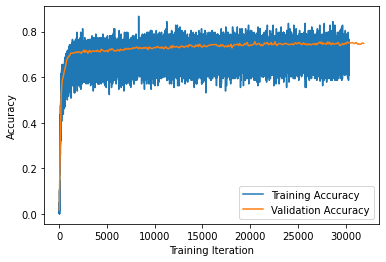

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()